# Transient Heat Transfer Tutorial Using DifferentialEquations.jl
# Extended with Non-Linear Dirichtlet Boundary Conditions 

## Import Packages 

In [1]:
using Ferrite
using SparseArrays
using LinearAlgebra         # provides mul! 
using UnPack                # added for time integration using DifferentialEquations.jl 
using OrdinaryDiffEq        # added for time integration using DifferentialEquations.jl
using DifferentialEquations # added for time integration using DifferentialEquations.jl
using WriteVTK
using Plots                 # provides contour plot of cell averages 

In [2]:
# import Pkg; Pkg.status() # uncomment to see version of package being used 

## Section 1: Introduction
We extend the heat transfer tutorial of Ferrite with time integration using DifferentialEquations.jl. We also implement non-linear Dirichlet boundary conditions. 
1. Case (1/2): Linear Boundary Conditions (Ferrite Heat Transfer Tutorial. Reset volumetric source from $f(x)=0.1$ to $f(x)=0.$. Ramped linear boundary source only. Zero initial guess);
2. Case (2/2): Non-Linear Dirichlet Boundary Conditions (No volumetric source. Ramped <b>non-linear</b> boundary source only. Zero initial guess);
   
(requires further elaboration).

## Section 2: Auxiliary Data Structures and Functions 

In [3]:
struct RHSparams
    K::SparseMatrixCSC
    ch::ConstraintHandler
    dh::DofHandler
    cvu::CellValues
    fvu::FacetValues
    u::Vector
end

# merely provides rough idea of the computed solution 
function mypostprocess(u, dh, cvu, nels)
 
    area = [] 
    myu  = [] 

    for (cell_num, cell) in enumerate(CellIterator(dh))

        dof_range_u = dof_range(dh,:u)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        Ferrite.reinit!(cvu, cell)

        cellarea = 0. 
        cellu = 0 

        # compute cell average of u 
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point)
            cellu_qp = function_value(cvu, q_point, uloc)
            cellarea += dΩ 
            cellu += cellu_qp*dΩ
        end

        append!(area, cellarea)
        append!(myu, cellu)
    
    end  

    myu2d = reshape(myu, nels)
    
    return area, myu2d  
end 

mypostprocess (generic function with 1 method)

## Section 3: Case (1/2): Mesh Generation, Spatial Discretization and Time Constants 

In [5]:
nels = (10,10)
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

K = allocate_matrix(dh);
M = allocate_matrix(dh);
f = zeros(ndofs(dh));

max_temp = 100
Δt = 1
T = 200
t_rise = 100
ch = ConstraintHandler(dh);

∂Ω₁ = union(getfacetset.((grid,), ["left", "right"])...)
dbc = Dirichlet(:u, ∂Ω₁, (x, t) -> 0)
add!(ch, dbc);

∂Ω₂ = union(getfacetset.((grid,), ["top", "bottom"])...)
dbc = Dirichlet(:u, ∂Ω₂, (x, t) -> max_temp * clamp(t / t_rise, 0, 1))
add!(ch, dbc)
close!(ch)
update!(ch, 0.0);

In [6]:
# here is how to verify how the update of the constraint handler works: intended for later use 
update!(ch,1.)
# ch.prescribed_dofs
# ch.dofcoefficients
# ch.inhomogeneities

In [17]:
function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

        n_basefuncs = getnbasefunctions(cellvalues)
        Ke = zeros(n_basefuncs, n_basefuncs)
        fe = zeros(n_basefuncs)

        assembler = start_assemble(K, f)

        for cell in CellIterator(dh)

            fill!(Ke, 0)
            fill!(fe, 0)

            Ferrite.reinit!(cellvalues, cell)

            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    ∇v = shape_gradient(cellvalues, q_point, i)
                    fe[i] += 0. * v * dΩ # 0.1 * v * dΩ
                    for j in 1:n_basefuncs
                        ∇u = shape_gradient(cellvalues, q_point, j)
                        Ke[i, j] += 1.0e-3 * (∇v ⋅ ∇u) * dΩ
                    end
                end
            end

            assemble!(assembler, celldofs(cell), Ke, fe)
        end
        return K, f
end

function assemble_M!(M::SparseMatrixCSC, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
        Me = zeros(n_basefuncs, n_basefuncs)
        assembler = start_assemble(M)

        for cell in CellIterator(dh)
            fill!(Me, 0)
            Ferrite.reinit!(cellvalues, cell)
            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    for j in 1:n_basefuncs
                        u = shape_value(cellvalues, q_point, j)
                        Me[i, j] += (v * u) * dΩ
                    end
                end
            end

        assemble!(assembler, celldofs(cell), Me)
        end
            
        return M
end

assemble_M! (generic function with 1 method)

In [18]:
#@code_warntype assemble_K!(K, f, cvu, dh)

In [19]:
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
A = (Δt .* K) + M;

rhsdata = get_rhs_data(ch, A);

## Section 4: Case (1/2): Time-Integration Using DifferentialEquations.jl

Q: how does time-step employed depend on value of the diffusion coefficient? 

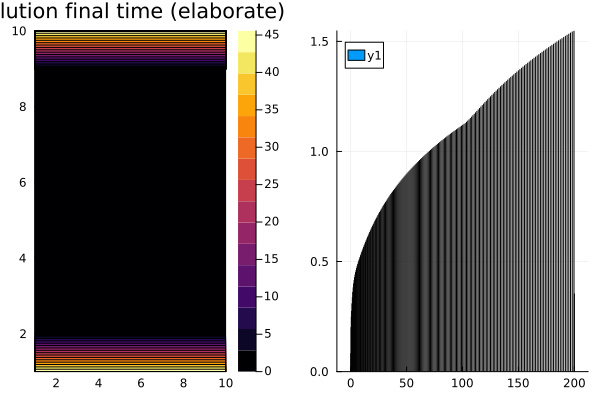

In [20]:
# doubt? one is **not** allowed to mutate the input argument u_uc to apply the boundary conditions \n",
function heat_rhs!(du, u_uc, p::RHSparams, t)

    # display(t)

    @unpack K, ch, dh, cvu, fvu, u = p    

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (diffusion operator)
    mul!(du, K, u) # du .= K * u

    return
end

function heat_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cvu, fvu, u = p

    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)  

    return apply!(J, ch)    
end

# set time constants 
T   = 200.0
Δt₀ = 1. 

# allocate, assemble and apply bc to mass matrix 
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess
uinit = zeros(ndofs(dh))

# set parameters 
p = RHSparams(K, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(heat_rhs!, mass_matrix = M; jac = heat_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
sol = solve(problem, Rodas5(autodiff=false), reltol = 1e-3, abstol = 1e-3); 

# post-processing 
area, myu2d = mypostprocess(sol.u[end], dh, cvu, nels) 
p1 = contour(myu2d', fill=true, title="solution final time (elaborate)")

dt = sol.t[2:end] - sol.t[1:end-1]
p2 = bar(sol.t[2:end],dt)

plot(p1, p2, layout=(1,2))

In [21]:
function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);

integrator = init(
    problem, timestepper; initializealg = NoInit(), dt = Δt₀,
    adaptive = true, abstol = 1e5*1.0e-3, reltol = 1e5*1.0e-3,
    progress = true, progress_steps = 1,
    verbose = true, d_discontinuities = [100.0]
);

pvd = paraview_collection("transient-heat")
for (step, (u, t)) in enumerate(intervals(integrator))
    display(t)
    VTKGridFile("transient-heat-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end

0.0

1.0

4.0235315331107575

8.977292869549956

15.512963462685935

24.75509393792349

31.961825513217704

42.90699925140225

50.6655306767539

62.747918990343166

70.59818084344937

81.53900000082912

89.82727889660022

100.0

110.17272110339978

120.41885519458276

130.71927395240766

141.05727699171456

151.42394750976803

161.80938111870395

172.21031269249073

182.62010954785524

193.0387717379184

## Section 5: Case (2/2): Mesh Generation, Spatial Discretization and Time Constants 
Note that in Case (2/2) the left boundary is not included in the constraint handler. 

In [53]:
nels = (40,20)
grid = generate_grid(Quadrilateral, nels);

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

K = allocate_matrix(dh);
M = allocate_matrix(dh);

f = zeros(ndofs(dh));

ch = ConstraintHandler(dh);

left_patch = getfacetset(dh.grid, "left")
∂Ω₂ = union(getfacetset.((grid,), ["top", "bottom", "right"])...)
dbc2 = Dirichlet(:u, ∂Ω₂, (x, t) -> 0)
add!(ch, dbc2)
close!(ch);

## Section 6: Case (2/2): Time-Integration Using DifferentialEquations.jl

In [61]:
function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

        n_basefuncs = getnbasefunctions(cellvalues)
        Ke = zeros(n_basefuncs, n_basefuncs)
        fe = zeros(n_basefuncs)

        assembler = start_assemble(K, f)

        for cell in CellIterator(dh)

            fill!(Ke, 0)
            fill!(fe, 0)

            Ferrite.reinit!(cellvalues, cell)

            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    ∇v = shape_gradient(cellvalues, q_point, i)
                    fe[i] += 0. * v * dΩ
                    for j in 1:n_basefuncs
                        ∇u = shape_gradient(cellvalues, q_point, j)
                        Ke[i, j] += 1e-1*(∇v ⋅ ∇u) * dΩ
                    end
                end
            end

            assemble!(assembler, celldofs(cell), Ke, fe)
        end
        return K, f
end

assemble_K! (generic function with 1 method)

In [62]:
t_rise = 1
res_functional(u,t) = u^2 - 2*(t*(t<=t_rise)+(t>t_rise))
dures_functional(u) = 2*u

function heat_rhs_element!(due, ue, fvu,t)
    n_basefuncs = getnbasefunctions(fvu)
    for qp in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, qp)
        # evaluate function in quad point 
        u_qp = function_value(fvu, qp, ue)
        val_qp = res_functional(u_qp,t)
        for j in 1:n_basefuncs
            φⱼ = shape_value(fvu, qp, j)
            due[j] += val_qp*φⱼ*dΓ
        end
    end   
    # display(due)
    return 
end 
    
function heat_jac_element!(Je, ue, fvu)
    n_basefuncs = getnbasefunctions(fvu)
    for qp in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, qp)
        # evaluate function in quad point 
        u_qp = function_value(fvu, qp, ue)
        duval_qp = dures_functional(u_qp)
        for j in 1:n_basefuncs
            φⱼ = shape_value(fvu, qp, j)
            for i in 1:n_basefuncs
                φᵢ = shape_value(fvu, qp, i)
                Je[j, i] += duval_qp*φᵢ*φⱼ* dΓ
            end
        end
    end   
    return 
end 

heat_jac_element! (generic function with 1 method)

In [63]:
function heat_rhs!(du, u_uc, p::RHSparams, t)

    # display(t)

    @unpack K, ch, dh, cvu, fvu, u = p    

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution 
    mul!(du, K, u) # du .= K * u

    # Non-Linear contribution 
    range_u = dof_range(dh, :u) 
    n_basefuncs = getnbasefunctions(cvu)
    ue  = zeros(n_basefuncs)
    due = zeros(n_basefuncs)

    for facet in FacetIterator(dh, left_patch)
        Ferrite.reinit!(fvu, facet)
        u_celldofs = @view celldofs(facet)[range_u]
        ue .= @views u[u_celldofs] # u is fetched outside of for-loop 
        fill!(due, 0)
        heat_rhs_element!(due, ue, fvu, t) # first argument is the input output argument 
        assemble!(du, u_celldofs, due) # add to previous values  
    end 
    
    return
end
    
function heat_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cvu, fvu, u = p    

    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)  

    assembler = start_assemble(J; fillzero = false)

    n_basefuncs = getnbasefunctions(cvu)
    ue  = zeros(n_basefuncs)
    Je  = zeros(n_basefuncs, n_basefuncs)
    due = zeros(n_basefuncs)
    range_u = dof_range(dh, :u) 

    for facet in FacetIterator(dh, left_patch)
        Ferrite.reinit!(fvu, facet)
        u_celldofs = @view celldofs(facet)[range_u]
        ue .= @views u[u_celldofs] # u is fetched outside of for-loop 
        fill!(Je, 0)
        heat_jac_element!(Je, ue, fvu) # first argument is the input output argument 
        assemble!(assembler, u_celldofs, Je) # add to previous values 
    end    

    return apply!(J, ch)    
end

heat_jac! (generic function with 1 method)

In [64]:
# test the RHS function 
du   = zeros(ndofs(dh));
u_uc = ones(ndofs(dh));
p    = RHSparams(K, ch, dh, cvu, fvu, copy(u_uc));

heat_rhs!(du, u_uc, p::RHSparams, 0.)
du;

In [65]:
# test the Jacobian function
du   = zeros(ndofs(dh));
u_uc = ones(ndofs(dh));
p    = RHSparams(K, ch, dh, cvu, fvu, copy(u_uc));

J = allocate_matrix(dh,ch);
heat_jac!(J, u_uc, p::RHSparams, 0.)
J; 

┌ Warning: At t=0.03348524937314672, dt was forced below floating point epsilon 6.938893903907228e-18, and step error estimate = 11.453433793148116. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/sN1tQ/src/integrator_interface.jl:623


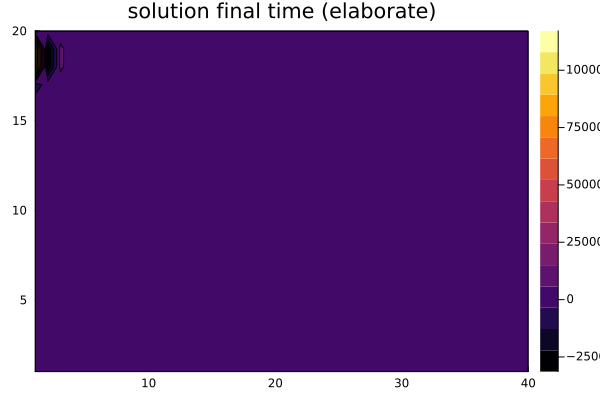

In [66]:
# set time constants 
T   = 2. 

# allocate, assemble and apply bc to mass matrix 
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess 
uinit = zeros(ndofs(dh))

# set parameters 
p = RHSparams(K, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(heat_rhs!, mass_matrix = M; jac = heat_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
sol = solve(problem, Rodas5(autodiff=false), reltol = 1e-3, abstol = 1e-3)

# post-processing 
area, myu2d = mypostprocess(sol.u[end], dh, cvu, nels) 
contour(myu2d', fill=true, title="solution final time (elaborate)")

In [67]:
function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);

integrator = init(
    problem, timestepper; initializealg = NoInit(), dt = Δt₀,
    adaptive = true, abstol = 1.0e-3, reltol = 1.0e-3,
    progress = true, progress_steps = 1,
    verbose = true, d_discontinuities = [1.0]
);

pvd = paraview_collection("transient-heat")
for (step, (u, t)) in enumerate(intervals(integrator))
    display(t)
    VTKGridFile("transient-heat-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end

0.0

0.0016

0.004397051840749068

0.007496178542633078

0.010688010863107736

0.013879843183582393

0.016547173001476175

0.01881635841306049

0.021085543824644806

0.02335472923622912

0.025623914647813436

0.027367596638025595

0.028880931906847353

0.030076363170367965

0.031271794433888576

0.03246722569740919

0.03297382013579344

0.033267217267338424

0.03346890117344426

0.03359232620350955

0.033666734080443746

0.03371197671978858

0.033739521023275154

0.03375777317143109

0.03376947491335745

0.033776994312363806

0.03378191568991925

0.03378479624447154

0.033786754931827215

0.03378812391779006

0.033789098300689345

0.03378980336587784

0.033790321800025884

0.03379070911621261

0.033791003121480465

0.033791254607134696

0.03379143785776657

0.033791578309423385

0.03379170069037208

0.03379179422533764

0.033791876228027574

0.03379194706612126

0.03379200142413954

0.033792049529563536

0.033792091749107536

0.03379212863094843

0.03379216079237421

0.03379218884862501

0.03379221337285352

0.03379223487731878

0.03379225380782852

0.03379227054572892

0.033792285413675655

0.03379229868289224

0.033792310580608005

0.03379232247832377

0.03379233289522436

0.033792342120142746

0.03379235036892072

0.03379235861769869

0.033792365871331574

0.0337923723352426

0.03379237879915362

0.033792384490036166

0.03379238957495113

0.03379239465986609

0.0337923991621252

0.03379240320854987

0.03379240725497454

0.0337924108653311

0.03379241447568766

0.03379241768330529

0.03379242089092292

0.03379242373542028

0.03379242657991764

0.03379242910233087

0.0337924316247441

0.03379243386455183

0.03379243610435956

0.03379243809787093

0.0337924400913823

0.03379244187103416

0.033792443650686024

0.03379244524490561

0.03379244683912519

0.03379244827251311

0.033792449705901034

0.033792451139288956

0.03379245241532266

0.03379245369135636

0.03379245483547705

0.033792455979597735

0.03379245712371842

0.03379245814307383

0.033792459162429234

0.0337924600786938

0.03379246099495836

0.033792461911222926

0.033792462731401324

0.03379246355157972

0.03379246437175812

0.03379246510449318

0.03379246583722824

0.0337924665699633

0.03379246722441129

0.03379246787885928

0.033792468533307266

0.03379246911842953

0.03379246970355179

0.033792470288674055

0.03379247081283344

0.03379247133699282

0.0337924718611522

0.03379247233191788

0.033792472802683556

0.03379247327344923

0.03379247374421491

0.03379247416430109

0.03379247458438727

0.03379247500447345

0.033792475381428544

0.033792475758383636

0.03379247613533873

0.03379247651229382

0.03379247684934633

0.03379247718639884

0.03379247752345135

0.033792477860503864

0.03379247816143406

0.03379247846236426

0.033792478763294456

0.033792479064224654

0.03379247933293597

0.03379247960164729

0.033792479870358605

0.03379248013906992

0.03379248037932536

0.0337924806195808

0.033792480859836244

0.033792481100091684

0.033792481315368814

0.03379248153064594

0.03379248174592307

0.0337924819612002

0.03379248215462565

0.0337924823480511

0.03379248254147655

0.033792482734902

0.03379248292832745

0.03379248310144248

0.03379248327455751

0.033792483447672536

0.033792483620787565

0.033792483776507246

0.033792483932226926

0.033792484087946606

0.033792484243666286

0.033792484399385966

0.03379248453921934

0.033792484679052714

0.03379248481888609

0.03379248495871946

0.03379248509855284

0.0337924852240987

0.03379248534964457

0.03379248547519043

0.0337924856007363

0.03379248572628216

0.03379248583910998

0.033792485951937797

0.03379248606476561

0.03379248617759343

0.033792486290421246

0.03379248640324906

0.03379248650423561

0.033792486605222154

0.0337924867062087

0.033792486807195245

0.03379248690818179

0.03379248699891416

0.033792487089646536

0.03379248718037891

0.03379248727111128

0.033792487361843655

0.03379248745257603

0.03379248753397024

0.03379248761536445

0.03379248769675866

0.03379248777815287

0.03379248785954708

0.03379248794094129

0.03379248801395645

0.033792488086971606

0.03379248815998676

0.03379248823300192

0.033792488306017075

0.03379248837903223

0.03379248844460299

0.033792488510173746

0.0337924885757445

0.03379248864131526

0.03379248870688602

0.033792488772456775

0.033792488831454935

0.033792488890453096

0.033792488949451256

0.03379248900844942

0.03379248906744758

0.03379248912644574

0.0337924891854439

0.033792489238410175

0.03379248929137645

0.03379248934434273

0.03379248939730901

0.033792489450275284

0.03379248950324156

0.03379248955620784

0.033792489603732344

0.03379248965125685

0.033792489698781354

0.03379248974630586

0.033792489793830364

0.03379248984135487

0.033792489888879375

0.03379248993155102

0.03379248997422266

0.03379249001689431

0.03379249005956595

0.033792490102237595

0.03379249014490924

0.03379249018758088

0.03379249022595733

0.03379249026433378

0.033792490302710226

0.033792490341086674

0.03379249037946312

0.03379249041783957

0.03379249045621602

0.033792490494592466

0.03379249052904366

0.03379249056349485

0.03379249059794604

0.03379249063239723

0.033792490666848425

0.03379249070129962

0.03379249073575081

0.033792490770202

0.03379249080112184

0.03379249083204167

0.03379249086296151

0.033792490893881345

0.03379249092480118

0.03379249095572102

0.033792490986640854

0.03379249101756069

0.033792491045336895

0.0337924910731131

0.033792491100889305

0.03379249112866551

0.033792491156441715

0.03379249118421792

0.033792491211994125

0.03379249123977033

0.03379249126476696

0.03379249128976359

0.03379249131476022

0.03379249133975685

0.03379249136475348

0.03379249138975011

0.03379249141474674

0.03379249143974337

0.03379249146474

0.033792491487209274

0.03379249150967855

0.03379249153214783

0.0337924915546171

0.03379249157708638

0.033792491599555656

0.03379249162202493

0.03379249164449421

0.033792491666963485

0.03379249168716536

0.033792491707367235

0.03379249172756911

0.033792491747770985

0.03379249176797286

0.033792491788174735

0.03379249180837661

0.033792491828578484

0.03379249184878036

0.033792491868982234

0.033792491887108055

0.033792491905233875

0.033792491923359695

0.033792491941485515

0.033792491959611336

0.033792491977737156

0.033792491995862976

0.0337924920139888

0.03379249203211462

0.03379249204842271

0.033792492064730804

0.0337924920810389

0.03379249209734699

0.033792492113655086

0.03379249212996318

0.03379249214627127

0.03379249216257937

0.03379249217888746

0.033792492195195555

0.03379249220986893

0.0337924922245423

0.033792492239215675

0.03379249225388905

0.03379249226856242

0.033792492283235796

0.03379249229790917

0.033792492312582544

0.03379249232725592

0.03379249234192929

0.033792492356602664

0.03379249236978057

0.03379249238295847

0.033792492396136374

0.03379249240931428

0.03379249242249218

0.033792492435670084

0.03379249244884799

0.03379249246202589

0.03379249247520379

0.0337924924883817

0.0337924925015596

0.03379249251339095

0.0337924925252223

0.033792492537053645

0.03379249254888499

0.03379249256071634

0.03379249257254769

0.03379249258437904

0.03379249259621039

0.033792492608041735

0.033792492619873084

0.03379249263170443

0.03379249264233619

0.03379249265296795

0.03379249266359971

0.03379249267423147

0.03379249268486323

0.03379249269549499

0.03379249270612675

0.03379249271675851

0.033792492727390266

0.033792492738022026

0.033792492748653785

0.033792492759285545

0.03379249276883053

0.03379249277837551

0.03379249278792049

0.033792492797465476

0.03379249280701046

0.03379249281655544

0.033792492826100425

0.03379249283564541

0.03379249284519039

0.03379249285473537

0.033792492864280356

0.03379249287382534

0.0337924928823982

0.033792492890971054

0.03379249289954391

0.03379249290811677

0.03379249291668963

0.033792492925262485

0.03379249293383534

0.0337924929424082

0.03379249295098106

0.033792492959553916

0.033792492968126774

0.03379249297669963

0.0337924929844102

0.03379249299212077

0.033792492999831336

0.033792493007541904

0.03379249301525247

0.03379249302296304

0.03379249303067361

0.03379249303838418

0.033792493046094746

0.033792493053805314

0.03379249306151588

0.03379249306922645

0.03379249307693702

0.033792493083870105

0.03379249309080319

0.03379249309773628

0.03379249310466936

0.03379249311160245

0.033792493118535535

0.03379249312546862

0.03379249313240171

0.033792493139334794

0.03379249314626788

0.033792493153200966

0.03379249316013405

0.03379249316706714

0.03379249317330654

0.03379249317954595

0.03379249318578535

0.03379249319202476

0.03379249319826416

0.03379249320450357

0.03379249321074297

0.033792493216982376

0.03379249322322178

0.033792493229461186

0.03379249323570059

0.033792493241939996

0.0337924932481794

0.033792493254418805

0.033792493260031

0.03379249326564319

0.03379249327125538

0.03379249327686757

0.03379249328247976

0.03379249328809195

0.033792493293704144

0.033792493299316335

0.03379249330492853

0.03379249331054072

0.03379249331615291

0.0337924933217651

0.03379249332737729

0.03379249333298948

0.033792493338601674

0.03379249334364226

0.033792493348682846

0.03379249335372343

0.03379249335876402

0.033792493363804604

0.03379249336884519

0.033792493373885776

0.03379249337892636

0.03379249338396695

0.033792493389007534

0.03379249339404812

0.033792493399088706

0.03379249340412929

0.03379249340916988

0.033792493414210464

0.033792493418737635

0.033792493423264805

0.033792493427791975

0.033792493432319146

0.033792493436846316

0.033792493441373486

0.033792493445900657

0.03379249345042783

0.033792493454955

0.03379249345948217

0.03379249346400934

0.03379249346853651

0.03379249347306368

0.03379249347759085

0.03379249348211802

0.033792493486188506

0.03379249349025899

0.03379249349432948

0.03379249349839997

0.033792493502470454

0.03379249350654094

0.03379249351061143

0.033792493514681915

0.0337924935187524

0.03379249352282289

0.033792493526893376

0.03379249353096386

0.03379249353503435

0.03379249353910484

0.033792493543175324

0.03379249354724581

0.03379249355090552

0.033792493554565234

0.033792493558224945

0.03379249356188466

0.03379249356554437

0.03379249356920408

0.03379249357286379

0.0337924935765235

0.033792493580183214

0.033792493583842925

0.03379249358750264

0.03379249359116235

0.03379249359482206

0.03379249359848177

0.03379249360214148

0.033792493605801194

0.033792493609460905

0.033792493612748574

0.03379249361603624

0.03379249361932391

0.03379249362261158

0.03379249362589925

0.03379249362918692

0.033792493632474586

0.033792493635762255

0.033792493639049924

0.03379249364233759

0.03379249364562526

0.03379249364891293

0.0337924936522006

0.03379249365548827

0.033792493658775936

0.033792493662063605

0.033792493665351274

0.03379249366830613

0.03379249367126099

0.03379249367421585

0.03379249367717071

0.03379249368012557

0.033792493683080425

0.033792493686035284

0.03379249368899014

0.033792493691945

0.03379249369489986

0.03379249369785472

0.03379249370080958

0.033792493703764435

0.033792493706719294

0.03379249370967415

0.03379249371262901

0.03379249371558387

0.03379249371853873

0.03379249372119366

0.03379249372384859

0.033792493726503524

0.033792493729158456

0.03379249373181339

0.03379249373446832

0.03379249373712325

0.03379249373977818

0.033792493742433115

0.03379249374508805

0.03379249374774298

0.03379249375039791

0.03379249375305284

0.033792493755707774

0.033792493758362706

0.03379249376101764

0.03379249376367257

0.0337924937663275

0.03379249376871501

0.033792493771102515

0.03379249377349002

0.03379249377587753

0.033792493778265036

0.03379249378065254

0.03379249378304005

0.033792493785427556

0.03379249378781506

0.03379249379020257

0.03379249379259008

0.033792493794977584

0.03379249379736509

0.0337924937997526

0.033792493802140104

0.03379249380452761

0.03379249380691512

0.033792493809302625

0.03379249381169013

0.033792493813837365

0.0337924938159846

0.03379249381813183

0.03379249382027907

0.0337924938224263

0.033792493824573534

0.03379249382672077

0.033792493828868

0.033792493831015236

0.03379249383316247

0.0337924938353097

0.03379249383745694

0.03379249383960417

0.033792493841751405

0.03379249384389864

0.03379249384604587

0.033792493848193106

0.03379249385034034

0.03379249385248757

0.03379249385463481

0.03379249385656513

0.033792493858495455

0.03379249386042578

0.0337924938623561

0.03379249386428643

0.03379249386621675

0.033792493868147075

0.0337924938700774

0.03379249387200772

0.03379249387393805

0.03379249387586837

0.033792493877798695

0.03379249387972902

0.03379249388165934

0.03379249388358967

0.03379249388551999

0.033792493887450314

0.03379249388938064

0.03379249389131096

0.033792493893241286

0.03379249389497794

0.03379249389671459

0.033792493898451244

0.033792493900187896

0.03379249390192455

0.0337924939036612

0.033792493905397854

0.033792493907134506

0.03379249390887116

0.03379249391060781

0.033792493912344464

0.033792493914081116

0.03379249391581777

0.03379249391755442

0.033792493919291074

0.033792493921027726

0.03379249392276438

0.03379249392450103

0.033792493926237684

0.033792493927974336

0.03379249392971099

0.033792493931273676

0.033792493932836364

0.03379249393439905

0.03379249393596174

0.033792493937524426

0.03379249393908711

0.0337924939406498

0.03379249394221249

0.033792493943775176

0.03379249394533786

0.03379249394690055

0.03379249394846324

0.033792493950025926

0.03379249395158861

0.0337924939531513

0.03379249395471399

0.033792493956276676

0.03379249395783936

0.03379249395940205

0.03379249396096474

0.033792493962527426

0.03379249396409011

0.03379249396549597

0.03379249396690182

0.03379249396830768

0.03379249396971353

0.033792493971119386

0.03379249397252524

0.033792493973931095

0.03379249397533695

0.033792493976742805

0.03379249397814866

0.033792493979554514

0.03379249398096037

0.03379249398236622

0.03379249398377208

0.03379249398517793

0.03379249398658379

0.03379249398798964

0.033792493989395496

0.03379249399080135

0.033792493992207205

0.03379249399361306

0.033792493995018914

0.03379249399642477

0.033792493997688966

0.03379249399895316

0.03379249400021736

0.03379249400148156

0.033792494002745754

0.03379249400400995

0.03379249400527415

0.033792494006538346

0.03379249400780254

0.03379249400906674

0.03379249401033094

0.033792494011595134

0.03379249401285933

0.03379249401412353

0.033792494015387725

0.03379249401665192

0.03379249401791612

0.033792494019180316

0.03379249402044451

0.03379249402170871

0.03379249402297291

0.033792494024237105

0.0337924940255013

0.03379249402663895

0.03379249402777659

0.03379249402891424

0.033792494030051884

0.03379249403118953

0.033792494032327175

0.03379249403346482

0.033792494034602466

0.03379249403574011

0.03379249403687776

0.0337924940380154

0.03379249403915305

0.033792494040290694

0.03379249404142834

0.033792494042565985

0.03379249404370363

0.033792494044841276

0.03379249404597892

0.03379249404711657

0.03379249404825421

0.03379249404939186

0.033792494050529504

0.03379249405166715

0.033792494052804795

0.03379249405394244

0.03379249405496527

0.033792494055988095

0.03379249405701092

0.03379249405803375

0.03379249405905658

0.033792494060079406

0.033792494061102234

0.03379249406212506

0.03379249406314789

0.03379249406417072

0.033792494065193544

0.03379249406621637

0.0337924940672392

0.03379249406826203

0.033792494069284855

0.03379249407030768

0.03379249407133051

0.03379249407235334

0.033792494073376166

0.03379249407439899

0.03379249407542182

0.03379249407644465

0.033792494077467476

0.033792494078490304

0.03379249407951313

0.03379249408043308

0.033792494081353035

0.033792494082272986

0.03379249408319294

0.03379249408411289

0.03379249408503284

0.03379249408595279

0.033792494086872744

0.033792494087792696

0.03379249408871265

0.0337924940896326

0.03379249409055255

0.0337924940914725

0.033792494092392454

0.033792494093312406

0.03379249409423236

0.03379249409515231

0.03379249409607226

0.03379249409699221

0.033792494097912164

0.033792494098832115

0.03379249409975207

0.03379249410067202

0.03379249410159197

0.03379249410251192

0.033792494103431873

0.03379249410425945

0.03379249410508702

0.033792494105914596

0.03379249410674217

0.033792494107569744

0.03379249410839732

0.03379249410922489

0.033792494110052466

0.03379249411088004

0.033792494111707615

0.03379249411253519

0.03379249411336276

0.03379249411419034

0.03379249411501791

0.033792494115845485

0.03379249411667306

0.033792494117500634

0.03379249411832821

0.03379249411915578

0.033792494119983356

0.03379249412081093

0.033792494121638504

0.03379249412246608

0.03379249412329365

0.033792494124121226

0.0337924941249488

0.033792494125776375

0.0337924941265209

0.03379249412726542

0.03379249412800994

0.033792494128754465

0.03379249412949899

0.03379249413024351

0.03379249413098803

0.033792494131732555

0.03379249413247708

0.0337924941332216

0.03379249413396612

0.033792494134710645

0.03379249413545517

0.03379249413619969

0.03379249413694421

0.033792494137688735

0.03379249413843326

0.03379249413917778

0.0337924941399223

0.033792494140666825

0.03379249414141135

0.03379249414215587

0.03379249414290039

0.033792494143644915

0.03379249414438944

0.03379249414513396

0.03379249414587848

0.033792494146623005

0.03379249414729282

0.03379249414796264

0.03379249414863246

0.03379249414930228

0.0337924941499721

0.033792494150641915

0.03379249415131173

0.03379249415198155

0.03379249415265137

0.03379249415332119

0.03379249415399101

0.033792494154660825

0.033792494155330643

0.03379249415600046

0.03379249415667028

0.0337924941573401

0.03379249415800992

0.033792494158679735

0.033792494159349554

0.03379249416001937

0.03379249416068919

0.03379249416135901

0.03379249416202883

0.033792494162698646

0.033792494163368464

0.03379249416403828

0.0337924941647081

0.03379249416537792

0.03379249416604774

0.03379249416665035

0.03379249416725297

0.03379249416785558

0.0337924941684582

0.03379249416906081

0.03379249416966343

0.033792494170266044

0.03379249417086866

0.033792494171471274

0.03379249417207389

0.033792494172676504

0.03379249417327912

0.033792494173881735

0.03379249417448435

0.033792494175086965

0.03379249417568958

0.033792494176292195

0.03379249417689481

0.033792494177497426

0.03379249417810004

0.033792494178702656

0.03379249417930527

0.033792494179907887

0.0337924941805105

0.03379249418111312

0.03379249418171573

0.03379249418231835

0.03379249418292096

0.03379249418352358

0.03379249418412619

0.03379249418466838

0.03379249418521056

0.033792494185752746

0.03379249418629493

0.033792494186837115

0.0337924941873793

0.03379249418792148

0.03379249418846367

0.03379249418900585

0.033792494189548036

0.03379249419009022

0.033792494190632405

0.03379249419117459

0.033792494191716774

0.03379249419225896

0.03379249419280114

0.03379249419334333

0.03379249419388551

0.033792494194427695

0.03379249419496988

0.033792494195512064

0.03379249419605425

0.03379249419659643

0.03379249419713862

0.0337924941976808

0.033792494198222986

0.03379249419876517

0.033792494199307355

0.03379249419984954

0.03379249420039172

0.03379249420093391

0.033792494201421774

0.03379249420190964

0.03379249420239751

0.033792494202885374

0.03379249420337324

0.03379249420386111

0.033792494204348975

0.03379249420483684

0.03379249420532471

0.033792494205812575

0.03379249420630044

0.03379249420678831

0.033792494207276175

0.03379249420776404

0.03379249420825191

0.033792494208739775

0.03379249420922764

0.03379249420971551

0.033792494210203375

0.03379249421069124

0.03379249421117911

0.033792494211666975

0.03379249421215484

0.03379249421264271

0.033792494213130575

0.03379249421361844

0.03379249421410631

0.033792494214594175

0.03379249421508204

0.03379249421556991

0.033792494216057775

0.03379249421654564

0.03379249421698472

0.0337924942174238

0.03379249421786288

0.03379249421830196

0.03379249421874104

0.03379249421918012

0.0337924942196192

0.033792494220058276

0.033792494220497356

0.033792494220936435

0.033792494221375514

0.033792494221814594

0.03379249422225367

0.03379249422269275

0.03379249422313183

0.03379249422357091

0.03379249422400999

0.03379249422444907

0.03379249422488815

0.03379249422532723

0.03379249422576631

0.03379249422620539

0.033792494226644466

0.033792494227083546

0.033792494227522625

0.033792494227961704

0.033792494228400784

0.03379249422883986

0.03379249422927894

0.03379249422971802

0.0337924942301571

0.03379249423059618

0.03379249423103526

0.03379249423147434

0.03379249423186926

0.03379249423226418

0.0337924942326591

0.03379249423305402

0.03379249423344894

0.03379249423384386

0.03379249423423878

0.0337924942346337

0.03379249423502862

0.03379249423542354

0.03379249423581846

0.03379249423621338

0.0337924942366083

0.03379249423700322

0.03379249423739814

0.03379249423779306

0.03379249423818798

0.0337924942385829

0.03379249423897782

0.03379249423937274

0.03379249423976766

0.033792494240162584

0.033792494240557504

0.033792494240952424

0.033792494241347344

0.033792494241742264

0.033792494242137185

0.033792494242532105

0.033792494242927025

0.033792494243321945

0.033792494243716865

0.033792494244111786

0.033792494244506706

0.033792494244901626

0.033792494245257036

0.033792494245612446

0.033792494245967857

0.03379249424632327

0.03379249424667868

0.03379249424703409

0.0337924942473895

0.03379249424774491

0.03379249424810032

0.03379249424845573

0.03379249424881114

0.03379249424916655

0.03379249424952196

0.03379249424987737

0.03379249425023278

0.03379249425058819

0.0337924942509436

0.03379249425129901

0.03379249425165442

0.03379249425200983

0.03379249425236524

0.03379249425272065

0.03379249425307606

0.03379249425343147

0.03379249425378688

0.03379249425414229

0.0337924942544977

0.03379249425485311

0.03379249425520852

0.03379249425556393

0.03379249425591934

0.03379249425627475

0.03379249425663016

0.03379249425698557

0.03379249425734098

0.03379249425769639

0.03379249425801618

0.03379249425833596

0.03379249425865575

0.033792494258975535

0.03379249425929532

0.033792494259615106

0.03379249425993489

0.03379249426025468

0.033792494260574464

0.03379249426089425

0.033792494261214036

0.03379249426153382

0.03379249426185361

0.03379249426217339

0.03379249426249318

0.033792494262812965

0.03379249426313275

0.03379249426345254

0.03379249426377232

0.03379249426409211

0.033792494264411894

0.03379249426473168

0.033792494265051466

0.03379249426537125

0.03379249426569104

0.033792494266010824

0.03379249426633061

0.033792494266650396

0.03379249426697018

0.03379249426728997

0.03379249426760975

0.03379249426792954

0.033792494268249325

0.03379249426856911

0.0337924942688889

0.03379249426920868

0.03379249426952847

0.03379249426981622

0.033792494270103966

0.033792494270391715

0.033792494270679464

0.03379249427096721

0.03379249427125496

0.03379249427154271

0.03379249427183046

0.03379249427211821

0.03379249427240596

0.03379249427269371

0.033792494272981456

0.033792494273269205

0.033792494273556954

0.0337924942738447

0.03379249427413245

0.0337924942744202

0.03379249427470795

0.0337924942749957

0.03379249427528345

0.0337924942755712

0.033792494275858946

0.033792494276146695

0.033792494276434444

0.03379249427672219

0.03379249427700994

0.03379249427729769

0.03379249427758544

0.03379249427787319

0.03379249427816094

0.03379249427844869

0.033792494278736436

0.033792494279024185

0.033792494279311934

0.03379249427959968

0.03379249427988743

0.03379249428017518

0.03379249428046293

0.03379249428075068

0.03379249428100948

0.03379249428126828

0.03379249428152708

0.03379249428178588

0.03379249428204468

0.03379249428230348

0.03379249428256228

0.03379249428282108

0.03379249428307988

0.03379249428333868

0.03379249428359748

0.03379249428385628

0.03379249428411508

0.03379249428437388

0.03379249428463268

0.03379249428489148

0.03379249428515028

0.03379249428540908

0.03379249428566788

0.03379249428592668

0.03379249428618548

0.03379249428644428

0.03379249428670308

0.03379249428696188

0.03379249428722068

0.03379249428747948

0.03379249428773828

0.03379249428799708

0.03379249428825588

0.03379249428851468

0.03379249428877348

0.03379249428903228

0.033792494289291077

0.033792494289549876

0.033792494289808676

0.033792494290067476

0.033792494290326276

0.033792494290585076

0.033792494290843876

0.033792494291102676

0.03379249429133542

0.033792494291568165

0.03379249429180091

0.033792494292033654

0.0337924942922664

0.03379249429249914

0.03379249429273189

0.03379249429296463

0.033792494293197375

0.03379249429343012

0.033792494293662864

0.03379249429389561

0.03379249429412835

0.0337924942943611

0.03379249429459384

0.033792494294826586

0.03379249429505933

0.033792494295292075

0.03379249429552482

0.033792494295757564

0.03379249429599031

0.03379249429622305

0.0337924942964558

0.03379249429668854

0.033792494296921285

0.03379249429715403

0.033792494297386774

0.03379249429761952

0.03379249429785226

0.03379249429808501

0.03379249429831775

0.033792494298550496

0.03379249429878324

0.033792494299015985

0.03379249429924873

0.033792494299481474

0.03379249429971422

0.03379249429994696

0.03379249430017971

0.03379249430041245

0.033792494300645196

0.03379249430085457

0.033792494301063944

0.03379249430127332

0.03379249430148269

0.033792494301692066

0.03379249430190144

0.033792494302110815

0.03379249430232019

0.03379249430252956

0.03379249430273894

0.03379249430294831

0.033792494303157686

0.03379249430336706

0.033792494303576434

0.03379249430378581

0.03379249430399518

0.03379249430420456

0.03379249430441393

0.033792494304623305

0.03379249430483268

0.03379249430504205

0.03379249430525143

0.0337924943054608

0.033792494305670176

0.03379249430587955

0.033792494306088924

0.0337924943062983

0.03379249430650767

0.03379249430671705

0.03379249430692642

0.033792494307135795

0.03379249430734517

0.033792494307554544

0.03379249430776392

0.03379249430797329

0.033792494308182666

0.03379249430839204

0.033792494308601415

0.03379249430881079

0.03379249430902016

0.03379249430922954

0.03379249430943891

0.033792494309648285

0.03379249430983661

0.03379249431002493

0.03379249431021325

0.03379249431040157

0.03379249431058989

0.033792494310778215

0.03379249431096654

0.03379249431115486

0.03379249431134318

0.0337924943115315

0.03379249431171982

0.033792494311908144

0.033792494312096466

0.03379249431228479

0.03379249431247311

0.03379249431266143

0.03379249431284975

0.033792494313038074

0.033792494313226396

0.03379249431341472

0.03379249431360304

0.03379249431379136

0.03379249431397968

0.033792494314168

0.033792494314356325

0.03379249431454465

0.03379249431473297

0.03379249431492129

0.03379249431510961

0.03379249431529793

0.033792494315486254

0.033792494315674576

0.0337924943158629

0.03379249431605122

0.03379249431623954

0.03379249431642786

0.033792494316616184

0.033792494316804506

0.03379249431699283

0.03379249431718115

0.03379249431736947

0.03379249431755779

0.03379249431774611

0.033792494317934435

0.03379249431810386

0.03379249431827329

0.033792494318442716

0.03379249431861214

0.03379249431878157

0.033792494318951

0.033792494319120424

0.03379249431928985

0.03379249431945928

0.033792494319628705

0.03379249431979813

0.03379249431996756

0.033792494320136986

0.03379249432030641

0.03379249432047584

0.03379249432064527

0.033792494320814694

0.03379249432098412

0.03379249432115355

0.033792494321322974

0.0337924943214924

0.03379249432166183

0.033792494321831255

0.03379249432200068

0.03379249432217011

0.033792494322339536

0.03379249432250896

0.03379249432267839

0.03379249432284782

0.033792494323017244

0.03379249432318667

0.0337924943233561

0.033792494323525525

0.03379249432369495

0.03379249432386438

0.033792494324033806

0.03379249432420323

0.03379249432437266

0.03379249432454209

0.033792494324711514

0.03379249432488094

0.03379249432505037

0.033792494325219795

0.03379249432538922

0.03379249432555865

0.033792494325728076

0.03379249432588049

0.0337924943260329

0.033792494326185314

0.03379249432633773

0.03379249432649014

0.03379249432664255

0.033792494326794965

0.03379249432694738

0.03379249432709979

0.033792494327252204

0.03379249432740462

0.03379249432755703

0.03379249432770944

0.033792494327861855

0.03379249432801427

0.03379249432816668

0.03379249432831909

0.033792494328471506

0.03379249432862392

0.03379249432877633

0.033792494328928745

0.03379249432908116

0.03379249432923357

0.03379249432938598

0.033792494329538396

0.03379249432969081

0.03379249432984322

0.033792494329995634

0.03379249433014805

0.03379249433030046

0.03379249433045287

0.033792494330605286

0.0337924943307577

0.03379249433091011

0.033792494331062524

0.03379249433121494

0.03379249433136735

0.03379249433151976

0.033792494331672175

0.03379249433182459

0.033792494331977

0.033792494332129414

0.033792494332281826

0.03379249433243424

0.03379249433258665

0.033792494332739065

0.03379249433289148

0.03379249433302863

0.033792494333165786

0.03379249433330294

0.033792494333440094

0.03379249433357725

0.0337924943337144

0.03379249433385156

0.03379249433398871

0.033792494334125865

0.03379249433426302

0.033792494334400174

0.03379249433453733

0.03379249433467448

0.033792494334811636

0.03379249433494879

0.033792494335085944

0.0337924943352231

0.03379249433536025

0.03379249433549741

0.03379249433563456

0.033792494335771715

0.03379249433590887

0.033792494336046024

0.03379249433618318

0.03379249433632033

0.033792494336457486

0.03379249433659464

0.033792494336731795

0.03379249433686895

0.0337924943370061

0.03379249433714326

0.03379249433728041

0.033792494337417565

0.03379249433755472

0.033792494337691874

0.03379249433782903

0.03379249433796618

0.033792494338103336

0.03379249433824049

0.033792494338377645

0.0337924943385148

0.03379249433865195

0.03379249433878911

0.03379249433892626

0.033792494339063416

0.03379249433920057

0.033792494339337724

0.03379249433947488

0.03379249433961203

0.03379249433973547

0.033792494339858904

0.03379249433998234

0.033792494340105776

0.03379249434022921

0.03379249434035265

0.033792494340476084

0.03379249434059952

0.033792494340722956

0.03379249434084639

0.03379249434096983

0.033792494341093264

0.0337924943412167

0.033792494341340136

0.03379249434146357

0.03379249434158701

0.033792494341710444

0.03379249434183388

0.033792494341957316

0.03379249434208075

0.03379249434220419

0.033792494342327624

0.03379249434245106

0.033792494342574496

0.03379249434269793

0.03379249434282137

0.033792494342944804

0.03379249434306824

0.033792494343191676

0.03379249434331511

0.03379249434343855

0.033792494343561984

0.03379249434368542

0.033792494343808856

0.03379249434393229

0.03379249434405573

0.033792494344179164

0.0337924943443026

0.033792494344426036

0.03379249434454947

0.03379249434467291

0.033792494344796344

0.03379249434491978

0.033792494345043216

0.03379249434516665

0.03379249434529009

0.033792494345413523

0.03379249434553696

0.033792494345660395

0.03379249434578383

0.03379249434590727

0.033792494346018345

0.03379249434612942

0.0337924943462405

0.03379249434635158

0.033792494346462656

0.033792494346573734

0.03379249434668481

0.03379249434679589

0.03379249434690697

0.033792494347018046

0.03379249434712912

0.0337924943472402

0.03379249434735128

0.03379249434746236

0.033792494347573435

0.03379249434768451

0.03379249434779559

0.03379249434790667

0.033792494348017746

0.033792494348128824

0.0337924943482399

0.03379249434835098

0.03379249434846206

0.033792494348573135

0.03379249434868421

0.03379249434879529

0.03379249434890637

0.033792494349017446

0.033792494349128524

0.0337924943492396

0.03379249434935068

0.03379249434946176

0.033792494349572835

0.03379249434968391

0.03379249434979499

0.03379249434990607

0.033792494350017147

0.033792494350128224

0.0337924943502393

0.03379249435035038

0.03379249435046146

0.033792494350572536

0.03379249435068361

0.03379249435079469

0.03379249435090577

0.03379249435101685

0.033792494351127925

0.033792494351239

0.03379249435135008

0.03379249435146116

0.033792494351572236

0.033792494351683314

0.03379249435179439

0.03379249435189433

0.03379249435199427

0.033792494352094214

0.033792494352194155

0.033792494352294096

0.03379249435239404

0.03379249435249398

0.03379249435259392

0.03379249435269386

0.0337924943527938

0.03379249435289374

0.03379249435299368

0.03379249435309362

0.033792494353193564

0.033792494353293505

0.033792494353393446

0.03379249435349339

0.03379249435359333

0.03379249435369327

0.03379249435379321

0.03379249435389315

0.03379249435399309

0.03379249435409303

0.03379249435419297

0.033792494354292914

0.033792494354392855

0.033792494354492796

0.033792494354592736

0.03379249435469268

0.03379249435479262

0.03379249435489256

0.0337924943549925

0.03379249435509244

0.03379249435519238

0.03379249435529232

0.033792494355392264

0.033792494355492204

0.033792494355592145

0.033792494355692086

0.03379249435579203

0.03379249435589197

0.03379249435599191

0.03379249435609185

0.03379249435619179

0.03379249435629173

0.03379249435639167

0.03379249435649161

0.033792494356591554

0.033792494356691495

0.033792494356791436

0.03379249435689138

0.03379249435699132

0.03379249435709126

0.0337924943571912

0.03379249435729114

0.03379249435738104

0.03379249435747094

0.03379249435756084

0.03379249435765074

0.03379249435774064

0.03379249435783054

0.03379249435792044

0.03379249435801034

0.03379249435810024

0.033792494358190144

0.033792494358280044

0.033792494358369944

0.033792494358459844

0.033792494358549745

0.033792494358639645

0.033792494358729545

0.033792494358819446

0.033792494358909346

0.033792494358999246

0.03379249435908915

0.03379249435917905

0.03379249435926895

0.03379249435935885

0.03379249435944875

0.03379249435953865

0.03379249435962855

0.03379249435971845

0.03379249435980835

0.03379249435989825

0.03379249435998815

0.03379249436007805

0.03379249436016795

0.03379249436025785

0.03379249436034775

0.03379249436043765

0.03379249436052755

0.03379249436061745

0.03379249436070735

0.03379249436079725

0.03379249436088715

0.03379249436097705

0.03379249436106695

0.033792494361156854

0.033792494361246754

0.033792494361336654

0.033792494361426555

0.033792494361516455

0.033792494361606355

0.033792494361696256

0.033792494361786156

0.033792494361876056

0.033792494361965957

0.03379249436205586

0.03379249436214576

0.03379249436223566

0.03379249436232556

0.03379249436240646

0.03379249436248736

0.03379249436256826

0.03379249436264916

0.03379249436273006

0.03379249436281096

0.03379249436289186

0.03379249436297276

0.03379249436305366

0.03379249436313456

0.033792494363215464

0.033792494363296365

0.033792494363377265

0.033792494363458166

0.033792494363539066

0.03379249436361997

0.03379249436370087

0.03379249436378177

0.03379249436386267

0.03379249436394357

0.03379249436402447

0.03379249436410537

0.03379249436418627

0.03379249436426717

0.03379249436434807

0.03379249436442897

0.03379249436450987

0.033792494364590774

0.033792494364671674

0.033792494364752575

0.033792494364833475

0.033792494364914376

0.033792494364995276

0.03379249436507618

0.03379249436515708

0.03379249436523798

0.03379249436531888

0.03379249436539978

0.03379249436548068

0.03379249436556158

0.03379249436564248

0.03379249436572338

0.03379249436580428

0.03379249436588518

0.03379249436596608

0.033792494366046984

0.033792494366127884

0.033792494366208785

0.033792494366289685

0.033792494366370586

0.033792494366451487

0.03379249436653239

0.03379249436661329

0.03379249436669419

0.03379249436677509

0.03379249436685599

0.03379249436693689

0.03379249436701779

0.03379249436709869

0.03379249436717148

0.03379249436724427

0.03379249436731706

0.03379249436738985

0.033792494367462636

0.033792494367535425

0.033792494367608214

0.033792494367681

0.03379249436775379

0.03379249436782658

0.03379249436789937

0.03379249436797216

0.03379249436804495

0.03379249436811774

0.033792494368190526

0.033792494368263315

0.033792494368336104

0.03379249436840889

0.03379249436848168

0.03379249436855447

0.03379249436862726

0.03379249436870005

0.03379249436877284

0.03379249436884563

0.033792494368918416

0.033792494368991205

0.033792494369063994

0.03379249436913678

0.03379249436920957

0.03379249436928236

0.03379249436935515

0.03379249436942794

0.03379249436950073

0.03379249436957352

0.033792494369646306

0.033792494369719095

0.033792494369791884

0.03379249436986467

0.03379249436993746

0.03379249437001025

0.03379249437008304

0.03379249437015583

0.03379249437022862

0.03379249437030141

0.033792494370374196

0.033792494370446985

0.033792494370519774

0.03379249437059256

0.03379249437066535

0.03379249437073814

0.03379249437081093

0.03379249437088372

0.03379249437095651

0.0337924943710293

0.033792494371102086

0.033792494371174875

0.033792494371247664

0.03379249437132045

0.03379249437139324

0.03379249437146603

0.03379249437153882

0.0337924943716043

0.033792494371669785

0.03379249437173527

0.03379249437180075

0.03379249437186623

0.033792494371931714

0.033792494371997196

0.03379249437206268

0.03379249437212816

0.03379249437219364

0.033792494372259126

0.03379249437232461

0.03379249437239009

0.03379249437245557

0.033792494372521055

0.03379249437258654

0.03379249437265202

0.0337924943727175

0.033792494372782984

0.03379249437284847

0.03379249437291395

0.03379249437297943

0.033792494373044914

0.033792494373110396

0.03379249437317588

0.03379249437324136

0.03379249437330684

0.033792494373372325

0.03379249437343781

0.03379249437350329

0.03379249437356877

0.033792494373634255

0.03379249437369974

0.03379249437376522

0.0337924943738307

0.033792494373896184

0.033792494373961666

0.03379249437402715

0.03379249437409263

0.033792494374158114

0.033792494374223596

0.03379249437428908

0.03379249437435456

0.03379249437442004

0.033792494374485525

0.03379249437455101

0.03379249437461649

0.03379249437468197

0.033792494374747455

0.03379249437481294

0.03379249437487842

0.0337924943749439

0.033792494375009384

0.033792494375074866

0.03379249437514035

0.03379249437520583

0.03379249437527131

0.033792494375336796

0.03379249437540228

0.03379249437546776

0.03379249437553324

0.033792494375598725

0.03379249437566421

0.03379249437572311

0.033792494375782016

0.03379249437584092

0.033792494375899824

0.03379249437595873

0.03379249437601763

0.03379249437607654

0.03379249437613544

0.033792494376194346

0.03379249437625325

0.033792494376312154

0.03379249437637106

0.03379249437642996

0.03379249437648887

0.03379249437654777

0.033792494376606676

0.03379249437666558

0.033792494376724484

0.03379249437678339

0.03379249437684229

0.0337924943769012

0.0337924943769601

0.033792494377019006

0.03379249437707791

0.033792494377136814

0.03379249437719572

0.03379249437725462

0.03379249437731353

0.03379249437737243

0.033792494377431335

0.03379249437749024

0.033792494377549144

0.03379249437760805

0.03379249437766695

0.03379249437772586

0.03379249437778476

0.033792494377843665

0.03379249437790257

0.033792494377961474

0.03379249437802038

0.03379249437807928

0.03379249437813819

0.03379249437819709

0.033792494378255995

0.0337924943783149

0.033792494378373804

0.03379249437843271

0.03379249437849161

0.03379249437855052

0.03379249437860942

0.033792494378668325

0.03379249437872723

0.033792494378786134

0.03379249437884504

0.03379249437890394

0.033792494378962847

0.03379249437902175

0.033792494379080655

0.03379249437913956

0.033792494379198464

0.03379249437925737

0.03379249437931627

0.033792494379375176

0.03379249437943408

0.033792494379492985

0.033792494379545984

0.033792494379598984

0.03379249437965198

0.03379249437970498

0.03379249437975798

0.03379249437981098

0.03379249437986398

0.03379249437991698

0.03379249437996998

0.03379249438002298

0.03379249438007598

0.033792494380128976

0.033792494380181975

0.033792494380234975

0.033792494380287974

0.03379249438034097

0.03379249438039397

0.03379249438044697

0.03379249438049997

0.03379249438055297

0.03379249438060597

0.03379249438065897

0.03379249438071197

0.03379249438076497

0.03379249438081797

0.033792494380870966

0.033792494380923965

0.033792494380976965

0.033792494381029964

0.03379249438108296

0.03379249438113596

0.03379249438118896

0.03379249438124196

0.03379249438129496

0.03379249438134796

0.03379249438140096

0.03379249438145396

0.03379249438150696

0.03379249438155996

0.033792494381612956

0.033792494381665955

0.033792494381718954

0.033792494381771954

0.03379249438182495

0.03379249438187795

0.03379249438193095

0.03379249438198395

0.03379249438203695

0.03379249438208995

0.03379249438214295

0.03379249438219595

0.03379249438224895

0.033792494382301946

0.033792494382354946

0.033792494382407945

0.033792494382460944

0.03379249438251394

0.03379249438256694

0.03379249438261994

0.03379249438267294

0.03379249438272594

0.03379249438277894

0.03379249438283194

0.03379249438288494

0.03379249438293794

0.03379249438299094

0.033792494383043936

0.03379249438309163

0.03379249438313932

0.03379249438318701

0.0337924943832347

0.03379249438328239

0.03379249438333008

0.03379249438337777

0.033792494383425464

0.033792494383473155

0.033792494383520846

0.03379249438356854

0.03379249438361623

0.03379249438366392

0.03379249438371161

0.0337924943837593

0.03379249438380699

0.03379249438385468

0.033792494383902374

0.033792494383950065

0.033792494383997757

0.03379249438404545

0.03379249438409314

0.03379249438414083

0.03379249438418852

0.03379249438423621

0.0337924943842839

0.033792494384331594

0.033792494384379285

0.033792494384426976

0.03379249438447467

0.03379249438452236

0.03379249438457005

0.03379249438461774

0.03379249438466543

0.03379249438471312

0.03379249438476081

0.033792494384808504

0.033792494384856195

0.033792494384903886

0.03379249438495158

0.03379249438499927

0.03379249438504696

0.03379249438509465

0.03379249438514234

0.03379249438519003

0.03379249438523772

0.033792494385285414

0.033792494385333105

0.033792494385380796

0.03379249438542849

0.03379249438547618

0.03379249438552387

0.03379249438557156

0.03379249438561925

0.03379249438566694

0.03379249438571463

0.033792494385762324

0.033792494385810015

0.033792494385857706

0.0337924943859054

0.03379249438595309

0.03379249438600078

0.03379249438604847

0.03379249438609616

0.03379249438614385

0.03379249438619154

0.033792494386239234

0.033792494386286925

0.033792494386334616

0.03379249438638231

0.033792494386425224

0.03379249438646814

0.03379249438651106

0.033792494386553976

0.03379249438659689

0.03379249438663981

0.03379249438668273

0.033792494386725644

0.03379249438676856

0.03379249438681148

0.033792494386854395

0.03379249438689731

0.03379249438694023

0.033792494386983146

0.03379249438702606

0.03379249438706898

0.0337924943871119

0.033792494387154814

0.03379249438719773

0.03379249438724065

0.033792494387283566

0.03379249438732648

0.0337924943873694

0.03379249438741232

0.033792494387455234

0.03379249438749815

0.03379249438754107

0.033792494387583985

0.0337924943876269

0.03379249438766982

0.033792494387712736

0.03379249438775565

0.03379249438779857

0.03379249438784149

0.033792494387884404

0.03379249438792732

0.03379249438797024

0.033792494388013156

0.03379249438805607

0.03379249438809899

0.03379249438814191

0.033792494388184824

0.03379249438822774

0.03379249438827066

0.033792494388313575

0.03379249438835649

0.03379249438839941

0.033792494388442326

0.03379249438848524

0.03379249438852816

0.03379249438857108

0.033792494388613994

0.03379249438865691

0.03379249438869983

0.033792494388742746

0.03379249438878566

0.03379249438882858

0.0337924943888715

0.033792494388914414

0.03379249438895733

0.03379249438900025

0.033792494389043165

0.03379249438908608

0.033792494389129

0.033792494389171916

0.03379249438921483

0.03379249438925775

0.03379249438930067

0.033792494389343584

0.0337924943893865

0.03379249438942942

0.033792494389472336

0.03379249438951096

0.03379249438954958

0.0337924943895882

0.03379249438962682

0.033792494389665445

0.03379249438970407

0.03379249438974269

0.03379249438978131

0.03379249438981993

0.033792494389858554

0.033792494389897176

0.0337924943899358

0.03379249438997442

0.03379249439001304

0.033792494390051664

0.033792494390090286

0.03379249439012891

0.03379249439016753

0.03379249439020615

0.03379249439024477

0.033792494390283395

0.03379249439032202

0.03379249439036064

0.03379249439039926

0.03379249439043788

0.033792494390476505

0.033792494390515126

0.03379249439055375

0.03379249439059237

0.03379249439063099

0.033792494390669614

0.033792494390708236

0.03379249439074686

0.03379249439078548

0.0337924943908241

0.03379249439086272

0.033792494390901345

0.03379249439093997

0.03379249439097859

0.03379249439101721

0.03379249439105583

0.033792494391094455

0.03379249439113308

0.0337924943911717

0.03379249439121032

0.03379249439124894

0.033792494391287564

0.033792494391326186

0.03379249439136481

0.03379249439140343

0.03379249439144205

0.033792494391480674

0.033792494391519295

0.03379249439155792

0.03379249439159654

0.03379249439163516

0.03379249439167378

0.033792494391712405

0.03379249439175103

0.03379249439178965

0.03379249439182827

0.03379249439186689

0.033792494391905514

0.033792494391944136

0.03379249439198276

0.03379249439202138

0.03379249439206

0.033792494392098624

0.033792494392137246

0.03379249439217587

0.03379249439221449

0.03379249439225311

0.03379249439229173

0.033792494392330355

0.03379249439236898

0.03379249439240374

0.033792494392438505

0.03379249439247327

0.03379249439250803

0.033792494392542796

0.03379249439257756

0.033792494392612324

0.03379249439264709

0.03379249439268185

0.033792494392716615

0.03379249439275138

0.03379249439278614

0.03379249439282091

0.03379249439285567

0.033792494392890435

0.0337924943929252

0.03379249439295996

0.033792494392994726

0.03379249439302949

0.033792494393064254

0.03379249439309902

0.03379249439313378

0.033792494393168546

0.03379249439320331

0.03379249439323807

0.03379249439327284

0.0337924943933076

0.033792494393342365

0.03379249439337713

0.03379249439341189

0.033792494393446657

0.03379249439348142

0.033792494393516184

0.03379249439355095

0.03379249439358571

0.033792494393620476

0.03379249439365524

0.033792494393690004

0.03379249439372477

0.03379249439375953

0.033792494393794295

0.03379249439382906

0.03379249439386382

0.03379249439389859

0.03379249439393335

0.033792494393968114

0.03379249439400288

0.03379249439403764

0.033792494394072406

0.03379249439410717

0.033792494394141934

0.0337924943941767

0.03379249439421146

0.033792494394246225

0.03379249439428099

0.03379249439431575

0.03379249439435052

0.03379249439438528

0.033792494394420045

0.03379249439445481

0.03379249439448957

0.033792494394524336

0.0337924943945591

0.033792494394593864

0.03379249439462863

0.03379249439466339

0.033792494394698155

0.03379249439473292

0.03379249439476768

0.03379249439480245

0.03379249439483721

0.033792494394871975

0.03379249439490674

0.0337924943949415

0.033792494394976266

0.03379249439501103

0.033792494395045794

0.03379249439508056

0.03379249439511184

0.03379249439514312

0.0337924943951744

0.03379249439520568

0.03379249439523696

0.03379249439526824

0.03379249439529952

0.0337924943953308

0.03379249439536208

0.03379249439539336

0.033792494395424644

0.033792494395455924

0.033792494395487205

0.033792494395518485

0.033792494395549766

0.033792494395581046

0.03379249439561233

0.03379249439564361

0.03379249439567489

0.03379249439570617

0.03379249439573745

0.03379249439576873

0.03379249439580001

0.03379249439583129

0.03379249439586257

0.03379249439589385

0.03379249439592513

0.03379249439595641

0.03379249439598769

0.033792494396018974

0.033792494396050254

0.033792494396081535

0.033792494396112815

0.033792494396144096

0.03379249439617538

0.03379249439620666

0.03379249439623794

0.03379249439626922

0.0337924943963005

0.03379249439633178

0.03379249439636306

0.03379249439639434

0.03379249439642562

0.0337924943964569

0.03379249439648818

0.03379249439651946

0.03379249439655074

0.033792494396582023

0.033792494396613304

0.033792494396644585

0.033792494396675865

0.033792494396707146

0.033792494396738426

0.03379249439676971

0.03379249439680099

0.03379249439683227

0.03379249439686355

0.03379249439689483

0.03379249439692611

0.03379249439695739

0.03379249439698867

0.03379249439701995

0.03379249439705123

0.03379249439708251

0.03379249439711379

0.03379249439714507

0.033792494397176354

0.033792494397207634

0.033792494397238915

0.033792494397270195

0.033792494397301476

0.033792494397332756

0.03379249439736404

0.03379249439739532

0.0337924943974266

0.03379249439745788

0.03379249439748916

0.03379249439752044

0.03379249439755172

0.033792494397583

0.03379249439761115

0.0337924943976393

0.033792494397667454

0.033792494397695605

0.033792494397723756

0.03379249439775191

0.03379249439778006

0.03379249439780821

0.03379249439783636

0.03379249439786451

0.03379249439789266

0.033792494397920814

0.033792494397948965

0.033792494397977116

0.03379249439800527

0.03379249439803342

0.03379249439806157

0.03379249439808972

0.03379249439811787

0.03379249439814602

0.033792494398174173

0.033792494398202325

0.033792494398230476

0.03379249439825863

0.03379249439828678

0.03379249439831493

0.03379249439834308

0.03379249439837123

0.03379249439839938

0.03379249439842753

0.033792494398455684

0.033792494398483836

0.03379249439851199

0.03379249439854014

0.03379249439856829

0.03379249439859644

0.03379249439862459

0.03379249439865274

0.03379249439868089

0.033792494398709044

0.033792494398737195

0.033792494398765346

0.0337924943987935

0.03379249439882165

0.0337924943988498

0.03379249439887795

0.0337924943989061

0.03379249439893425

0.033792494398962404

0.033792494398990555

0.033792494399018706

0.03379249439904686

0.03379249439907501

0.03379249439910316

0.03379249439913131

0.03379249439915946

0.03379249439918761

0.033792494399215764

0.033792494399243915

0.033792494399272066

0.03379249439930022

0.03379249439932837

0.03379249439935652

0.03379249439938467

0.03379249439941282

0.03379249439944097

0.033792494399469124

0.033792494399497275

0.033792494399525426

0.03379249439955358

0.03379249439958173

0.03379249439960988

0.03379249439963803

0.03379249439966618

0.03379249439969433

0.033792494399722484

0.033792494399750635

0.033792494399778786

0.03379249439980694

0.03379249439983509

0.03379249439986324

0.03379249439989139

0.03379249439991954

0.03379249439994769

0.03379249439997302

0.033792494399998346

0.03379249440002367

0.033792494400049

0.03379249440007433

0.033792494400099654

0.03379249440012498

0.03379249440015031

0.033792494400175635

0.03379249440020096

0.03379249440022629

0.033792494400251616

0.03379249440027694

0.03379249440030227

0.0337924944003276

0.033792494400352924

0.03379249440037825

0.03379249440040358

0.033792494400428905

0.03379249440045423

0.03379249440047956

0.033792494400504886

0.03379249440053021

0.03379249440055554

0.033792494400580866

0.03379249440060619

0.03379249440063152

0.03379249440065685

0.033792494400682174

0.0337924944007075

0.03379249440073283

0.033792494400758155

0.03379249440078348

0.03379249440080881

0.033792494400834136

0.03379249440085946

0.03379249440088479

0.03379249440091012

0.033792494400935444

0.03379249440096077

0.0337924944009861

0.033792494401011425

0.03379249440103675

0.03379249440106208

0.033792494401087406

0.03379249440111273

0.03379249440113806

0.03379249440116339

0.033792494401188714

0.03379249440121404

0.03379249440123937

0.033792494401264694

0.03379249440129002

0.03379249440131535

0.033792494401340675

0.033792494401366

0.03379249440139133

0.033792494401416656

0.03379249440144198

0.03379249440146731

0.03379249440149264

0.033792494401517964

0.03379249440154329

0.03379249440156862

0.033792494401593945

0.03379249440161927

0.0337924944016446

0.033792494401669926

0.03379249440169525

0.03379249440172058

0.03379249440174591

0.033792494401771234

0.03379249440179656

0.03379249440182189

0.033792494401847215

0.03379249440187254

0.03379249440189787

0.033792494401923195

0.03379249440194852

0.03379249440197385

0.033792494401999176

0.0337924944020245

0.03379249440204983

0.03379249440207516

0.033792494402100484

0.03379249440212581

0.0337924944021486

0.033792494402171386

0.03379249440219417

0.03379249440221696

0.03379249440223975

0.033792494402262535

0.03379249440228532

0.03379249440230811

0.0337924944023309

0.033792494402353684

0.03379249440237647

0.03379249440239926

0.033792494402422046

0.033792494402444834

0.03379249440246762

0.03379249440249041

0.033792494402513196

0.03379249440253598

0.03379249440255877

0.03379249440258156

0.033792494402604345

0.03379249440262713

0.03379249440264992

0.03379249440267271

0.033792494402695494

0.03379249440271828

0.03379249440274107

0.033792494402763856

0.033792494402786644

0.03379249440280943

0.03379249440283222

0.033792494402855006

0.03379249440287779

0.03379249440290058

0.03379249440292337

0.033792494402946155

0.03379249440296894

0.03379249440299173

0.03379249440301452

0.033792494403037304

0.03379249440306009

0.03379249440308288

0.033792494403105666

0.033792494403128454

0.03379249440315124

0.03379249440317403

0.033792494403196816

0.0337924944032196

0.03379249440324239

0.03379249440326518

0.033792494403287965

0.03379249440331075

0.03379249440333354

0.03379249440335633

0.033792494403379114

0.0337924944034019

0.03379249440342469

0.033792494403447476

0.03379249440347026

0.03379249440349305

0.03379249440351584

0.033792494403538625

0.03379249440356141

0.0337924944035842

0.03379249440360699

0.033792494403629775

0.03379249440365256

0.03379249440367535

0.03379249440369814

0.033792494403720924

0.03379249440374371

0.0337924944037665

0.033792494403789286

0.03379249440381207

0.03379249440383486

0.03379249440385765

0.033792494403880435

0.03379249440390322

0.03379249440392601

0.0337924944039488

0.033792494403971585

0.03379249440399437

0.03379249440401716

0.03379249440403995

0.033792494404062734

0.03379249440408552

0.03379249440410831

0.033792494404131096

0.03379249440415388

0.03379249440417439

0.03379249440419489

0.0337924944042154

0.0337924944042359

0.033792494404256405

0.03379249440427691

0.033792494404297414

0.03379249440431792

0.03379249440433842

0.03379249440435893

0.03379249440437943

0.033792494404399936

0.03379249440442044

0.033792494404440945

0.03379249440446145

0.033792494404481954

0.03379249440450246

0.03379249440452296

0.03379249440454347

0.03379249440456397

0.033792494404584476

0.03379249440460498

0.033792494404625485

0.03379249440464599

0.033792494404666494

0.033792494404687

0.0337924944047075

0.03379249440472801

0.03379249440474851

0.033792494404769016

0.03379249440478952

0.033792494404810025

0.03379249440483053

0.033792494404851034

0.03379249440487154

0.03379249440489204

0.03379249440491255

0.03379249440493305

0.033792494404953556

0.03379249440497406

0.033792494404994565

0.03379249440501507

0.033792494405035574

0.03379249440505608

0.03379249440507658

0.03379249440509709

0.03379249440511759

0.033792494405138096

0.0337924944051586

0.033792494405179105

0.03379249440519961

0.033792494405220114

0.03379249440524062

0.03379249440526112

0.03379249440528163

0.03379249440530213

0.033792494405322636

0.03379249440534314

0.033792494405363645

0.03379249440538415

0.033792494405404654

0.03379249440542516

0.03379249440544566

0.03379249440546617

0.03379249440548667

0.033792494405507176

0.03379249440552768

0.033792494405548185

0.03379249440556869

0.033792494405589193

0.0337924944056097

0.0337924944056302

0.03379249440565071

0.03379249440567121

0.033792494405691716

0.03379249440571222

0.033792494405732725

0.03379249440575323

0.03379249440577373

0.03379249440579424

0.03379249440581474

0.03379249440583525

0.03379249440585575

0.033792494405876256

0.03379249440589676

0.033792494405917264

0.03379249440593777

0.03379249440595827

0.03379249440597878

0.03379249440599928

0.03379249440601979

0.03379249440604029

0.033792494406060795

0.033792494406079246

0.033792494406097696

0.03379249440611615

0.0337924944061346

0.03379249440615305

0.0337924944061715

0.03379249440618995

0.0337924944062084

0.03379249440622685

0.0337924944062453

0.03379249440626375

0.0337924944062822

0.03379249440630065

0.0337924944063191

0.03379249440633755

0.033792494406356004

0.033792494406374454

0.033792494406392905

0.033792494406411355

0.033792494406429806

0.033792494406448256

0.03379249440646671

0.03379249440648516

0.03379249440650361

0.03379249440652206

0.03379249440654051

0.03379249440655896

0.03379249440657741

0.03379249440659586

0.03379249440661431

0.03379249440663276

0.03379249440665121

0.03379249440666966

0.03379249440668811

0.033792494406706564

0.033792494406725014

0.033792494406743465

0.033792494406761915

0.033792494406780366

0.033792494406798816

0.03379249440681727

0.03379249440683572

0.03379249440685417

0.03379249440687262

0.03379249440689107

0.03379249440690952

0.03379249440692797

0.03379249440694642

0.03379249440696487

0.03379249440698332

0.03379249440700177

0.03379249440702022

0.03379249440703867

0.03379249440705712

0.033792494407075574

0.033792494407094024

0.033792494407112475

0.033792494407130926

0.033792494407149376

0.03379249440716783

0.03379249440718628

0.03379249440720473

0.03379249440722318

0.03379249440724163

0.03379249440726008

0.03379249440727853

0.03379249440729698

0.03379249440731543

0.03379249440733388

0.03379249440735233

0.03379249440737078

0.03379249440738923

0.03379249440740768

0.033792494407426134

0.033792494407444584

0.033792494407463035

0.033792494407481485

0.033792494407499936

0.033792494407518386

0.03379249440753684

0.03379249440755529

0.03379249440757374

0.03379249440759219

0.03379249440761064

0.03379249440762909

0.03379249440764754

0.03379249440766599

0.03379249440768444

0.03379249440770289

0.03379249440772134

0.03379249440773979

0.03379249440775824

0.033792494407776694

0.033792494407795144

0.033792494407813595

0.033792494407832045

0.03379249440784865

0.033792494407865255

0.03379249440788186

0.033792494407898464

0.03379249440791507

0.033792494407931674

0.03379249440794828

0.03379249440796488

0.03379249440798149

0.03379249440799809

0.0337924944080147

0.0337924944080313

0.03379249440804791

0.03379249440806451

0.03379249440808112

0.03379249440809772

0.033792494408114326

0.03379249440813093

0.033792494408147536

0.03379249440816414

0.033792494408180745

0.03379249440819735

0.033792494408213955

0.03379249440823056

0.033792494408247165

0.03379249440826377

0.033792494408280374

0.03379249440829698

0.033792494408313584

0.03379249440833019

0.03379249440834679

0.0337924944083634

0.03379249440838

0.03379249440839661

0.03379249440841321

0.03379249440842982

0.03379249440844642

0.03379249440846303

0.03379249440847963

0.033792494408496236

0.03379249440851284

0.033792494408529446

0.03379249440854605

0.033792494408562655

0.03379249440857926

0.033792494408595865

0.03379249440861247

0.033792494408629074

0.03379249440864568

0.033792494408662284

0.03379249440867889

0.03379249440869549

0.0337924944087121

0.0337924944087287

0.03379249440874531

0.03379249440876191

0.03379249440877852

0.03379249440879512

0.03379249440881173

0.03379249440882833

0.033792494408844936

0.03379249440886154

0.033792494408878146

0.03379249440889475

0.033792494408911355

0.03379249440892796

0.033792494408944565

0.03379249440896117

0.033792494408977775

0.03379249440899438

0.033792494409010984

0.03379249440902759

0.033792494409044194

0.0337924944090608

0.0337924944090774

0.03379249440909401

0.03379249440911061

0.03379249440912722

0.03379249440914382

0.03379249440916043

0.03379249440917703

0.03379249440919364

0.03379249440921024

0.033792494409226846

0.03379249440924345

0.033792494409260056

0.03379249440927666

0.033792494409293265

0.03379249440930987

0.033792494409326475

0.03379249440934308

0.033792494409359684

0.03379249440937629

0.033792494409392894

0.0337924944094095

0.0337924944094261

0.03379249440944271

0.03379249440945931

0.03379249440947592

0.03379249440949086

0.0337924944095058

0.033792494409520736

0.033792494409535676

0.033792494409550615

0.033792494409565554

0.033792494409580494

0.03379249440959543

0.03379249440961037

0.03379249440962531

0.03379249440964025

0.03379249440965519

0.03379249440967013

0.03379249440968507

0.03379249440970001

0.03379249440971495

0.03379249440972989

0.03379249440974483

0.03379249440975977

0.03379249440977471

0.033792494409789646

0.033792494409804585

0.033792494409819525

0.033792494409834464

0.033792494409849404

0.03379249440986434

0.03379249440987928

0.03379249440989422

0.03379249440990916

0.0337924944099241

0.03379249440993904

0.03379249440995398

0.03379249440996892

0.03379249440998386

0.0337924944099988

0.03379249441001374

0.03379249441002868

0.033792494410043616

0.033792494410058556

0.033792494410073495

0.033792494410088435

0.033792494410103374

0.033792494410118314

0.03379249441013325

0.03379249441014819

0.03379249441016313

0.03379249441017807

0.03379249441019301

0.03379249441020795

0.03379249441022289

0.03379249441023783

0.03379249441025277

0.03379249441026771

0.03379249441028265

0.03379249441029759

0.033792494410312526

0.033792494410327466

0.033792494410342405

0.033792494410357345

0.033792494410372284

0.033792494410387224

0.03379249441040216

0.0337924944104171

0.03379249441043204

0.03379249441044698

0.03379249441046192

0.03379249441047686

0.0337924944104918

0.03379249441050674

0.03379249441052168

0.03379249441053662

0.03379249441055156

0.0337924944105665

0.033792494410581436

0.033792494410596376

0.033792494410611315

0.033792494410626255

0.033792494410641194

0.03379249441065613

0.03379249441067107

0.03379249441068601

0.03379249441070095

0.03379249441071589

0.03379249441073083

0.03379249441074577

0.03379249441076071

0.03379249441077565

0.03379249441079059

0.03379249441080553

0.03379249441082047

0.03379249441083541

0.033792494410850346

0.033792494410865286

0.033792494410880225

0.033792494410895164

0.033792494410910104

0.03379249441092504

0.03379249441093998

0.03379249441095492

0.03379249441096986

0.0337924944109848

0.03379249441099974

0.03379249441101468

0.03379249441102813

0.033792494411041575

0.03379249441105502

0.03379249441106847

0.03379249441108192

0.033792494411095365

0.03379249441110881

0.03379249441112226

0.03379249441113571

0.033792494411149156

0.0337924944111626

0.03379249441117605

0.0337924944111895

0.033792494411202946

0.033792494411216394

0.03379249441122984

0.03379249441124329

0.033792494411256736

0.033792494411270184

0.03379249441128363

0.03379249441129708

0.03379249441131053

0.033792494411323974

0.03379249441133742

0.03379249441135087

0.03379249441136432

0.033792494411377764

0.03379249441139121

0.03379249441140466

0.03379249441141811

0.033792494411431555

0.033792494411445

0.03379249441145845

0.0337924944114719

0.033792494411485345

0.03379249441149879

0.03379249441151224

0.03379249441152569

0.033792494411539135

0.03379249441155258

0.03379249441156603

0.03379249441157948

0.033792494411592926

0.03379249441160637

0.03379249441161982

0.03379249441163327

0.033792494411646716

0.033792494411660164

0.03379249441167361

0.03379249441168706

0.033792494411700506

0.033792494411713954

0.0337924944117274

0.03379249441174085

0.0337924944117543

0.033792494411767744

0.03379249441178119

0.03379249441179464

0.03379249441180809

0.033792494411821535

0.03379249441183498

0.03379249441184843

0.03379249441186188

0.033792494411875325

0.03379249441188877

0.03379249441190222

0.03379249441191567

0.033792494411929115

0.03379249441194256

0.03379249441195601

0.03379249441196946

0.033792494411982905

0.03379249441199635

0.0337924944120098

0.03379249441202325

0.033792494412036696

0.03379249441205014

0.03379249441206359

0.03379249441207704

0.033792494412090486

0.033792494412103934

0.03379249441211738

0.03379249441213083

0.033792494412144276

0.033792494412157724

0.03379249441217117

0.03379249441218462

0.03379249441219807

0.033792494412211514

0.03379249441222496

0.03379249441223841

0.03379249441225186

0.033792494412265305

0.03379249441227875

0.0337924944122922

0.03379249441230565

0.033792494412319095

0.03379249441233254

0.03379249441234599

0.03379249441235944

0.033792494412372885

0.03379249441238633

0.03379249441239978

0.03379249441241323

0.033792494412426675

0.03379249441244012

0.033792494412452224

0.033792494412464326

0.03379249441247643

0.03379249441248853

0.03379249441250063

0.03379249441251273

0.03379249441252483

0.033792494412536934

0.033792494412549036

0.03379249441256114

0.03379249441257324

0.03379249441258534

0.03379249441259744

0.03379249441260954

0.033792494412621644

0.033792494412633746

0.03379249441264585

0.03379249441265795

0.03379249441267005

0.03379249441268215

0.03379249441269425

0.033792494412706355

0.033792494412718456

0.03379249441273056

0.03379249441274266

0.03379249441275476

0.03379249441276686

0.03379249441277896

0.033792494412791065

0.033792494412803166

0.03379249441281527

0.03379249441282737

0.03379249441283947

0.03379249441285157

0.03379249441286367

0.033792494412875775

0.033792494412887876

0.03379249441289998

0.03379249441291208

0.03379249441292418

0.03379249441293628

0.03379249441294838

0.033792494412960485

0.033792494412972586

0.03379249441298469

0.03379249441299679

0.03379249441300889

0.03379249441302099

0.03379249441303309

0.033792494413045195

0.033792494413057296

0.0337924944130694

0.0337924944130815

0.0337924944130936

0.0337924944131057

0.0337924944131178

0.033792494413129905

0.033792494413142006

0.03379249441315411

0.03379249441316621

0.03379249441317831

0.03379249441319041

0.03379249441320251

0.033792494413214615

0.033792494413226716

0.03379249441323882

0.03379249441325092

0.03379249441326302

0.03379249441327512

0.03379249441328722

0.033792494413299325

0.033792494413311426

0.03379249441332353

0.03379249441333563

0.03379249441334773

0.03379249441335983

0.03379249441337193

0.033792494413384035

0.033792494413396136

0.03379249441340824

0.03379249441342034

0.03379249441343244

0.03379249441344454

0.03379249441345664

0.033792494413468745

0.033792494413480846

0.03379249441349295

0.03379249441350505

0.03379249441351715

0.03379249441352925

0.03379249441354135

0.033792494413553455

0.033792494413565556

0.03379249441357766

0.03379249441358976

0.03379249441360186

0.03379249441361396

0.03379249441362606

0.033792494413638165

0.033792494413650266

0.03379249441366237

0.03379249441367447

0.03379249441368657

0.03379249441369867

0.03379249441371077

0.033792494413722875

0.033792494413734976

0.03379249441374708

0.03379249441375918

0.03379249441377128

0.03379249441378338

0.03379249441379427

0.033792494413805156

0.03379249441381604

0.03379249441382693

0.03379249441383782

0.033792494413848705

0.03379249441385959

0.03379249441387048

0.033792494413881366

0.03379249441389225

0.03379249441390314

0.03379249441391403

0.033792494413924914

0.0337924944139358

0.03379249441394669

0.033792494413957576

0.03379249441396846

0.03379249441397935

0.03379249441399024

0.033792494414001124

0.03379249441401201

0.0337924944140229

0.033792494414033786

0.03379249441404467

0.03379249441405556

0.03379249441406645

0.033792494414077334

0.03379249441408822

0.03379249441409911

0.033792494414109996

0.03379249441412088

0.03379249441413177

0.03379249441414266

0.033792494414153544

0.03379249441416443

0.03379249441417532

0.033792494414186205

0.03379249441419709

0.03379249441420798

0.03379249441421887

0.033792494414229754

0.03379249441424064

0.03379249441425153

0.033792494414262415

0.0337924944142733

0.03379249441428419

0.03379249441429508

0.033792494414305964

0.03379249441431685

0.03379249441432774

0.033792494414338625

0.03379249441434951

0.0337924944143604

0.03379249441437129

0.033792494414382174

0.03379249441439306

0.03379249441440395

0.033792494414414835

0.03379249441442572

0.03379249441443661

0.033792494414447496

0.033792494414458384

0.03379249441446927

0.03379249441448016

0.033792494414491045

0.03379249441450193

0.03379249441451282

0.033792494414523706

0.03379249441453459

0.03379249441454548

0.03379249441455637

0.033792494414567255

0.03379249441457814

0.03379249441458903

0.033792494414599916

0.0337924944146108

0.03379249441462169

0.03379249441463258

0.033792494414643465

0.03379249441465435

0.03379249441466524

0.033792494414676126

0.03379249441468701

0.0337924944146979

0.03379249441470879

0.033792494414719675

0.03379249441473056

0.03379249441474145

0.033792494414752336

0.03379249441476322

0.03379249441477411

0.033792494414785

0.033792494414795884

0.03379249441480677

0.03379249441481766

0.033792494414828546

0.03379249441483943

0.03379249441485032

0.03379249441486121

0.033792494414872094

0.03379249441488298

0.03379249441489387

0.033792494414904756

0.03379249441491564

0.03379249441492653

0.03379249441493742

0.033792494414948304

0.03379249441495919

0.03379249441497008

0.033792494414980966

0.03379249441499185

0.03379249441500274

0.03379249441501363

0.033792494415024514

0.03379249441503431

0.03379249441504411

0.03379249441505391

0.033792494415063705

0.0337924944150735

0.0337924944150833

0.0337924944150931

0.033792494415102896

0.033792494415112694

0.03379249441512249

0.03379249441513229

0.03379249441514209

0.033792494415151884

0.03379249441516168

0.03379249441517148

0.03379249441518128

0.033792494415191075

0.03379249441520087

0.03379249441521067

0.03379249441522047

0.033792494415230266

0.033792494415240064

0.03379249441524986

0.03379249441525966

0.03379249441526946

0.033792494415279255

0.03379249441528905

0.03379249441529885

0.03379249441530865

0.033792494415318446

0.03379249441532824

0.03379249441533804

0.03379249441534784

0.033792494415357636

0.033792494415367434

0.03379249441537723

0.03379249441538703

0.03379249441539683

0.033792494415406625

0.03379249441541642

0.03379249441542622

0.03379249441543602

0.033792494415445816

0.033792494415455614

0.03379249441546541

0.03379249441547521

0.03379249441548501

0.033792494415494805

0.0337924944155046

0.0337924944155144

0.0337924944155242

0.033792494415533995

0.03379249441554379

0.03379249441555359

0.03379249441556339

0.033792494415573186

0.033792494415582984

0.03379249441559278

0.03379249441560258

0.03379249441561238

0.033792494415622175

0.03379249441563197

0.03379249441564177

0.03379249441565157

0.033792494415661366

0.03379249441567116

0.03379249441568096

0.03379249441569076

0.03379249441570056

0.033792494415710354

0.03379249441572015

0.03379249441572995

0.03379249441573975

0.033792494415749545

0.03379249441575934

0.03379249441576914

0.03379249441577894

0.033792494415788736

0.033792494415798534

0.03379249441580833

0.03379249441581813

0.03379249441582793

0.033792494415837725

0.03379249441584752

0.03379249441585732

0.03379249441586712

0.033792494415876916

0.03379249441588671

0.03379249441589651

0.03379249441590631

0.033792494415916106

0.033792494415925904

0.0337924944159357

0.0337924944159455

0.0337924944159553

0.033792494415965095

0.03379249441597489

0.03379249441598469

0.03379249441599449

0.033792494416004286

0.033792494416014084

0.03379249441602388

0.03379249441603368

0.03379249441604348

0.033792494416053274

0.03379249441606307

0.03379249441607287

0.03379249441608267

0.033792494416092465

0.03379249441610226

0.03379249441611206

0.03379249441612186

0.033792494416131656

0.033792494416141454

0.03379249441615125

0.03379249441616105

0.03379249441617085

0.033792494416180645

0.033792494416189464

0.033792494416198283

0.0337924944162071

0.03379249441621592

0.03379249441622474

0.03379249441623356

0.03379249441624238

0.0337924944162512

0.03379249441626002

0.03379249441626884

0.03379249441627766

0.03379249441628648

0.033792494416295296

0.033792494416304115

0.033792494416312935

0.033792494416321754

0.033792494416330573

0.03379249441633939

0.03379249441634821

0.03379249441635703

0.03379249441636585

0.03379249441637467

0.03379249441638349

0.03379249441639231

0.03379249441640113

0.03379249441640995

0.03379249441641877

0.033792494416427586

0.033792494416436406

0.033792494416445225

0.033792494416454044

0.033792494416462864

0.03379249441647168

0.0337924944164805

0.03379249441648932

0.03379249441649814

0.03379249441650696

0.03379249441651578

0.0337924944165246

0.03379249441653342

0.03379249441654224

0.03379249441655106

0.033792494416559876

0.033792494416568696

0.033792494416577515

0.033792494416586334

0.033792494416595154

0.03379249441660397

0.03379249441661279

0.03379249441662161

0.03379249441663043

0.03379249441663925

0.03379249441664807

0.03379249441665689

0.03379249441666571

0.03379249441667453

0.03379249441668335

0.033792494416692166

0.033792494416700986

0.033792494416709805

0.033792494416718624

0.033792494416727444

0.03379249441673626

0.03379249441674508

0.0337924944167539

0.03379249441676272

0.03379249441677154

0.03379249441678036

0.03379249441678918

0.033792494416798

0.03379249441680682

0.03379249441681564

0.033792494416824456

0.033792494416833276

0.033792494416842095

0.033792494416850914

0.033792494416859734

0.03379249441686855

0.03379249441687737

0.03379249441688619

0.03379249441689501

0.03379249441690383

0.03379249441691265

0.03379249441692147

0.03379249441693029

0.03379249441693911

0.03379249441694793

0.033792494416956746

0.033792494416965566

0.033792494416974385

0.033792494416983204

0.033792494416992024

0.03379249441700084

0.03379249441700966

0.03379249441701848

0.0337924944170273

0.03379249441703612

0.03379249441704494

0.03379249441705376

0.03379249441706258

0.0337924944170714

0.03379249441708022

0.033792494417089036

0.033792494417097856

0.033792494417106675

0.033792494417115494

0.033792494417124314

0.03379249441713313

0.03379249441714195

0.03379249441715077

0.03379249441715959

0.03379249441716841

0.03379249441717723

0.03379249441718605

0.03379249441719487

0.03379249441720369

0.03379249441721251

0.033792494417221326

0.033792494417230146

0.033792494417238965

0.033792494417247784

0.033792494417256604

0.03379249441726542

0.033792494417273354

0.033792494417281285

0.033792494417289216

0.03379249441729715

0.03379249441730508

0.03379249441731301

0.03379249441732094

0.03379249441732887

0.0337924944173368

0.033792494417344734

0.033792494417352666

0.0337924944173606

0.03379249441736853

0.03379249441737646

0.03379249441738439

0.03379249441739232

0.03379249441740025

0.033792494417408184

0.033792494417416115

0.033792494417424046

0.03379249441743198

0.03379249441743991

0.03379249441744784

0.03379249441745577

0.0337924944174637

0.03379249441747163

0.033792494417479564

0.033792494417487495

0.033792494417495426

0.03379249441750336

0.03379249441751129

0.03379249441751922

0.03379249441752715

0.03379249441753508

0.03379249441754301

0.033792494417550945

0.033792494417558876

0.03379249441756681

0.03379249441757474

0.03379249441758267

0.0337924944175906

0.03379249441759853

0.03379249441760646

0.033792494417614394

0.033792494417622325

0.033792494417630256

0.03379249441763819

0.03379249441764612

0.03379249441765405

0.03379249441766198

0.03379249441766991

0.03379249441767784

0.033792494417685774

0.033792494417693705

0.033792494417701636

0.03379249441770957

0.0337924944177175

0.03379249441772543

0.03379249441773336

0.03379249441774129

0.03379249441774922

0.033792494417757155

0.033792494417765086

0.03379249441777302

0.03379249441778095

0.03379249441778888

0.03379249441779681

0.03379249441780474

0.03379249441781267

0.033792494417820604

0.033792494417828535

0.033792494417836466

0.0337924944178444

0.03379249441785233

0.03379249441786026

0.03379249441786819

0.03379249441787612

0.03379249441788405

0.033792494417891984

0.033792494417899915

0.033792494417907847

0.03379249441791578

0.03379249441792371

0.03379249441793164

0.03379249441793957

0.0337924944179475

0.03379249441795543

0.033792494417963365

0.033792494417971296

0.03379249441797923

0.03379249441798716

0.03379249441799509

0.03379249441800302

0.03379249441801095

0.03379249441801888

0.033792494418026814

0.033792494418034745

0.033792494418042676

0.03379249441805061

0.03379249441805854

0.03379249441806647

0.0337924944180744

0.03379249441808233

0.03379249441809026

0.033792494418098194

0.033792494418106125

0.03379249441811406

0.03379249441812199

0.03379249441812992

0.03379249441813785

0.03379249441814578

0.03379249441815371

0.033792494418161644

0.033792494418169575

0.033792494418177506

0.03379249441818544

0.03379249441819337

0.0337924944182013

0.03379249441820923

0.03379249441821716

0.03379249441822509

0.033792494418233024

0.033792494418240955

0.033792494418248886

0.03379249441825682

0.03379249441826475

0.03379249441827268

0.03379249441827982

0.03379249441828696

0.0337924944182941

0.03379249441830124

0.03379249441830838

0.03379249441831552

0.03379249441832266

0.0337924944183298

0.03379249441833694

0.03379249441834408

0.03379249441835122

0.03379249441835836

0.0337924944183655

0.03379249441837264

0.03379249441837978

0.03379249441838692

0.03379249441839406

0.0337924944184012

0.03379249441840834

0.03379249441841548

0.03379249441842262

0.03379249441842976

0.0337924944184369

0.03379249441844404

0.03379249441845118

0.03379249441845832

0.03379249441846546

0.0337924944184726

0.03379249441847974

0.03379249441848688

0.03379249441849402

0.033792494418501164

0.033792494418508304

0.033792494418515444

0.033792494418522584

0.033792494418529724

0.033792494418536864

0.033792494418544004

0.033792494418551144

0.033792494418558285

0.033792494418565425

0.033792494418572565

0.033792494418579705

0.033792494418586845

0.033792494418593985

0.033792494418601125

0.033792494418608265

0.033792494418615406

0.033792494418622546

0.033792494418629686

0.033792494418636826

0.033792494418643966

0.033792494418651106

0.033792494418658246

0.033792494418665386

0.033792494418672527

0.03379249441867967

0.03379249441868681

0.03379249441869395

0.03379249441870109

0.03379249441870823

0.03379249441871537

0.03379249441872251

0.03379249441872965

0.03379249441873679

0.03379249441874393

0.03379249441875107

0.03379249441875821

0.03379249441876535

0.03379249441877249

0.03379249441877963

0.03379249441878677

0.03379249441879391

0.03379249441880105

0.03379249441880819

0.03379249441881533

0.03379249441882247

0.03379249441882961

0.03379249441883675

0.03379249441884389

0.03379249441885103

0.03379249441885817

0.03379249441886531

0.03379249441887245

0.03379249441887959

0.03379249441888673

0.03379249441889387

0.03379249441890101

0.03379249441890815

0.03379249441891529

0.03379249441892243

0.03379249441892957

0.03379249441893671

0.03379249441894385

0.03379249441895099

0.03379249441895813

0.03379249441896527

0.03379249441897241

0.03379249441897955

0.03379249441898669

0.03379249441899383

0.03379249441900097

0.03379249441900811

0.03379249441901525

0.03379249441902239

0.03379249441902953

0.03379249441903667

0.03379249441904381

0.03379249441905095

0.03379249441905809

0.03379249441906523

0.03379249441907237

0.03379249441907951

0.033792494419086654

0.033792494419093794

0.033792494419100934

0.033792494419108074

0.033792494419115214

0.033792494419122354

0.033792494419129494

0.033792494419136634

0.033792494419143775

0.033792494419150915

0.033792494419158055

0.033792494419165195

0.033792494419172335

0.033792494419179475

0.033792494419186615

0.033792494419193755

0.033792494419200896

0.033792494419208036

0.03379249441921446

0.033792494419220886

0.03379249441922731

0.03379249441923374

0.03379249441924016

0.03379249441924659

0.033792494419253014

0.03379249441925944

0.033792494419265864

0.03379249441927229

0.033792494419278715

0.03379249441928514

0.033792494419291566

0.03379249441929799

0.03379249441930442

0.03379249441931084

0.03379249441931727

0.03379249441932369

0.03379249441933012

0.033792494419336544

0.03379249441934297

0.033792494419349395

0.03379249441935582

0.033792494419362246

0.03379249441936867

0.033792494419375096

0.03379249441938152

0.03379249441938795

0.03379249441939437

0.0337924944194008

0.033792494419407224

0.03379249441941365

0.033792494419420074

0.0337924944194265

0.033792494419432925

0.03379249441943935

0.033792494419445776

0.0337924944194522

0.03379249441945863

0.03379249441946505

0.03379249441947148

0.0337924944194779

0.03379249441948433

0.033792494419490754

0.03379249441949718

0.033792494419503605

0.03379249441951003

0.033792494419516456

0.03379249441952288

0.033792494419529306

0.03379249441953573

0.03379249441954216

0.03379249441954858

0.03379249441955501

0.033792494419561434

0.03379249441956786

0.033792494419574284

0.03379249441958071

0.033792494419587135

0.03379249441959356

0.033792494419599986

0.03379249441960641

0.03379249441961284

0.03379249441961926

0.03379249441962569

0.03379249441963211

0.03379249441963854

0.033792494419644964

0.03379249441965139

0.033792494419657815

0.03379249441966424

0.033792494419670666

0.03379249441967709

0.033792494419683516

0.03379249441968994

0.03379249441969637

0.03379249441970279

0.03379249441970922

0.033792494419715643

0.03379249441972207

0.033792494419728494

0.03379249441973492

0.033792494419741345

0.03379249441974777

0.033792494419754196

0.03379249441976062

0.03379249441976705

0.03379249441977347

0.0337924944197799

0.03379249441978632

0.03379249441979275

0.033792494419799174

0.0337924944198056

0.033792494419812025

0.03379249441981845

0.033792494419824876

0.0337924944198313

0.033792494419837726

0.03379249441984415

0.03379249441985058

0.033792494419857

0.03379249441986343

0.033792494419869853

0.03379249441987628

0.033792494419882704

0.03379249441988913

0.033792494419895555

0.03379249441990198

0.033792494419908406

0.03379249441991483

0.03379249441992126

0.03379249441992768

0.03379249441993411

0.03379249441994053

0.03379249441994696

0.033792494419953384

0.03379249441995981

0.033792494419966235

0.03379249441997266

0.033792494419979086

0.03379249441998551

0.033792494419991936

0.03379249441999836

0.03379249442000479

0.03379249442001121

0.03379249442001764

0.03379249442002406

0.03379249442003049

0.033792494420036914

0.03379249442004334

0.033792494420049765

0.03379249442005619

0.033792494420062616

0.03379249442006904

0.03379249442007547

0.03379249442008189

0.03379249442008832

0.0337924944200941

0.03379249442009988

0.03379249442010566

0.03379249442011144

0.03379249442011722

0.033792494420123

0.03379249442012878

0.03379249442013456

0.03379249442014034

0.03379249442014612

0.0337924944201519

0.03379249442015768

0.03379249442016346

0.03379249442016924

0.03379249442017502

0.0337924944201808

0.03379249442018658

0.03379249442019236

0.03379249442019814

0.03379249442020392

0.0337924944202097

0.03379249442021548

0.03379249442022126

0.03379249442022704

0.03379249442023282

0.0337924944202386

0.03379249442024438

0.03379249442025016

0.03379249442025594

0.03379249442026172

0.0337924944202675

0.03379249442027328

0.03379249442027906

0.03379249442028484

0.03379249442029062

0.0337924944202964

0.03379249442030218

0.03379249442030796

0.03379249442031374

0.03379249442031952

0.0337924944203253

0.03379249442033108

0.03379249442033686

0.03379249442034264

0.03379249442034842

0.0337924944203542

0.03379249442035998

0.03379249442036576

0.03379249442037154

0.03379249442037732

0.0337924944203831

0.03379249442038888

0.03379249442039466

0.03379249442040044

0.03379249442040622

0.033792494420412

0.03379249442041778

0.03379249442042356

0.03379249442042934

0.033792494420435124

0.033792494420440904

0.033792494420446684

0.033792494420452464

0.033792494420458244

0.033792494420464024

0.033792494420469804

0.033792494420475584

0.033792494420481364

0.033792494420487144

0.033792494420492925

0.033792494420498705

0.033792494420504485

0.033792494420510265

0.033792494420516045

0.033792494420521825

0.033792494420527605

0.033792494420533385

0.033792494420539165

0.033792494420544945

0.033792494420550725

0.033792494420556506

0.033792494420562286

0.033792494420568066

0.033792494420573846

0.033792494420579626

0.033792494420585406

0.033792494420591186

0.033792494420596966

0.033792494420602746

0.033792494420608526

0.03379249442061431

0.03379249442062009

0.03379249442062587

0.03379249442063165

0.03379249442063743

0.03379249442064321

0.03379249442064899

0.03379249442065477

0.03379249442066055

0.03379249442066633

0.03379249442067211

0.03379249442067789

0.03379249442068367

0.03379249442068945

0.03379249442069523

0.03379249442070101

0.03379249442070679

0.03379249442071257

0.03379249442071835

0.03379249442072413

0.03379249442072991

0.03379249442073569

0.03379249442074147

0.03379249442074725

0.03379249442075303

0.03379249442075881

0.03379249442076459

0.03379249442077037

0.03379249442077615

0.03379249442078193

0.03379249442078771

0.03379249442079349

0.03379249442079927

0.03379249442080505

0.03379249442081083

0.03379249442081661

0.03379249442082239

0.03379249442082817

0.03379249442083395

0.03379249442083973

0.03379249442084551

0.03379249442085129

0.03379249442085707

0.03379249442086285

0.03379249442086863

0.03379249442087441

0.03379249442088019

0.03379249442088597

0.03379249442089175

0.03379249442089753

0.03379249442090331

0.033792494420908516

0.03379249442091372

0.033792494420918924

0.03379249442092413

0.03379249442092933

0.03379249442093454

0.03379249442093974

0.033792494420944945

0.03379249442095015

0.03379249442095535

0.03379249442096056

0.03379249442096576

0.033792494420970966

0.03379249442097617

0.033792494420981374

0.03379249442098658

0.03379249442099178

0.03379249442099699

0.03379249442100219

0.033792494421007395

0.0337924944210126

0.0337924944210178

0.03379249442102301

0.03379249442102821

0.033792494421033416

0.03379249442103862

0.033792494421043824

0.03379249442104903

0.03379249442105423

0.03379249442105944

0.03379249442106464

0.033792494421069845

0.03379249442107505

0.03379249442108025

0.03379249442108546

0.03379249442109066

0.033792494421095866

0.03379249442110107

0.033792494421106274

0.03379249442111148

0.03379249442111668

0.03379249442112189

0.03379249442112709

0.033792494421132295

0.0337924944211375

0.0337924944211427

0.03379249442114791

0.03379249442115311

0.033792494421158316

0.03379249442116352

0.033792494421168724

0.03379249442117393

0.03379249442117913

0.03379249442118434

0.03379249442118954

0.033792494421194745

0.03379249442119995

0.03379249442120515

0.03379249442121036

0.03379249442121556

0.033792494421220766

0.03379249442122597

0.033792494421231174

0.03379249442123638

0.03379249442124158

0.03379249442124679

0.03379249442125199

0.033792494421257195

0.0337924944212624

0.0337924944212676

0.03379249442127281

0.03379249442127801

0.033792494421283216

0.03379249442128842

0.033792494421293624

0.03379249442129883

0.03379249442130403

0.03379249442130924

0.03379249442131444

0.033792494421319645

0.03379249442132485

0.033792494421330053

0.03379249442133526

0.03379249442134046

0.033792494421345666

0.03379249442135087

0.033792494421356074

0.03379249442136128

0.03379249442136648

0.03379249442137169

0.03379249442137689

0.033792494421382095

0.0337924944213873

0.033792494421392504

0.03379249442139771

0.03379249442140291

0.033792494421408116

0.03379249442141332

0.033792494421418524

0.03379249442142373

0.03379249442142893

0.03379249442143414

0.03379249442143934

0.033792494421444545

0.03379249442144975

0.033792494421454954

0.03379249442146016

0.03379249442146536

0.033792494421470566

0.03379249442147577

0.033792494421480974

0.03379249442148618

0.03379249442149138

0.03379249442149659

0.03379249442150179

0.033792494421506995

0.0337924944215122

0.033792494421517404

0.03379249442152261

0.03379249442152781

0.033792494421533016

0.03379249442153822

0.033792494421543424

0.03379249442154863

0.03379249442155383

0.03379249442155904

0.03379249442156424

0.033792494421569445

0.03379249442157465

0.033792494421579854

0.03379249442158506

0.03379249442159026

0.033792494421595466

0.03379249442160067

0.033792494421605875

0.03379249442161108

0.03379249442161628

0.03379249442162149

0.03379249442162669

0.033792494421631895

0.0337924944216371

0.033792494421642304

0.03379249442164751

0.03379249442165271

0.033792494421657916

0.03379249442166312

0.033792494421667804

0.03379249442167249

0.03379249442167717

0.033792494421681855

0.03379249442168654

0.03379249442169122

0.03379249442169591

0.03379249442170059

0.033792494421705274

0.03379249442170996

0.03379249442171464

0.033792494421719325

0.03379249442172401

0.03379249442172869

0.03379249442173338

0.03379249442173806

0.033792494421742744

0.03379249442174743

0.03379249442175211

0.033792494421756795

0.03379249442176148

0.03379249442176616

0.03379249442177085

0.03379249442177553

0.033792494421780214

0.0337924944217849

0.03379249442178958

0.033792494421794265

0.03379249442179895

0.03379249442180363

0.03379249442180832

0.033792494421813

0.033792494421817684

0.03379249442182237

0.03379249442182705

0.033792494421831736

0.03379249442183642

0.0337924944218411

0.03379249442184579

0.03379249442185047

0.033792494421855154

0.03379249442185984

0.03379249442186452

0.033792494421869206

0.03379249442187389

0.03379249442187857

0.03379249442188326

0.03379249442188794

0.033792494421892624

0.03379249442189731

0.03379249442190199

0.033792494421906676

0.03379249442191136

0.03379249442191604

0.03379249442192073

0.03379249442192541

0.033792494421930094

0.03379249442193478

0.03379249442193946

0.033792494421944146

0.03379249442194883

0.03379249442195351

0.0337924944219582

0.03379249442196288

0.033792494421967564

0.03379249442197225

0.03379249442197693

0.033792494421981616

0.0337924944219863

0.03379249442199098

0.03379249442199567

0.03379249442200035

0.033792494422005034

0.03379249442200972

0.0337924944220144

0.033792494422019086

0.03379249442202377

0.03379249442202845

0.03379249442203314

0.03379249442203782

0.033792494422042504

0.03379249442204719

0.03379249442205187

0.033792494422056556

0.03379249442206124

0.03379249442206592

0.03379249442207061

0.03379249442207529

0.033792494422079974

0.03379249442208466

0.03379249442208934

0.033792494422094026

0.03379249442209871

0.03379249442210339

0.03379249442210808

0.03379249442211276

0.033792494422117444

0.03379249442212213

0.03379249442212681

0.033792494422131496

0.03379249442213618

0.03379249442214086

0.03379249442214555

0.03379249442215023

0.033792494422154915

0.0337924944221596

0.03379249442216428

0.033792494422168966

0.03379249442217365

0.03379249442217833

0.03379249442218302

0.0337924944221877

0.033792494422192385

0.03379249442219707

0.03379249442220175

0.033792494422206436

0.03379249442221112

0.0337924944222158

0.03379249442222049

0.03379249442222517

0.033792494422229855

0.03379249442223454

0.03379249442223922

0.033792494422243906

0.03379249442224859

0.03379249442225327

0.03379249442225796

0.03379249442226264

0.033792494422267325

0.03379249442227201

0.03379249442227669

0.033792494422281376

0.03379249442228606

0.03379249442229074

0.03379249442229543

0.03379249442230011

0.033792494422304795

0.03379249442230948

0.03379249442231416

0.033792494422318846

0.03379249442232353

0.03379249442232821

0.0337924944223329

0.03379249442233758

0.033792494422342265

0.03379249442234695

0.03379249442235163

0.033792494422356316

0.033792494422361

0.03379249442236568

0.03379249442237037

0.03379249442237458

0.03379249442237879

0.033792494422383

0.033792494422387215

0.03379249442239143

0.03379249442239564

0.03379249442239985

0.03379249442240406

0.033792494422408274

0.033792494422412486

0.0337924944224167

0.03379249442242091

0.03379249442242512

0.033792494422429334

0.033792494422433546

0.03379249442243776

0.03379249442244197

0.03379249442244618

0.03379249442245039

0.033792494422454605

0.03379249442245882

0.03379249442246303

0.03379249442246724

0.03379249442247145

0.033792494422475665

0.03379249442247988

0.03379249442248409

0.0337924944224883

0.03379249442249251

0.033792494422496724

0.033792494422500936

0.03379249442250515

0.03379249442250936

0.03379249442251357

0.033792494422517784

0.033792494422521996

0.03379249442252621

0.03379249442253042

0.03379249442253463

0.033792494422538844

0.033792494422543055

0.03379249442254727

0.03379249442255148

0.03379249442255569

0.0337924944225599

0.033792494422564115

0.03379249442256833

0.03379249442257254

0.03379249442257675

0.03379249442258096

0.033792494422585174

0.033792494422589386

0.0337924944225936

0.03379249442259781

0.03379249442260202

0.033792494422606234

0.033792494422610446

0.03379249442261466

0.03379249442261887

0.03379249442262308

0.033792494422627294

0.033792494422631505

0.03379249442263572

0.03379249442263993

0.03379249442264414

0.03379249442264835

0.033792494422652565

0.03379249442265678

0.03379249442266099

0.0337924944226652

0.03379249442266941

0.033792494422673625

0.033792494422677836

0.03379249442268205

0.03379249442268626

0.03379249442269047

0.033792494422694684

0.033792494422698896

0.03379249442270311

0.03379249442270732

0.03379249442271153

0.033792494422715744

0.033792494422719956

0.03379249442272417

0.03379249442272838

0.03379249442273259

0.0337924944227368

0.033792494422741015

0.03379249442274523

0.03379249442274944

0.03379249442275365

0.03379249442275786

0.033792494422762075

0.03379249442276629

0.0337924944227705

0.03379249442277471

0.03379249442277892

0.033792494422783134

0.033792494422787346

0.03379249442279156

0.03379249442279577

0.03379249442279998

0.033792494422804194

0.033792494422808406

0.03379249442281262

0.03379249442281683

0.03379249442282104

0.03379249442282525

0.033792494422829465

0.03379249442283368

0.03379249442283789

0.0337924944228421

0.03379249442284631

0.033792494422850525

0.03379249442285474

0.03379249442285895

0.03379249442286316

0.03379249442286737

0.033792494422871584

0.033792494422875796

0.03379249442288001

0.03379249442288422

0.03379249442288843

0.033792494422892644

0.033792494422896856

0.03379249442290107

0.03379249442290528

0.03379249442290949

0.0337924944229137

0.033792494422917915

0.03379249442292213

0.03379249442292634

0.03379249442293055

0.03379249442293476

0.033792494422938975

0.03379249442294319

0.0337924944229474

0.03379249442295161

0.03379249442295582

0.033792494422960034

0.033792494422964246

0.03379249442296846

0.03379249442297267

0.03379249442297688

0.033792494422981094

0.033792494422985306

0.03379249442298952

0.03379249442299373

0.03379249442299794

0.03379249442300215

0.033792494423006365

0.03379249442301058

0.03379249442301479

0.033792494423019

0.03379249442302321

0.033792494423027425

0.03379249442303164

0.033792494423035425

0.033792494423039214

0.033792494423043

0.03379249442304679

0.03379249442305058

0.03379249442305437

0.03379249442305816

0.033792494423061946

0.033792494423065735

0.03379249442306952

0.03379249442307331

0.0337924944230771

0.03379249442308089

0.03379249442308468

0.033792494423088466

0.033792494423092255

0.033792494423096044

0.03379249442309983

0.03379249442310362

0.03379249442310741

0.0337924944231112

0.03379249442311499

0.033792494423118775

0.033792494423122564

0.03379249442312635

0.03379249442313014

0.03379249442313393

0.03379249442313772

0.03379249442314151

0.033792494423145296

0.033792494423149085

0.03379249442315287

0.03379249442315666

0.03379249442316045

0.03379249442316424

0.03379249442316803

0.033792494423171816

0.033792494423175605

0.033792494423179394

0.03379249442318318

0.03379249442318697

0.03379249442319076

0.03379249442319455

0.03379249442319834

0.033792494423202125

0.033792494423205914

0.0337924944232097

0.03379249442321349

0.03379249442321728

0.03379249442322107

0.03379249442322486

0.033792494423228646

0.033792494423232435

0.03379249442323622

0.03379249442324001

0.0337924944232438

0.03379249442324759

0.03379249442325138

0.033792494423255166

0.033792494423258955

0.033792494423262744

0.03379249442326653

0.03379249442327032

0.03379249442327411

0.0337924944232779

0.03379249442328169

0.033792494423285475

0.033792494423289264

0.03379249442329305

0.03379249442329684

0.03379249442330063

0.03379249442330442

0.03379249442330821

0.033792494423311996

0.033792494423315785

0.03379249442331957

0.03379249442332336

0.03379249442332715

0.03379249442333094

0.03379249442333473

0.033792494423338516

0.033792494423342305

0.033792494423346094

0.03379249442334988

0.03379249442335367

0.03379249442335746

0.03379249442336125

0.03379249442336504

0.033792494423368825

0.033792494423372614

0.0337924944233764

0.03379249442338019

0.03379249442338398

0.03379249442338777

0.03379249442339156

0.033792494423395346

0.033792494423399135

0.03379249442340292

0.03379249442340671

0.0337924944234105

0.03379249442341429

0.03379249442341808

0.033792494423421866

0.033792494423425655

0.033792494423429444

0.03379249442343323

0.03379249442343702

0.03379249442344081

0.0337924944234446

0.03379249442344839

0.033792494423452175

0.033792494423455964

0.03379249442345975

0.03379249442346354

0.03379249442346733

0.03379249442347112

0.03379249442347491

0.033792494423478696

0.033792494423482485

0.03379249442348627

0.03379249442349006

0.03379249442349385

0.03379249442349764

0.03379249442350143

0.033792494423505216

0.033792494423509005

0.033792494423512794

0.03379249442351658

0.03379249442352037

0.03379249442352416

0.03379249442352795

0.03379249442353174

0.033792494423535525

0.033792494423539314

0.0337924944235431

0.03379249442354689

0.03379249442355068

0.03379249442355447

0.03379249442355826

0.033792494423562046

0.033792494423565834

0.03379249442356962

0.03379249442357341

0.0337924944235772

0.03379249442358099

0.03379249442358478

0.033792494423588566

0.033792494423592355

0.033792494423596144

0.03379249442359993

0.03379249442360372

0.03379249442360751

0.0337924944236113

0.03379249442361509

0.033792494423618875

0.033792494423622664

0.03379249442362645

0.03379249442363024

0.03379249442363403

0.03379249442363782

0.03379249442364161

0.033792494423645396

0.03379249442364881

0.033792494423652224

0.03379249442365564

0.03379249442365905

0.033792494423662466

0.03379249442366588

0.03379249442366929

0.03379249442367271

0.03379249442367612

0.033792494423679535

0.03379249442368295

0.03379249442368636

0.03379249442368978

0.03379249442369319

0.033792494423696605

0.03379249442370002

0.03379249442370343

0.03379249442370685

0.03379249442371026

0.033792494423713675

0.03379249442371709

0.0337924944237205

0.033792494423723916

0.03379249442372733

0.033792494423730744

0.03379249442373416

0.03379249442373757

0.033792494423740986

0.0337924944237444

0.033792494423747814

0.03379249442375123

0.03379249442375464

0.033792494423758056

0.03379249442376147

0.033792494423764884

0.0337924944237683

0.03379249442377171

0.033792494423775125

0.03379249442377854

0.03379249442378195

0.03379249442378537

0.03379249442378878

0.033792494423792195

0.03379249442379561

0.03379249442379902

0.03379249442380244

0.03379249442380585

0.033792494423809265

0.03379249442381268

0.03379249442381609

0.03379249442381951

0.03379249442382292

0.033792494423826334

0.03379249442382975

0.03379249442383316

0.033792494423836576

0.03379249442383999

0.033792494423843404

0.03379249442384682

0.03379249442385023

0.033792494423853646

0.03379249442385706

0.033792494423860474

0.03379249442386389

0.0337924944238673

0.033792494423870716

0.03379249442387413

0.033792494423877543

0.03379249442388096

0.03379249442388437

0.033792494423887785

0.0337924944238912

0.03379249442389461

0.03379249442389803

0.03379249442390144

0.033792494423904855

0.03379249442390827

0.03379249442391168

0.0337924944239151

0.03379249442391851

0.033792494423921925

0.03379249442392534

0.03379249442392875

0.033792494423932166

0.03379249442393558

0.033792494423938994

0.03379249442394241

0.03379249442394582

0.033792494423949236

0.03379249442395265

0.033792494423956064

0.03379249442395948

0.03379249442396289

0.033792494423966306

0.03379249442396972

0.033792494423973134

0.03379249442397655

0.03379249442397996

0.033792494423983375

0.03379249442398679

0.0337924944239902

0.03379249442399362

0.03379249442399703

0.033792494424000445

0.03379249442400386

0.03379249442400727

0.03379249442401069

0.0337924944240141

0.033792494424017515

0.03379249442402093

0.03379249442402434

0.03379249442402776

0.03379249442403117

0.033792494424034585

0.033792494424038

0.03379249442404141

0.033792494424044826

0.03379249442404824

0.033792494424051654

0.03379249442405507

0.03379249442405848

0.033792494424061896

0.03379249442406531

0.033792494424068724

0.03379249442407214

0.03379249442407555

0.033792494424078966

0.03379249442408238

0.033792494424085794

0.03379249442408921

0.03379249442409262

0.033792494424096035

0.03379249442409945

0.03379249442410286

0.03379249442410628

0.03379249442410969

0.033792494424113105

0.03379249442411652

0.03379249442411993

0.03379249442412335

0.03379249442412676

0.033792494424130175

0.03379249442413359

0.033792494424137

0.03379249442414042

0.03379249442414383

0.033792494424147244

0.03379249442415066

0.03379249442415407

0.033792494424157486

0.0337924944241609

0.033792494424164314

0.03379249442416773

0.03379249442417114

0.033792494424174556

0.03379249442417797

0.033792494424181384

0.0337924944241848

0.03379249442418821

0.033792494424191626

0.03379249442419504

0.03379249442419845

0.03379249442420187

0.03379249442420528

0.033792494424208695

0.03379249442421211

0.03379249442421552

0.03379249442421894

0.03379249442422201

0.033792494424225085

0.03379249442422816

0.03379249442423123

0.03379249442423431

0.03379249442423738

0.033792494424240455

0.03379249442424353

0.0337924944242466

0.033792494424249676

0.03379249442425275

0.033792494424255824

0.0337924944242589

0.03379249442426197

0.033792494424265046

0.03379249442426812

0.033792494424271194

0.03379249442427427

0.03379249442427734

0.033792494424280416

0.03379249442428349

0.033792494424286564

0.03379249442428964

0.03379249442429271

0.033792494424295785

0.03379249442429886

0.03379249442430193

0.03379249442430501

0.03379249442430808

0.033792494424311155

0.03379249442431423

0.0337924944243173

0.03379249442432038

0.03379249442432345

0.033792494424326525

0.0337924944243296

0.03379249442433267

0.033792494424335746

0.03379249442433882

0.033792494424341894

0.03379249442434497

0.03379249442434804

0.033792494424351116

0.03379249442435419

0.033792494424357264

0.03379249442436034

0.03379249442436341

0.033792494424366486

0.03379249442436956

0.033792494424372634

0.03379249442437571

0.03379249442437878

0.033792494424381855

0.03379249442438493

0.033792494424388

0.03379249442439108

0.03379249442439415

0.033792494424397225

0.0337924944244003

0.03379249442440337

0.03379249442440645

0.03379249442440952

0.033792494424412595

0.03379249442441567

0.03379249442441874

0.033792494424421816

0.03379249442442489

0.033792494424427964

0.03379249442443104

0.03379249442443411

0.033792494424437186

0.03379249442444026

0.033792494424443334

0.03379249442444641

0.03379249442444948

0.033792494424452556

0.03379249442445563

0.033792494424458704

0.03379249442446178

0.03379249442446485

0.033792494424467925

0.033792494424471

0.03379249442447407

0.03379249442447715

0.03379249442448022

0.033792494424483295

0.03379249442448637

0.03379249442448944

0.03379249442449252

0.03379249442449559

0.033792494424498665

0.03379249442450174

0.03379249442450481

0.033792494424507886

0.03379249442451096

0.033792494424514034

0.03379249442451711

0.03379249442452018

0.033792494424523256

0.03379249442452633

0.033792494424529404

0.03379249442453248

0.03379249442453555

0.033792494424538626

0.0337924944245417

0.033792494424544774

0.03379249442454785

0.03379249442455092

0.033792494424553995

0.03379249442455707

0.03379249442456014

0.03379249442456322

0.03379249442456629

0.033792494424569365

0.03379249442457244

0.03379249442457551

0.03379249442457859

0.03379249442458166

0.033792494424584735

0.03379249442458781

0.03379249442459088

0.033792494424593957

0.03379249442459703

0.033792494424600104

0.03379249442460318

0.03379249442460625

0.033792494424609326

0.0337924944246124

0.033792494424615474

0.03379249442461855

0.03379249442462162

0.033792494424624696

0.03379249442462777

0.033792494424630844

0.03379249442463392

0.03379249442463699

0.033792494424640065

0.03379249442464314

0.03379249442464621

0.03379249442464929

0.03379249442465236

0.033792494424655435

0.03379249442465851

0.03379249442466158

0.03379249442466466

0.03379249442466773

0.033792494424670805

0.03379249442467388

0.03379249442467695

0.03379249442468003

0.0337924944246831

0.033792494424686174

0.03379249442468925

0.03379249442469232

0.033792494424695396

0.03379249442469847

0.033792494424701544

0.03379249442470462

0.03379249442470769

0.033792494424710766

0.03379249442471384

0.033792494424716914

0.03379249442471999

0.03379249442472306

0.033792494424726136

0.03379249442472921

0.03379249442473228

0.03379249442473536

0.03379249442473843

0.033792494424741505

0.03379249442474458

0.03379249442474765

0.03379249442475073

0.0337924944247538

0.033792494424756875

0.033792494424759636

0.0337924944247624

0.03379249442476516

0.03379249442476792

0.03379249442477068

0.033792494424773445

0.03379249442477621

0.03379249442477897

0.03379249442478173

0.03379249442478449

0.03379249442478725

0.033792494424790015

0.03379249442479278

0.03379249442479554

0.0337924944247983

0.03379249442480106

0.03379249442480382

0.033792494424806585

0.03379249442480935

0.03379249442481211

0.03379249442481487

0.03379249442481763

0.03379249442482039

0.033792494424823155

0.03379249442482592

0.03379249442482868

0.03379249442483144

0.0337924944248342

0.033792494424836964

0.033792494424839725

0.03379249442484249

0.03379249442484525

0.03379249442484801

0.03379249442485077

0.033792494424853534

0.033792494424856295

0.03379249442485906

0.03379249442486182

0.03379249442486458

0.03379249442486734

0.033792494424870104

0.033792494424872865

0.03379249442487563

0.03379249442487839

0.03379249442488115

0.03379249442488391

0.033792494424886674

0.033792494424889435

0.0337924944248922

0.03379249442489496

0.03379249442489772

0.03379249442490048

0.033792494424903244

0.033792494424906006

0.03379249442490877

0.03379249442491153

0.03379249442491429

0.03379249442491705

0.033792494424919814

0.033792494424922576

0.03379249442492534

0.0337924944249281

0.03379249442493086

0.03379249442493362

0.033792494424936384

0.033792494424939146

0.03379249442494191

0.03379249442494467

0.03379249442494743

0.03379249442495019

0.033792494424952954

0.033792494424955716

0.03379249442495848

0.03379249442496124

0.033792494424964

0.03379249442496676

0.033792494424969524

0.033792494424972286

0.03379249442497505

0.03379249442497781

0.03379249442498057

0.03379249442498333

0.033792494424986094

0.033792494424988856

0.03379249442499162

0.03379249442499438

0.03379249442499714

0.0337924944249999

0.033792494425002664

0.033792494425005426

0.03379249442500819

0.03379249442501095

0.03379249442501371

0.03379249442501647

0.033792494425019234

0.033792494425021996

0.03379249442502476

0.03379249442502752

0.03379249442503028

0.03379249442503304

0.033792494425035804

0.033792494425038566

0.03379249442504133

0.03379249442504409

0.03379249442504685

0.03379249442504961

0.033792494425052375

0.033792494425055136

0.0337924944250579

0.03379249442506066

0.03379249442506342

0.03379249442506618

0.033792494425068945

0.033792494425071706

0.03379249442507447

0.03379249442507723

0.03379249442507999

0.03379249442508275

0.033792494425085515

0.033792494425088276

0.03379249442509104

0.0337924944250938

0.03379249442509656

0.03379249442509932

0.033792494425102085

0.033792494425104846

0.03379249442510761

0.03379249442511037

0.03379249442511313

0.03379249442511589

0.033792494425118655

0.03379249442512142

0.03379249442512418

0.03379249442512694

0.0337924944251297

0.03379249442513246

0.033792494425135225

0.03379249442513799

0.03379249442514075

0.03379249442514351

0.03379249442514627

0.03379249442514903

0.033792494425151795

0.03379249442515456

0.03379249442515732

0.03379249442516008

0.03379249442516284

0.0337924944251656

0.033792494425168365

0.03379249442517113

0.03379249442517389

0.03379249442517665

0.03379249442517941

0.033792494425182174

0.033792494425184935

0.0337924944251877

0.03379249442519046

0.03379249442519322

0.03379249442519598

0.033792494425198744

0.033792494425201505

0.03379249442520427

0.03379249442520703

0.03379249442520979

0.03379249442521255

0.033792494425215314

0.033792494425218075

0.03379249442522084

0.0337924944252236

0.03379249442522636

0.03379249442522912

0.033792494425231884

0.033792494425234645

0.03379249442523741

0.03379249442524017

0.03379249442524293

0.03379249442524569

0.033792494425248454

0.033792494425251215

0.03379249442525398

0.03379249442525646

0.033792494425258945

0.03379249442526143

0.033792494425263914

0.0337924944252664

0.03379249442526888

0.033792494425271366

0.03379249442527385

0.033792494425276334

0.03379249442527882

0.0337924944252813

0.03379249442528379

0.03379249442528627

0.033792494425288755

0.03379249442529124

0.03379249442529372

0.03379249442529621

0.03379249442529869

0.033792494425301176

0.03379249442530366

0.033792494425306144

0.03379249442530863

0.03379249442531111

0.033792494425313596

0.03379249442531608

0.033792494425318564

0.03379249442532105

0.03379249442532353

0.03379249442532602

0.0337924944253285

0.033792494425330985

0.03379249442533347

0.03379249442533595

0.03379249442533844

0.03379249442534092

0.033792494425343406

0.03379249442534589

0.033792494425348374

0.03379249442535086

0.03379249442535334

0.033792494425355826

0.03379249442535831

0.033792494425360795

0.03379249442536328

0.03379249442536576

0.03379249442536825

0.03379249442537073

0.033792494425373215

0.0337924944253757

0.03379249442537818

0.03379249442538067

0.03379249442538315

0.033792494425385636

0.03379249442538812

0.033792494425390604

0.03379249442539309

0.03379249442539557

0.033792494425398056

0.03379249442540054

0.033792494425403025

0.03379249442540551

0.03379249442540799

0.03379249442541048

0.03379249442541296

0.033792494425415445

0.03379249442541793

0.033792494425420413

0.0337924944254229

0.03379249442542538

0.033792494425427866

0.03379249442543035

0.033792494425432834

0.03379249442543532

0.0337924944254378

0.033792494425440286

0.03379249442544277

0.033792494425445255

0.03379249442544774

0.03379249442545022

0.03379249442545271

0.03379249442545519

0.033792494425457675

0.03379249442546016

0.033792494425462644

0.03379249442546513

0.03379249442546761

0.033792494425470096

0.03379249442547258

0.033792494425475064

0.03379249442547755

0.03379249442548003

0.03379249442548252

0.033792494425485

0.033792494425487485

0.03379249442548997

0.03379249442549245

0.03379249442549494

0.03379249442549742

0.033792494425499905

0.03379249442550239

0.033792494425504874

0.03379249442550736

0.03379249442550984

0.033792494425512326

0.03379249442551481

0.033792494425517294

0.03379249442551978

0.03379249442552226

0.03379249442552475

0.03379249442552723

0.033792494425529715

0.0337924944255322

0.03379249442553468

0.03379249442553717

0.03379249442553965

0.033792494425542136

0.03379249442554462

0.033792494425547104

0.03379249442554959

0.03379249442555207

0.033792494425554556

0.03379249442555704

0.033792494425559524

0.03379249442556201

0.03379249442556449

0.03379249442556698

0.03379249442556946

0.033792494425571945

0.03379249442557443

0.03379249442557691

0.0337924944255794

0.03379249442558188

0.033792494425584366

0.03379249442558685

0.033792494425589334

0.03379249442559182

0.0337924944255943

0.033792494425596786

0.03379249442559927

0.033792494425601755

0.03379249442560424

0.03379249442560672

0.03379249442560921

0.03379249442561169

0.033792494425614175

0.03379249442561666

0.03379249442561914

0.03379249442562163

0.03379249442562411

0.033792494425626596

0.03379249442562908

0.033792494425631564

0.03379249442563405

0.03379249442563653

0.033792494425639016

0.0337924944256415

0.033792494425643985

0.03379249442564647

0.03379249442564895

0.03379249442565144

0.03379249442565392

0.033792494425656405

0.03379249442565889

0.033792494425661374

0.03379249442566386

0.03379249442566634

0.033792494425668826

0.03379249442567131

0.033792494425673794

0.03379249442567628

0.03379249442567876

0.033792494425681247

0.03379249442568373

0.033792494425686215

0.0337924944256887

0.03379249442569118

0.03379249442569367

0.03379249442569615

0.033792494425698635

0.03379249442570112

0.033792494425703604

0.03379249442570609

0.03379249442570857

0.033792494425711056

0.03379249442571354

0.033792494425716024

0.03379249442571851

0.03379249442572075

0.03379249442572299

0.03379249442572523

0.03379249442572747

0.033792494425729715

0.033792494425731956

0.0337924944257342

0.03379249442573644

0.03379249442573868

0.03379249442574092

0.03379249442574316

0.033792494425745404

0.033792494425747645

0.033792494425749886

0.03379249442575213

0.03379249442575437

0.03379249442575661

0.03379249442575885

0.03379249442576109

0.033792494425763334

0.033792494425765575

0.033792494425767816

0.03379249442577006

0.0337924944257723

0.03379249442577454

0.03379249442577678

0.03379249442577902

0.033792494425781264

0.033792494425783505

0.033792494425785746

0.03379249442578799

0.03379249442579023

0.03379249442579247

0.03379249442579471

0.03379249442579695

0.033792494425799194

0.033792494425801435

0.033792494425803676

0.03379249442580592

0.03379249442580816

0.0337924944258104

0.03379249442581264

0.03379249442581488

0.033792494425817124

0.033792494425819365

0.033792494425821606

0.03379249442582385

0.03379249442582609

0.03379249442582833

0.03379249442583057

0.03379249442583281

0.033792494425835054

0.033792494425837295

0.03379249442583954

0.03379249442584178

0.03379249442584402

0.03379249442584626

0.0337924944258485

0.03379249442585074

0.033792494425852984

0.033792494425855225

0.03379249442585747

0.03379249442585971

0.03379249442586195

0.03379249442586419

0.03379249442586643

0.03379249442586867

0.033792494425870914

0.033792494425873155

0.0337924944258754

0.03379249442587764

0.03379249442587988

0.03379249442588212

0.03379249442588436

0.0337924944258866

0.033792494425888844

0.033792494425891086

0.03379249442589333

0.03379249442589557

0.03379249442589781

0.03379249442590005

0.03379249442590229

0.03379249442590453

0.033792494425906774

0.033792494425909016

0.03379249442591126

0.0337924944259135

0.03379249442591574

0.03379249442591798

0.03379249442592022

0.03379249442592246

0.033792494425924705

0.033792494425926946

0.03379249442592919

0.03379249442593143

0.03379249442593367

0.03379249442593591

0.03379249442593815

0.03379249442594039

0.033792494425942635

0.033792494425944876

0.03379249442594712

0.03379249442594936

0.0337924944259516

0.03379249442595384

0.03379249442595608

0.033792494425958323

0.033792494425960565

0.033792494425962806

0.03379249442596505

0.03379249442596729

0.03379249442596953

0.03379249442597177

0.03379249442597401

0.033792494425976254

0.033792494425978495

0.033792494425980736

0.03379249442598298

0.03379249442598522

0.03379249442598746

0.0337924944259897

0.03379249442599194

0.033792494425994184

0.033792494425996425

0.033792494425998666

0.03379249442600091

0.03379249442600315

0.03379249442600539

0.03379249442600763

0.03379249442600987

0.033792494426012114

0.033792494426014355

0.033792494426016596

0.03379249442601884

0.03379249442602108

0.03379249442602332

0.03379249442602556

0.0337924944260278

0.033792494426030044

0.033792494426032285

0.033792494426034526

0.03379249442603677

0.03379249442603901

0.03379249442604125

0.03379249442604349

0.03379249442604573

0.033792494426047974

0.033792494426050215

0.033792494426052457

0.0337924944260547

0.03379249442605694

0.03379249442605918

0.03379249442606142

0.03379249442606366

0.033792494426065904

0.033792494426068145

0.03379249442607039

0.03379249442607263

0.03379249442607487

0.03379249442607711

0.03379249442607935

0.03379249442608159

0.033792494426083834

0.033792494426086075

0.03379249442608832

0.03379249442609056

0.0337924944260928

0.03379249442609504

0.03379249442609728

0.03379249442609952

0.033792494426101764

0.033792494426104006

0.03379249442610625

0.03379249442610849

0.03379249442611073

0.03379249442611297

0.03379249442611521

0.03379249442611745

0.033792494426119694

0.033792494426121936

0.03379249442612418

0.03379249442612642

0.03379249442612866

0.0337924944261309

0.03379249442613314

0.03379249442613538

0.033792494426137624

0.033792494426139866

0.03379249442614211

0.03379249442614435

0.03379249442614659

0.03379249442614883

0.03379249442615107

0.033792494426153084

0.0337924944261551

0.03379249442615711

0.03379249442615912

0.033792494426161133

0.033792494426163146

0.03379249442616516

0.03379249442616717

0.03379249442616918

0.033792494426171195

0.03379249442617321

0.03379249442617522

0.03379249442617723

0.033792494426179244

0.033792494426181256

0.03379249442618327

0.03379249442618528

0.03379249442618729

0.033792494426189305

0.03379249442619132

0.03379249442619333

0.03379249442619534

0.033792494426197354

0.03379249442619937

0.03379249442620138

0.03379249442620339

0.033792494426205404

0.033792494426207416

0.03379249442620943

0.03379249442621144

0.03379249442621345

0.033792494426215465

0.03379249442621748

0.03379249442621949

0.0337924944262215

0.033792494426223514

0.033792494426225526

0.03379249442622754

0.03379249442622955

0.03379249442623156

0.033792494426233576

0.03379249442623559

0.0337924944262376

0.03379249442623961

0.033792494426241625

0.03379249442624364

0.03379249442624565

0.03379249442624766

0.033792494426249674

0.033792494426251686

0.0337924944262537

0.03379249442625571

0.03379249442625772

0.033792494426259735

0.03379249442626175

0.03379249442626376

0.03379249442626577

0.033792494426267784

0.0337924944262698

0.03379249442627181

0.03379249442627382

0.03379249442627583

0.033792494426277846

0.03379249442627986

0.03379249442628187

0.03379249442628388

0.033792494426285895

0.03379249442628791

0.03379249442628992

0.03379249442629193

0.033792494426293944

0.033792494426295956

0.03379249442629797

0.03379249442629998

0.03379249442630199

0.033792494426304005

0.03379249442630602

0.03379249442630803

0.03379249442631004

0.033792494426312054

0.03379249442631407

0.03379249442631608

0.03379249442631809

0.033792494426320104

0.033792494426322116

0.03379249442632413

0.03379249442632614

0.03379249442632815

0.033792494426330165

0.03379249442633218

0.03379249442633419

0.0337924944263362

0.033792494426338214

0.033792494426340226

0.03379249442634224

0.03379249442634425

0.03379249442634626

0.033792494426348275

0.03379249442635029

0.0337924944263523

0.03379249442635431

0.033792494426356325

0.03379249442635834

0.03379249442636035

0.03379249442636236

0.033792494426364374

0.033792494426366386

0.0337924944263684

0.03379249442637041

0.03379249442637242

0.033792494426374435

0.03379249442637645

0.03379249442637846

0.03379249442638047

0.033792494426382484

0.033792494426384496

0.03379249442638651

0.03379249442638852

0.03379249442639053

0.033792494426392546

0.03379249442639456

0.03379249442639657

0.03379249442639858

0.033792494426400595

0.03379249442640261

0.03379249442640462

0.03379249442640663

0.033792494426408644

0.033792494426410656

0.03379249442641267

0.03379249442641468

0.03379249442641669

0.033792494426418705

0.03379249442642072

0.03379249442642273

0.03379249442642474

0.033792494426426754

0.03379249442642877

0.03379249442643078

0.03379249442643279

0.0337924944264348

0.033792494426436816

0.03379249442643883

0.03379249442644084

0.03379249442644285

0.033792494426444865

0.03379249442644688

0.03379249442644889

0.0337924944264509

0.033792494426452914

0.033792494426454926

0.03379249442645694

0.03379249442645895

0.03379249442646096

0.033792494426462975

0.03379249442646499

0.033792494426467

0.03379249442646901

0.033792494426471024

0.03379249442647304

0.03379249442647505

0.03379249442647706

0.033792494426479074

0.033792494426481086

0.0337924944264831

0.03379249442648511

0.03379249442648712

0.033792494426489135

0.03379249442649115

0.03379249442649316

0.03379249442649517

0.033792494426497184

0.033792494426499196

0.03379249442650121

0.03379249442650322

0.03379249442650523

0.033792494426507245

0.03379249442650926

0.03379249442651127

0.03379249442651328

0.033792494426515295

0.03379249442651731

0.03379249442651932

0.03379249442652133

0.033792494426523344

0.033792494426525356

0.03379249442652737

0.03379249442652938

0.03379249442653139

0.033792494426533405

0.03379249442653542

0.03379249442653743

0.03379249442653944

0.033792494426541454

0.033792494426543467

0.03379249442654548

0.03379249442654749

0.0337924944265495

0.033792494426551516

0.03379249442655353

0.03379249442655554

0.03379249442655735

0.03379249442655916

0.03379249442656097

0.033792494426562784

0.033792494426564595

0.033792494426566407

0.03379249442656822

0.03379249442657003

0.03379249442657184

0.03379249442657365

0.03379249442657546

0.03379249442657727

0.033792494426579084

0.033792494426580895

0.033792494426582706

0.03379249442658452

0.03379249442658633

0.03379249442658814

0.03379249442658995

0.03379249442659176

0.03379249442659357

0.03379249442659538

0.033792494426597194

0.033792494426599005

0.033792494426600816

0.03379249442660263

0.03379249442660444

0.03379249442660625

0.03379249442660806

0.03379249442660987

0.03379249442661168

0.033792494426613494

0.033792494426615305

0.033792494426617116

0.03379249442661893

0.03379249442662074

0.03379249442662255

0.03379249442662436

0.03379249442662617

0.03379249442662798

0.03379249442662979

0.033792494426631604

0.033792494426633415

0.033792494426635226

0.03379249442663704

0.03379249442663885

0.03379249442664066

0.03379249442664247

0.03379249442664428

0.03379249442664609

0.033792494426647904

0.033792494426649715

0.033792494426651526

0.03379249442665334

0.03379249442665515

0.03379249442665696

0.03379249442665877

0.03379249442666058

0.03379249442666239

0.0337924944266642

0.033792494426666014

0.033792494426667825

0.033792494426669636

0.03379249442667145

0.03379249442667326

0.03379249442667507

0.03379249442667688

0.03379249442667869

0.0337924944266805

0.033792494426682314

0.033792494426684125

0.033792494426685936

0.03379249442668775

0.03379249442668956

0.03379249442669137

0.03379249442669318

0.03379249442669499

0.0337924944266968

0.03379249442669861

0.033792494426700424

0.033792494426702235

0.033792494426704046

0.03379249442670586

0.03379249442670767

0.03379249442670948

0.03379249442671129

0.0337924944267131

0.03379249442671491

0.033792494426716724

0.033792494426718535

0.033792494426720346

0.03379249442672216

0.03379249442672397

0.03379249442672578

0.03379249442672759

0.0337924944267294

0.03379249442673121

0.03379249442673302

0.033792494426734834

0.033792494426736645

0.033792494426738456

0.03379249442674027

0.03379249442674208

0.03379249442674389

0.0337924944267457

0.03379249442674751

0.03379249442674932

0.033792494426751134

0.033792494426752945

0.033792494426754756

0.03379249442675657

0.03379249442675838

0.03379249442676019

0.033792494426762

0.03379249442676381

0.03379249442676562

0.03379249442676743

0.033792494426769244

0.033792494426771055

0.033792494426772866

0.03379249442677468

0.03379249442677649

0.0337924944267783

0.03379249442678011

0.03379249442678192

0.03379249442678373

0.033792494426785544

0.033792494426787355

0.033792494426789166

0.03379249442679098

0.03379249442679279

0.0337924944267946

0.03379249442679641

0.03379249442679822

0.03379249442680003

0.03379249442680184

0.033792494426803654

0.033792494426805465

0.033792494426807276

0.03379249442680909

0.0337924944268109

0.03379249442681271

0.03379249442681452

0.03379249442681633

0.03379249442681814

0.033792494426819954

0.033792494426821765

0.033792494426823576

0.03379249442682539

0.0337924944268272

0.03379249442682901

0.03379249442683082

0.03379249442683263

0.03379249442683444

0.03379249442683625

0.033792494426838064

0.033792494426839875

0.033792494426841686

0.0337924944268435

0.03379249442684531

0.03379249442684712

0.03379249442684893

0.03379249442685074

0.03379249442685255

0.033792494426854364

0.033792494426856175

0.033792494426857986

0.0337924944268598

0.03379249442686161

0.03379249442686342

0.03379249442686523

0.03379249442686704

0.03379249442686885

0.03379249442687066

0.033792494426872474

0.033792494426874285

0.033792494426876096

0.03379249442687791

0.03379249442687972

0.03379249442688153

0.03379249442688334

0.03379249442688515

0.03379249442688696

0.033792494426888774

0.033792494426890585

0.033792494426892396

0.03379249442689421

0.03379249442689602

0.03379249442689783

0.03379249442689964

0.03379249442690145

0.03379249442690326

0.03379249442690507

0.033792494426906884

0.033792494426908695

0.033792494426910506

0.03379249442691232

0.03379249442691413

0.03379249442691594

0.03379249442691775

0.03379249442691956

0.03379249442692137

0.033792494426923184

0.033792494426924995

0.033792494426926806

0.03379249442692862

0.03379249442693043

0.03379249442693206

0.03379249442693369

0.03379249442693532

0.03379249442693695

0.03379249442693858

0.03379249442694021

0.03379249442694184

0.03379249442694347

0.033792494426945104

0.033792494426946734

0.033792494426948365

0.033792494426949996

0.033792494426951626

0.03379249442695326

0.03379249442695489

0.03379249442695652

0.03379249442695815

0.03379249442695978

0.03379249442696141

0.03379249442696304

0.03379249442696467

0.0337924944269663

0.03379249442696793

0.03379249442696956

0.033792494426971194

0.033792494426972824

0.033792494426974455

0.033792494426976086

0.033792494426977716

0.03379249442697935

0.03379249442698098

0.03379249442698261

0.03379249442698424

0.03379249442698587

0.0337924944269875

0.03379249442698913

0.03379249442699076

0.03379249442699239

0.03379249442699402

0.03379249442699565

0.033792494426997284

0.033792494426998915

0.033792494427000545

0.033792494427002176

0.03379249442700381

0.03379249442700544

0.03379249442700707

0.0337924944270087

0.03379249442701033

0.03379249442701196

0.03379249442701359

0.03379249442701522

0.03379249442701685

0.03379249442701848

0.03379249442702011

0.033792494427021744

0.033792494427023374

0.033792494427025005

0.033792494427026636

0.033792494427028266

0.0337924944270299

0.03379249442703153

0.03379249442703316

0.03379249442703479

0.03379249442703642

0.03379249442703805

0.03379249442703968

0.03379249442704131

0.03379249442704294

0.03379249442704457

0.0337924944270462

0.033792494427047834

0.033792494427049465

0.033792494427051095

0.033792494427052726

0.033792494427054356

0.03379249442705599

0.03379249442705762

0.03379249442705925

0.03379249442706088

0.03379249442706251

0.03379249442706414

0.03379249442706577

0.0337924944270674

0.03379249442706903

0.03379249442707066

0.033792494427072294

0.033792494427073924

0.033792494427075555

0.033792494427077185

0.033792494427078816

0.03379249442708045

0.03379249442708208

0.03379249442708371

0.03379249442708534

0.03379249442708697

0.0337924944270886

0.03379249442709023

0.03379249442709186

0.03379249442709349

0.03379249442709512

0.03379249442709675

0.033792494427098384

0.033792494427100014

0.033792494427101645

0.033792494427103276

0.033792494427104906

0.03379249442710654

0.03379249442710817

0.0337924944271098

0.03379249442711143

0.03379249442711306

0.03379249442711469

0.03379249442711632

0.03379249442711795

0.03379249442711958

0.03379249442712121

0.03379249442712284

0.033792494427124474

0.033792494427126105

0.033792494427127735

0.033792494427129366

0.033792494427131

0.03379249442713263

0.03379249442713426

0.03379249442713589

0.03379249442713752

0.03379249442713915

0.03379249442714078

0.03379249442714241

0.03379249442714404

0.03379249442714567

0.0337924944271473

0.033792494427148934

0.033792494427150564

0.033792494427152195

0.033792494427153826

0.033792494427155456

0.03379249442715709

0.03379249442715872

0.03379249442716035

0.03379249442716198

0.03379249442716361

0.03379249442716524

0.03379249442716687

0.0337924944271685

0.03379249442717013

0.03379249442717176

0.03379249442717339

0.033792494427175024

0.033792494427176654

0.033792494427178285

0.033792494427179916

0.033792494427181546

0.03379249442718318

0.03379249442718481

0.03379249442718644

0.03379249442718807

0.0337924944271897

0.03379249442719133

0.03379249442719296

0.03379249442719459

0.03379249442719622

0.03379249442719785

0.03379249442719948

0.033792494427201114

0.033792494427202745

0.033792494427204375

0.033792494427206006

0.03379249442720764

0.03379249442720927

0.0337924944272109

0.03379249442721253

0.03379249442721416

0.03379249442721579

0.03379249442721742

0.03379249442721905

0.03379249442722068

0.03379249442722231

0.03379249442722394

0.033792494427225574

0.033792494427227204

0.033792494427228835

0.033792494427230466

0.033792494427232096

0.03379249442723373

0.03379249442723536

0.03379249442723699

0.03379249442723862

0.03379249442724025

0.03379249442724188

0.03379249442724351

0.03379249442724514

0.03379249442724677

0.0337924944272484

0.03379249442725003

0.033792494427251664

0.033792494427253295

0.033792494427254925

0.033792494427256556

0.033792494427258186

0.03379249442725982

0.03379249442726145

0.03379249442726308

0.03379249442726471

0.03379249442726634

0.03379249442726797

0.0337924944272696

0.03379249442727123

0.03379249442727286

0.03379249442727449

0.033792494427276124

0.033792494427277754

0.033792494427279385

0.033792494427281015

0.033792494427282486

0.03379249442728396

0.03379249442728543

0.0337924944272869

0.03379249442728837

0.03379249442728984

0.03379249442729131

0.033792494427292784

0.033792494427294255

0.033792494427295726

0.0337924944272972

0.03379249442729867

0.03379249442730014

0.03379249442730161

0.03379249442730308

0.03379249442730455

0.03379249442730602

0.033792494427307494

0.033792494427308965

0.033792494427310436

0.03379249442731191

0.03379249442731338

0.03379249442731485

0.03379249442731632

0.03379249442731779

0.03379249442731926

0.033792494427320734

0.033792494427322205

0.033792494427323676

0.03379249442732515

0.03379249442732662

0.03379249442732809

0.03379249442732956

0.03379249442733103

0.0337924944273325

0.03379249442733397

0.033792494427335444

0.033792494427336915

0.033792494427338386

0.03379249442733986

0.03379249442734133

0.0337924944273428

0.03379249442734427

0.03379249442734574

0.03379249442734721

0.033792494427348684

0.033792494427350155

0.033792494427351626

0.0337924944273531

0.03379249442735457

0.03379249442735604

0.03379249442735751

0.03379249442735898

0.03379249442736045

0.03379249442736192

0.033792494427363394

0.033792494427364865

0.033792494427366336

0.03379249442736781

0.03379249442736928

0.03379249442737075

0.03379249442737222

0.03379249442737369

0.03379249442737516

0.03379249442737663

0.033792494427378104

0.033792494427379575

0.033792494427381047

0.03379249442738252

0.03379249442738399

0.03379249442738546

0.03379249442738693

0.0337924944273884

0.03379249442738987

0.033792494427391344

0.033792494427392815

0.033792494427394286

0.03379249442739576

0.03379249442739723

0.0337924944273987

0.03379249442740017

0.03379249442740164

0.03379249442740311

0.03379249442740458

0.033792494427406054

0.033792494427407525

0.033792494427408996

0.03379249442741047

0.03379249442741194

0.03379249442741341

0.03379249442741488

0.03379249442741635

0.03379249442741782

0.033792494427419294

0.033792494427420765

0.033792494427422236

0.03379249442742371

0.03379249442742518

0.03379249442742665

0.03379249442742812

0.03379249442742959

0.03379249442743106

0.03379249442743253

0.033792494427434004

0.033792494427435475

0.033792494427436946

0.03379249442743842

0.03379249442743989

0.03379249442744136

0.03379249442744283

0.0337924944274443

0.03379249442744577

0.033792494427447244

0.033792494427448715

0.033792494427450186

0.03379249442745166

0.03379249442745313

0.0337924944274546

0.03379249442745607

0.03379249442745754

0.03379249442745901

0.03379249442746048

0.033792494427461954

0.033792494427463425

0.033792494427464896

0.03379249442746637

0.03379249442746784

0.03379249442746931

0.03379249442747078

0.03379249442747225

0.03379249442747372

0.03379249442747519

0.033792494427476664

0.033792494427478136

0.03379249442747961

0.03379249442748108

0.03379249442748255

0.03379249442748402

0.03379249442748549

0.03379249442748696

0.03379249442748843

0.033792494427489904

0.033792494427491375

0.033792494427492846

0.03379249442749432

0.03379249442749579

0.03379249442749726

0.03379249442749873

0.0337924944275002

0.03379249442750167

0.03379249442750314

0.033792494427504614

0.033792494427506085

0.033792494427507556

0.03379249442750903

0.0337924944275105

0.03379249442751197

0.03379249442751344

0.03379249442751491

0.03379249442751638

0.033792494427517854

0.033792494427519325

0.033792494427520796

0.03379249442752227

0.03379249442752374

0.03379249442752521

0.03379249442752668

0.03379249442752815

0.03379249442752962

0.03379249442753109

0.033792494427532564

0.033792494427534035

0.033792494427535506

0.03379249442753698

0.03379249442753845

0.03379249442753992

0.03379249442754139

0.03379249442754286

0.03379249442754433

0.033792494427545804

0.033792494427547275

0.033792494427548746

0.03379249442755022

0.03379249442755169

0.03379249442755316

0.03379249442755463

0.0337924944275561

0.03379249442755757

0.03379249442755904

0.033792494427560514

0.033792494427561985

0.033792494427563456

0.03379249442756493

0.0337924944275664

0.03379249442756787

0.03379249442756934

0.03379249442757081

0.03379249442757228

0.033792494427573753

0.033792494427575225

0.033792494427576696

0.03379249442757817

0.03379249442757964

0.03379249442758111

0.03379249442758258

0.03379249442758405

0.03379249442758552

0.03379249442758699

0.033792494427588464

0.033792494427589935

0.033792494427591406

0.03379249442759288

0.03379249442759435

0.03379249442759582

0.03379249442759729

0.03379249442759876

0.03379249442760023

0.0337924944276017

0.033792494427603174

0.033792494427604645

0.033792494427606116

0.03379249442760759

0.03379249442760906

0.03379249442761038

0.033792494427611695

0.033792494427613014

0.03379249442761433

0.03379249442761565

0.03379249442761697

0.03379249442761829

0.033792494427619606

0.033792494427620924

0.03379249442762224

0.03379249442762356

0.03379249442762488

0.0337924944276262

0.033792494427627516

0.033792494427628834

0.03379249442763015

0.03379249442763147

0.03379249442763279

0.03379249442763411

0.033792494427635426

0.033792494427636745

0.03379249442763806

0.03379249442763938

0.0337924944276407

0.03379249442764202

0.03379249442764334

0.033792494427644655

0.033792494427645973

0.03379249442764729

0.03379249442764861

0.03379249442764993

0.03379249442765125

0.033792494427652565

0.033792494427653884

0.0337924944276552

0.03379249442765652

0.03379249442765784

0.03379249442765916

0.033792494427660476

0.033792494427661794

0.03379249442766311

0.03379249442766443

0.03379249442766575

0.03379249442766707

0.033792494427668386

0.033792494427669705

0.03379249442767102

0.03379249442767234

0.03379249442767366

0.03379249442767498

0.033792494427676296

0.033792494427677615

0.03379249442767893

0.03379249442768025

0.03379249442768157

0.03379249442768289

0.03379249442768421

0.033792494427685525

0.033792494427686844

0.03379249442768816

0.03379249442768948

0.0337924944276908

0.03379249442769212

0.033792494427693436

0.033792494427694754

0.03379249442769607

0.03379249442769739

0.03379249442769871

0.03379249442770003

0.033792494427701346

0.033792494427702664

0.03379249442770398

0.0337924944277053

0.03379249442770662

0.03379249442770794

0.033792494427709256

0.033792494427710575

0.03379249442771189

0.03379249442771321

0.03379249442771453

0.03379249442771585

0.03379249442771717

0.033792494427718485

0.0337924944277198

0.03379249442772112

0.03379249442772244

0.03379249442772376

0.03379249442772508

0.033792494427726395

0.033792494427727714

0.03379249442772903

0.03379249442773035

0.03379249442773167

0.03379249442773299

0.033792494427734306

0.033792494427735624

0.03379249442773694

0.03379249442773826

0.03379249442773958

0.0337924944277409

0.033792494427742216

0.033792494427743534

0.03379249442774485

0.03379249442774617

0.03379249442774749

0.03379249442774881

0.033792494427750126

0.033792494427751445

0.03379249442775276

0.03379249442775408

0.0337924944277554

0.03379249442775672

0.03379249442775804

0.033792494427759355

0.03379249442776067

0.03379249442776199

0.03379249442776331

0.03379249442776463

0.03379249442776595

0.033792494427767265

0.033792494427768584

0.0337924944277699

0.03379249442777122

0.03379249442777254

0.03379249442777386

0.033792494427775176

0.033792494427776494

0.03379249442777781

0.03379249442777913

0.03379249442778045

0.03379249442778177

0.033792494427783086

0.033792494427784404

0.03379249442778572

0.03379249442778704

0.03379249442778836

0.03379249442778968

0.033792494427790996

0.033792494427792315

0.03379249442779363

0.03379249442779495

0.03379249442779627

0.03379249442779759

0.03379249442779891

0.033792494427800225

0.033792494427801543

0.03379249442780286

0.03379249442780418

0.0337924944278055

0.03379249442780682

0.033792494427808135

0.033792494427809454

0.03379249442781077

0.03379249442781209

0.03379249442781341

0.03379249442781473

0.033792494427816046

0.033792494427817364

0.03379249442781868

0.03379249442782

0.03379249442782132

0.03379249442782264

0.033792494427823956

0.033792494427825275

0.03379249442782659

0.03379249442782791

0.03379249442782923

0.03379249442783055

0.033792494427831866

0.033792494427833185

0.0337924944278345

0.03379249442783582

0.03379249442783714

0.03379249442783846

0.03379249442783978

0.033792494427841095

0.033792494427842414

0.03379249442784373

0.03379249442784505

0.03379249442784637

0.03379249442784769

0.033792494427849006

0.033792494427850324

0.03379249442785164

0.03379249442785296

0.03379249442785428

0.0337924944278556

0.033792494427856916

0.033792494427858234

0.03379249442785955

0.03379249442786087

0.03379249442786219

0.03379249442786351

0.033792494427864826

0.033792494427866145

0.03379249442786746

0.03379249442786878

0.0337924944278701

0.03379249442787142

0.03379249442787274

0.033792494427874055

0.03379249442787537

0.03379249442787669

0.03379249442787801

0.03379249442787933

0.03379249442788065

0.033792494427881965

0.033792494427883284

0.0337924944278846

0.03379249442788592

0.03379249442788724

0.03379249442788856

0.033792494427889876

0.033792494427891194

0.03379249442789251

0.03379249442789383

0.03379249442789515

0.03379249442789647

0.033792494427897786

0.033792494427899104

0.03379249442790042

0.03379249442790174

0.03379249442790306

0.03379249442790438

0.033792494427905696

0.033792494427907015

0.03379249442790833

0.03379249442790965

0.03379249442791097

0.03379249442791229

0.03379249442791361

0.03379249442791479

0.03379249442791598

0.033792494427917166

0.03379249442791835

0.03379249442791954

0.033792494427920726

0.03379249442792191

0.0337924944279231

0.033792494427924286

0.03379249442792547

0.03379249442792666

0.033792494427927845

0.03379249442792903

0.03379249442793022

0.033792494427931405

0.03379249442793259

0.03379249442793378

0.033792494427934965

0.03379249442793615

0.03379249442793734

0.033792494427938524

0.03379249442793971

0.0337924944279409

0.033792494427942084

0.03379249442794327

0.03379249442794446

0.033792494427945644

0.03379249442794683

0.03379249442794802

0.0337924944279492

0.03379249442795039

0.033792494427951576

0.03379249442795276

0.03379249442795395

0.033792494427955136

0.03379249442795632

0.03379249442795751

0.033792494427958696

0.03379249442795988

0.03379249442796107

0.033792494427962255

0.03379249442796344

0.03379249442796463

0.033792494427965815

0.033792494427967

0.03379249442796819

0.033792494427969375

0.03379249442797056

0.03379249442797175

0.033792494427972934

0.03379249442797412

0.03379249442797531

0.033792494427976494

0.03379249442797768

0.03379249442797887

0.033792494427980053

0.03379249442798124

0.03379249442798243

0.03379249442798361

0.0337924944279848

0.033792494427985986

0.03379249442798717

0.03379249442798836

0.033792494427989546

0.03379249442799073

0.03379249442799192

0.033792494427993106

0.03379249442799429

0.03379249442799548

0.033792494427996665

0.03379249442799785

0.03379249442799904

0.033792494428000225

0.03379249442800141

0.0337924944280026

0.033792494428003785

0.03379249442800497

0.03379249442800616

0.033792494428007344

0.03379249442800853

0.03379249442800972

0.033792494428010904

0.03379249442801209

0.03379249442801328

0.03379249442801446

0.03379249442801565

0.03379249442801684

0.03379249442801802

0.03379249442801921

0.033792494428020396

0.03379249442802158

0.03379249442802277

0.033792494428023956

0.03379249442802514

0.03379249442802633

0.033792494428027516

0.0337924944280287

0.03379249442802989

0.033792494428031075

0.03379249442803226

0.03379249442803345

0.033792494428034635

0.03379249442803582

0.03379249442803701

0.033792494428038194

0.03379249442803938

0.03379249442804057

0.033792494428041754

0.03379249442804294

0.03379249442804413

0.033792494428045314

0.0337924944280465

0.03379249442804769

0.03379249442804887

0.03379249442805006

0.03379249442805125

0.03379249442805243

0.03379249442805362

0.033792494428054806

0.03379249442805599

0.03379249442805718

0.033792494428058366

0.03379249442805955

0.03379249442806074

0.033792494428061925

0.03379249442806311

0.0337924944280643

0.033792494428065485

0.03379249442806667

0.03379249442806786

0.033792494428069045

0.03379249442807023

0.03379249442807142

0.033792494428072604

0.03379249442807379

0.03379249442807498

0.033792494428076164

0.03379249442807735

0.03379249442807854

0.033792494428079724

0.03379249442808091

0.0337924944280821

0.03379249442808328

0.03379249442808447

0.033792494428085657

0.03379249442808684

0.03379249442808803

0.033792494428089216

0.0337924944280904

0.03379249442809159

0.033792494428092776

0.03379249442809396

0.03379249442809515

0.033792494428096335

0.03379249442809752

0.03379249442809871

0.033792494428099895

0.03379249442810108

0.03379249442810227

0.033792494428103455

0.03379249442810464

0.03379249442810583

0.033792494428107014

0.0337924944281082

0.03379249442810939

0.033792494428110574

0.03379249442811176

0.03379249442811295

0.033792494428114134

0.03379249442811532

0.03379249442811651

0.03379249442811769

0.03379249442811888

0.033792494428120066

0.03379249442812125

0.03379249442812244

0.033792494428123626

0.03379249442812481

0.033792494428126

0.033792494428127186

0.03379249442812837

0.03379249442812956

0.033792494428130745

0.03379249442813193

0.03379249442813312

0.033792494428134305

0.03379249442813549

0.03379249442813668

0.033792494428137865

0.03379249442813905

0.03379249442814024

0.033792494428141424

0.03379249442814261

0.0337924944281438

0.033792494428144984

0.03379249442814617

0.03379249442814736

0.033792494428148544

0.03379249442814973

0.03379249442815092

0.0337924944281521

0.03379249442815329

0.033792494428154476

0.03379249442815566

0.03379249442815685

0.033792494428158036

0.03379249442815922

0.03379249442816041

0.033792494428161596

0.03379249442816278

0.03379249442816397

0.033792494428165155

0.03379249442816634

0.03379249442816753

0.033792494428168715

0.0337924944281699

0.03379249442817109

0.033792494428172275

0.03379249442817346

0.03379249442817465

0.033792494428175834

0.03379249442817702

0.03379249442817821

0.033792494428179394

0.03379249442818058

0.03379249442818177

0.033792494428182954

0.03379249442818414

0.03379249442818533

0.03379249442818651

0.0337924944281877

0.033792494428188886

0.03379249442819007

0.03379249442819126

0.033792494428192446

0.03379249442819363

0.03379249442819482

0.033792494428196006

0.03379249442819719

0.03379249442819826

0.03379249442819933

0.0337924944282004

0.03379249442820147

0.033792494428202535

0.033792494428203604

0.03379249442820467

0.03379249442820574

0.03379249442820681

0.03379249442820788

0.03379249442820895

0.033792494428210015

0.033792494428211084

0.03379249442821215

0.03379249442821322

0.03379249442821429

0.03379249442821536

0.03379249442821643

0.033792494428217495

0.033792494428218564

0.03379249442821963

0.0337924944282207

0.03379249442822177

0.03379249442822284

0.03379249442822391

0.033792494428224976

0.033792494428226044

0.03379249442822711

0.03379249442822818

0.03379249442822925

0.03379249442823032

0.03379249442823139

0.033792494428232456

0.033792494428233524

0.03379249442823459

0.03379249442823566

0.03379249442823673

0.0337924944282378

0.03379249442823887

0.033792494428239936

0.033792494428241004

0.03379249442824207

0.03379249442824314

0.03379249442824421

0.03379249442824528

0.03379249442824635

0.033792494428247416

0.033792494428248485

0.03379249442824955

0.03379249442825062

0.03379249442825169

0.03379249442825276

0.03379249442825383

0.033792494428254896

0.033792494428255965

0.03379249442825703

0.0337924944282581

0.03379249442825917

0.03379249442826024

0.03379249442826131

0.033792494428262376

0.033792494428263445

0.03379249442826451

0.03379249442826558

0.03379249442826665

0.03379249442826772

0.03379249442826879

0.033792494428269856

0.033792494428270925

0.033792494428271994

0.03379249442827306

0.03379249442827413

0.0337924944282752

0.03379249442827627

0.033792494428277337

0.033792494428278405

0.033792494428279474

0.03379249442828054

0.03379249442828161

0.03379249442828268

0.03379249442828375

0.03379249442828482

0.033792494428285885

0.033792494428286954

0.03379249442828802

0.03379249442828909

0.03379249442829016

0.03379249442829123

0.0337924944282923

0.033792494428293365

0.033792494428294434

0.0337924944282955

0.03379249442829657

0.03379249442829764

0.03379249442829871

0.03379249442829978

0.033792494428300845

0.033792494428301914

0.03379249442830298

0.03379249442830405

0.03379249442830512

0.03379249442830619

0.03379249442830726

0.033792494428308326

0.033792494428309394

0.03379249442831046

0.03379249442831153

0.0337924944283126

0.03379249442831367

0.03379249442831474

0.033792494428315806

0.033792494428316874

0.03379249442831794

0.03379249442831901

0.03379249442832008

0.03379249442832115

0.03379249442832222

0.033792494428323286

0.033792494428324354

0.03379249442832542

0.03379249442832649

0.03379249442832756

0.03379249442832863

0.0337924944283297

0.033792494428330766

0.033792494428331835

0.0337924944283329

0.03379249442833397

0.03379249442833504

0.03379249442833611

0.03379249442833718

0.033792494428338246

0.033792494428339315

0.03379249442834038

0.03379249442834145

0.03379249442834252

0.03379249442834359

0.03379249442834466

0.033792494428345726

0.033792494428346795

0.03379249442834786

0.03379249442834893

0.03379249442835

0.03379249442835107

0.03379249442835214

0.033792494428353206

0.033792494428354275

0.033792494428355344

0.03379249442835641

0.03379249442835748

0.03379249442835855

0.03379249442835962

0.033792494428360687

0.033792494428361755

0.033792494428362824

0.03379249442836389

0.03379249442836496

0.03379249442836603

0.0337924944283671

0.03379249442836817

0.033792494428369235

0.033792494428370304

0.03379249442837137

0.03379249442837244

0.03379249442837351

0.03379249442837458

0.03379249442837565

0.033792494428376715

0.033792494428377784

0.03379249442837885

0.03379249442837992

0.03379249442838099

0.03379249442838206

0.03379249442838313

0.033792494428384195

0.033792494428385264

0.03379249442838633

0.0337924944283874

0.03379249442838847

0.03379249442838954

0.03379249442839061

0.033792494428391676

0.033792494428392744

0.03379249442839381

0.03379249442839488

0.03379249442839595

0.03379249442839702

0.03379249442839809

0.033792494428399156

0.033792494428400224

0.03379249442840129

0.03379249442840236

0.03379249442840343

0.0337924944284045

0.03379249442840557

0.033792494428406636

0.033792494428407704

0.03379249442840877

0.03379249442840984

0.03379249442841091

0.03379249442841198

0.03379249442841305

0.033792494428414116

0.033792494428415185

0.03379249442841625

0.03379249442841732

0.03379249442841839

0.03379249442841946

0.03379249442842053

0.033792494428421596

0.033792494428422665

0.03379249442842373

0.0337924944284248

0.03379249442842587

0.03379249442842694

0.03379249442842801

0.033792494428429076

0.033792494428430145

0.03379249442843121

0.03379249442843228

0.03379249442843335

0.03379249442843442

0.03379249442843549

0.033792494428436556

0.033792494428437625

0.033792494428438694

0.03379249442843976

0.03379249442844083

0.0337924944284419

0.03379249442844297

0.033792494428444037

0.033792494428445105

0.033792494428446174

0.03379249442844724

0.03379249442844831

0.03379249442844938

0.03379249442845045

0.03379249442845152

0.033792494428452585

0.033792494428453654

0.03379249442845472

0.03379249442845579

0.03379249442845686

0.03379249442845793

0.033792494428459

0.033792494428460065

0.033792494428461134

0.0337924944284621

0.03379249442846306

0.03379249442846403

0.03379249442846499

0.033792494428465956

0.03379249442846692

0.033792494428467885

0.03379249442846885

0.033792494428469814

0.03379249442847078

0.033792494428471744

0.03379249442847271

0.03379249442847367

0.03379249442847464

0.0337924944284756

0.033792494428476566

0.03379249442847753

0.033792494428478495

0.03379249442847946

0.033792494428480424

0.03379249442848139

0.03379249442848235

0.03379249442848332

0.03379249442848428

0.03379249442848525

0.03379249442848621

0.033792494428487176

0.03379249442848814

0.033792494428489105

0.03379249442849007

0.033792494428491034

0.033792494428492

0.03379249442849296

0.03379249442849393

0.03379249442849489

0.033792494428495856

0.03379249442849682

0.033792494428497785

0.03379249442849875

0.033792494428499714

0.03379249442850068

0.03379249442850164

0.03379249442850261

0.03379249442850357

0.03379249442850454

0.0337924944285055

0.033792494428506466

0.03379249442850743

0.033792494428508395

0.03379249442850936

0.033792494428510324

0.03379249442851129

0.03379249442851225

0.03379249442851322

0.03379249442851418

0.033792494428515146

0.03379249442851611

0.033792494428517075

0.03379249442851804

0.033792494428519004

0.03379249442851997

0.03379249442852093

0.0337924944285219

0.03379249442852286

0.03379249442852383

0.03379249442852479

0.033792494428525756

0.03379249442852672

0.033792494428527685

0.03379249442852865

0.033792494428529614

0.03379249442853058

0.03379249442853154

0.03379249442853251

0.03379249442853347

0.033792494428534436

0.0337924944285354

0.033792494428536365

0.03379249442853733

0.033792494428538294

0.03379249442853926

0.03379249442854022

0.03379249442854119

0.03379249442854215

0.03379249442854312

0.03379249442854408

0.033792494428545046

0.03379249442854601

0.033792494428546975

0.03379249442854794

0.033792494428548904

0.03379249442854987

0.03379249442855083

0.0337924944285518

0.03379249442855276

0.03379249442855373

0.03379249442855469

0.033792494428555656

0.03379249442855662

0.033792494428557585

0.03379249442855855

0.033792494428559514

0.03379249442856048

0.03379249442856144

0.03379249442856241

0.03379249442856337

0.033792494428564336

0.0337924944285653

0.033792494428566265

0.03379249442856723

0.033792494428568194

0.03379249442856916

0.03379249442857012

0.03379249442857109

0.03379249442857205

0.03379249442857302

0.03379249442857398

0.033792494428574946

0.03379249442857591

0.033792494428576875

0.03379249442857784

0.033792494428578804

0.03379249442857977

0.03379249442858073

0.0337924944285817

0.03379249442858266

0.033792494428583626

0.03379249442858459

0.033792494428585555

0.03379249442858652

0.033792494428587484

0.03379249442858845

0.03379249442858941

0.03379249442859038

0.03379249442859134

0.03379249442859231

0.03379249442859327

0.033792494428594236

0.0337924944285952

0.033792494428596165

0.03379249442859713

0.033792494428598094

0.03379249442859906

0.03379249442860002

0.03379249442860099

0.03379249442860195

0.033792494428602916

0.03379249442860388

0.033792494428604845

0.03379249442860581

0.033792494428606774

0.03379249442860774

0.0337924944286087

0.03379249442860967

0.03379249442861063

0.0337924944286116

0.03379249442861256

0.033792494428613526

0.03379249442861449

0.033792494428615455

0.03379249442861642

0.033792494428617384

0.03379249442861835

0.03379249442861931

0.03379249442862028

0.03379249442862124

0.033792494428622206

0.03379249442862317

0.033792494428624135

0.0337924944286251

0.033792494428626065

0.03379249442862703

0.033792494428627994

0.03379249442862896

0.03379249442862992

0.03379249442863089

0.03379249442863185

0.033792494428632816

0.03379249442863378

0.033792494428634745

0.03379249442863571

0.033792494428636674

0.03379249442863764

0.0337924944286386

0.03379249442863957

0.03379249442864053

0.0337924944286415

0.03379249442864246

0.033792494428643426

0.03379249442864439

0.033792494428645355

0.03379249442864632

0.033792494428647284

0.03379249442864825

0.03379249442864921

0.03379249442865018

0.03379249442865114

0.033792494428652106

0.03379249442865307

0.033792494428654035

0.033792494428655

0.033792494428655964

0.03379249442865693

0.03379249442865789

0.03379249442865886

0.03379249442865982

0.03379249442866079

0.03379249442866175

0.033792494428662716

0.03379249442866368

0.033792494428664645

0.03379249442866561

0.033792494428666574

0.03379249442866754

0.0337924944286685

0.03379249442866947

0.03379249442867043

0.033792494428671396

0.03379249442867236

0.033792494428673325

0.03379249442867429

0.033792494428675254

0.03379249442867622

0.03379249442867718

0.03379249442867815

0.03379249442867911

0.03379249442868008

0.03379249442868104

0.033792494428682006

0.03379249442868297

0.033792494428683935

0.0337924944286849

0.033792494428685864

0.03379249442868683

0.03379249442868779

0.03379249442868876

0.03379249442868972

0.033792494428690686

0.03379249442869165

0.033792494428692615

0.03379249442869358

0.033792494428694544

0.03379249442869551

0.03379249442869647

0.03379249442869744

0.0337924944286984

0.03379249442869937

0.03379249442870033

0.033792494428701296

0.03379249442870226

0.033792494428703225

0.03379249442870419

0.033792494428705154

0.03379249442870612

0.03379249442870708

0.03379249442870805

0.033792494428708915

0.03379249442870978

0.03379249442871065

0.03379249442871152

0.033792494428712384

0.03379249442871325

0.03379249442871412

0.033792494428714986

0.033792494428715854

0.03379249442871672

0.03379249442871759

0.033792494428718456

0.03379249442871932

0.03379249442872019

0.03379249442872106

0.033792494428721925

0.03379249442872279

0.03379249442872366

0.03379249442872453

0.033792494428725395

0.03379249442872626

0.03379249442872713

0.033792494428728

0.033792494428728864

0.03379249442872973

0.0337924944287306

0.033792494428731466

0.033792494428732334

0.0337924944287332

0.03379249442873407

0.033792494428734936

0.0337924944287358

0.03379249442873667

0.03379249442873754

0.033792494428738405

0.03379249442873927

0.03379249442874014

0.03379249442874101

0.033792494428741875

0.03379249442874274

0.03379249442874361

0.03379249442874448

0.033792494428745344

0.03379249442874621

0.03379249442874708

0.033792494428747946

0.033792494428748814

0.03379249442874968

0.03379249442875055

0.033792494428751416

0.03379249442875228

0.03379249442875315

0.03379249442875402

0.033792494428754885

0.03379249442875575

0.03379249442875662

0.03379249442875749

0.033792494428758355

0.03379249442875922

0.03379249442876009

0.03379249442876096

0.033792494428761824

0.03379249442876269

0.03379249442876356

0.033792494428764426

0.03379249442876529

0.03379249442876616

0.03379249442876703

0.033792494428767895

0.03379249442876876

0.03379249442876963

0.0337924944287705

0.033792494428771365

0.03379249442877223

0.0337924944287731

0.03379249442877397

0.033792494428774834

0.0337924944287757

0.03379249442877657

0.033792494428777436

0.033792494428778304

0.03379249442877917

0.03379249442878004

0.033792494428780906

0.03379249442878177

0.03379249442878264

0.03379249442878351

0.033792494428784375

0.03379249442878524

0.03379249442878611

0.03379249442878698

0.033792494428787845

0.03379249442878871

0.03379249442878958

0.03379249442879045

0.033792494428791314

0.03379249442879218

0.03379249442879305

0.033792494428793916

0.033792494428794784

0.03379249442879565

0.03379249442879652

0.033792494428797386

0.03379249442879825

0.03379249442879912

0.03379249442879999

0.033792494428800855

0.03379249442880172

0.03379249442880259

0.03379249442880346

0.033792494428804325

0.03379249442880519

0.03379249442880606

0.03379249442880693

0.033792494428807794

0.03379249442880866

0.03379249442880953

0.033792494428810396

0.033792494428811264

0.03379249442881213

0.033792494428813

0.033792494428813866

0.03379249442881473

0.0337924944288156

0.03379249442881647

0.033792494428817335

0.0337924944288182

0.03379249442881907

0.03379249442881994

0.033792494428820805

0.03379249442882167

0.03379249442882254

0.03379249442882341

0.033792494428824274

0.03379249442882514

0.03379249442882601

0.033792494428826876

0.03379249442882774

0.03379249442882861

0.03379249442882948

0.033792494428830346

0.03379249442883121

0.03379249442883208

0.03379249442883295

0.033792494428833815

0.03379249442883468

0.03379249442883555

0.03379249442883642

0.033792494428837284

0.03379249442883815

0.03379249442883902

0.033792494428839887

0.033792494428840754

0.03379249442884162

0.03379249442884249

0.033792494428843356

0.03379249442884422

0.03379249442884509

0.03379249442884596

0.033792494428846825

0.03379249442884769

0.03379249442884856

0.03379249442884943

0.033792494428850295

0.03379249442885116

0.03379249442885203

0.0337924944288529

0.033792494428853764

0.03379249442885463

0.0337924944288555

0.033792494428856366

0.033792494428857234

0.0337924944288581

0.03379249442885897

0.033792494428859836

0.0337924944288607

0.03379249442886157

0.03379249442886244

0.033792494428863305

0.03379249442886417

0.03379249442886504

0.03379249442886591

0.033792494428866775

0.03379249442886764

0.03379249442886851

0.03379249442886938

0.033792494428870244

0.03379249442887111

0.03379249442887198

0.033792494428872846

0.033792494428873714

0.03379249442887458

0.03379249442887545

0.033792494428876316

0.03379249442887718

0.03379249442887805

0.03379249442887892

0.033792494428879785

0.03379249442888065

0.03379249442888152

0.03379249442888239

0.033792494428883255

0.03379249442888412

0.03379249442888499

0.03379249442888586

0.033792494428886724

0.03379249442888759

0.03379249442888846

0.033792494428889326

0.033792494428890194

0.03379249442889106

0.03379249442889193

0.033792494428892796

0.03379249442889366

0.03379249442889453

0.0337924944288954

0.033792494428896265

0.03379249442889713

0.033792494428898

0.03379249442889887

0.033792494428899734

0.0337924944289006

0.03379249442890147

0.03379249442890234

0.033792494428903204

0.03379249442890407

0.03379249442890494

0.033792494428905806

0.03379249442890667

0.03379249442890754

0.03379249442890841

0.033792494428909275

0.03379249442891014

0.03379249442891101

0.03379249442891188

0.033792494428912745

0.03379249442891361

0.03379249442891448

0.03379249442891535

0.033792494428916214

0.03379249442891708

0.03379249442891795

0.033792494428918816

0.033792494428919684

0.03379249442892055

0.03379249442892142

0.033792494428922286

0.03379249442892315

0.03379249442892402

0.03379249442892489

0.033792494428925755

0.03379249442892662

0.03379249442892749

0.03379249442892836

0.033792494428929225

0.03379249442893009

0.03379249442893096

0.03379249442893183

0.033792494428932694

0.03379249442893356

0.03379249442893443

0.033792494428935296

0.033792494428936164

0.03379249442893703

0.0337924944289379

0.033792494428938766

0.03379249442893954

0.03379249442894032

0.0337924944289411

0.033792494428941874

0.03379249442894265

0.03379249442894343

0.033792494428944206

0.03379249442894498

0.03379249442894576

0.03379249442894654

0.033792494428947314

0.03379249442894809

0.03379249442894887

0.033792494428949646

0.03379249442895042

0.0337924944289512

0.03379249442895198

0.033792494428952755

0.03379249442895353

0.03379249442895431

0.033792494428955086

0.03379249442895586

0.03379249442895664

0.03379249442895742

0.033792494428958195

0.03379249442895897

0.03379249442895975

0.033792494428960526

0.0337924944289613

0.03379249442896208

0.03379249442896286

0.033792494428963635

0.03379249442896441

0.03379249442896519

0.033792494428965966

0.03379249442896674

0.03379249442896752

0.0337924944289683

0.033792494428969075

0.03379249442896985

0.03379249442897063

0.033792494428971406

0.033792494428972183

0.03379249442897296

0.03379249442897374

0.033792494428974515

0.03379249442897529

0.03379249442897607

0.033792494428976846

0.033792494428977624

0.0337924944289784

0.03379249442897918

0.033792494428979955

0.03379249442898073

0.03379249442898151

0.033792494428982287

0.033792494428983064

0.03379249442898384

0.03379249442898462

0.033792494428985395

0.03379249442898617

0.03379249442898695

0.03379249442898773

0.033792494428988504

0.03379249442898928

0.03379249442899006

0.033792494428990835

0.03379249442899161

0.03379249442899239

0.03379249442899317

0.033792494428993944

0.03379249442899472

0.0337924944289955

0.033792494428996275

0.03379249442899705

0.03379249442899783

0.03379249442899861

0.033792494428999384

0.03379249442900016

0.03379249442900094

0.033792494429001715

0.03379249442900249

0.03379249442900327

0.03379249442900405

0.033792494429004824

0.0337924944290056

0.03379249442900638

0.033792494429007155

0.03379249442900793

0.03379249442900871

0.03379249442900949

0.033792494429010264

0.03379249442901104

0.03379249442901182

0.033792494429012596

0.03379249442901337

0.03379249442901415

0.03379249442901493

0.033792494429015704

0.03379249442901648

0.03379249442901726

0.033792494429018036

0.03379249442901881

0.03379249442901959

0.03379249442902037

0.033792494429021144

0.03379249442902192

0.0337924944290227

0.033792494429023476

0.03379249442902425

0.03379249442902503

0.03379249442902581

0.033792494429026584

0.03379249442902736

0.03379249442902814

0.033792494429028916

0.03379249442902969

0.03379249442903047

0.03379249442903125

0.033792494429032024

0.0337924944290328

0.03379249442903358

0.033792494429034356

0.03379249442903513

0.03379249442903591

0.03379249442903669

0.033792494429037465

0.03379249442903824

0.03379249442903902

0.033792494429039796

0.03379249442904057

0.03379249442904135

0.03379249442904213

0.033792494429042905

0.03379249442904368

0.03379249442904446

0.033792494429045236

0.03379249442904601

0.03379249442904679

0.03379249442904757

0.033792494429048345

0.03379249442904912

0.0337924944290499

0.033792494429050676

0.03379249442905145

0.03379249442905223

0.03379249442905301

0.033792494429053785

0.03379249442905456

0.03379249442905534

0.033792494429056116

0.033792494429056893

0.03379249442905767

0.03379249442905845

0.033792494429059225

0.03379249442906

0.03379249442906078

0.033792494429061556

0.033792494429062334

0.03379249442906311

0.03379249442906389

0.033792494429064665

0.03379249442906544

0.03379249442906622

0.033792494429066997

0.033792494429067774

0.03379249442906855

0.03379249442906933

0.033792494429070105

0.03379249442907088

0.03379249442907166

0.03379249442907244

0.033792494429073214

0.03379249442907399

0.03379249442907477

0.033792494429075545

0.03379249442907632

0.0337924944290771

0.03379249442907788

0.033792494429078654

0.03379249442907943

0.03379249442908021

0.033792494429080985

0.03379249442908176

0.03379249442908254

0.03379249442908332

0.033792494429084094

0.03379249442908487

0.03379249442908565

0.033792494429086425

0.0337924944290872

0.03379249442908798

0.03379249442908876

0.033792494429089534

0.03379249442909031

0.03379249442909109

0.033792494429091866

0.03379249442909264

0.03379249442909342

0.0337924944290942

0.033792494429094974

0.03379249442909575

0.03379249442909653

0.033792494429097306

0.03379249442909808

0.03379249442909886

0.03379249442909964

0.033792494429100414

0.03379249442910119

0.03379249442910197

0.033792494429102746

0.03379249442910352

0.0337924944291043

0.03379249442910508

0.033792494429105854

0.03379249442910663

0.03379249442910741

0.033792494429108186

0.03379249442910896

0.03379249442910974

0.03379249442911052

0.033792494429111294

0.03379249442911207

0.03379249442911285

0.033792494429113626

0.0337924944291144

0.03379249442911518

0.03379249442911596

0.033792494429116735

0.03379249442911751

0.03379249442911829

0.033792494429119066

0.03379249442911984

0.03379249442912062

0.0337924944291214

0.033792494429122175

0.03379249442912295

0.03379249442912373

0.033792494429124506

0.03379249442912528

0.03379249442912606

0.03379249442912684

0.033792494429127615

0.03379249442912839

0.03379249442912917

0.033792494429129946

0.03379249442913072

0.0337924944291315

0.03379249442913228

0.033792494429133055

0.03379249442913383

0.03379249442913461

0.033792494429135386

0.03379249442913616

0.03379249442913694

0.03379249442913772

0.033792494429138495

0.03379249442913927

0.03379249442914005

0.033792494429140826

0.033792494429141604

0.03379249442914238

0.03379249442914316

0.033792494429143935

0.03379249442914471

0.03379249442914549

0.033792494429146266

0.033792494429147044

0.03379249442914782

0.0337924944291486

0.033792494429149375

0.03379249442915015

0.03379249442915093

0.03379249442915171

0.033792494429152484

0.033792494429153185

0.033792494429153885

0.033792494429154586

0.03379249442915529

0.03379249442915599

0.03379249442915669

0.03379249442915739

0.03379249442915809

0.03379249442915879

0.03379249442915949

0.03379249442916019

0.033792494429160894

0.033792494429161594

0.033792494429162295

0.033792494429162996

0.0337924944291637

0.0337924944291644

0.0337924944291651

0.0337924944291658

0.0337924944291665

0.0337924944291672

0.0337924944291679

0.0337924944291686

0.033792494429169304

0.033792494429170004

0.033792494429170705

0.033792494429171406

0.03379249442917211

0.03379249442917281

0.03379249442917351

0.03379249442917421

0.03379249442917491

0.03379249442917561

0.03379249442917631

0.03379249442917701

0.033792494429177714

0.033792494429178414

0.033792494429179115

0.033792494429179816

0.03379249442918052

0.03379249442918122

0.03379249442918192

0.03379249442918262

0.03379249442918332

0.03379249442918402

0.03379249442918472

0.03379249442918542

0.03379249442918612

0.033792494429186824

0.033792494429187525

0.033792494429188226

0.03379249442918893

0.03379249442918963

0.03379249442919033

0.03379249442919103

0.03379249442919173

0.03379249442919243

0.03379249442919313

0.03379249442919383

0.03379249442919453

0.033792494429195234

0.033792494429195935

0.033792494429196636

0.03379249442919734

0.03379249442919804

0.03379249442919874

0.03379249442919944

0.03379249442920014

0.03379249442920084

0.03379249442920154

0.03379249442920224

0.03379249442920294

0.033792494429203644

0.033792494429204345

0.033792494429205046

0.03379249442920575

0.03379249442920645

0.03379249442920715

0.03379249442920785

0.03379249442920855

0.03379249442920925

0.03379249442920995

0.03379249442921065

0.03379249442921135

0.033792494429212054

0.033792494429212755

0.033792494429213456

0.03379249442921416

0.03379249442921486

0.03379249442921556

0.03379249442921626

0.03379249442921696

0.03379249442921766

0.03379249442921836

0.03379249442921906

0.03379249442921976

0.033792494429220464

0.033792494429221165

0.033792494429221866

0.033792494429222567

0.03379249442922327

0.03379249442922397

0.03379249442922467

0.03379249442922537

0.03379249442922607

0.03379249442922677

0.03379249442922747

0.03379249442922817

0.033792494429228874

0.033792494429229575

0.033792494429230276

0.033792494429230976

0.03379249442923168

0.03379249442923238

0.03379249442923308

0.03379249442923378

0.03379249442923448

0.03379249442923518

0.03379249442923588

0.03379249442923658

0.033792494429237284

0.033792494429237985

0.033792494429238686

0.033792494429239386

0.03379249442924009

0.03379249442924079

0.03379249442924149

0.03379249442924219

0.03379249442924289

0.03379249442924359

0.03379249442924429

0.03379249442924499

0.033792494429245694

0.033792494429246395

0.033792494429247096

0.033792494429247796

0.0337924944292485

0.0337924944292492

0.0337924944292499

0.0337924944292506

0.0337924944292513

0.033792494429252

0.0337924944292527

0.0337924944292534

0.033792494429254104

0.033792494429254805

0.033792494429255505

0.033792494429256206

0.03379249442925691

0.03379249442925761

0.03379249442925831

0.03379249442925901

0.03379249442925971

0.03379249442926041

0.03379249442926111

0.03379249442926181

0.033792494429262514

0.033792494429263215

0.033792494429263915

0.033792494429264616

0.03379249442926532

0.03379249442926602

0.03379249442926672

0.03379249442926742

0.03379249442926812

0.03379249442926882

0.03379249442926952

0.03379249442927022

0.033792494429270924

0.033792494429271625

0.033792494429272325

0.033792494429273026

0.03379249442927373

0.03379249442927443

0.03379249442927513

0.03379249442927583

0.03379249442927653

0.03379249442927723

0.03379249442927793

0.03379249442927863

0.033792494429279334

0.033792494429280034

0.033792494429280735

0.033792494429281436

0.03379249442928214

0.03379249442928284

0.03379249442928354

0.03379249442928424

0.03379249442928494

0.03379249442928564

0.03379249442928634

0.03379249442928704

0.033792494429287744

0.033792494429288444

0.033792494429289145

0.033792494429289846

0.03379249442929055

0.03379249442929125

0.03379249442929195

0.03379249442929265

0.03379249442929335

0.03379249442929405

0.03379249442929475

0.03379249442929545

0.033792494429296153

0.033792494429296854

0.033792494429297555

0.033792494429298256

0.03379249442929896

0.03379249442929966

0.03379249442930036

0.03379249442930106

0.03379249442930176

0.03379249442930246

0.03379249442930316

0.03379249442930386

0.03379249442930456

0.033792494429305264

0.033792494429305965

0.033792494429306666

0.03379249442930737

0.03379249442930807

0.03379249442930877

0.03379249442930947

0.03379249442931017

0.03379249442931087

0.03379249442931157

0.03379249442931227

0.03379249442931297

0.033792494429313674

0.033792494429314375

0.033792494429315076

0.03379249442931578

0.03379249442931648

0.03379249442931718

0.03379249442931788

0.03379249442931858

0.03379249442931928

0.03379249442931998

0.03379249442932068

0.03379249442932138

0.033792494429322084

0.033792494429322785

0.033792494429323486

0.03379249442932419

0.03379249442932489

0.03379249442932559

0.03379249442932629

0.03379249442932699

0.03379249442932769

0.03379249442932839

0.03379249442932909

0.03379249442932979

0.033792494429330494

0.033792494429331195

0.033792494429331896

0.0337924944293326

0.0337924944293333

0.033792494429334

0.0337924944293347

0.0337924944293354

0.0337924944293361

0.0337924944293368

0.0337924944293375

0.0337924944293382

0.033792494429338904

0.033792494429339605

0.033792494429340306

0.033792494429341007

0.03379249442934171

0.03379249442934241

0.03379249442934311

0.03379249442934381

0.03379249442934451

0.03379249442934521

0.03379249442934591

0.03379249442934661

0.033792494429347314

0.033792494429348015

0.033792494429348716

0.033792494429349416

0.03379249442935012

0.03379249442935082

0.03379249442935152

0.03379249442935222

0.03379249442935285

0.03379249442935348

0.033792494429354114

0.033792494429354746

0.03379249442935538

0.03379249442935601

0.03379249442935664

0.03379249442935727

0.0337924944293579

0.033792494429358534

0.033792494429359166

0.0337924944293598

0.03379249442936043

0.03379249442936106

0.03379249442936169

0.03379249442936232

0.033792494429362954

0.033792494429363586

0.03379249442936422

0.03379249442936485

0.03379249442936548

0.03379249442936611

0.03379249442936674

0.033792494429367374

0.033792494429368006

0.03379249442936864

0.03379249442936927

0.0337924944293699

0.03379249442937053

0.03379249442937116

0.033792494429371794

0.033792494429372426

0.03379249442937306

0.03379249442937369

0.03379249442937432

0.03379249442937495

0.03379249442937558

0.033792494429376214

0.033792494429376846

0.03379249442937748

0.03379249442937811

0.03379249442937874

0.03379249442937937

0.03379249442938

0.033792494429380635

0.033792494429381266

0.0337924944293819

0.03379249442938253

0.03379249442938316

0.03379249442938379

0.03379249442938442

0.033792494429385055

0.033792494429385686

0.03379249442938632

0.03379249442938695

0.03379249442938758

0.03379249442938821

0.03379249442938884

0.033792494429389475

0.033792494429390106

0.03379249442939074

0.03379249442939137

0.033792494429392

0.03379249442939263

0.03379249442939326

0.033792494429393895

0.033792494429394526

0.03379249442939516

0.03379249442939579

0.03379249442939642

0.03379249442939705

0.03379249442939768

0.033792494429398315

0.033792494429398946

0.03379249442939958

0.03379249442940021

0.03379249442940084

0.03379249442940147

0.0337924944294021

0.033792494429402735

0.033792494429403366

0.033792494429404

0.03379249442940463

0.03379249442940526

0.03379249442940589

0.033792494429406524

0.033792494429407155

0.033792494429407786

0.03379249442940842

0.03379249442940905

0.03379249442940968

0.03379249442941031

0.033792494429410944

0.033792494429411575

0.033792494429412206

0.03379249442941284

0.03379249442941347

0.0337924944294141

0.03379249442941473

0.033792494429415364

0.033792494429415995

0.03379249442941663

0.03379249442941726

0.03379249442941789

0.03379249442941852

0.03379249442941915

0.033792494429419784

0.033792494429420415

0.03379249442942105

0.03379249442942168

0.03379249442942231

0.03379249442942294

0.03379249442942357

0.033792494429424204

0.033792494429424835

0.03379249442942547

0.0337924944294261

0.03379249442942673

0.03379249442942736

0.03379249442942799

0.033792494429428624

0.033792494429429255

0.03379249442942989

0.03379249442943052

0.03379249442943115

0.03379249442943178

0.03379249442943241

0.033792494429433044

0.033792494429433675

0.03379249442943431

0.03379249442943494

0.03379249442943557

0.0337924944294362

0.03379249442943683

0.033792494429437464

0.033792494429438096

0.03379249442943873

0.03379249442943936

0.03379249442943999

0.03379249442944062

0.03379249442944125

0.033792494429441884

0.033792494429442516

0.03379249442944315

0.03379249442944378

0.03379249442944441

0.03379249442944504

0.03379249442944567

0.033792494429446304

0.033792494429446936

0.03379249442944757

0.0337924944294482

0.03379249442944883

0.03379249442944946

0.03379249442945009

0.033792494429450724

0.033792494429451356

0.03379249442945199

0.03379249442945262

0.03379249442945325

0.03379249442945388

0.03379249442945451

0.033792494429455144

0.033792494429455776

0.03379249442945641

0.03379249442945704

0.03379249442945767

0.0337924944294583

0.03379249442945893

0.033792494429459564

0.033792494429460196

0.03379249442946083

0.03379249442946146

0.03379249442946209

0.03379249442946272

0.03379249442946335

0.033792494429463985

0.033792494429464616

0.03379249442946525

0.03379249442946588

0.03379249442946651

0.03379249442946714

0.03379249442946777

0.033792494429468405

0.033792494429469036

0.03379249442946967

0.0337924944294703

0.03379249442947093

0.03379249442947156

0.03379249442947219

0.033792494429472825

0.033792494429473456

0.03379249442947409

0.03379249442947472

0.03379249442947535

0.03379249442947598

0.03379249442947661

0.033792494429477245

0.033792494429477876

0.03379249442947851

0.03379249442947914

0.03379249442947977

0.0337924944294804

0.03379249442948103

0.033792494429481665

0.033792494429482296

0.03379249442948293

0.03379249442948356

0.03379249442948419

0.03379249442948482

0.03379249442948545

0.033792494429486085

0.033792494429486716

0.03379249442948735

0.03379249442948798

0.03379249442948861

0.03379249442948924

0.033792494429489874

0.033792494429490505

0.033792494429491136

0.03379249442949177

0.0337924944294924

0.03379249442949303

0.03379249442949366

0.033792494429494294

0.033792494429494925

0.033792494429495556

0.03379249442949619

0.03379249442949682

0.03379249442949745

0.03379249442949808

0.033792494429498714

0.033792494429499345

0.03379249442949998

0.03379249442950061

0.03379249442950124

0.03379249442950187

0.0337924944295025

0.033792494429503134

0.033792494429503765

0.0337924944295044

0.03379249442950503

0.03379249442950566

0.03379249442950629

0.03379249442950692

0.033792494429507554

0.033792494429508185

0.03379249442950882

0.03379249442950945

0.03379249442951008

0.03379249442951071

0.03379249442951134

0.033792494429511974

0.033792494429512605

0.03379249442951324

0.03379249442951387

0.0337924944295145

0.03379249442951513

0.03379249442951576

0.033792494429516394

0.033792494429517025

0.03379249442951766

0.03379249442951829

0.03379249442951892

0.03379249442951955

0.03379249442952018

0.033792494429520814

0.033792494429521445

0.03379249442952208

0.03379249442952271

0.03379249442952334

0.03379249442952397

0.0337924944295246

0.033792494429525234

0.033792494429525866

0.0337924944295265

0.03379249442952713

0.03379249442952776

0.03379249442952839

0.03379249442952902

0.033792494429529654

0.033792494429530286

0.03379249442953092

0.03379249442953155

0.03379249442953218

0.03379249442953281

0.03379249442953344

0.033792494429534074

0.033792494429534706

0.03379249442953534

0.03379249442953597

0.0337924944295366

0.03379249442953723

0.03379249442953786

0.033792494429538494

0.03379249442953906

0.03379249442953963

0.0337924944295402

0.03379249442954077

0.03379249442954134

0.03379249442954191

0.03379249442954248

0.033792494429543046

0.033792494429543615

0.033792494429544184

0.03379249442954475

0.03379249442954532

0.03379249442954589

0.03379249442954646

0.03379249442954703

0.0337924944295476

0.03379249442954817

0.033792494429548736

0.033792494429549305

0.033792494429549874

0.03379249442955044

0.03379249442955101

0.03379249442955158

0.03379249442955215

0.03379249442955272

0.03379249442955329

0.03379249442955386

0.033792494429554426

0.033792494429554995

0.033792494429555564

0.03379249442955613

0.0337924944295567

0.03379249442955727

0.03379249442955784

0.03379249442955841

0.03379249442955898

0.03379249442955955

0.033792494429560116

0.033792494429560685

0.033792494429561254

0.03379249442956182

0.03379249442956239

0.03379249442956296

0.03379249442956353

0.0337924944295641

0.03379249442956467

0.03379249442956524

0.033792494429565806

0.033792494429566375

0.033792494429566944

0.03379249442956751

0.03379249442956808

0.03379249442956865

0.03379249442956922

0.03379249442956979

0.03379249442957036

0.03379249442957093

0.033792494429571496

0.033792494429572065

0.033792494429572634

0.0337924944295732

0.03379249442957377

0.03379249442957434

0.03379249442957491

0.03379249442957548

0.03379249442957605

0.03379249442957662

0.033792494429577186

0.033792494429577755

0.033792494429578324

0.03379249442957889

0.03379249442957946

0.03379249442958003

0.0337924944295806

0.03379249442958117

0.03379249442958174

0.03379249442958231

0.033792494429582876

0.033792494429583445

0.033792494429584014

0.03379249442958458

0.03379249442958515

0.03379249442958572

0.03379249442958629

0.03379249442958686

0.03379249442958743

0.033792494429587996

0.033792494429588565

0.033792494429589134

0.0337924944295897

0.03379249442959027

0.03379249442959084

0.03379249442959141

0.03379249442959198

0.03379249442959255

0.03379249442959312

0.033792494429593686

0.033792494429594255

0.033792494429594824

0.03379249442959539

0.03379249442959596

0.03379249442959653

0.0337924944295971

0.03379249442959767

0.03379249442959824

0.03379249442959881

0.033792494429599376

0.033792494429599945

0.033792494429600514

0.03379249442960108

0.03379249442960165

0.03379249442960222

0.03379249442960279

0.03379249442960336

0.03379249442960393

0.0337924944296045

0.033792494429605066

0.033792494429605635

0.033792494429606204

0.03379249442960677

0.03379249442960734

0.03379249442960791

0.03379249442960848

0.03379249442960905

0.03379249442960962

0.03379249442961019

0.033792494429610756

0.033792494429611325

0.033792494429611894

0.03379249442961246

0.03379249442961303

0.0337924944296136

0.03379249442961417

0.03379249442961474

0.03379249442961531

0.03379249442961588

0.033792494429616446

0.033792494429617015

0.033792494429617584

0.03379249442961815

0.03379249442961872

0.03379249442961929

0.03379249442961986

0.03379249442962043

0.033792494429621

0.03379249442962157

0.033792494429622136

0.033792494429622705

0.033792494429623274

0.03379249442962384

0.03379249442962441

0.03379249442962498

0.03379249442962555

0.03379249442962612

0.03379249442962669

0.03379249442962726

0.033792494429627826

0.033792494429628395

0.033792494429628964

0.03379249442962953

0.0337924944296301

0.03379249442963067

0.03379249442963124

0.03379249442963181

0.03379249442963238

0.03379249442963295

0.033792494429633516

0.033792494429634085

0.033792494429634654

0.03379249442963522

0.03379249442963579

0.03379249442963636

0.03379249442963693

0.0337924944296375

0.03379249442963807

0.033792494429638636

0.033792494429639205

0.033792494429639774

0.03379249442964034

0.03379249442964091

0.03379249442964148

0.03379249442964205

0.03379249442964262

0.03379249442964319

0.03379249442964376

0.033792494429644326

0.033792494429644895

0.033792494429645464

0.03379249442964603

0.0337924944296466

0.03379249442964717

0.03379249442964774

0.03379249442964831

0.03379249442964888

0.03379249442964945

0.033792494429650016

0.033792494429650585

0.033792494429651154

0.03379249442965172

0.03379249442965229

0.03379249442965286

0.03379249442965343

0.033792494429654

0.03379249442965457

0.03379249442965514

0.033792494429655706

0.033792494429656275

0.033792494429656844

0.03379249442965741

0.03379249442965798

0.03379249442965855

0.03379249442965912

0.03379249442965969

0.03379249442966026

0.03379249442966083

0.033792494429661396

0.033792494429661965

0.033792494429662534

0.0337924944296631

0.03379249442966367

0.03379249442966424

0.03379249442966481

0.03379249442966538

0.03379249442966595

0.03379249442966652

0.033792494429667086

0.033792494429667655

0.033792494429668224

0.03379249442966879

0.03379249442966936

0.03379249442966993

0.0337924944296705

0.03379249442967107

0.03379249442967164

0.03379249442967221

0.033792494429672776

0.033792494429673345

0.033792494429673914

0.03379249442967448

0.03379249442967505

0.03379249442967562

0.03379249442967619

0.03379249442967676

0.03379249442967733

0.0337924944296779

0.033792494429678466

0.033792494429679035

0.033792494429679604

0.03379249442968017

0.03379249442968074

0.03379249442968131

0.03379249442968188

0.03379249442968245

0.03379249442968302

0.03379249442968359

0.033792494429684156

0.033792494429684725

0.033792494429685294

0.03379249442968586

0.03379249442968643

0.033792494429687

0.03379249442968757

0.03379249442968814

0.03379249442968871

0.033792494429689277

0.033792494429689846

0.033792494429690415

0.033792494429690983

0.03379249442969155

0.03379249442969212

0.03379249442969269

0.03379249442969326

0.03379249442969383

0.0337924944296944

0.033792494429694966

0.033792494429695535

0.033792494429696104

0.03379249442969667

0.03379249442969724

0.03379249442969781

0.03379249442969838

0.03379249442969895

0.03379249442969952

0.03379249442970009

0.033792494429700656

0.033792494429701225

0.033792494429701794

0.03379249442970236

0.03379249442970293

0.0337924944297035

0.03379249442970407

0.03379249442970464

0.03379249442970521

0.03379249442970578

0.033792494429706346

0.033792494429706915

0.033792494429707484

0.03379249442970805

0.03379249442970862

0.03379249442970919

0.03379249442970976

0.03379249442971033

0.0337924944297109

0.03379249442971147

0.033792494429712036

0.03379249442971255

0.03379249442971306

0.03379249442971358

0.03379249442971409

0.033792494429714603

0.03379249442971512

0.03379249442971563

0.033792494429716144

0.03379249442971666

0.03379249442971717

0.033792494429717684

0.0337924944297182

0.03379249442971871

0.033792494429719225

0.03379249442971974

0.03379249442972025

0.033792494429720765

0.03379249442972128

0.03379249442972179

0.033792494429722306

0.03379249442972282

0.03379249442972333

0.033792494429723846

0.03379249442972436

0.03379249442972487

0.033792494429725387

0.0337924944297259

0.033792494429726413

0.03379249442972693

0.03379249442972744

0.033792494429727954

0.03379249442972847

0.03379249442972898

0.033792494429729494

0.03379249442973001

0.03379249442973052

0.033792494429731035

0.03379249442973155

0.03379249442973206

0.033792494429732575

0.03379249442973309

0.0337924944297336

0.033792494429734116

0.03379249442973463

0.03379249442973514

0.033792494429735656

0.03379249442973617

0.03379249442973668

0.033792494429737197

0.03379249442973771

0.033792494429738223

0.03379249442973874

0.03379249442973925

0.033792494429739764

0.03379249442974028

0.03379249442974079

0.033792494429741304

0.03379249442974182

0.03379249442974233

0.033792494429742845

0.03379249442974336

0.03379249442974387

0.033792494429744385

0.0337924944297449

0.03379249442974541

0.033792494429745926

0.03379249442974644

0.03379249442974695

0.033792494429747466

0.03379249442974798

0.03379249442974849

0.033792494429749007

0.03379249442974952

0.033792494429750033

0.03379249442975055

0.03379249442975106

0.033792494429751574

0.03379249442975209

0.0337924944297526

0.033792494429753114

0.03379249442975363

0.03379249442975414

0.033792494429754655

0.03379249442975517

0.03379249442975568

0.033792494429756195

0.03379249442975671

0.03379249442975722

0.033792494429757736

0.03379249442975825

0.03379249442975876

0.033792494429759276

0.03379249442975979

0.0337924944297603

0.033792494429760817

0.03379249442976133

0.033792494429761843

0.03379249442976236

0.03379249442976287

0.033792494429763384

0.0337924944297639

0.03379249442976441

0.033792494429764924

0.03379249442976544

0.03379249442976595

0.033792494429766465

0.03379249442976698

0.03379249442976749

0.033792494429768005

0.03379249442976852

0.03379249442976903

0.033792494429769546

0.03379249442977006

0.03379249442977057

0.033792494429771086

0.0337924944297716

0.03379249442977211

0.033792494429772627

0.03379249442977314

0.033792494429773653

0.03379249442977417

0.03379249442977468

0.033792494429775194

0.03379249442977571

0.03379249442977622

0.033792494429776734

0.03379249442977725

0.03379249442977776

0.033792494429778275

0.03379249442977879

0.0337924944297793

0.033792494429779815

0.03379249442978033

0.03379249442978084

0.033792494429781356

0.03379249442978187

0.03379249442978238

0.033792494429782896

0.03379249442978341

0.03379249442978392

0.033792494429784437

0.03379249442978495

0.033792494429785463

0.03379249442978598

0.03379249442978649

0.033792494429787004

0.03379249442978752

0.03379249442978803

0.033792494429788544

0.03379249442978906

0.03379249442978957

0.033792494429790085

0.0337924944297906

0.03379249442979111

0.033792494429791625

0.03379249442979214

0.03379249442979265

0.033792494429793166

0.03379249442979368

0.03379249442979419

0.033792494429794706

0.03379249442979522

0.03379249442979573

0.033792494429796247

0.03379249442979676

0.033792494429797273

0.03379249442979779

0.0337924944297983

0.033792494429798814

0.03379249442979933

0.03379249442979984

0.033792494429800354

0.03379249442980087

0.03379249442980138

0.033792494429801895

0.03379249442980241

0.03379249442980292

0.033792494429803435

0.03379249442980395

0.03379249442980446

0.033792494429804976

0.03379249442980549

0.033792494429806

0.033792494429806516

0.03379249442980703

0.03379249442980754

0.033792494429808057

0.03379249442980857

0.03379249442980908

0.0337924944298096

0.03379249442981011

0.033792494429810624

0.03379249442981114

0.03379249442981165

0.033792494429812164

0.03379249442981268

0.03379249442981319

0.033792494429813705

0.03379249442981422

0.03379249442981473

0.033792494429815245

0.03379249442981576

0.03379249442981627

0.033792494429816786

0.0337924944298173

0.03379249442981781

0.033792494429818326

0.03379249442981884

0.03379249442981935

0.033792494429819867

0.03379249442982038

0.03379249442982089

0.03379249442982141

0.03379249442982192

0.033792494429822434

0.03379249442982295

0.03379249442982346

0.033792494429823974

0.03379249442982449

0.033792494429825

0.033792494429825515

0.03379249442982603

0.03379249442982654

0.033792494429827055

0.03379249442982757

0.03379249442982808

0.033792494429828596

0.03379249442982911

0.03379249442982962

0.033792494429830136

0.03379249442983065

0.03379249442983116

0.033792494429831677

0.03379249442983219

0.0337924944298327

0.03379249442983322

0.03379249442983373

0.033792494429834244

0.03379249442983476

0.03379249442983527

0.033792494429835784

0.0337924944298363

0.03379249442983681

0.033792494429837325

0.03379249442983784

0.03379249442983835

0.033792494429838865

0.03379249442983938

0.03379249442983989

0.033792494429840406

0.03379249442984092

0.03379249442984143

0.033792494429841946

0.03379249442984246

0.03379249442984297

0.033792494429843487

0.033792494429844

0.03379249442984451

0.03379249442984503

0.03379249442984554

0.033792494429846054

0.03379249442984657

0.03379249442984708

0.033792494429847594

0.03379249442984811

0.03379249442984862

0.033792494429849135

0.03379249442984965

0.03379249442985016

0.033792494429850675

0.03379249442985119

0.0337924944298517

0.033792494429852216

0.03379249442985273

0.03379249442985324

0.033792494429853756

0.03379249442985427

0.03379249442985478

0.033792494429855297

0.03379249442985581

0.03379249442985632

0.03379249442985684

0.03379249442985735

0.033792494429857864

0.03379249442985838

0.03379249442985889

0.033792494429859404

0.03379249442985992

0.03379249442986043

0.033792494429860945

0.03379249442986146

0.03379249442986197

0.033792494429862485

0.033792494429863

0.03379249442986351

0.033792494429864026

0.03379249442986454

0.03379249442986505

0.033792494429865566

0.03379249442986608

0.03379249442986659

0.033792494429867106

0.03379249442986762

0.03379249442986813

0.03379249442986865

0.03379249442986916

0.033792494429869674

0.03379249442987019

0.0337924944298707

0.033792494429871214

0.03379249442987173

0.03379249442987224

0.033792494429872755

0.03379249442987327

0.03379249442987378

0.033792494429874295

0.03379249442987481

0.03379249442987527

0.033792494429875725

0.03379249442987618

0.03379249442987664

0.0337924944298771

0.033792494429877556

0.033792494429878014

0.03379249442987847

0.03379249442987893

0.03379249442987939

0.033792494429879846

0.033792494429880304

0.03379249442988076

0.03379249442988122

0.03379249442988168

0.033792494429882136

0.033792494429882594

0.03379249442988305

0.03379249442988351

0.03379249442988397

0.033792494429884426

0.033792494429884884

0.03379249442988534

0.0337924944298858

0.03379249442988626

0.033792494429886716

0.033792494429887174

0.03379249442988763

0.03379249442988809

0.03379249442988855

0.033792494429889006

0.033792494429889464

0.03379249442988992

0.03379249442989038

0.03379249442989084

0.033792494429891295

0.03379249442989175

0.03379249442989221

0.03379249442989267

0.03379249442989313

0.033792494429893585

0.03379249442989404

0.0337924944298945

0.03379249442989496

0.03379249442989542

0.033792494429895875

0.03379249442989633

0.03379249442989679

0.03379249442989725

0.03379249442989771

0.033792494429898165

0.03379249442989862

0.03379249442989908

0.03379249442989954

0.0337924944299

0.033792494429900455

0.03379249442990091

0.03379249442990137

0.03379249442990183

0.03379249442990229

0.033792494429902745

0.0337924944299032

0.03379249442990366

0.03379249442990412

0.033792494429904577

0.033792494429905034

0.03379249442990549

0.03379249442990595

0.03379249442990641

0.033792494429906866

0.033792494429907324

0.03379249442990778

0.03379249442990824

0.0337924944299087

0.033792494429909156

0.033792494429909614

0.03379249442991007

0.03379249442991053

0.03379249442991099

0.033792494429911446

0.033792494429911904

0.03379249442991236

0.03379249442991282

0.03379249442991328

0.033792494429913736

0.033792494429914194

0.03379249442991465

0.03379249442991511

0.03379249442991557

0.033792494429916026

0.033792494429916484

0.03379249442991694

0.0337924944299174

0.03379249442991786

0.033792494429918316

0.033792494429918774

0.03379249442991923

0.03379249442991969

0.03379249442992015

0.033792494429920605

0.03379249442992106

0.03379249442992152

0.03379249442992198

0.03379249442992244

0.033792494429922895

0.03379249442992335

0.03379249442992381

0.03379249442992427

0.03379249442992473

0.033792494429925185

0.03379249442992564

0.0337924944299261

0.03379249442992656

0.03379249442992702

0.033792494429927475

0.03379249442992793

0.03379249442992839

0.03379249442992885

0.03379249442992931

0.033792494429929765

0.03379249442993022

0.03379249442993068

0.03379249442993114

0.0337924944299316

0.033792494429932055

0.03379249442993251

0.03379249442993297

0.03379249442993343

0.033792494429933886

0.033792494429934344

0.0337924944299348

0.03379249442993526

0.03379249442993572

0.033792494429936176

0.033792494429936634

0.03379249442993709

0.03379249442993755

0.03379249442993801

0.033792494429938466

0.033792494429938924

0.03379249442993938

0.03379249442993984

0.0337924944299403

0.033792494429940756

0.033792494429941214

0.03379249442994167

0.03379249442994213

0.03379249442994259

0.033792494429943046

0.033792494429943504

0.03379249442994396

0.03379249442994442

0.03379249442994488

0.033792494429945336

0.033792494429945794

0.03379249442994625

0.03379249442994671

0.03379249442994717

0.033792494429947625

0.03379249442994808

0.03379249442994854

0.033792494429949

0.03379249442994946

0.033792494429949915

0.03379249442995037

0.03379249442995083

0.03379249442995129

0.03379249442995175

0.033792494429952205

0.03379249442995266

0.03379249442995312

0.03379249442995358

0.03379249442995404

0.033792494429954495

0.03379249442995495

0.03379249442995541

0.03379249442995587

0.03379249442995633

0.033792494429956785

0.03379249442995724

0.0337924944299577

0.03379249442995816

0.03379249442995862

0.033792494429959075

0.03379249442995953

0.03379249442995999

0.03379249442996045

0.033792494429960906

0.033792494429961364

0.03379249442996182

0.03379249442996228

0.03379249442996274

0.033792494429963196

0.033792494429963654

0.03379249442996411

0.03379249442996457

0.03379249442996503

0.033792494429965486

0.033792494429965944

0.0337924944299664

0.03379249442996686

0.03379249442996732

0.033792494429967776

0.033792494429968234

0.03379249442996869

0.03379249442996915

0.03379249442996961

0.033792494429970066

0.033792494429970524

0.03379249442997098

0.03379249442997144

0.0337924944299719

0.033792494429972356

0.033792494429972814

0.03379249442997327

0.03379249442997373

0.03379249442997419

0.033792494429974645

0.0337924944299751

0.03379249442997556

0.03379249442997602

0.03379249442997648

0.033792494429976935

0.03379249442997739

0.03379249442997785

0.03379249442997831

0.03379249442997877

0.033792494429979225

0.03379249442997968

0.03379249442998014

0.0337924944299806

0.03379249442998106

0.033792494429981515

0.03379249442998197

0.03379249442998243

0.03379249442998289

0.03379249442998335

0.033792494429983805

0.03379249442998426

0.03379249442998472

0.03379249442998518

0.03379249442998564

0.033792494429986095

0.03379249442998655

0.03379249442998701

0.03379249442998747

0.033792494429987927

0.033792494429988384

0.03379249442998884

0.0337924944299893

0.03379249442998976

0.033792494429990216

0.033792494429990674

0.03379249442999113

0.03379249442999159

0.03379249442999205

0.033792494429992506

0.033792494429992964

0.03379249442999342

0.03379249442999388

0.03379249442999434

0.033792494429994796

0.033792494429995254

0.03379249442999571

0.03379249442999617

0.03379249442999663

0.033792494429997086

0.033792494429997544

0.033792494429998

0.03379249442999846

0.03379249442999892

0.033792494429999376

0.033792494429999834

0.03379249443000029

0.03379249443000075

0.03379249443000121

0.033792494430001666

0.033792494430002123

0.03379249443000258

0.03379249443000304

0.0337924944300035

0.033792494430003955

0.03379249443000441

0.03379249443000487

0.03379249443000533

0.03379249443000579

0.033792494430006245

0.0337924944300067

0.03379249443000716

0.03379249443000762

0.03379249443000808

0.033792494430008535

0.03379249443000899

0.03379249443000945

0.03379249443000991

0.03379249443001037

0.033792494430010825

0.03379249443001128

0.03379249443001174

0.0337924944300122

0.03379249443001266

0.033792494430013115

0.03379249443001357

0.03379249443001403

0.03379249443001449

0.03379249443001495

0.033792494430015405

0.03379249443001586

0.03379249443001632

0.03379249443001678

0.033792494430017236

0.033792494430017694

0.03379249443001815

0.03379249443001861

0.03379249443001907

0.033792494430019526

0.033792494430019984

0.03379249443002044

0.0337924944300209

0.03379249443002136

0.033792494430021816

0.033792494430022274

0.03379249443002273

0.03379249443002319

0.03379249443002365

0.033792494430024106

0.033792494430024564

0.03379249443002498

0.0337924944300254

0.03379249443002581

0.03379249443002623

0.033792494430026646

0.03379249443002706

0.03379249443002748

0.033792494430027895

0.03379249443002831

0.03379249443002873

0.033792494430029144

0.03379249443002956

0.033792494430029976

0.03379249443003039

0.03379249443003081

0.033792494430031225

0.03379249443003164

0.03379249443003206

0.033792494430032474

0.03379249443003289

0.03379249443003331

0.03379249443003372

0.03379249443003414

0.033792494430034556

0.03379249443003497

0.03379249443003539

0.033792494430035805

0.03379249443003622

0.03379249443003664

0.033792494430037054

0.03379249443003747

0.03379249443003789

0.0337924944300383

0.03379249443003872

0.033792494430039136

0.03379249443003955

0.03379249443003997

0.033792494430040385

0.0337924944300408

0.03379249443004122

0.033792494430041634

0.03379249443004205

0.033792494430042466

0.03379249443004288

0.0337924944300433

0.033792494430043715

0.03379249443004413

0.03379249443004455

0.033792494430044964

0.03379249443004538

0.0337924944300458

0.03379249443004621

0.03379249443004663

0.033792494430047046

0.03379249443004746

0.03379249443004788

0.033792494430048295

0.03379249443004871

0.03379249443004913

0.033792494430049544

0.03379249443004996

0.03379249443005038

0.03379249443005079

0.03379249443005121

0.033792494430051626

0.03379249443005204

0.03379249443005246

0.033792494430052875

0.03379249443005329

0.03379249443005371

0.033792494430054124

0.03379249443005454

0.033792494430054956

0.03379249443005537

0.03379249443005579

0.033792494430056205

0.03379249443005662

0.03379249443005704

0.033792494430057454

0.03379249443005787

0.03379249443005829

0.0337924944300587

0.03379249443005912

0.033792494430059536

0.03379249443005995

0.03379249443006037

0.033792494430060785

0.0337924944300612

0.03379249443006162

0.033792494430062034

0.03379249443006245

0.03379249443006287

0.03379249443006328

0.0337924944300637

0.033792494430064116

0.03379249443006453

0.03379249443006495

0.033792494430065365

0.03379249443006578

0.0337924944300662

0.033792494430066614

0.03379249443006703

0.033792494430067446

0.03379249443006786

0.03379249443006828

0.033792494430068695

0.03379249443006911

0.03379249443006953

0.033792494430069944

0.03379249443007036

0.03379249443007078

0.03379249443007119

0.03379249443007161

0.033792494430072026

0.03379249443007244

0.03379249443007286

0.033792494430073275

0.03379249443007369

0.03379249443007411

0.033792494430074524

0.03379249443007494

0.03379249443007536

0.03379249443007577

0.03379249443007619

0.033792494430076606

0.03379249443007702

0.03379249443007744

0.033792494430077855

0.03379249443007827

0.03379249443007869

0.033792494430079104

0.03379249443007952

0.033792494430079936

0.03379249443008035

0.03379249443008077

0.033792494430081185

0.0337924944300816

0.03379249443008202

0.033792494430082434

0.03379249443008285

0.03379249443008327

0.03379249443008368

0.0337924944300841

0.033792494430084516

0.03379249443008493

0.03379249443008535

0.033792494430085765

0.03379249443008618

0.0337924944300866

0.033792494430087014

0.03379249443008743

0.03379249443008785

0.03379249443008826

0.03379249443008868

0.033792494430089096

0.03379249443008951

0.03379249443008993

0.033792494430090345

0.03379249443009076

0.03379249443009118

0.033792494430091594

0.03379249443009201

0.033792494430092426

0.03379249443009284

0.03379249443009326

0.033792494430093675

0.03379249443009409

0.03379249443009451

0.033792494430094924

0.03379249443009534

0.03379249443009576

0.03379249443009617

0.03379249443009659

0.033792494430097006

0.03379249443009742

0.03379249443009784

0.033792494430098255

0.03379249443009867

0.03379249443009909

0.033792494430099504

0.03379249443009992

0.03379249443010034

0.03379249443010075

0.03379249443010117

0.033792494430101586

0.033792494430102

0.03379249443010242

0.033792494430102835

0.03379249443010325

0.03379249443010367

0.033792494430104084

0.0337924944301045

0.033792494430104916

0.03379249443010533

0.03379249443010575

0.033792494430106165

0.03379249443010658

0.033792494430107

0.033792494430107414

0.03379249443010783

0.03379249443010825

0.03379249443010866

0.03379249443010908

0.033792494430109496

0.03379249443010991

0.03379249443011033

0.033792494430110745

0.03379249443011116

0.03379249443011158

0.033792494430111994

0.03379249443011241

0.03379249443011283

0.03379249443011324

0.03379249443011366

0.033792494430114076

0.03379249443011449

0.03379249443011491

0.033792494430115325

0.03379249443011574

0.03379249443011616

0.033792494430116574

0.03379249443011699

0.033792494430117406

0.03379249443011782

0.03379249443011824

0.033792494430118655

0.03379249443011907

0.03379249443011949

0.033792494430119904

0.03379249443012032

0.03379249443012074

0.03379249443012115

0.03379249443012157

0.033792494430121986

0.0337924944301224

0.03379249443012282

0.033792494430123235

0.03379249443012365

0.03379249443012407

0.033792494430124484

0.0337924944301249

0.03379249443012532

0.03379249443012573

0.03379249443012615

0.033792494430126566

0.03379249443012698

0.0337924944301274

0.033792494430127815

0.03379249443012823

0.03379249443012865

0.033792494430129064

0.03379249443012948

0.033792494430129896

0.03379249443013031

0.03379249443013073

0.033792494430131145

0.03379249443013156

0.03379249443013198

0.033792494430132394

0.03379249443013281

0.03379249443013323

0.03379249443013364

0.03379249443013406

0.033792494430134476

0.03379249443013489

0.03379249443013531

0.033792494430135725

0.03379249443013614

0.03379249443013656

0.033792494430136974

0.03379249443013739

0.03379249443013781

0.03379249443013822

0.03379249443013864

0.033792494430139056

0.03379249443013947

0.03379249443013989

0.033792494430140305

0.03379249443014072

0.03379249443014114

0.033792494430141554

0.03379249443014197

0.033792494430142386

0.0337924944301428

0.03379249443014322

0.033792494430143635

0.03379249443014405

0.03379249443014447

0.033792494430144884

0.0337924944301453

0.03379249443014572

0.03379249443014613

0.03379249443014655

0.033792494430146966

0.03379249443014738

0.0337924944301478

0.033792494430148215

0.03379249443014863

0.03379249443014905

0.033792494430149464

0.03379249443014988

0.0337924944301503

0.03379249443015071

0.03379249443015113

0.033792494430151546

0.03379249443015196

0.03379249443015238

0.033792494430152795

0.03379249443015321

0.03379249443015363

0.033792494430154044

0.03379249443015446

0.033792494430154876

0.03379249443015529

0.03379249443015571

0.033792494430156125

0.03379249443015654

0.03379249443015696

0.033792494430157374

0.03379249443015779

0.03379249443015821

0.03379249443015862

0.03379249443015904

0.033792494430159456

0.03379249443015987

0.03379249443016029

0.033792494430160705

0.03379249443016112

0.03379249443016154

0.033792494430161954

0.03379249443016237

0.03379249443016279

0.0337924944301632

0.03379249443016362

0.033792494430164036

0.03379249443016445

0.03379249443016487

0.033792494430165285

0.0337924944301657

0.03379249443016612

0.03379249443016649

0.03379249443016687

0.03379249443016724

0.033792494430167616

0.03379249443016799

0.033792494430168366

0.03379249443016874

0.033792494430169115

0.03379249443016949

0.033792494430169864

0.03379249443017024

0.033792494430170614

0.03379249443017099

0.03379249443017136

0.03379249443017174

0.03379249443017211

0.03379249443017249

0.03379249443017286

0.03379249443017324

0.03379249443017361

0.033792494430173986

0.03379249443017436

0.033792494430174735

0.03379249443017511

0.033792494430175485

0.03379249443017586

0.033792494430176234

0.03379249443017661

0.033792494430176984

0.03379249443017736

0.03379249443017773

0.03379249443017811

0.03379249443017848

0.03379249443017886

0.03379249443017923

0.033792494430179607

0.03379249443017998

0.033792494430180356

0.03379249443018073

0.033792494430181105

0.03379249443018148

0.033792494430181855

0.03379249443018223

0.033792494430182604

0.03379249443018298

0.033792494430183354

0.03379249443018373

0.0337924944301841

0.03379249443018448

0.03379249443018485

0.03379249443018523

0.0337924944301856

0.033792494430185976

0.03379249443018635

0.033792494430186726

0.0337924944301871

0.033792494430187475

0.03379249443018785

0.033792494430188225

0.0337924944301886

0.033792494430188974

0.03379249443018935

0.03379249443018972

0.0337924944301901

0.03379249443019047

0.03379249443019085

0.03379249443019122

0.0337924944301916

0.03379249443019197

0.033792494430192346

0.03379249443019272

0.033792494430193096

0.03379249443019347

0.033792494430193845

0.03379249443019422

0.033792494430194595

0.03379249443019497

0.033792494430195344

0.03379249443019572

0.03379249443019609

0.03379249443019647

0.03379249443019684

0.03379249443019722

0.03379249443019759

0.03379249443019797

0.03379249443019834

0.033792494430198716

0.03379249443019909

0.033792494430199466

0.03379249443019984

0.033792494430200215

0.03379249443020059

0.033792494430200964

0.03379249443020134

0.033792494430201714

0.03379249443020209

0.03379249443020246

0.03379249443020284

0.03379249443020321

0.03379249443020359

0.03379249443020396

0.03379249443020434

0.03379249443020471

0.033792494430205086

0.03379249443020546

0.033792494430205836

0.03379249443020621

0.033792494430206585

0.03379249443020696

0.033792494430207334

0.03379249443020771

0.033792494430208084

0.03379249443020846

0.03379249443020883

0.03379249443020921

0.03379249443020958

0.03379249443020996

0.03379249443021033

0.03379249443021071

0.03379249443021108

0.033792494430211456

0.03379249443021183

0.033792494430212205

0.03379249443021258

0.033792494430212955

0.03379249443021333

0.033792494430213704

0.03379249443021408

0.033792494430214454

0.03379249443021483

0.0337924944302152

0.03379249443021558

0.03379249443021595

0.03379249443021633

0.0337924944302167

0.03379249443021708

0.03379249443021745

0.033792494430217826

0.0337924944302182

0.033792494430218575

0.03379249443021895

0.033792494430219325

0.0337924944302197

0.033792494430220074

0.03379249443022045

0.033792494430220824

0.0337924944302212

0.03379249443022157

0.03379249443022195

0.03379249443022232

0.0337924944302227

0.03379249443022307

0.033792494430223446

0.03379249443022382

0.033792494430224196

0.03379249443022457

0.033792494430224945

0.03379249443022532

0.033792494430225695

0.03379249443022607

0.033792494430226444

0.03379249443022682

0.03379249443022719

0.03379249443022757

0.03379249443022794

0.03379249443022832

0.03379249443022869

0.03379249443022907

0.03379249443022944

0.033792494430229816

0.03379249443023019

0.033792494430230566

0.03379249443023094

0.033792494430231315

0.03379249443023169

0.033792494430232065

0.03379249443023244

0.033792494430232814

0.03379249443023319

0.03379249443023356

0.03379249443023394

0.03379249443023431

0.03379249443023469

0.03379249443023506

0.03379249443023544

0.03379249443023581

0.033792494430236186

0.03379249443023656

0.033792494430236936

0.03379249443023731

0.033792494430237685

0.03379249443023806

0.033792494430238434

0.03379249443023881

0.033792494430239184

0.03379249443023956

0.03379249443023993

0.03379249443024031

0.03379249443024068

0.03379249443024106

0.03379249443024143

0.03379249443024181

0.03379249443024218

0.033792494430242556

0.03379249443024293

0.033792494430243306

0.03379249443024368

0.033792494430244055

0.03379249443024443

0.033792494430244804

0.03379249443024518

0.033792494430245554

0.03379249443024593

0.0337924944302463

0.03379249443024668

0.03379249443024705

0.03379249443024743

0.0337924944302478

0.03379249443024818

0.03379249443024855

0.033792494430248926

0.0337924944302493

0.033792494430249675

0.03379249443025005

0.033792494430250425

0.0337924944302508

0.033792494430251174

0.03379249443025155

0.033792494430251924

0.0337924944302523

0.03379249443025267

0.03379249443025305

0.03379249443025342

0.0337924944302538

0.03379249443025417

0.03379249443025455

0.03379249443025492

0.033792494430255296

0.03379249443025567

0.033792494430256045

0.03379249443025642

0.033792494430256795

0.03379249443025717

0.033792494430257544

0.03379249443025792

0.033792494430258294

0.03379249443025867

0.03379249443025904

0.03379249443025942

0.03379249443025979

0.03379249443026017

0.03379249443026054

0.033792494430260916

0.03379249443026129

0.033792494430261666

0.03379249443026204

0.033792494430262415

0.03379249443026279

0.033792494430263165

0.03379249443026354

0.033792494430263914

0.03379249443026429

0.033792494430264663

0.03379249443026504

0.03379249443026541

0.03379249443026579

0.03379249443026616

0.03379249443026654

0.03379249443026691

0.033792494430267286

0.03379249443026766

0.033792494430268036

0.03379249443026841

0.033792494430268785

0.03379249443026916

0.033792494430269535

0.03379249443026991

0.033792494430270284

0.03379249443027066

0.03379249443027103

0.03379249443027141

0.03379249443027178

0.03379249443027216

0.03379249443027253

0.03379249443027291

0.03379249443027328

0.033792494430273656

0.03379249443027403

0.033792494430274406

0.03379249443027478

0.033792494430275155

0.03379249443027553

0.033792494430275904

0.03379249443027628

0.033792494430276654

0.03379249443027703

0.0337924944302774

0.03379249443027778

0.03379249443027815

0.03379249443027853

0.0337924944302789

0.03379249443027928

0.03379249443027965

0.033792494430280026

0.0337924944302804

0.033792494430280776

0.03379249443028115

0.033792494430281525

0.0337924944302819

0.033792494430282274

0.03379249443028265

0.033792494430283024

0.0337924944302834

0.03379249443028377

0.03379249443028415

0.03379249443028452

0.0337924944302849

0.03379249443028527

0.03379249443028565

0.03379249443028602

0.033792494430286396

0.03379249443028677

0.033792494430287146

0.03379249443028752

0.033792494430287895

0.03379249443028827

0.033792494430288644

0.03379249443028902

0.033792494430289394

0.03379249443028977

0.03379249443029014

0.03379249443029052

0.03379249443029089

0.03379249443029127

0.03379249443029164

0.03379249443029202

0.03379249443029239

0.033792494430292766

0.03379249443029314

0.033792494430293515

0.03379249443029389

0.033792494430294265

0.03379249443029464

0.033792494430295014

0.03379249443029539

0.033792494430295764

0.03379249443029614

0.03379249443029651

0.03379249443029689

0.03379249443029726

0.03379249443029764

0.03379249443029797

0.0337924944302983

0.033792494430298636

0.03379249443029897

0.0337924944302993

0.033792494430299636

0.03379249443029997

0.0337924944303003

0.033792494430300635

0.03379249443030097

0.0337924944303013

0.033792494430301634

0.03379249443030197

0.0337924944303023

0.03379249443030263

0.033792494430302966

0.0337924944303033

0.03379249443030363

0.033792494430303965

0.0337924944303043

0.03379249443030463

0.033792494430304965

0.0337924944303053

0.03379249443030563

0.033792494430305964

0.0337924944303063

0.03379249443030663

0.03379249443030696

0.033792494430307296

0.03379249443030763

0.03379249443030796

0.033792494430308295

0.03379249443030863

0.03379249443030896

0.033792494430309294

0.03379249443030963

0.03379249443030996

0.033792494430310294

0.03379249443031063

0.03379249443031096

0.03379249443031129

0.033792494430311626

0.03379249443031196

0.03379249443031229

0.033792494430312625

0.03379249443031296

0.03379249443031329

0.033792494430313624

0.03379249443031396

0.03379249443031429

0.033792494430314624

0.03379249443031496

0.03379249443031529

0.03379249443031562

0.033792494430315956

0.03379249443031629

0.03379249443031662

0.033792494430316955

0.03379249443031729

0.03379249443031762

0.033792494430317954

0.03379249443031829

0.03379249443031862

0.03379249443031895

0.033792494430319286

0.03379249443031962

0.03379249443031995

0.033792494430320286

0.03379249443032062

0.03379249443032095

0.033792494430321285

0.03379249443032162

0.03379249443032195

0.033792494430322284

0.03379249443032262

0.03379249443032295

0.03379249443032328

0.033792494430323616

0.03379249443032395

0.03379249443032428

0.033792494430324616

0.03379249443032495

0.03379249443032528

0.033792494430325615

0.03379249443032595

0.03379249443032628

0.033792494430326614

0.03379249443032695

0.03379249443032728

0.03379249443032761

0.033792494430327946

0.03379249443032828

0.03379249443032861

0.033792494430328945

0.03379249443032928

0.03379249443032961

0.033792494430329945

0.03379249443033028

0.03379249443033061

0.033792494430330944

0.03379249443033128

0.03379249443033161

0.03379249443033194

0.033792494430332276

0.03379249443033261

0.03379249443033294

0.033792494430333275

0.03379249443033361

0.03379249443033394

0.033792494430334274

0.03379249443033461

0.03379249443033494

0.033792494430335274

0.03379249443033561

0.03379249443033594

0.03379249443033627

0.033792494430336606

0.03379249443033694

0.03379249443033727

0.033792494430337605

0.03379249443033794

0.03379249443033827

0.033792494430338604

0.03379249443033894

0.03379249443033927

0.033792494430339604

0.03379249443033994

0.03379249443034027

0.0337924944303406

0.033792494430340936

0.03379249443034127

0.0337924944303416

0.033792494430341935

0.03379249443034227

0.0337924944303426

0.033792494430342934

0.03379249443034327

0.0337924944303436

0.03379249443034393

0.033792494430344266

0.0337924944303446

0.03379249443034493

0.033792494430345266

0.0337924944303456

0.03379249443034593

0.033792494430346265

0.0337924944303466

0.03379249443034693

0.033792494430347264

0.0337924944303476

0.03379249443034793

0.03379249443034826

0.033792494430348596

0.03379249443034893

0.03379249443034926

0.033792494430349596

0.03379249443034993

0.03379249443035026

0.033792494430350595

0.03379249443035093

0.03379249443035126

0.033792494430351594

0.03379249443035193

0.03379249443035226

0.03379249443035259

0.033792494430352926

0.03379249443035326

0.03379249443035359

0.033792494430353925

0.03379249443035426

0.03379249443035459

0.033792494430354925

0.03379249443035526

0.03379249443035559

0.033792494430355924

0.03379249443035626

0.03379249443035659

0.03379249443035692

0.033792494430357256

0.03379249443035759

0.03379249443035792

0.033792494430358255

0.03379249443035859

0.03379249443035892

0.033792494430359254

0.03379249443035959

0.03379249443035992

0.033792494430360254

0.03379249443036059

0.03379249443036092

0.03379249443036125

0.033792494430361586

0.03379249443036192

0.03379249443036225

0.033792494430362585

0.03379249443036292

0.03379249443036325

0.033792494430363584

0.03379249443036392

0.03379249443036425

0.033792494430364584

0.03379249443036492

0.03379249443036525

0.03379249443036558

0.033792494430365916

0.03379249443036625

0.03379249443036658

0.033792494430366915

0.03379249443036725

0.03379249443036758

0.033792494430367914

0.03379249443036825

0.03379249443036858

0.03379249443036891

0.033792494430369246

0.03379249443036958

0.03379249443036991

0.033792494430370246

0.03379249443037058

0.03379249443037091

0.033792494430371245

0.03379249443037158

0.03379249443037191

0.033792494430372244

0.03379249443037258

0.03379249443037291

0.03379249443037324

0.033792494430373576

0.03379249443037391

0.03379249443037424

0.033792494430374576

0.03379249443037491

0.03379249443037524

0.033792494430375575

0.03379249443037591

0.03379249443037624

0.033792494430376574

0.03379249443037691

0.03379249443037724

0.03379249443037757

0.033792494430377906

0.03379249443037824

0.03379249443037857

0.033792494430378905

0.03379249443037924

0.03379249443037957

0.033792494430379905

0.03379249443038024

0.03379249443038057

0.033792494430380904

0.03379249443038124

0.03379249443038157

0.0337924944303819

0.033792494430382236

0.03379249443038257

0.0337924944303829

0.033792494430383235

0.03379249443038357

0.0337924944303839

0.033792494430384235

0.03379249443038457

0.0337924944303849

0.033792494430385234

0.03379249443038557

0.0337924944303859

0.03379249443038623

0.033792494430386566

0.0337924944303869

0.03379249443038723

0.033792494430387565

0.0337924944303879

0.03379249443038823

0.033792494430388564

0.0337924944303889

0.03379249443038923

0.033792494430389564

0.0337924944303899

0.03379249443039023

0.03379249443039056

0.033792494430390896

0.03379249443039123

0.03379249443039156

0.033792494430391895

0.03379249443039223

0.03379249443039256

0.033792494430392894

0.03379249443039323

0.03379249443039356

0.03379249443039389

0.033792494430394227

0.03379249443039456

0.03379249443039489

0.033792494430395226

0.03379249443039556

0.03379249443039589

0.033792494430396225

0.03379249443039656

0.03379249443039689

0.033792494430397224

0.03379249443039756

0.03379249443039789

0.03379249443039822

0.033792494430398556

0.03379249443039889

0.03379249443039922

0.033792494430399556

0.03379249443039989

0.03379249443040022

0.033792494430400555

0.03379249443040089

0.03379249443040122

0.033792494430401554

0.03379249443040189

0.03379249443040222

0.03379249443040255

0.033792494430402886

0.03379249443040322

0.03379249443040355

0.033792494430403885

0.03379249443040422

0.03379249443040455

0.033792494430404885

0.03379249443040522

0.03379249443040555

0.033792494430405884

0.03379249443040622

0.03379249443040655

0.03379249443040688

0.033792494430407216

0.03379249443040755

0.03379249443040788

0.033792494430408215

0.03379249443040855

0.03379249443040888

0.033792494430409215

0.03379249443040955

0.03379249443040988

0.033792494430410214

0.03379249443041055

0.03379249443041088

0.03379249443041121

0.033792494430411546

0.03379249443041188

0.03379249443041221

0.033792494430412545

0.03379249443041288

0.03379249443041321

0.033792494430413544

0.03379249443041388

0.03379249443041421

0.033792494430414544

0.03379249443041488

0.03379249443041521

0.03379249443041554

0.033792494430415876

0.03379249443041621

0.03379249443041654

0.033792494430416875

0.03379249443041721

0.03379249443041754

0.033792494430417874

0.03379249443041821

0.03379249443041854

0.03379249443041887

0.03379249443041918

0.033792494430419484

0.03379249443041979

0.033792494430420095

0.0337924944304204

0.033792494430420705

0.03379249443042101

0.033792494430421316

0.03379249443042162

0.03379249443042193

0.03379249443042223

0.03379249443042254

0.03379249443042284

0.03379249443042315

0.03379249443042345

0.03379249443042376

0.033792494430424064

0.03379249443042437

0.033792494430424674

0.03379249443042498

0.033792494430425285

0.03379249443042559

0.033792494430425896

0.0337924944304262

0.033792494430426506

0.03379249443042681

0.03379249443042712

0.03379249443042742

0.03379249443042773

0.03379249443042803

0.03379249443042834

0.03379249443042864

0.03379249443042895

0.033792494430429254

0.03379249443042956

0.033792494430429865

0.03379249443043017

0.033792494430430475

0.03379249443043078

0.033792494430431086

0.03379249443043139

0.0337924944304317

0.033792494430432

0.03379249443043231

0.03379249443043261

0.03379249443043292

0.03379249443043322

0.03379249443043353

0.033792494430433834

0.03379249443043414

0.033792494430434444

0.03379249443043475

0.033792494430435055

0.03379249443043536

0.033792494430435666

0.03379249443043597

0.033792494430436276

0.03379249443043658

0.03379249443043689

0.03379249443043719

0.0337924944304375

0.0337924944304378

0.03379249443043811

0.03379249443043841

0.03379249443043872

0.033792494430439024

0.03379249443043933

0.033792494430439635

0.03379249443043994

0.033792494430440245

0.03379249443044055

0.033792494430440856

0.03379249443044116

0.033792494430441467

0.03379249443044177

0.03379249443044208

0.03379249443044238

0.03379249443044269

0.03379249443044299

0.0337924944304433

0.033792494430443604

0.03379249443044391

0.033792494430444214

0.03379249443044452

0.033792494430444825

0.03379249443044513

0.033792494430445436

0.03379249443044574

0.033792494430446046

0.03379249443044635

0.03379249443044666

0.03379249443044696

0.03379249443044727

0.03379249443044757

0.03379249443044788

0.03379249443044818

0.03379249443044849

0.033792494430448794

0.0337924944304491

0.033792494430449405

0.03379249443044971

0.033792494430450015

0.03379249443045032

0.033792494430450626

0.03379249443045093

0.033792494430451236

0.03379249443045154

0.03379249443045185

0.03379249443045215

0.03379249443045246

0.03379249443045276

0.03379249443045307

0.033792494430453374

0.03379249443045368

0.033792494430453984

0.03379249443045429

0.033792494430454595

0.0337924944304549

0.033792494430455206

0.03379249443045551

0.033792494430455816

0.03379249443045612

0.03379249443045643

0.03379249443045673

0.03379249443045704

0.03379249443045734

0.03379249443045765

0.03379249443045795

0.03379249443045826

0.033792494430458564

0.03379249443045887

0.033792494430459175

0.03379249443045948

0.033792494430459785

0.03379249443046009

0.033792494430460396

0.0337924944304607

0.033792494430461006

0.03379249443046131

0.03379249443046162

0.03379249443046192

0.03379249443046223

0.03379249443046253

0.03379249443046284

0.033792494430463144

0.03379249443046345

0.033792494430463754

0.03379249443046406

0.033792494430464365

0.03379249443046467

0.033792494430464975

0.03379249443046528

0.033792494430465586

0.03379249443046589

0.0337924944304662

0.0337924944304665

0.03379249443046681

0.03379249443046711

0.03379249443046742

0.03379249443046772

0.03379249443046803

0.033792494430468334

0.03379249443046864

0.033792494430468945

0.03379249443046925

0.033792494430469555

0.03379249443046986

0.033792494430470166

0.03379249443047047

0.033792494430470776

0.03379249443047108

0.03379249443047139

0.03379249443047169

0.033792494430472

0.0337924944304723

0.03379249443047261

0.033792494430472914

0.03379249443047322

0.033792494430473524

0.03379249443047383

0.033792494430474135

0.03379249443047444

0.033792494430474745

0.03379249443047505

0.033792494430475356

0.03379249443047566

0.03379249443047597

0.03379249443047627

0.03379249443047658

0.03379249443047688

0.03379249443047719

0.03379249443047749

0.0337924944304778

0.033792494430478104

0.03379249443047841

0.033792494430478714

0.03379249443047902

0.033792494430479325

0.03379249443047963

0.033792494430479936

0.03379249443048024

0.033792494430480546

0.03379249443048085

0.03379249443048116

0.03379249443048146

0.03379249443048177

0.03379249443048207

0.03379249443048238

0.033792494430482684

0.03379249443048299

0.033792494430483294

0.0337924944304836

0.033792494430483905

0.03379249443048421

0.033792494430484515

0.03379249443048482

0.033792494430485126

0.03379249443048543

0.03379249443048574

0.03379249443048604

0.03379249443048635

0.03379249443048665

0.03379249443048696

0.03379249443048726

0.03379249443048757

0.033792494430487874

0.03379249443048818

0.033792494430488484

0.03379249443048879

0.033792494430489095

0.0337924944304894

0.033792494430489706

0.03379249443049001

0.033792494430490316

0.03379249443049062

0.03379249443049093

0.03379249443049123

0.03379249443049154

0.03379249443049184

0.03379249443049215

0.033792494430492453

0.03379249443049276

0.033792494430493064

0.03379249443049337

0.033792494430493675

0.03379249443049398

0.033792494430494285

0.03379249443049459

0.033792494430494896

0.0337924944304952

0.03379249443049551

0.03379249443049581

0.03379249443049612

0.03379249443049642

0.03379249443049673

0.03379249443049703

0.03379249443049734

0.033792494430497644

0.03379249443049795

0.033792494430498254

0.03379249443049856

0.033792494430498865

0.03379249443049917

0.033792494430499476

0.03379249443049978

0.033792494430500086

0.03379249443050039

0.0337924944305007

0.033792494430501

0.03379249443050131

0.03379249443050161

0.03379249443050192

0.03379249443050222

0.03379249443050253

0.033792494430502834

0.03379249443050314

0.033792494430503445

0.03379249443050375

0.033792494430504055

0.03379249443050436

0.033792494430504666

0.03379249443050497

0.03379249443050528

0.03379249443050558

0.03379249443050589

0.03379249443050619

0.0337924944305065

0.0337924944305068

0.03379249443050711

0.033792494430507414

0.03379249443050772

0.033792494430508024

0.03379249443050833

0.033792494430508635

0.03379249443050894

0.033792494430509246

0.03379249443050955

0.033792494430509856

0.03379249443051016

0.03379249443051047

0.03379249443051077

0.03379249443051108

0.03379249443051138

0.03379249443051169

0.03379249443051199

0.0337924944305123

0.033792494430512604

0.03379249443051291

0.033792494430513215

0.03379249443051352

0.033792494430513825

0.03379249443051413

0.033792494430514436

0.03379249443051474

0.03379249443051505

0.03379249443051535

0.03379249443051566

0.03379249443051596

0.03379249443051627

0.03379249443051657

0.03379249443051688

0.033792494430517184

0.03379249443051749

0.033792494430517794

0.0337924944305181

0.033792494430518405

0.03379249443051871

0.033792494430519016

0.03379249443051932

0.033792494430519626

0.03379249443051993

0.03379249443052024

0.03379249443052054

0.03379249443052085

0.03379249443052115

0.03379249443052146

0.03379249443052176

0.03379249443052207

0.033792494430522374

0.03379249443052268

0.033792494430522985

0.03379249443052329

0.033792494430523595

0.0337924944305239

0.033792494430524206

0.03379249443052451

0.033792494430524816

0.03379249443052512

0.03379249443052543

0.03379249443052573

0.03379249443052604

0.03379249443052634

0.03379249443052665

0.033792494430526954

0.03379249443052726

0.033792494430527564

0.03379249443052787

0.033792494430528175

0.03379249443052848

0.033792494430528786

0.03379249443052909

0.033792494430529396

0.0337924944305297

0.03379249443053001

0.03379249443053031

0.03379249443053062

0.03379249443053092

0.03379249443053123

0.03379249443053153

0.03379249443053184

0.033792494430532144

0.03379249443053245

0.033792494430532755

0.03379249443053306

0.033792494430533365

0.03379249443053367

0.033792494430533976

0.033792494430534246

0.03379249443053452

0.03379249443053479

0.03379249443053506

0.03379249443053533

0.0337924944305356

0.03379249443053587

0.03379249443053614

0.03379249443053641

0.03379249443053668

0.03379249443053695

0.03379249443053722

0.033792494430537494

0.033792494430537764

0.033792494430538035

0.033792494430538306

0.033792494430538576

0.03379249443053885

0.03379249443053912

0.03379249443053939

0.03379249443053966

0.03379249443053993

0.0337924944305402

0.03379249443054047

0.03379249443054074

0.03379249443054101

0.03379249443054128

0.03379249443054155

0.033792494430541824

0.033792494430542094

0.033792494430542365

0.033792494430542636

0.033792494430542906

0.03379249443054318

0.03379249443054345

0.03379249443054372

0.03379249443054399

0.03379249443054426

0.03379249443054453

0.0337924944305448

0.03379249443054507

0.03379249443054534

0.03379249443054561

0.03379249443054588

0.033792494430546154

0.033792494430546424

0.033792494430546695

0.033792494430546965

0.033792494430547236

0.03379249443054751

0.03379249443054778

0.03379249443054805

0.03379249443054832

0.03379249443054859

0.03379249443054886

0.03379249443054913

0.0337924944305494

0.03379249443054967

0.03379249443054994

0.03379249443055021

0.03379249443055048

0.033792494430550754

0.033792494430551025

0.033792494430551295

0.033792494430551566

0.03379249443055184

0.03379249443055211

0.03379249443055238

0.03379249443055265

0.03379249443055292

0.03379249443055319

0.03379249443055346

0.03379249443055373

0.033792494430554

0.03379249443055427

0.03379249443055454

0.03379249443055481

0.033792494430555084

0.033792494430555355

0.033792494430555625

0.033792494430555896

0.033792494430556166

0.03379249443055644

0.03379249443055671

0.03379249443055698

0.03379249443055725

0.03379249443055752

0.03379249443055779

0.03379249443055806

0.03379249443055833

0.0337924944305586

0.03379249443055887

0.03379249443055914

0.033792494430559414

0.033792494430559684

0.033792494430559955

0.033792494430560226

0.033792494430560496

0.03379249443056077

0.03379249443056104

0.03379249443056131

0.03379249443056158

0.03379249443056185

0.03379249443056212

0.03379249443056239

0.03379249443056266

0.03379249443056293

0.0337924944305632

0.03379249443056347

0.033792494430563744

0.033792494430564014

0.033792494430564285

0.033792494430564556

0.033792494430564826

0.0337924944305651

0.03379249443056537

0.03379249443056564

0.03379249443056591

0.03379249443056618

0.03379249443056645

0.03379249443056672

0.03379249443056699

0.03379249443056726

0.03379249443056753

0.0337924944305678

0.033792494430568074

0.033792494430568344

0.033792494430568615

0.033792494430568885

0.033792494430569156

0.03379249443056943

0.0337924944305697

0.03379249443056997

0.03379249443057024

0.03379249443057051

0.03379249443057078

0.03379249443057105

0.03379249443057132

0.03379249443057159

0.03379249443057186

0.03379249443057213

0.0337924944305724

0.033792494430572674

0.033792494430572945

0.033792494430573215

0.033792494430573486

0.033792494430573757

0.03379249443057403

0.0337924944305743

0.03379249443057457

0.03379249443057484

0.03379249443057511

0.03379249443057538

0.03379249443057565

0.03379249443057592

0.03379249443057619

0.03379249443057646

0.03379249443057673

0.033792494430577004

0.033792494430577275

0.033792494430577545

0.033792494430577816

0.033792494430578086

0.03379249443057836

0.03379249443057863

0.0337924944305789

0.03379249443057917

0.03379249443057944

0.03379249443057971

0.03379249443057998

0.03379249443058025

0.03379249443058052

0.03379249443058079

0.03379249443058106

0.033792494430581334

0.033792494430581604

0.033792494430581875

0.033792494430582146

0.033792494430582416

0.03379249443058269

0.03379249443058296

0.03379249443058323

0.0337924944305835

0.03379249443058377

0.03379249443058404

0.03379249443058431

0.03379249443058458

0.03379249443058485

0.03379249443058512

0.03379249443058539

0.033792494430585664

0.033792494430585934

0.033792494430586205

0.033792494430586476

0.033792494430586746

0.03379249443058702

0.03379249443058729

0.03379249443058756

0.03379249443058783

0.0337924944305881

0.03379249443058837

0.03379249443058864

0.03379249443058891

0.03379249443058918

0.03379249443058945

0.03379249443058972

0.033792494430589994

0.033792494430590264

0.033792494430590535

0.033792494430590805

0.033792494430591076

0.03379249443059135

0.03379249443059162

0.03379249443059189

0.03379249443059216

0.03379249443059243

0.0337924944305927

0.03379249443059297

0.03379249443059324

0.03379249443059351

0.03379249443059378

0.03379249443059405

0.03379249443059432

0.033792494430594594

0.033792494430594865

0.033792494430595135

0.033792494430595406

0.033792494430595676

0.03379249443059595

0.03379249443059622

0.03379249443059649

0.03379249443059676

0.03379249443059703

0.0337924944305973

0.03379249443059757

0.03379249443059784

0.03379249443059811

0.03379249443059838

0.03379249443059865

0.033792494430598924

0.033792494430599194

0.033792494430599465

0.033792494430599736

0.033792494430600006

0.03379249443060028

0.03379249443060055

0.03379249443060082

0.03379249443060109

0.03379249443060136

0.03379249443060163

0.0337924944306019

0.03379249443060217

0.03379249443060244

0.03379249443060271

0.03379249443060298

0.033792494430603254

0.033792494430603524

0.033792494430603795

0.033792494430604066

0.033792494430604336

0.03379249443060461

0.03379249443060488

0.03379249443060515

0.03379249443060542

0.03379249443060569

0.03379249443060596

0.03379249443060623

0.0337924944306065

0.03379249443060677

0.03379249443060704

0.03379249443060731

0.033792494430607584

0.033792494430607854

0.033792494430608125

0.033792494430608395

0.033792494430608666

0.03379249443060894

0.03379249443060921

0.03379249443060948

0.03379249443060975

0.03379249443061002

0.03379249443061029

0.03379249443061056

0.03379249443061083

0.0337924944306111

0.03379249443061137

0.03379249443061164

0.033792494430611913

0.033792494430612184

0.033792494430612455

0.033792494430612725

0.033792494430612996

0.03379249443061327

0.03379249443061354

0.03379249443061381

0.03379249443061408

0.03379249443061435

0.03379249443061462

0.03379249443061489

0.03379249443061516

0.03379249443061543

0.0337924944306157

0.03379249443061597

0.03379249443061624

0.033792494430616514

0.033792494430616785

0.033792494430617055

0.033792494430617326

0.033792494430617596

0.03379249443061787

0.03379249443061814

0.03379249443061841

0.03379249443061868

0.03379249443061895

0.03379249443061922

0.03379249443061949

0.03379249443061976

0.03379249443062003

0.0337924944306203

0.03379249443062057

0.033792494430620844

0.033792494430621114

0.033792494430621385

0.033792494430621656

0.033792494430621926

0.0337924944306222

0.03379249443062247

0.03379249443062274

0.03379249443062301

0.03379249443062328

0.03379249443062355

0.03379249443062382

0.03379249443062409

0.03379249443062436

0.03379249443062463

0.0337924944306249

0.033792494430625174

0.033792494430625444

0.033792494430625715

0.033792494430625986

0.033792494430626256

0.03379249443062653

0.0337924944306268

0.03379249443062707

0.03379249443062734

0.03379249443062761

0.03379249443062788

0.03379249443062815

0.03379249443062842

0.03379249443062869

0.03379249443062896

0.03379249443062923

0.033792494430629504

0.033792494430629774

0.033792494430630045

0.033792494430630315

0.033792494430630586

0.03379249443063086

0.03379249443063113

0.0337924944306314

0.03379249443063167

0.03379249443063194

0.03379249443063221

0.03379249443063248

0.03379249443063275

0.03379249443063302

0.03379249443063329

0.03379249443063356

0.03379249443063383

0.033792494430634104

0.033792494430634375

0.033792494430634645

0.033792494430634916

0.03379249443063519

0.03379249443063546

0.03379249443063573

0.033792494430636

0.03379249443063627

0.03379249443063654

0.03379249443063681

0.03379249443063708

0.03379249443063735

0.03379249443063762

0.03379249443063789

0.03379249443063816

0.033792494430638434

0.033792494430638705

0.033792494430638975

0.033792494430639246

0.033792494430639516

0.03379249443063979

0.03379249443064003

0.03379249443064027

0.033792494430640516

0.03379249443064076

0.033792494430641

0.033792494430641244

0.03379249443064149

0.03379249443064173

0.03379249443064197

0.033792494430642216

0.03379249443064246

0.0337924944306427

0.033792494430642944

0.03379249443064319

0.03379249443064343

0.03379249443064367

0.033792494430643916

0.03379249443064416

0.0337924944306444

0.033792494430644644

0.03379249443064489

0.03379249443064513

0.03379249443064537

0.033792494430645616

0.03379249443064586

0.0337924944306461

0.033792494430646344

0.03379249443064659

0.03379249443064683

0.03379249443064707

0.033792494430647316

0.03379249443064756

0.0337924944306478

0.033792494430648044

0.03379249443064829

0.03379249443064853

0.03379249443064877

0.033792494430649016

0.03379249443064926

0.0337924944306495

0.033792494430649744

0.03379249443064999

0.03379249443065023

0.03379249443065047

0.033792494430650716

0.03379249443065096

0.0337924944306512

0.033792494430651444

0.03379249443065169

0.03379249443065193

0.03379249443065217

0.033792494430652416

0.03379249443065266

0.0337924944306529

0.033792494430653144

0.03379249443065339

0.03379249443065363

0.03379249443065387

0.033792494430654116

0.03379249443065436

0.0337924944306546

0.033792494430654844

0.03379249443065509

0.03379249443065533

0.03379249443065557

0.033792494430655816

0.03379249443065606

0.0337924944306563

0.033792494430656544

0.03379249443065679

0.03379249443065703

0.03379249443065727

0.033792494430657516

0.03379249443065776

0.033792494430658

0.033792494430658244

0.03379249443065849

0.03379249443065873

0.03379249443065897

0.033792494430659216

0.03379249443065946

0.0337924944306597

0.033792494430659945

0.03379249443066019

0.03379249443066043

0.03379249443066067

0.033792494430660916

0.03379249443066116

0.0337924944306614

0.033792494430661645

0.03379249443066189

0.03379249443066213

0.03379249443066237

0.033792494430662616

0.03379249443066286

0.0337924944306631

0.033792494430663345

0.03379249443066359

0.03379249443066383

0.03379249443066407

0.033792494430664316

0.03379249443066456

0.0337924944306648

0.033792494430665045

0.03379249443066529

0.03379249443066553

0.03379249443066577

0.033792494430666016

0.03379249443066626

0.0337924944306665

0.033792494430666745

0.03379249443066699

0.03379249443066723

0.03379249443066747

0.033792494430667716

0.03379249443066796

0.0337924944306682

0.033792494430668445

0.03379249443066869

0.03379249443066893

0.03379249443066917

0.033792494430669416

0.03379249443066966

0.0337924944306699

0.033792494430670145

0.03379249443067039

0.03379249443067063

0.03379249443067087

0.033792494430671116

0.03379249443067136

0.0337924944306716

0.033792494430671845

0.03379249443067209

0.03379249443067233

0.03379249443067257

0.033792494430672816

0.03379249443067306

0.0337924944306733

0.033792494430673545

0.03379249443067379

0.03379249443067403

0.03379249443067427

0.033792494430674516

0.03379249443067476

0.033792494430675

0.033792494430675245

0.03379249443067549

0.03379249443067573

0.03379249443067597

0.033792494430676216

0.03379249443067646

0.0337924944306767

0.033792494430676945

0.03379249443067719

0.03379249443067743

0.03379249443067767

0.033792494430677916

0.03379249443067816

0.0337924944306784

0.033792494430678645

0.03379249443067889

0.03379249443067913

0.03379249443067937

0.033792494430679616

0.03379249443067986

0.0337924944306801

0.033792494430680345

0.03379249443068059

0.03379249443068083

0.03379249443068107

0.033792494430681316

0.03379249443068156

0.0337924944306818

0.033792494430682045

0.03379249443068229

0.03379249443068253

0.033792494430682773

0.033792494430683016

0.03379249443068326

0.0337924944306835

0.033792494430683745

0.03379249443068399

0.03379249443068423

0.033792494430684474

0.033792494430684716

0.03379249443068496

0.0337924944306852

0.033792494430685445

0.03379249443068569

0.03379249443068593

0.033792494430686174

0.033792494430686416

0.03379249443068666

0.0337924944306869

0.033792494430687145

0.03379249443068739

0.03379249443068763

0.033792494430687874

0.033792494430688116

0.03379249443068836

0.0337924944306886

0.033792494430688845

0.03379249443068909

0.03379249443068933

0.033792494430689574

0.033792494430689816

0.03379249443069006

0.0337924944306903

0.033792494430690545

0.03379249443069079

0.03379249443069103

0.033792494430691274

0.033792494430691516

0.03379249443069176

0.033792494430692

0.033792494430692245

0.03379249443069249

0.03379249443069273

0.033792494430692974

0.033792494430693217

0.03379249443069346

0.0337924944306937

0.033792494430693945

0.03379249443069419

0.03379249443069443

0.033792494430694674

0.03379249443069492

0.03379249443069516

0.0337924944306954

0.033792494430695645

0.03379249443069589

0.03379249443069613

0.033792494430696374

0.03379249443069662

0.03379249443069686

0.0337924944306971

0.033792494430697345

0.03379249443069759

0.03379249443069783

0.033792494430698074

0.03379249443069832

0.03379249443069856

0.0337924944306988

0.033792494430699045

0.03379249443069929

0.03379249443069953

0.033792494430699774

0.03379249443070002

0.03379249443070026

0.0337924944307005

0.033792494430700745

0.03379249443070099

0.03379249443070123

0.033792494430701474

0.03379249443070172

0.03379249443070196

0.0337924944307022

0.033792494430702445

0.03379249443070269

0.03379249443070293

0.033792494430703174

0.03379249443070342

0.03379249443070366

0.0337924944307039

0.033792494430704145

0.03379249443070439

0.03379249443070463

0.033792494430704874

0.03379249443070512

0.03379249443070536

0.0337924944307056

0.033792494430705845

0.03379249443070609

0.03379249443070633

0.033792494430706574

0.03379249443070682

0.03379249443070706

0.0337924944307073

0.033792494430707545

0.03379249443070779

0.03379249443070803

0.033792494430708274

0.03379249443070852

0.03379249443070876

0.033792494430709

0.033792494430709245

0.03379249443070949

0.03379249443070973

0.033792494430709974

0.03379249443071022

0.03379249443071046

0.0337924944307107

0.033792494430710945

0.03379249443071119

0.03379249443071143

0.033792494430711674

0.03379249443071192

0.03379249443071216

0.0337924944307124

0.033792494430712645

0.03379249443071289

0.03379249443071313

0.033792494430713374

0.03379249443071362

0.03379249443071386

0.0337924944307141

0.033792494430714345

0.03379249443071459

0.03379249443071483

0.033792494430715074

0.03379249443071532

0.03379249443071556

0.0337924944307158

0.033792494430716045

0.03379249443071629

0.03379249443071653

0.033792494430716774

0.03379249443071702

0.03379249443071726

0.0337924944307175

0.033792494430717746

0.03379249443071799

0.03379249443071823

0.033792494430718474

0.03379249443071872

0.03379249443071896

0.0337924944307192

0.033792494430719446

0.03379249443071969

0.03379249443071993

0.033792494430720174

0.03379249443072042

0.03379249443072066

0.0337924944307209

0.033792494430721146

0.03379249443072139

0.03379249443072163

0.033792494430721874

0.03379249443072212

0.03379249443072236

0.0337924944307226

0.033792494430722846

0.03379249443072309

0.03379249443072333

0.033792494430723574

0.03379249443072382

0.03379249443072406

0.0337924944307243

0.033792494430724546

0.03379249443072479

0.03379249443072503

0.033792494430725274

0.03379249443072552

0.03379249443072576

0.033792494430726

0.033792494430726246

0.03379249443072649

0.03379249443072673

0.033792494430726974

0.03379249443072722

0.03379249443072746

0.0337924944307277

0.033792494430727946

0.03379249443072819

0.03379249443072843

0.033792494430728674

0.03379249443072892

0.03379249443072916

0.0337924944307294

0.033792494430729646

0.03379249443072989

0.03379249443073013

0.033792494430730374

0.03379249443073062

0.03379249443073086

0.0337924944307311

0.033792494430731346

0.03379249443073159

0.03379249443073183

0.033792494430732074

0.03379249443073232

0.03379249443073256

0.0337924944307328

0.033792494430733046

0.03379249443073329

0.03379249443073353

0.033792494430733774

0.03379249443073402

0.03379249443073426

0.0337924944307345

0.033792494430734746

0.03379249443073499

0.03379249443073523

0.033792494430735474

0.03379249443073572

0.03379249443073596

0.0337924944307362

0.033792494430736446

0.03379249443073669

0.03379249443073693

0.033792494430737174

0.03379249443073742

0.03379249443073766

0.0337924944307379

0.033792494430738125

0.03379249443073835

0.03379249443073857

0.03379249443073879

0.03379249443073901

0.033792494430739235

0.03379249443073946

0.03379249443073968

0.0337924944307399

0.03379249443074012

0.033792494430740345

0.03379249443074057

0.03379249443074079

0.03379249443074101

0.033792494430741234

0.033792494430741456

0.03379249443074168

0.0337924944307419

0.03379249443074212

0.033792494430742344

0.033792494430742566

0.03379249443074279

0.03379249443074301

0.03379249443074323

0.033792494430743454

0.033792494430743676

0.0337924944307439

0.03379249443074412

0.03379249443074434

0.033792494430744564

0.033792494430744786

0.03379249443074501

0.03379249443074523

0.03379249443074545

0.033792494430745675

0.0337924944307459

0.03379249443074612

0.03379249443074634

0.03379249443074656

0.033792494430746785

0.03379249443074701

0.03379249443074723

0.03379249443074745

0.03379249443074767

0.033792494430747895

0.03379249443074812

0.03379249443074834

0.03379249443074856

0.03379249443074878

0.033792494430749005

0.03379249443074923

0.03379249443074945

0.03379249443074967

0.03379249443074989

0.033792494430750115

0.03379249443075034

0.03379249443075056

0.03379249443075078

0.033792494430751004

0.033792494430751226

0.03379249443075145

0.03379249443075167

0.03379249443075189

0.033792494430752114

0.033792494430752336

0.03379249443075256

0.03379249443075278

0.033792494430753

0.033792494430753224

0.033792494430753446

0.03379249443075367

0.03379249443075389

0.03379249443075411

0.033792494430754334

0.033792494430754556

0.03379249443075478

0.033792494430755

0.03379249443075522

0.033792494430755445

0.03379249443075567

0.03379249443075589

0.03379249443075611

0.03379249443075633

0.033792494430756555

0.03379249443075678

0.033792494430757

0.03379249443075722

0.03379249443075744

0.033792494430757665

0.03379249443075789

0.03379249443075811

0.03379249443075833

0.03379249443075855

0.033792494430758775

0.033792494430759

0.03379249443075922

0.03379249443075944

0.03379249443075966

0.033792494430759885

0.03379249443076011

0.03379249443076033

0.03379249443076055

0.033792494430760774

0.033792494430760996

0.03379249443076122

0.03379249443076144

0.03379249443076166

0.033792494430761884

0.033792494430762106

0.03379249443076233

0.03379249443076255

0.03379249443076277

0.033792494430762994

0.033792494430763216

0.03379249443076344

0.03379249443076366

0.03379249443076388

0.033792494430764104

0.033792494430764326

0.03379249443076455

0.03379249443076477

0.03379249443076499

0.033792494430765214

0.033792494430765437

0.03379249443076566

0.03379249443076588

0.0337924944307661

0.033792494430766325

0.03379249443076655

0.03379249443076677

0.03379249443076699

0.03379249443076721

0.033792494430767435

0.03379249443076766

0.03379249443076788

0.0337924944307681

0.03379249443076832

0.033792494430768545

0.03379249443076877

0.03379249443076899

0.03379249443076921

0.03379249443076943

0.033792494430769655

0.03379249443076988

0.0337924944307701

0.03379249443077032

0.033792494430770544

0.033792494430770766

0.03379249443077099

0.03379249443077121

0.03379249443077143

0.033792494430771654

0.033792494430771876

0.0337924944307721

0.03379249443077232

0.03379249443077254

0.033792494430772764

0.033792494430772986

0.03379249443077321

0.03379249443077343

0.03379249443077365

0.033792494430773874

0.033792494430774096

0.03379249443077432

0.03379249443077454

0.03379249443077476

0.033792494430774984

0.033792494430775206

0.03379249443077543

0.03379249443077565

0.03379249443077587

0.033792494430776095

0.03379249443077632

0.03379249443077654

0.03379249443077676

0.03379249443077698

0.033792494430777205

0.03379249443077743

0.03379249443077765

0.03379249443077787

0.03379249443077809

0.033792494430778315

0.03379249443077854

0.03379249443077876

0.03379249443077898

0.0337924944307792

0.033792494430779425

0.03379249443077965

0.03379249443077987

0.03379249443078009

0.033792494430780314

0.033792494430780536

0.03379249443078076

0.03379249443078098

0.0337924944307812

0.033792494430781424

0.033792494430781646

0.03379249443078187

0.03379249443078209

0.03379249443078231

0.033792494430782534

0.033792494430782756

0.03379249443078298

0.0337924944307832

0.03379249443078342

0.033792494430783644

0.033792494430783866

0.03379249443078409

0.03379249443078431

0.03379249443078453

0.033792494430784754

0.033792494430784976

0.0337924944307852

0.03379249443078542

0.03379249443078564

0.033792494430785865

0.03379249443078609

0.03379249443078631

0.03379249443078653

0.03379249443078675

0.033792494430786975

0.0337924944307872

0.03379249443078742

0.03379249443078764

0.03379249443078786

0.033792494430788085

0.03379249443078831

0.03379249443078853

0.03379249443078875

0.03379249443078897

0.033792494430789195

0.03379249443078942

0.03379249443078964

0.03379249443078986

0.033792494430790083

0.033792494430790306

0.03379249443079053

0.03379249443079075

0.03379249443079097

0.033792494430791194

0.033792494430791416

0.03379249443079164

0.03379249443079186

0.03379249443079208

0.033792494430792304

0.033792494430792526

0.03379249443079275

0.03379249443079297

0.03379249443079319

0.033792494430793414

0.033792494430793636

0.03379249443079386

0.03379249443079408

0.0337924944307943

0.033792494430794524

0.033792494430794746

0.03379249443079497

0.03379249443079519

0.03379249443079541

0.033792494430795635

0.03379249443079586

0.03379249443079608

0.0337924944307963

0.03379249443079652

0.033792494430796745

0.03379249443079697

0.03379249443079719

0.03379249443079741

0.03379249443079763

0.033792494430797855

0.03379249443079808

0.0337924944307983

0.03379249443079852

0.03379249443079874

0.033792494430798965

0.03379249443079919

0.03379249443079941

0.03379249443079963

0.03379249443079985

0.033792494430800075

0.0337924944308003

0.03379249443080052

0.03379249443080074

0.033792494430800964

0.033792494430801186

0.03379249443080141

0.03379249443080163

0.03379249443080185

0.033792494430802074

0.033792494430802296

0.03379249443080252

0.03379249443080274

0.03379249443080296

0.033792494430803184

0.033792494430803406

0.03379249443080363

0.03379249443080385

0.03379249443080407

0.033792494430804294

0.033792494430804516

0.03379249443080474

0.03379249443080496

0.03379249443080518

0.033792494430805405

0.03379249443080563

0.03379249443080585

0.03379249443080607

0.03379249443080629

0.033792494430806515

0.03379249443080674

0.03379249443080696

0.03379249443080718

0.0337924944308074

0.033792494430807625

0.03379249443080785

0.03379249443080807

0.03379249443080829

0.03379249443080851

0.033792494430808735

0.03379249443080896

0.03379249443080918

0.0337924944308094

0.03379249443080962

0.033792494430809845

0.03379249443081007

0.03379249443081029

0.03379249443081051

0.033792494430810734

0.033792494430810956

0.03379249443081118

0.0337924944308114

0.03379249443081162

0.033792494430811844

0.033792494430812066

0.03379249443081229

0.03379249443081251

0.03379249443081273

0.033792494430812954

0.033792494430813176

0.0337924944308134

0.03379249443081362

0.03379249443081384

0.033792494430814064

0.033792494430814286

0.03379249443081451

0.03379249443081473

0.03379249443081495

0.033792494430815175

0.0337924944308154

0.03379249443081562

0.03379249443081584

0.03379249443081606

0.033792494430816285

0.03379249443081651

0.03379249443081673

0.03379249443081695

0.03379249443081717

0.033792494430817395

0.03379249443081762

0.03379249443081784

0.03379249443081806

0.03379249443081828

0.033792494430818505

0.03379249443081873

0.03379249443081895

0.03379249443081917

0.03379249443081939

0.033792494430819615

0.03379249443081984

0.03379249443082006

0.03379249443082028

0.033792494430820504

0.033792494430820726

0.03379249443082095

0.03379249443082117

0.03379249443082139

0.033792494430821614

0.033792494430821836

0.03379249443082206

0.03379249443082228

0.0337924944308225

0.033792494430822724

0.033792494430822946

0.03379249443082317

0.03379249443082339

0.03379249443082361

0.033792494430823834

0.033792494430824056

0.03379249443082428

0.0337924944308245

0.03379249443082472

0.033792494430824944

0.033792494430825167

0.03379249443082539

0.03379249443082561

0.03379249443082583

0.033792494430826055

0.03379249443082628

0.0337924944308265

0.03379249443082672

0.03379249443082694

0.033792494430827165

0.03379249443082739

0.03379249443082761

0.03379249443082783

0.03379249443082805

0.033792494430828275

0.0337924944308285

0.03379249443082872

0.03379249443082894

0.03379249443082916

0.033792494430829385

0.03379249443082961

0.03379249443082983

0.03379249443083005

0.033792494430830274

0.033792494430830496

0.03379249443083072

0.03379249443083094

0.03379249443083114

0.03379249443083134

0.03379249443083154

0.033792494430831745

0.033792494430831946

0.03379249443083215

0.03379249443083235

0.03379249443083255

0.03379249443083275

0.03379249443083295

0.03379249443083315

0.033792494430833354

0.033792494430833556

0.03379249443083376

0.03379249443083396

0.03379249443083416

0.03379249443083436

0.03379249443083456

0.03379249443083476

0.033792494430834964

0.033792494430835165

0.03379249443083537

0.03379249443083557

0.03379249443083577

0.03379249443083597

0.03379249443083617

0.03379249443083637

0.033792494430836574

0.033792494430836775

0.033792494430836977

0.03379249443083718

0.03379249443083738

0.03379249443083758

0.03379249443083778

0.03379249443083798

0.033792494430838184

0.033792494430838385

0.033792494430838586

0.03379249443083879

0.03379249443083899

0.03379249443083919

0.03379249443083939

0.03379249443083959

0.033792494430839794

0.033792494430839995

0.033792494430840196

0.0337924944308404

0.0337924944308406

0.0337924944308408

0.033792494430841

0.0337924944308412

0.033792494430841404

0.033792494430841605

0.033792494430841806

0.03379249443084201

0.03379249443084221

0.03379249443084241

0.03379249443084261

0.03379249443084281

0.03379249443084301

0.033792494430843215

0.033792494430843416

0.03379249443084362

0.03379249443084382

0.03379249443084402

0.03379249443084422

0.03379249443084442

0.03379249443084462

0.033792494430844824

0.033792494430845026

0.03379249443084523

0.03379249443084543

0.03379249443084563

0.03379249443084583

0.03379249443084603

0.03379249443084623

0.033792494430846434

0.033792494430846635

0.03379249443084684

0.03379249443084704

0.03379249443084724

0.03379249443084744

0.03379249443084764

0.03379249443084784

0.033792494430848044

0.033792494430848245

0.033792494430848447

0.03379249443084865

0.03379249443084885

0.03379249443084905

0.03379249443084925

0.03379249443084945

0.033792494430849654

0.033792494430849855

0.033792494430850056

0.03379249443085026

0.03379249443085046

0.03379249443085066

0.03379249443085086

0.03379249443085106

0.033792494430851264

0.033792494430851465

0.033792494430851666

0.03379249443085187

0.03379249443085207

0.03379249443085227

0.03379249443085247

0.03379249443085267

0.033792494430852874

0.033792494430853075

0.033792494430853276

0.03379249443085348

0.03379249443085368

0.03379249443085388

0.03379249443085408

0.03379249443085428

0.03379249443085448

0.033792494430854685

0.033792494430854886

0.03379249443085509

0.03379249443085529

0.03379249443085549

0.03379249443085569

0.03379249443085589

0.03379249443085609

0.033792494430856294

0.033792494430856496

0.0337924944308567

0.0337924944308569

0.0337924944308571

0.0337924944308573

0.0337924944308575

0.0337924944308577

0.033792494430857904

0.033792494430858105

0.03379249443085831

0.03379249443085851

0.03379249443085871

0.03379249443085891

0.03379249443085911

0.03379249443085931

0.033792494430859514

0.033792494430859715

0.033792494430859916

0.03379249443086012

0.03379249443086032

0.03379249443086052

0.03379249443086072

0.03379249443086092

0.033792494430861124

0.033792494430861325

0.033792494430861526

0.03379249443086173

0.03379249443086193

0.03379249443086213

0.03379249443086233

0.03379249443086253

0.033792494430862734

0.033792494430862935

0.033792494430863136

0.03379249443086334

0.03379249443086354

0.03379249443086374

0.03379249443086394

0.03379249443086414

0.033792494430864344

0.033792494430864545

0.033792494430864746

0.03379249443086495

0.03379249443086515

0.03379249443086535

0.03379249443086555

0.03379249443086575

0.03379249443086595

0.033792494430866155

0.033792494430866356

0.03379249443086656

0.03379249443086676

0.03379249443086696

0.03379249443086716

0.03379249443086736

0.03379249443086756

0.033792494430867764

0.033792494430867966

0.03379249443086817

0.03379249443086837

0.03379249443086857

0.03379249443086877

0.03379249443086897

0.03379249443086917

0.033792494430869374

0.033792494430869575

0.03379249443086978

0.03379249443086998

0.03379249443087018

0.03379249443087038

0.03379249443087058

0.03379249443087078

0.033792494430870984

0.033792494430871185

0.033792494430871386

0.03379249443087159

0.03379249443087179

0.03379249443087199

0.03379249443087219

0.03379249443087239

0.033792494430872594

0.033792494430872795

0.033792494430872996

0.0337924944308732

0.0337924944308734

0.0337924944308736

0.0337924944308738

0.033792494430874

0.033792494430874204

0.033792494430874405

0.033792494430874606

0.03379249443087481

0.03379249443087501

0.03379249443087521

0.03379249443087541

0.03379249443087561

0.033792494430875814

0.033792494430876015

0.033792494430876216

0.03379249443087642

0.03379249443087662

0.03379249443087682

0.03379249443087702

0.03379249443087722

0.03379249443087742

0.033792494430877625

0.033792494430877826

0.03379249443087803

0.03379249443087823

0.03379249443087843

0.03379249443087863

0.03379249443087883

0.03379249443087903

0.033792494430879234

0.033792494430879436

0.03379249443087964

0.03379249443087984

0.03379249443088004

0.03379249443088024

0.03379249443088044

0.03379249443088064

0.033792494430880844

0.033792494430881045

0.03379249443088125

0.03379249443088145

0.03379249443088165

0.03379249443088185

0.03379249443088205

0.03379249443088225

0.033792494430882454

0.033792494430882655

0.033792494430882856

0.03379249443088306

0.03379249443088326

0.03379249443088346

0.03379249443088366

0.03379249443088386

0.033792494430884064

0.033792494430884265

0.033792494430884466

0.03379249443088467

0.03379249443088487

0.03379249443088507

0.03379249443088527

0.03379249443088547

0.033792494430885674

0.033792494430885875

0.033792494430886076

0.03379249443088628

0.03379249443088648

0.03379249443088668

0.03379249443088688

0.03379249443088708

0.033792494430887283

0.033792494430887485

0.033792494430887686

0.03379249443088789

0.03379249443088809

0.03379249443088829

0.03379249443088849

0.03379249443088869

0.03379249443088889

0.033792494430889095

0.033792494430889296

0.0337924944308895

0.0337924944308897

0.0337924944308899

0.0337924944308901

0.0337924944308903

0.0337924944308905

0.033792494430890704

0.033792494430890906

0.03379249443089111

0.03379249443089131

0.03379249443089151

0.03379249443089171

0.03379249443089191

0.03379249443089211

0.033792494430892314

0.033792494430892515

0.03379249443089272

0.03379249443089292

0.03379249443089312

0.03379249443089332

0.03379249443089352

0.03379249443089372

0.033792494430893924

0.033792494430894125

0.033792494430894326

0.03379249443089453

0.03379249443089473

0.03379249443089493

0.03379249443089513

0.03379249443089533

0.033792494430895534

0.033792494430895735

0.033792494430895936

0.03379249443089614

0.03379249443089634

0.03379249443089654

0.03379249443089674

0.03379249443089694

0.033792494430897144

0.033792494430897345

0.033792494430897546

0.03379249443089775

0.03379249443089795

0.03379249443089815

0.03379249443089835

0.03379249443089855

0.033792494430898753

0.033792494430898955

0.033792494430899156

0.03379249443089936

0.03379249443089956

0.03379249443089976

0.03379249443089996

0.03379249443090016

0.03379249443090036

0.033792494430900565

0.033792494430900766

0.03379249443090097

0.03379249443090117

0.03379249443090137

0.03379249443090157

0.03379249443090177

0.03379249443090197

0.033792494430902174

0.033792494430902376

0.03379249443090258

0.03379249443090278

0.03379249443090298

0.03379249443090318

0.03379249443090338

0.03379249443090358

0.033792494430903784

0.033792494430903985

0.03379249443090419

0.03379249443090439

0.03379249443090459

0.03379249443090479

0.03379249443090499

0.03379249443090519

0.033792494430905394

0.033792494430905595

0.033792494430905796

0.033792494430906

0.0337924944309062

0.0337924944309064

0.0337924944309066

0.0337924944309068

0.033792494430907004

0.033792494430907205

0.033792494430907406

0.03379249443090761

0.03379249443090781

0.03379249443090801

0.03379249443090821

0.03379249443090841

0.033792494430908614

0.033792494430908815

0.033792494430909016

0.03379249443090922

0.03379249443090942

0.03379249443090962

0.03379249443090982

0.03379249443091002

0.033792494430910223

0.033792494430910425

0.033792494430910626

0.03379249443091083

0.03379249443091103

0.03379249443091123

0.03379249443091143

0.03379249443091163

0.03379249443091183

0.033792494430912035

0.033792494430912236

0.03379249443091244

0.03379249443091264

0.03379249443091284

0.03379249443091304

0.03379249443091324

0.03379249443091344

0.033792494430913644

0.033792494430913846

0.03379249443091405

0.03379249443091425

0.03379249443091445

0.03379249443091465

0.03379249443091485

0.03379249443091505

0.033792494430915254

0.033792494430915455

0.03379249443091566

0.03379249443091586

0.03379249443091606

0.03379249443091626

0.03379249443091646

0.03379249443091666

0.033792494430916864

0.033792494430917065

0.033792494430917266

0.03379249443091747

0.03379249443091767

0.03379249443091787

0.03379249443091807

0.03379249443091825

0.03379249443091843

0.03379249443091861

0.03379249443091879

0.03379249443091897

0.033792494430919154

0.033792494430919334

0.033792494430919515

0.033792494430919695

0.033792494430919875

0.033792494430920056

0.033792494430920236

0.03379249443092042

0.0337924944309206

0.03379249443092078

0.03379249443092096

0.03379249443092114

0.03379249443092132

0.0337924944309215

0.03379249443092168

0.03379249443092186

0.03379249443092204

0.03379249443092222

0.0337924944309224

0.03379249443092258

0.03379249443092276

0.03379249443092294

0.03379249443092312

0.0337924944309233

0.033792494430923484

0.033792494430923664

0.033792494430923845

0.033792494430924025

0.033792494430924205

0.033792494430924386

0.033792494430924566

0.03379249443092475

0.03379249443092493

0.03379249443092511

0.03379249443092529

0.03379249443092547

0.03379249443092565

0.03379249443092583

0.03379249443092601

0.03379249443092619

0.03379249443092637

0.03379249443092655

0.03379249443092673

0.03379249443092691

0.03379249443092709

0.03379249443092727

0.03379249443092745

0.03379249443092763

0.033792494430927814

0.033792494430927994

0.033792494430928174

0.033792494430928355

0.033792494430928535

0.033792494430928716

0.033792494430928896

0.033792494430929076

0.03379249443092926

0.03379249443092944

0.03379249443092962

0.0337924944309298

0.03379249443092998

0.03379249443093016

0.03379249443093034

0.03379249443093052

0.0337924944309307

0.03379249443093088

0.03379249443093106

0.03379249443093124

0.03379249443093142

0.0337924944309316

0.03379249443093178

0.03379249443093196

0.03379249443093214

0.033792494430932324

0.033792494430932504

0.033792494430932685

0.033792494430932865

0.033792494430933046

0.033792494430933226

0.033792494430933406

0.03379249443093359

0.03379249443093377

0.03379249443093395

0.03379249443093413

0.03379249443093431

0.03379249443093449

0.03379249443093467

0.03379249443093485

0.03379249443093503

0.03379249443093521

0.03379249443093539

0.03379249443093557

0.03379249443093575

0.03379249443093593

0.03379249443093611

0.03379249443093629

0.03379249443093647

0.033792494430936654

0.033792494430936834

0.033792494430937015

0.033792494430937195

0.033792494430937375

0.033792494430937556

0.033792494430937736

0.03379249443093792

0.0337924944309381

0.03379249443093828

0.03379249443093846

0.03379249443093864

0.03379249443093882

0.033792494430939

0.03379249443093918

0.03379249443093936

0.03379249443093954

0.03379249443093972

0.0337924944309399

0.03379249443094008

0.03379249443094026

0.03379249443094044

0.03379249443094062

0.0337924944309408

0.033792494430940984

0.033792494430941164

0.033792494430941344

0.033792494430941525

0.033792494430941705

0.033792494430941886

0.033792494430942066

0.033792494430942246

0.03379249443094243

0.03379249443094261

0.03379249443094279

0.03379249443094297

0.03379249443094315

0.03379249443094333

0.03379249443094351

0.03379249443094369

0.03379249443094387

0.03379249443094405

0.03379249443094423

0.03379249443094441

0.03379249443094459

0.03379249443094477

0.03379249443094495

0.03379249443094513

0.03379249443094531

0.033792494430945494

0.033792494430945674

0.033792494430945855

0.033792494430946035

0.033792494430946216

0.033792494430946396

0.033792494430946576

0.03379249443094676

0.03379249443094694

0.03379249443094712

0.0337924944309473

0.03379249443094748

0.03379249443094766

0.03379249443094784

0.03379249443094802

0.0337924944309482

0.03379249443094838

0.03379249443094856

0.03379249443094874

0.03379249443094892

0.0337924944309491

0.03379249443094928

0.03379249443094946

0.03379249443094964

0.033792494430949824

0.033792494430950004

0.033792494430950185

0.033792494430950365

0.033792494430950545

0.033792494430950726

0.033792494430950906

0.03379249443095109

0.03379249443095127

0.03379249443095145

0.03379249443095163

0.03379249443095181

0.03379249443095199

0.03379249443095217

0.03379249443095235

0.03379249443095253

0.03379249443095271

0.03379249443095289

0.03379249443095307

0.03379249443095325

0.03379249443095343

0.03379249443095361

0.03379249443095379

0.03379249443095397

0.033792494430954154

0.033792494430954334

0.033792494430954514

0.033792494430954695

0.033792494430954875

0.033792494430955056

0.033792494430955236

0.033792494430955416

0.0337924944309556

0.03379249443095578

0.03379249443095596

0.03379249443095614

0.03379249443095632

0.0337924944309565

0.03379249443095668

0.03379249443095686

0.03379249443095704

0.03379249443095722

0.0337924944309574

0.03379249443095758

0.03379249443095776

0.03379249443095794

0.03379249443095812

0.0337924944309583

0.033792494430958483

0.033792494430958664

0.033792494430958844

0.033792494430959025

0.033792494430959205

0.033792494430959386

0.033792494430959566

0.033792494430959746

0.03379249443095993

0.03379249443096011

0.03379249443096029

0.03379249443096047

0.03379249443096065

0.03379249443096083

0.03379249443096101

0.03379249443096119

0.03379249443096137

0.03379249443096155

0.03379249443096173

0.03379249443096191

0.03379249443096209

0.03379249443096227

0.03379249443096245

0.03379249443096263

0.03379249443096281

0.033792494430962994

0.033792494430963174

0.033792494430963355

0.033792494430963535

0.033792494430963715

0.033792494430963896

0.033792494430964076

0.03379249443096426

0.03379249443096444

0.03379249443096462

0.0337924944309648

0.03379249443096498

0.03379249443096516

0.03379249443096534

0.03379249443096552

0.0337924944309657

0.03379249443096588

0.03379249443096606

0.03379249443096624

0.03379249443096642

0.0337924944309666

0.03379249443096678

0.03379249443096696

0.03379249443096714

0.033792494430967324

0.033792494430967504

0.033792494430967684

0.033792494430967865

0.033792494430968045

0.033792494430968226

0.033792494430968406

0.033792494430968587

0.03379249443096877

0.03379249443096895

0.03379249443096913

0.03379249443096931

0.03379249443096949

0.03379249443096967

0.03379249443096985

0.03379249443097003

0.03379249443097021

0.03379249443097039

0.03379249443097057

0.03379249443097075

0.03379249443097093

0.03379249443097111

0.03379249443097129

0.03379249443097147

0.033792494430971654

0.033792494430971834

0.033792494430972014

0.033792494430972195

0.033792494430972375

0.033792494430972556

0.033792494430972736

0.033792494430972916

0.0337924944309731

0.03379249443097328

0.03379249443097346

0.03379249443097364

0.03379249443097382

0.033792494430974

0.03379249443097418

0.03379249443097436

0.03379249443097454

0.03379249443097472

0.0337924944309749

0.03379249443097508

0.03379249443097526

0.03379249443097544

0.03379249443097562

0.0337924944309758

0.03379249443097598

0.033792494430976164

0.033792494430976344

0.033792494430976525

0.033792494430976705

0.033792494430976885

0.033792494430977066

0.033792494430977246

0.03379249443097743

0.03379249443097761

0.03379249443097779

0.03379249443097797

0.03379249443097815

0.03379249443097833

0.03379249443097851

0.03379249443097869

0.03379249443097887

0.03379249443097905

0.03379249443097923

0.03379249443097941

0.03379249443097959

0.03379249443097977

0.03379249443097995

0.03379249443098013

0.03379249443098031

0.033792494430980494

0.033792494430980674

0.033792494430980854

0.033792494430981035

0.033792494430981215

0.033792494430981396

0.033792494430981576

0.03379249443098176

0.03379249443098194

0.03379249443098212

0.0337924944309823

0.03379249443098248

0.03379249443098266

0.03379249443098284

0.03379249443098302

0.0337924944309832

0.03379249443098338

0.03379249443098356

0.03379249443098374

0.03379249443098392

0.0337924944309841

0.03379249443098428

0.03379249443098446

0.03379249443098464

0.033792494430984824

0.033792494430985004

0.033792494430985184

0.033792494430985365

0.033792494430985545

0.033792494430985726

0.033792494430985906

0.033792494430986086

0.03379249443098627

0.03379249443098645

0.03379249443098663

0.03379249443098681

0.03379249443098699

0.03379249443098717

0.03379249443098735

0.03379249443098753

0.03379249443098771

0.03379249443098789

0.03379249443098807

0.03379249443098825

0.03379249443098843

0.03379249443098861

0.03379249443098879

0.03379249443098897

0.03379249443098915

0.033792494430989334

0.033792494430989514

0.033792494430989695

0.033792494430989875

0.033792494430990055

0.033792494430990236

0.033792494430990416

0.0337924944309906

0.03379249443099078

0.03379249443099096

0.03379249443099114

0.03379249443099132

0.0337924944309915

0.03379249443099168

0.03379249443099186

0.03379249443099204

0.03379249443099222

0.0337924944309924

0.03379249443099258

0.03379249443099276

0.03379249443099294

0.03379249443099312

0.0337924944309933

0.03379249443099348

0.033792494430993664

0.033792494430993844

0.033792494430994025

0.033792494430994205

0.033792494430994385

0.033792494430994566

0.033792494430994746

0.03379249443099493

0.03379249443099511

0.03379249443099529

0.03379249443099547

0.03379249443099565

0.03379249443099583

0.03379249443099601

0.03379249443099619

0.03379249443099637

0.03379249443099655

0.03379249443099673

0.03379249443099691

0.03379249443099709

0.03379249443099727

0.03379249443099745

0.03379249443099763

0.03379249443099781

0.033792494430997994

0.033792494430998174

0.033792494430998354

0.033792494430998535

0.033792494430998715

0.033792494430998896

0.033792494430999076

0.033792494430999236

0.033792494430999395

0.033792494430999555

0.033792494430999714

0.033792494430999874

0.033792494431000034

0.03379249443100019

0.03379249443100035

0.03379249443100051

0.03379249443100067

0.03379249443100083

0.03379249443100099

0.03379249443100115

0.03379249443100131

0.03379249443100147

0.03379249443100163

0.03379249443100179

0.03379249443100195

0.03379249443100211

0.03379249443100227

0.03379249443100243

0.03379249443100259

0.03379249443100275

0.033792494431002906

0.033792494431003066

0.033792494431003225

0.033792494431003385

0.033792494431003545

0.033792494431003704

0.033792494431003864

0.03379249443100402

0.03379249443100418

0.03379249443100434

0.0337924944310045

0.03379249443100466

0.03379249443100482

0.03379249443100498

0.03379249443100514

0.0337924944310053

0.03379249443100546

0.03379249443100562

0.03379249443100578

0.03379249443100594

0.0337924944310061

0.03379249443100626

0.03379249443100642

0.03379249443100658

0.03379249443100674

0.033792494431006896

0.033792494431007056

0.033792494431007215

0.033792494431007375

0.033792494431007535

0.033792494431007694

0.033792494431007854

0.03379249443100801

0.03379249443100817

0.03379249443100833

0.03379249443100849

0.03379249443100865

0.03379249443100881

0.03379249443100897

0.03379249443100913

0.03379249443100929

0.03379249443100945

0.03379249443100961

0.03379249443100977

0.03379249443100993

0.03379249443101009

0.03379249443101025

0.03379249443101041

0.03379249443101057

0.033792494431010726

0.033792494431010886

0.033792494431011046

0.033792494431011205

0.033792494431011365

0.033792494431011524

0.033792494431011684

0.033792494431011844

0.033792494431012

0.03379249443101216

0.03379249443101232

0.03379249443101248

0.03379249443101264

0.0337924944310128

0.03379249443101296

0.03379249443101312

0.03379249443101328

0.03379249443101344

0.0337924944310136

0.03379249443101376

0.03379249443101392

0.03379249443101408

0.03379249443101424

0.0337924944310144

0.03379249443101456

0.033792494431014716

0.033792494431014876

0.033792494431015035

0.033792494431015195

0.033792494431015355

0.033792494431015514

0.033792494431015674

0.03379249443101583

0.03379249443101599

0.03379249443101615

0.03379249443101631

0.03379249443101647

0.03379249443101663

0.03379249443101679

0.03379249443101695

0.03379249443101711

0.03379249443101727

0.03379249443101743

0.03379249443101759

0.03379249443101775

0.03379249443101791

0.03379249443101807

0.03379249443101823

0.03379249443101839

0.03379249443101855

0.033792494431018706

0.033792494431018866

0.033792494431019025

0.033792494431019185

0.033792494431019345

0.033792494431019504

0.033792494431019664

0.03379249443101982

0.03379249443101998

0.03379249443102014

0.0337924944310203

0.03379249443102046

0.03379249443102062

0.03379249443102078

0.03379249443102094

0.0337924944310211

0.03379249443102126

0.03379249443102142

0.03379249443102158

0.03379249443102174

0.0337924944310219

0.03379249443102206

0.03379249443102222

0.03379249443102238

0.033792494431022536

0.033792494431022696

0.033792494431022856

0.033792494431023015

0.033792494431023175

0.033792494431023334

0.033792494431023494

0.033792494431023654

0.03379249443102381

0.03379249443102397

0.03379249443102413

0.03379249443102429

0.03379249443102445

0.03379249443102461

0.03379249443102477

0.03379249443102493

0.03379249443102509

0.03379249443102525

0.03379249443102541

0.03379249443102557

0.03379249443102573

0.03379249443102589

0.03379249443102605

0.03379249443102621

0.03379249443102637

0.033792494431026526

0.033792494431026686

0.033792494431026845

0.033792494431027005

0.033792494431027165

0.033792494431027324

0.033792494431027484

0.03379249443102764

0.0337924944310278

0.03379249443102796

0.03379249443102812

0.03379249443102828

0.03379249443102844

0.0337924944310286

0.03379249443102876

0.03379249443102892

0.03379249443102908

0.03379249443102924

0.0337924944310294

0.03379249443102956

0.03379249443102972

0.03379249443102988

0.03379249443103004

0.0337924944310302

0.03379249443103036

0.033792494431030516

0.033792494431030676

0.033792494431030835

0.033792494431030995

0.033792494431031155

0.033792494431031314

0.033792494431031474

0.03379249443103163

0.03379249443103179

0.03379249443103195

0.03379249443103211

0.03379249443103227

0.03379249443103243

0.03379249443103259

0.03379249443103275

0.03379249443103291

0.03379249443103307

0.03379249443103323

0.03379249443103339

0.03379249443103355

0.03379249443103371

0.03379249443103387

0.03379249443103403

0.03379249443103419

0.033792494431034346

0.033792494431034506

0.033792494431034666

0.033792494431034825

0.033792494431034985

0.033792494431035144

0.033792494431035304

0.033792494431035464

0.03379249443103562

0.03379249443103578

0.03379249443103594

0.0337924944310361

0.03379249443103626

0.03379249443103642

0.03379249443103658

0.03379249443103674

0.0337924944310369

0.03379249443103706

0.03379249443103722

0.03379249443103738

0.03379249443103754

0.0337924944310377

0.03379249443103786

0.03379249443103802

0.03379249443103818

0.033792494431038336

0.033792494431038496

0.033792494431038655

0.033792494431038815

0.033792494431038975

0.033792494431039134

0.033792494431039294

0.03379249443103945

0.03379249443103961

0.03379249443103977

0.03379249443103993

0.03379249443104009

0.03379249443104025

0.03379249443104041

0.03379249443104057

0.03379249443104073

0.03379249443104089

0.03379249443104105

0.03379249443104121

0.03379249443104137

0.03379249443104153

0.03379249443104169

0.03379249443104185

0.03379249443104201

0.03379249443104217

0.033792494431042326

0.033792494431042486

0.033792494431042645

0.033792494431042805

0.033792494431042965

0.033792494431043124

0.033792494431043284

0.03379249443104344

0.0337924944310436

0.03379249443104376

0.03379249443104392

0.03379249443104408

0.03379249443104424

0.0337924944310444

0.03379249443104456

0.03379249443104472

0.03379249443104488

0.03379249443104504

0.0337924944310452

0.03379249443104536

0.03379249443104552

0.03379249443104568

0.03379249443104584

0.033792494431046

0.033792494431046156

0.033792494431046316

0.033792494431046476

0.033792494431046635

0.033792494431046795

0.033792494431046954

0.033792494431047114

0.033792494431047274

0.03379249443104743

0.03379249443104759

0.03379249443104775

0.03379249443104791

0.03379249443104807

0.03379249443104823

0.03379249443104839

0.03379249443104855

0.03379249443104871

0.03379249443104887

0.03379249443104903

0.03379249443104919

0.03379249443104935

0.03379249443104951

0.03379249443104967

0.03379249443104983

0.03379249443104999

0.033792494431050146

0.033792494431050306

0.033792494431050465

0.033792494431050625

0.033792494431050785

0.033792494431050944

0.033792494431051104

0.03379249443105126

0.03379249443105142

0.03379249443105158

0.03379249443105174

0.0337924944310519

0.03379249443105206

0.03379249443105222

0.03379249443105238

0.03379249443105254

0.0337924944310527

0.03379249443105286

0.03379249443105302

0.03379249443105318

0.03379249443105334

0.0337924944310535

0.03379249443105366

0.03379249443105382

0.03379249443105398

0.033792494431054136

0.033792494431054296

0.033792494431054455

0.033792494431054615

0.033792494431054775

0.033792494431054934

0.033792494431055094

0.03379249443105525

0.03379249443105541

0.03379249443105557

0.03379249443105573

0.03379249443105589

0.03379249443105605

0.03379249443105621

0.03379249443105637

0.03379249443105653

0.03379249443105669

0.03379249443105685

0.03379249443105701

0.03379249443105717

0.03379249443105733

0.03379249443105749

0.03379249443105765

0.03379249443105781

0.033792494431057966

0.033792494431058126

0.033792494431058286

0.033792494431058445

0.033792494431058605

0.033792494431058764

0.033792494431058924

0.033792494431059084

0.03379249443105924

0.0337924944310594

0.03379249443105956

0.03379249443105972

0.03379249443105988

0.03379249443106004

0.0337924944310602

0.03379249443106036

0.03379249443106052

0.03379249443106068

0.03379249443106084

0.033792494431061

0.03379249443106116

0.03379249443106132

0.03379249443106148

0.03379249443106164

0.0337924944310618

0.033792494431061956

0.033792494431062116

0.033792494431062275

0.033792494431062435

0.033792494431062595

0.033792494431062754

0.033792494431062914

0.03379249443106307

0.03379249443106323

0.03379249443106339

0.03379249443106355

0.03379249443106371

0.03379249443106387

0.03379249443106403

0.03379249443106419

0.03379249443106435

0.03379249443106451

0.03379249443106467

0.03379249443106483

0.03379249443106499

0.03379249443106515

0.03379249443106531

0.03379249443106547

0.03379249443106563

0.03379249443106579

0.033792494431065946

0.033792494431066106

0.033792494431066265

0.033792494431066425

0.033792494431066585

0.033792494431066744

0.033792494431066904

0.03379249443106706

0.03379249443106722

0.03379249443106738

0.03379249443106754

0.0337924944310677

0.03379249443106786

0.03379249443106802

0.03379249443106818

0.03379249443106834

0.0337924944310685

0.03379249443106866

0.03379249443106882

0.03379249443106898

0.03379249443106914

0.0337924944310693

0.03379249443106946

0.03379249443106962

0.033792494431069776

0.033792494431069936

0.033792494431070096

0.033792494431070255

0.033792494431070415

0.033792494431070574

0.033792494431070734

0.033792494431070894

0.03379249443107105

0.03379249443107121

0.03379249443107137

0.03379249443107153

0.03379249443107169

0.03379249443107185

0.03379249443107201

0.03379249443107217

0.03379249443107233

0.03379249443107249

0.03379249443107265

0.03379249443107281

0.03379249443107297

0.03379249443107313

0.03379249443107329

0.03379249443107343

0.03379249443107358

0.033792494431073725

0.03379249443107387

0.033792494431074016

0.03379249443107416

0.03379249443107431

0.03379249443107445

0.0337924944310746

0.033792494431074745

0.03379249443107489

0.033792494431075036

0.03379249443107518

0.03379249443107533

0.03379249443107547

0.03379249443107562

0.033792494431075765

0.03379249443107591

0.033792494431076056

0.0337924944310762

0.03379249443107635

0.03379249443107649

0.03379249443107664

0.033792494431076785

0.03379249443107693

0.033792494431077076

0.03379249443107722

0.03379249443107737

0.03379249443107751

0.03379249443107766

0.033792494431077805

0.03379249443107795

0.033792494431078096

0.03379249443107824

0.03379249443107839

0.03379249443107853

0.03379249443107868

0.033792494431078825

0.03379249443107897

0.033792494431079116

0.03379249443107926

0.03379249443107941

0.03379249443107955

0.0337924944310797

0.033792494431079845

0.03379249443107999

0.033792494431080136

0.03379249443108028

0.03379249443108043

0.03379249443108057

0.03379249443108072

0.033792494431080865

0.03379249443108101

0.033792494431081156

0.0337924944310813

0.03379249443108145

0.03379249443108159

0.03379249443108174

0.033792494431081885

0.03379249443108203

0.033792494431082176

0.03379249443108232

0.03379249443108247

0.03379249443108261

0.03379249443108276

0.033792494431082905

0.03379249443108305

0.033792494431083196

0.03379249443108334

0.03379249443108349

0.03379249443108363

0.03379249443108378

0.033792494431083925

0.03379249443108407

0.033792494431084216

0.03379249443108436

0.03379249443108451

0.03379249443108465

0.0337924944310848

0.033792494431084945

0.03379249443108509

0.033792494431085236

0.03379249443108538

0.03379249443108553

0.03379249443108567

0.03379249443108582

0.033792494431085965

0.03379249443108611

0.033792494431086256

0.0337924944310864

0.03379249443108655

0.03379249443108669

0.03379249443108684

0.033792494431086985

0.03379249443108713

0.033792494431087276

0.03379249443108742

0.03379249443108757

0.03379249443108771

0.03379249443108786

0.033792494431088005

0.03379249443108815

0.033792494431088296

0.03379249443108844

0.03379249443108859

0.03379249443108873

0.03379249443108888

0.033792494431089025

0.03379249443108917

0.033792494431089316

0.03379249443108946

0.03379249443108961

0.033792494431089753

0.0337924944310899

0.033792494431090045

0.03379249443109019

0.033792494431090336

0.03379249443109048

0.03379249443109063

0.033792494431090773

0.03379249443109092

0.033792494431091065

0.03379249443109121

0.033792494431091356

0.0337924944310915

0.03379249443109165

0.033792494431091794

0.03379249443109194

0.033792494431092085

0.03379249443109223

0.033792494431092376

0.03379249443109252

0.03379249443109267

0.033792494431092814

0.03379249443109296

0.033792494431093105

0.03379249443109325

0.033792494431093396

0.03379249443109354

0.03379249443109369

0.033792494431093834

0.03379249443109398

0.033792494431094125

0.03379249443109427

0.033792494431094416

0.03379249443109456

0.03379249443109471

0.033792494431094854

0.033792494431095

0.033792494431095145

0.03379249443109529

0.033792494431095436

0.03379249443109558

0.03379249443109573

0.033792494431095874

0.03379249443109602

0.033792494431096165

0.03379249443109631

0.033792494431096456

0.0337924944310966

0.03379249443109675

0.033792494431096894

0.03379249443109704

0.033792494431097185

0.03379249443109733

0.033792494431097476

0.03379249443109762

0.03379249443109777

0.033792494431097914

0.03379249443109806

0.033792494431098205

0.03379249443109835

0.033792494431098496

0.03379249443109864

0.03379249443109879

0.033792494431098934

0.03379249443109908

0.033792494431099225

0.03379249443109937

0.033792494431099517

0.03379249443109966

0.03379249443109981

0.033792494431099954

0.0337924944311001

0.033792494431100245

0.03379249443110039

0.033792494431100537

0.03379249443110068

0.03379249443110083

0.033792494431100974

0.03379249443110112

0.033792494431101265

0.03379249443110141

0.03379249443110156

0.0337924944311017

0.03379249443110185

0.033792494431101994

0.03379249443110214

0.033792494431102285

0.03379249443110243

0.03379249443110258

0.03379249443110272

0.03379249443110287

0.033792494431103014

0.03379249443110316

0.033792494431103305

0.03379249443110345

0.0337924944311036

0.03379249443110374

0.03379249443110389

0.033792494431104034

0.03379249443110418

0.033792494431104325

0.03379249443110447

0.03379249443110462

0.03379249443110476

0.03379249443110491

0.033792494431105054

0.0337924944311052

0.033792494431105345

0.03379249443110549

0.03379249443110564

0.03379249443110578

0.03379249443110593

0.033792494431106074

0.03379249443110622

0.033792494431106365

0.03379249443110651

0.03379249443110666

0.0337924944311068

0.03379249443110695

0.033792494431107094

0.03379249443110724

0.033792494431107385

0.03379249443110753

0.03379249443110768

0.03379249443110782

0.03379249443110797

0.033792494431108114

0.03379249443110826

0.033792494431108405

0.03379249443110855

0.0337924944311087

0.03379249443110884

0.03379249443110899

0.033792494431109134

0.03379249443110928

0.033792494431109425

0.03379249443110957

0.03379249443110972

0.03379249443110986

0.03379249443111001

0.033792494431110154

0.0337924944311103

0.033792494431110445

0.03379249443111059

0.03379249443111074

0.03379249443111088

0.03379249443111103

0.033792494431111174

0.03379249443111132

0.033792494431111465

0.03379249443111161

0.03379249443111176

0.0337924944311119

0.03379249443111205

0.033792494431112194

0.03379249443111234

0.033792494431112485

0.03379249443111263

0.03379249443111278

0.03379249443111292

0.03379249443111307

0.033792494431113214

0.03379249443111336

0.033792494431113505

0.03379249443111365

0.0337924944311138

0.03379249443111394

0.03379249443111409

0.033792494431114234

0.03379249443111438

0.033792494431114525

0.03379249443111467

0.03379249443111482

0.03379249443111496

0.03379249443111511

0.033792494431115254

0.0337924944311154

0.033792494431115545

0.03379249443111569

0.03379249443111584

0.03379249443111598

0.03379249443111613

0.033792494431116274

0.03379249443111642

0.033792494431116565

0.03379249443111671

0.03379249443111686

0.033792494431117

0.03379249443111715

0.033792494431117294

0.03379249443111744

0.033792494431117585

0.03379249443111773

0.03379249443111788

0.03379249443111802

0.03379249443111817

0.033792494431118314

0.03379249443111846

0.033792494431118605

0.03379249443111875

0.0337924944311189

0.03379249443111904

0.03379249443111919

0.033792494431119334

0.03379249443111948

0.033792494431119625

0.03379249443111977

0.03379249443111992

0.03379249443112006

0.03379249443112021

0.033792494431120354

0.0337924944311205

0.033792494431120645

0.03379249443112079

0.03379249443112094

0.03379249443112108

0.03379249443112123

0.033792494431121374

0.03379249443112152

0.033792494431121665

0.03379249443112181

0.03379249443112196

0.0337924944311221

0.03379249443112225

0.033792494431122394

0.03379249443112254

0.033792494431122685

0.03379249443112283

0.03379249443112298

0.03379249443112312

0.03379249443112327

0.033792494431123414

0.03379249443112356

0.033792494431123705

0.03379249443112385

0.033792494431124

0.03379249443112414

0.03379249443112429

0.033792494431124434

0.03379249443112458

0.033792494431124726

0.03379249443112487

0.03379249443112502

0.03379249443112516

0.03379249443112531

0.033792494431125454

0.0337924944311256

0.033792494431125746

0.03379249443112589

0.03379249443112604

0.03379249443112618

0.03379249443112633

0.033792494431126474

0.03379249443112662

0.033792494431126766

0.03379249443112691

0.03379249443112706

0.0337924944311272

0.03379249443112735

0.033792494431127494

0.03379249443112764

0.033792494431127786

0.03379249443112793

0.03379249443112808

0.03379249443112822

0.03379249443112837

0.033792494431128514

0.03379249443112866

0.033792494431128806

0.03379249443112895

0.0337924944311291

0.03379249443112924

0.03379249443112939

0.033792494431129534

0.03379249443112968

0.033792494431129826

0.03379249443112997

0.03379249443113012

0.03379249443113026

0.03379249443113041

0.033792494431130554

0.0337924944311307

0.033792494431130846

0.03379249443113099

0.03379249443113114

0.03379249443113128

0.03379249443113143

0.033792494431131574

0.03379249443113172

0.033792494431131866

0.03379249443113201

0.03379249443113216

0.0337924944311323

0.03379249443113245

0.033792494431132594

0.03379249443113274

0.033792494431132886

0.03379249443113303

0.03379249443113318

0.03379249443113332

0.03379249443113347

0.033792494431133614

0.03379249443113376

0.033792494431133906

0.03379249443113405

0.0337924944311342

0.03379249443113434

0.03379249443113449

0.033792494431134634

0.03379249443113478

0.033792494431134926

0.03379249443113507

0.03379249443113522

0.03379249443113536

0.03379249443113551

0.033792494431135654

0.0337924944311358

0.033792494431135946

0.03379249443113609

0.03379249443113624

0.03379249443113638

0.03379249443113653

0.033792494431136674

0.03379249443113682

0.033792494431136966

0.03379249443113711

0.03379249443113726

0.0337924944311374

0.03379249443113755

0.033792494431137694

0.03379249443113784

0.033792494431137986

0.03379249443113813

0.03379249443113828

0.03379249443113842

0.03379249443113857

0.033792494431138714

0.03379249443113886

0.033792494431139006

0.03379249443113915

0.0337924944311393

0.03379249443113944

0.03379249443113959

0.033792494431139734

0.03379249443113988

0.033792494431140026

0.03379249443114017

0.03379249443114032

0.03379249443114046

0.03379249443114061

0.033792494431140754

0.0337924944311409

0.033792494431141046

0.03379249443114119

0.03379249443114134

0.03379249443114148

0.03379249443114163

0.033792494431141774

0.03379249443114192

0.033792494431142066

0.03379249443114221

0.03379249443114236

0.0337924944311425

0.03379249443114265

0.033792494431142794

0.03379249443114294

0.033792494431143086

0.03379249443114323

0.03379249443114338

0.03379249443114352

0.033792494431143655

0.03379249443114379

0.03379249443114392

0.03379249443114405

0.03379249443114418

0.033792494431144314

0.033792494431144446

0.03379249443114458

0.03379249443114471

0.03379249443114484

0.03379249443114497

0.033792494431145105

0.03379249443114524

0.03379249443114537

0.0337924944311455

0.03379249443114563

0.033792494431145764

0.033792494431145896

0.03379249443114603

0.03379249443114616

0.03379249443114629

0.03379249443114642

0.033792494431146555

0.03379249443114669

0.03379249443114682

0.03379249443114695

0.03379249443114708

0.033792494431147214

0.033792494431147346

0.03379249443114748

0.03379249443114761

0.03379249443114774

0.033792494431147874

0.033792494431148005

0.03379249443114814

0.03379249443114827

0.0337924944311484

0.03379249443114853

0.033792494431148665

0.033792494431148797

0.03379249443114893

0.03379249443114906

0.03379249443114919

0.033792494431149324

0.033792494431149456

0.03379249443114959

0.03379249443114972

0.03379249443114985

0.03379249443114998

0.033792494431150115

0.03379249443115025

0.03379249443115038

0.03379249443115051

0.03379249443115064

0.033792494431150774

0.033792494431150906

0.03379249443115104

0.03379249443115117

0.0337924944311513

0.03379249443115143

0.033792494431151565

0.0337924944311517

0.03379249443115183

0.03379249443115196

0.03379249443115209

0.033792494431152224

0.033792494431152356

0.03379249443115249

0.03379249443115262

0.03379249443115275

0.033792494431152884

0.033792494431153015

0.03379249443115315

0.03379249443115328

0.03379249443115341

0.03379249443115354

0.033792494431153675

0.033792494431153806

0.03379249443115394

0.03379249443115407

0.0337924944311542

0.033792494431154334

0.033792494431154466

0.0337924944311546

0.03379249443115473

0.03379249443115486

0.03379249443115499

0.033792494431155125

0.03379249443115526

0.03379249443115539

0.03379249443115552

0.03379249443115565

0.033792494431155784

0.033792494431155916

0.03379249443115605

0.03379249443115618

0.03379249443115631

0.03379249443115644

0.033792494431156575

0.03379249443115671

0.03379249443115684

0.03379249443115697

0.0337924944311571

0.033792494431157234

0.033792494431157366

0.0337924944311575

0.03379249443115763

0.03379249443115776

0.03379249443115789

0.033792494431158025

0.03379249443115816

0.03379249443115829

0.03379249443115842

0.03379249443115855

0.033792494431158684

0.033792494431158816

0.03379249443115895

0.03379249443115908

0.03379249443115921

0.033792494431159344

0.033792494431159475

0.03379249443115961

0.03379249443115974

0.03379249443115987

0.03379249443116

0.033792494431160135

0.033792494431160267

0.0337924944311604

0.03379249443116053

0.03379249443116066

0.033792494431160794

0.033792494431160926

0.03379249443116106

0.03379249443116119

0.03379249443116132

0.03379249443116145

0.033792494431161585

0.03379249443116172

0.03379249443116185

0.03379249443116198

0.03379249443116211

0.033792494431162244

0.033792494431162376

0.03379249443116251

0.03379249443116264

0.03379249443116277

0.0337924944311629

0.033792494431163035

0.03379249443116317

0.0337924944311633

0.03379249443116343

0.03379249443116356

0.033792494431163694

0.033792494431163826

0.03379249443116396

0.03379249443116409

0.03379249443116422

0.033792494431164354

0.033792494431164485

0.03379249443116462

0.03379249443116475

0.03379249443116488

0.03379249443116501

0.033792494431165145

0.033792494431165276

0.03379249443116541

0.03379249443116554

0.03379249443116567

0.033792494431165804

0.033792494431165936

0.03379249443116607

0.0337924944311662

0.03379249443116633

0.03379249443116646

0.033792494431166595

0.03379249443116673

0.03379249443116686

0.03379249443116699

0.03379249443116712

0.033792494431167254

0.033792494431167386

0.03379249443116752

0.03379249443116765

0.03379249443116778

0.03379249443116791

0.033792494431168045

0.03379249443116818

0.03379249443116831

0.03379249443116844

0.03379249443116857

0.033792494431168704

0.033792494431168836

0.03379249443116897

0.0337924944311691

0.03379249443116923

0.03379249443116936

0.033792494431169495

0.03379249443116963

0.03379249443116976

0.03379249443116989

0.03379249443117002

0.033792494431170154

0.033792494431170286

0.03379249443117042

0.03379249443117055

0.03379249443117068

0.033792494431170814

0.033792494431170945

0.03379249443117108

0.03379249443117121

0.03379249443117134

0.03379249443117147

0.033792494431171605

0.033792494431171737

0.03379249443117187

0.033792494431172

0.03379249443117213

0.033792494431172264

0.033792494431172396

0.03379249443117253

0.03379249443117266

0.03379249443117279

0.03379249443117292

0.033792494431173055

0.03379249443117319

0.03379249443117332

0.03379249443117345

0.03379249443117358

0.033792494431173714

0.033792494431173846

0.03379249443117398

0.03379249443117411

0.03379249443117424

0.03379249443117437

0.033792494431174505

0.03379249443117464

0.03379249443117477

0.0337924944311749

0.03379249443117503

0.033792494431175164

0.033792494431175296

0.03379249443117543

0.03379249443117556

0.03379249443117569

0.033792494431175824

0.033792494431175955

0.03379249443117609

0.03379249443117622

0.03379249443117635

0.03379249443117648

0.033792494431176615

0.033792494431176746

0.03379249443117688

0.03379249443117701

0.03379249443117714

0.033792494431177274

0.033792494431177406

0.03379249443117754

0.03379249443117767

0.0337924944311778

0.03379249443117793

0.033792494431178065

0.0337924944311782

0.03379249443117833

0.03379249443117846

0.03379249443117859

0.033792494431178724

0.033792494431178856

0.03379249443117899

0.03379249443117912

0.03379249443117925

0.03379249443117938

0.033792494431179515

0.03379249443117965

0.03379249443117978

0.03379249443117991

0.03379249443118004

0.033792494431180174

0.033792494431180306

0.03379249443118044

0.03379249443118057

0.0337924944311807

0.03379249443118083

0.033792494431180965

0.0337924944311811

0.03379249443118123

0.03379249443118136

0.03379249443118149

0.033792494431181624

0.033792494431181756

0.03379249443118189

0.03379249443118202

0.03379249443118215

0.033792494431182284

0.033792494431182415

0.03379249443118255

0.03379249443118268

0.03379249443118281

0.03379249443118294

0.033792494431183075

0.033792494431183207

0.03379249443118334

0.03379249443118347

0.0337924944311836

0.033792494431183734

0.033792494431183866

0.033792494431184

0.03379249443118413

0.03379249443118426

0.03379249443118439

0.033792494431184525

0.03379249443118466

0.03379249443118479

0.03379249443118492

0.03379249443118505

0.033792494431185184

0.033792494431185316

0.03379249443118545

0.03379249443118558

0.03379249443118571

0.03379249443118584

0.033792494431185975

0.03379249443118611

0.03379249443118624

0.03379249443118637

0.0337924944311865

0.033792494431186634

0.033792494431186766

0.0337924944311869

0.03379249443118703

0.03379249443118716

0.033792494431187294

0.033792494431187425

0.03379249443118756

0.03379249443118769

0.03379249443118782

0.03379249443118795

0.033792494431188085

0.033792494431188216

0.03379249443118835

0.03379249443118848

0.03379249443118861

0.033792494431188744

0.033792494431188876

0.03379249443118901

0.03379249443118914

0.03379249443118927

0.0337924944311894

0.033792494431189535

0.03379249443118967

0.0337924944311898

0.03379249443118993

0.03379249443119006

0.033792494431190194

0.033792494431190326

0.03379249443119046

0.03379249443119059

0.03379249443119072

0.03379249443119085

0.033792494431190985

0.03379249443119112

0.03379249443119125

0.03379249443119138

0.03379249443119151

0.033792494431191644

0.033792494431191776

0.03379249443119191

0.03379249443119204

0.03379249443119217

0.0337924944311923

0.033792494431192435

0.03379249443119257

0.0337924944311927

0.03379249443119283

0.03379249443119296

0.033792494431193094

0.033792494431193226

0.03379249443119336

0.03379249443119349

0.03379249443119362

0.033792494431193754

0.033792494431193885

0.03379249443119402

0.03379249443119415

0.03379249443119428

0.03379249443119441

0.033792494431194545

0.033792494431194676

0.03379249443119481

0.03379249443119494

0.03379249443119507

0.033792494431195204

0.033792494431195336

0.03379249443119547

0.0337924944311956

0.03379249443119573

0.03379249443119586

0.033792494431195995

0.03379249443119613

0.03379249443119626

0.03379249443119639

0.03379249443119652

0.033792494431196654

0.033792494431196786

0.03379249443119692

0.03379249443119705

0.03379249443119718

0.03379249443119731

0.033792494431197445

0.03379249443119758

0.03379249443119771

0.03379249443119784

0.03379249443119797

0.033792494431198104

0.033792494431198236

0.03379249443119837

0.0337924944311985

0.03379249443119863

0.033792494431198764

0.033792494431198895

0.03379249443119903

0.03379249443119916

0.03379249443119929

0.03379249443119942

0.033792494431199555

0.033792494431199686

0.03379249443119982

0.03379249443119995

0.03379249443120008

0.033792494431200214

0.033792494431200346

0.03379249443120048

0.03379249443120061

0.03379249443120074

0.03379249443120087

0.033792494431201005

0.03379249443120114

0.03379249443120127

0.0337924944312014

0.03379249443120153

0.033792494431201664

0.033792494431201796

0.03379249443120193

0.03379249443120206

0.03379249443120219

0.03379249443120232

0.033792494431202455

0.03379249443120259

0.03379249443120272

0.03379249443120285

0.03379249443120298

0.033792494431203114

0.033792494431203246

0.03379249443120338

0.03379249443120351

0.03379249443120364

0.03379249443120377

0.033792494431203905

0.03379249443120404

0.03379249443120417

0.0337924944312043

0.03379249443120443

0.033792494431204564

0.033792494431204696

0.03379249443120483

0.03379249443120496

0.03379249443120509

0.033792494431205224

0.033792494431205355

0.03379249443120549

0.03379249443120562

0.03379249443120575

0.03379249443120588

0.033792494431206015

0.033792494431206146

0.03379249443120628

0.03379249443120641

0.03379249443120654

0.033792494431206674

0.033792494431206806

0.03379249443120694

0.03379249443120707

0.0337924944312072

0.03379249443120733

0.033792494431207465

0.0337924944312076

0.03379249443120773

0.03379249443120786

0.03379249443120799

0.033792494431208124

0.033792494431208256

0.03379249443120839

0.03379249443120852

0.03379249443120865

0.03379249443120878

0.033792494431208915

0.03379249443120905

0.03379249443120918

0.03379249443120931

0.03379249443120943

0.03379249443120955

0.033792494431209665

0.03379249443120978

0.0337924944312099

0.03379249443121002

0.033792494431210136

0.033792494431210254

0.03379249443121037

0.03379249443121049

0.03379249443121061

0.033792494431210726

0.033792494431210844

0.03379249443121096

0.03379249443121108

0.0337924944312112

0.033792494431211316

0.033792494431211434

0.03379249443121155

0.03379249443121167

0.03379249443121179

0.033792494431211906

0.033792494431212024

0.03379249443121214

0.03379249443121226

0.03379249443121238

0.033792494431212496

0.033792494431212614

0.03379249443121273

0.03379249443121285

0.03379249443121297

0.033792494431213085

0.0337924944312132

0.03379249443121332

0.03379249443121344

0.03379249443121356

0.033792494431213675

0.03379249443121379

0.03379249443121391

0.03379249443121403

0.03379249443121415

0.033792494431214265

0.03379249443121438

0.0337924944312145

0.03379249443121462

0.03379249443121474

0.033792494431214855

0.03379249443121497

0.03379249443121509

0.03379249443121521

0.03379249443121533

0.033792494431215445

0.03379249443121556

0.03379249443121568

0.0337924944312158

0.033792494431215916

0.033792494431216034

0.03379249443121615

0.03379249443121627

0.03379249443121639

0.033792494431216506

0.033792494431216624

0.03379249443121674

0.03379249443121686

0.03379249443121698

0.033792494431217096

0.033792494431217214

0.03379249443121733

0.03379249443121745

0.03379249443121757

0.033792494431217686

0.033792494431217804

0.03379249443121792

0.03379249443121804

0.03379249443121816

0.033792494431218276

0.033792494431218394

0.03379249443121851

0.03379249443121863

0.03379249443121875

0.033792494431218865

0.03379249443121898

0.0337924944312191

0.03379249443121922

0.03379249443121934

0.033792494431219455

0.03379249443121957

0.03379249443121969

0.03379249443121981

0.03379249443121993

0.033792494431220045

0.03379249443122016

0.03379249443122028

0.0337924944312204

0.03379249443122052

0.033792494431220635

0.03379249443122075

0.03379249443122087

0.03379249443122099

0.03379249443122111

0.033792494431221225

0.03379249443122134

0.03379249443122146

0.03379249443122158

0.0337924944312217

0.033792494431221815

0.03379249443122193

0.03379249443122205

0.03379249443122217

0.033792494431222286

0.033792494431222404

0.03379249443122252

0.03379249443122264

0.03379249443122276

0.033792494431222876

0.033792494431222994

0.03379249443122311

0.03379249443122323

0.03379249443122335

0.033792494431223466

0.033792494431223584

0.0337924944312237

0.03379249443122382

0.03379249443122394

0.033792494431224056

0.033792494431224174

0.03379249443122429

0.03379249443122441

0.03379249443122453

0.033792494431224646

0.033792494431224764

0.03379249443122488

0.033792494431225

0.03379249443122512

0.033792494431225235

0.03379249443122535

0.03379249443122547

0.03379249443122559

0.03379249443122571

0.033792494431225825

0.03379249443122594

0.03379249443122606

0.03379249443122618

0.0337924944312263

0.033792494431226415

0.03379249443122653

0.03379249443122665

0.03379249443122677

0.03379249443122689

0.033792494431227005

0.03379249443122712

0.03379249443122724

0.03379249443122736

0.03379249443122748

0.033792494431227595

0.03379249443122771

0.03379249443122783

0.03379249443122795

0.033792494431228066

0.033792494431228184

0.0337924944312283

0.03379249443122842

0.03379249443122854

0.033792494431228656

0.033792494431228774

0.03379249443122889

0.03379249443122901

0.03379249443122913

0.033792494431229246

0.033792494431229364

0.03379249443122948

0.0337924944312296

0.03379249443122972

0.033792494431229836

0.033792494431229954

0.03379249443123007

0.03379249443123019

0.03379249443123031

0.033792494431230426

0.033792494431230544

0.03379249443123066

0.03379249443123078

0.0337924944312309

0.033792494431231015

0.03379249443123113

0.03379249443123125

0.03379249443123137

0.03379249443123149

0.033792494431231605

0.03379249443123172

0.03379249443123184

0.03379249443123196

0.03379249443123208

0.033792494431232195

0.03379249443123231

0.03379249443123243

0.03379249443123255

0.03379249443123267

0.033792494431232785

0.0337924944312329

0.03379249443123302

0.03379249443123314

0.03379249443123326

0.033792494431233375

0.03379249443123349

0.03379249443123361

0.03379249443123373

0.03379249443123385

0.033792494431233965

0.03379249443123408

0.0337924944312342

0.03379249443123432

0.033792494431234436

0.033792494431234554

0.03379249443123467

0.03379249443123479

0.03379249443123491

0.033792494431235026

0.033792494431235144

0.03379249443123526

0.03379249443123538

0.0337924944312355

0.033792494431235616

0.033792494431235734

0.03379249443123585

0.03379249443123597

0.03379249443123609

0.033792494431236206

0.033792494431236324

0.03379249443123644

0.03379249443123656

0.03379249443123668

0.033792494431236796

0.033792494431236914

0.03379249443123703

0.03379249443123715

0.03379249443123727

0.033792494431237385

0.0337924944312375

0.03379249443123762

0.03379249443123774

0.03379249443123786

0.033792494431237975

0.03379249443123809

0.03379249443123821

0.03379249443123833

0.03379249443123845

0.033792494431238565

0.03379249443123868

0.0337924944312388

0.03379249443123892

0.03379249443123904

0.033792494431239155

0.03379249443123927

0.03379249443123939

0.03379249443123951

0.03379249443123963

0.033792494431239745

0.03379249443123986

0.03379249443123998

0.0337924944312401

0.033792494431240216

0.033792494431240334

0.03379249443124045

0.03379249443124057

0.03379249443124069

0.033792494431240806

0.033792494431240924

0.03379249443124104

0.03379249443124116

0.03379249443124128

0.033792494431241396

0.033792494431241514

0.03379249443124163

0.03379249443124175

0.03379249443124187

0.033792494431241986

0.033792494431242104

0.03379249443124222

0.03379249443124234

0.03379249443124246

0.033792494431242576

0.033792494431242694

0.03379249443124281

0.03379249443124293

0.03379249443124305

0.033792494431243165

0.03379249443124328

0.0337924944312434

0.03379249443124352

0.03379249443124364

0.033792494431243755

0.03379249443124387

0.03379249443124399

0.03379249443124411

0.03379249443124423

0.033792494431244345

0.03379249443124446

0.03379249443124458

0.0337924944312447

0.03379249443124482

0.033792494431244935

0.03379249443124505

0.03379249443124517

0.03379249443124529

0.03379249443124541

0.033792494431245525

0.03379249443124564

0.03379249443124576

0.03379249443124588

0.033792494431246

0.033792494431246115

0.03379249443124623

0.03379249443124635

0.03379249443124647

0.033792494431246586

0.033792494431246704

0.03379249443124682

0.03379249443124694

0.03379249443124706

0.033792494431247176

0.033792494431247294

0.03379249443124741

0.03379249443124753

0.03379249443124765

0.033792494431247766

0.033792494431247884

0.033792494431248

0.03379249443124812

0.03379249443124824

0.033792494431248356

0.033792494431248474

0.03379249443124859

0.03379249443124871

0.03379249443124883

0.033792494431248946

0.033792494431249064

0.03379249443124918

0.0337924944312493

0.03379249443124942

0.033792494431249535

0.03379249443124965

0.03379249443124977

0.03379249443124989

0.03379249443125001

0.033792494431250125

0.03379249443125024

0.03379249443125036

0.03379249443125048

0.0337924944312506

0.033792494431250715

0.03379249443125083

0.03379249443125095

0.03379249443125107

0.03379249443125119

0.033792494431251305

0.03379249443125142

0.03379249443125154

0.03379249443125166

0.03379249443125178

0.033792494431251895

0.03379249443125201

0.03379249443125213

0.03379249443125225

0.033792494431252366

0.033792494431252484

0.0337924944312526

0.03379249443125272

0.03379249443125284

0.033792494431252956

0.033792494431253074

0.03379249443125319

0.03379249443125331

0.03379249443125343

0.033792494431253546

0.033792494431253664

0.03379249443125378

0.0337924944312539

0.03379249443125402

0.033792494431254136

0.033792494431254254

0.03379249443125437

0.03379249443125449

0.03379249443125461

0.033792494431254726

0.033792494431254844

0.03379249443125496

0.03379249443125508

0.0337924944312552

0.033792494431255315

0.03379249443125543

0.03379249443125555

0.03379249443125567

0.03379249443125579

0.033792494431255905

0.03379249443125602

0.03379249443125614

0.03379249443125626

0.03379249443125638

0.033792494431256495

0.03379249443125661

0.03379249443125673

0.03379249443125685

0.03379249443125697

0.033792494431257085

0.0337924944312572

0.03379249443125732

0.03379249443125744

0.03379249443125756

0.033792494431257675

0.03379249443125779

0.03379249443125791

0.03379249443125803

0.03379249443125815

0.033792494431258265

0.03379249443125838

0.0337924944312585

0.03379249443125862

0.033792494431258736

0.033792494431258854

0.03379249443125897

0.03379249443125909

0.03379249443125921

0.033792494431259326

0.033792494431259444

0.03379249443125956

0.03379249443125968

0.0337924944312598

0.033792494431259916

0.033792494431260034

0.03379249443126015

0.03379249443126027

0.03379249443126039

0.033792494431260506

0.033792494431260624

0.03379249443126074

0.03379249443126086

0.03379249443126098

0.033792494431261096

0.033792494431261214

0.03379249443126133

0.03379249443126145

0.03379249443126157

0.033792494431261685

0.0337924944312618

0.03379249443126192

0.03379249443126204

0.03379249443126216

0.033792494431262275

0.03379249443126239

0.03379249443126251

0.03379249443126263

0.03379249443126275

0.033792494431262865

0.03379249443126298

0.0337924944312631

0.03379249443126322

0.03379249443126334

0.033792494431263455

0.03379249443126357

0.03379249443126369

0.03379249443126381

0.03379249443126393

0.033792494431264045

0.03379249443126416

0.03379249443126428

0.0337924944312644

0.033792494431264516

0.033792494431264634

0.03379249443126475

0.03379249443126487

0.03379249443126499

0.033792494431265106

0.033792494431265224

0.03379249443126534

0.03379249443126546

0.03379249443126558

0.033792494431265696

0.033792494431265814

0.03379249443126593

0.03379249443126605

0.03379249443126617

0.033792494431266286

0.033792494431266404

0.03379249443126652

0.03379249443126664

0.03379249443126676

0.033792494431266876

0.033792494431266994

0.03379249443126711

0.03379249443126723

0.03379249443126735

0.033792494431267465

0.03379249443126758

0.0337924944312677

0.03379249443126782

0.03379249443126794

0.033792494431268055

0.03379249443126817

0.03379249443126829

0.03379249443126841

0.03379249443126853

0.033792494431268645

0.03379249443126876

0.03379249443126888

0.033792494431269

0.03379249443126912

0.033792494431269235

0.03379249443126935

0.03379249443126947

0.03379249443126959

0.03379249443126971

0.033792494431269825

0.03379249443126994

0.03379249443127006

0.03379249443127018

0.03379249443127028

0.03379249443127039

0.03379249443127049

0.033792494431270595

0.0337924944312707

0.0337924944312708

0.03379249443127091

0.03379249443127101

0.033792494431271115

0.03379249443127122

0.033792494431271324

0.03379249443127143

0.03379249443127153

0.033792494431271636

0.03379249443127174

0.033792494431271844

0.03379249443127195

0.03379249443127205

0.033792494431272156

0.03379249443127226

0.033792494431272364

0.03379249443127247

0.03379249443127257

0.03379249443127268

0.03379249443127278

0.033792494431272885

0.03379249443127299

0.03379249443127309

0.0337924944312732

0.0337924944312733

0.033792494431273405

0.03379249443127351

0.03379249443127361

0.03379249443127372

0.03379249443127382

0.033792494431273926

0.03379249443127403

0.033792494431274134

0.03379249443127424

0.03379249443127434

0.033792494431274446

0.03379249443127455

0.033792494431274654

0.03379249443127476

0.03379249443127486

0.033792494431274966

0.03379249443127507

0.033792494431275175

0.03379249443127528

0.03379249443127538

0.03379249443127549

0.03379249443127559

0.033792494431275695

0.0337924944312758

0.0337924944312759

0.03379249443127601

0.03379249443127611

0.033792494431276215

0.03379249443127632

0.033792494431276424

0.03379249443127653

0.03379249443127663

0.033792494431276736

0.03379249443127684

0.033792494431276944

0.03379249443127705

0.03379249443127715

0.033792494431277256

0.03379249443127736

0.033792494431277464

0.03379249443127757

0.03379249443127767

0.03379249443127778

0.03379249443127788

0.033792494431277985

0.03379249443127809

0.03379249443127819

0.0337924944312783

0.0337924944312784

0.033792494431278505

0.03379249443127861

0.03379249443127871

0.03379249443127882

0.03379249443127892

0.033792494431279026

0.03379249443127913

0.033792494431279234

0.03379249443127934

0.03379249443127944

0.033792494431279546

0.03379249443127965

0.033792494431279754

0.03379249443127986

0.03379249443127996

0.033792494431280067

0.03379249443128017

0.033792494431280275

0.03379249443128038

0.03379249443128048

0.03379249443128059

0.03379249443128069

0.033792494431280795

0.0337924944312809

0.033792494431281

0.03379249443128111

0.03379249443128121

0.033792494431281316

0.03379249443128142

0.033792494431281524

0.03379249443128163

0.03379249443128173

0.033792494431281836

0.03379249443128194

0.033792494431282044

0.03379249443128215

0.03379249443128225

0.033792494431282356

0.03379249443128246

0.033792494431282565

0.03379249443128267

0.03379249443128277

0.03379249443128288

0.03379249443128298

0.033792494431283085

0.03379249443128319

0.03379249443128329

0.0337924944312834

0.0337924944312835

0.033792494431283605

0.03379249443128371

0.033792494431283814

0.03379249443128392

0.03379249443128402

0.033792494431284126

0.03379249443128423

0.033792494431284334

0.03379249443128444

0.03379249443128454

0.033792494431284646

0.03379249443128475

0.033792494431284854

0.03379249443128496

0.03379249443128506

0.03379249443128517

0.03379249443128527

0.033792494431285375

0.03379249443128548

0.03379249443128558

0.03379249443128569

0.03379249443128579

0.033792494431285895

0.033792494431286

0.0337924944312861

0.03379249443128621

0.03379249443128631

0.033792494431286416

0.03379249443128652

0.033792494431286624

0.03379249443128673

0.03379249443128683

0.033792494431286936

0.03379249443128704

0.033792494431287144

0.03379249443128725

0.03379249443128735

0.033792494431287456

0.03379249443128756

0.033792494431287665

0.03379249443128777

0.03379249443128787

0.03379249443128798

0.03379249443128808

0.033792494431288185

0.03379249443128829

0.03379249443128839

0.0337924944312885

0.0337924944312886

0.033792494431288705

0.03379249443128881

0.033792494431288914

0.03379249443128902

0.03379249443128912

0.033792494431289226

0.03379249443128933

0.033792494431289434

0.03379249443128954

0.03379249443128964

0.033792494431289746

0.03379249443128985

0.033792494431289954

0.03379249443129006

0.03379249443129016

0.03379249443129027

0.03379249443129037

0.033792494431290475

0.03379249443129058

0.03379249443129068

0.03379249443129079

0.03379249443129089

0.033792494431290995

0.0337924944312911

0.0337924944312912

0.03379249443129131

0.03379249443129141

0.033792494431291516

0.03379249443129162

0.033792494431291724

0.03379249443129183

0.03379249443129193

0.033792494431292036

0.03379249443129214

0.033792494431292244

0.03379249443129235

0.03379249443129245

0.03379249443129256

0.03379249443129266

0.033792494431292765

0.03379249443129287

0.03379249443129297

0.03379249443129308

0.03379249443129318

0.033792494431293285

0.03379249443129339

0.03379249443129349

0.0337924944312936

0.0337924944312937

0.033792494431293806

0.03379249443129391

0.033792494431294014

0.03379249443129412

0.03379249443129422

0.033792494431294326

0.03379249443129443

0.033792494431294534

0.03379249443129464

0.03379249443129474

0.033792494431294846

0.03379249443129495

0.033792494431295055

0.03379249443129516

0.03379249443129526

0.03379249443129537

0.03379249443129547

0.033792494431295575

0.03379249443129568

0.03379249443129578

0.03379249443129589

0.03379249443129599

0.033792494431296095

0.0337924944312962

0.033792494431296304

0.03379249443129641

0.03379249443129651

0.033792494431296616

0.03379249443129672

0.033792494431296824

0.03379249443129693

0.03379249443129703

0.033792494431297136

0.03379249443129724

0.033792494431297344

0.03379249443129745

0.03379249443129755

0.03379249443129766

0.03379249443129776

0.033792494431297865

0.03379249443129797

0.03379249443129807

0.03379249443129818

0.03379249443129828

0.033792494431298385

0.03379249443129849

0.03379249443129859

0.0337924944312987

0.0337924944312988

0.033792494431298906

0.03379249443129901

0.033792494431299114

0.03379249443129922

0.03379249443129932

0.033792494431299426

0.03379249443129953

0.033792494431299634

0.03379249443129974

0.03379249443129984

0.033792494431299946

0.03379249443130005

0.033792494431300155

0.03379249443130026

0.03379249443130036

0.03379249443130047

0.03379249443130057

0.033792494431300675

0.03379249443130078

0.03379249443130088

0.03379249443130099

0.03379249443130109

0.033792494431301195

0.0337924944313013

0.033792494431301404

0.03379249443130151

0.03379249443130161

0.033792494431301716

0.03379249443130182

0.033792494431301924

0.03379249443130203

0.03379249443130213

0.033792494431302236

0.03379249443130234

0.033792494431302444

0.03379249443130255

0.03379249443130265

0.03379249443130276

0.03379249443130286

0.033792494431302965

0.03379249443130307

0.03379249443130317

0.03379249443130328

0.03379249443130338

0.033792494431303485

0.03379249443130359

0.03379249443130369

0.0337924944313038

0.0337924944313039

0.033792494431304006

0.03379249443130411

0.033792494431304214

0.03379249443130432

0.03379249443130442

0.033792494431304526

0.03379249443130463

0.033792494431304734

0.03379249443130484

0.03379249443130494

0.03379249443130505

0.03379249443130515

0.033792494431305255

0.03379249443130536

0.03379249443130546

0.03379249443130557

0.03379249443130567

0.033792494431305775

0.03379249443130588

0.03379249443130598

0.03379249443130609

0.03379249443130619

0.033792494431306296

0.0337924944313064

0.033792494431306504

0.03379249443130661

0.03379249443130671

0.033792494431306816

0.03379249443130692

0.033792494431307024

0.03379249443130713

0.03379249443130723

0.033792494431307336

0.03379249443130744

0.033792494431307545

0.03379249443130765

0.03379249443130775

0.03379249443130786

0.03379249443130796

0.033792494431308065

0.03379249443130817

0.03379249443130827

0.03379249443130838

0.03379249443130848

0.033792494431308585

0.03379249443130869

0.033792494431308794

0.0337924944313089

0.033792494431309

0.033792494431309106

0.03379249443130921

0.033792494431309314

0.03379249443130942

0.03379249443130952

0.033792494431309626

0.03379249443130973

0.033792494431309834

0.03379249443130994

0.03379249443131004

0.03379249443131015

0.03379249443131025

0.033792494431310355

0.03379249443131046

0.03379249443131056

0.03379249443131067

0.03379249443131077

0.033792494431310875

0.03379249443131098

0.03379249443131108

0.03379249443131119

0.03379249443131129

0.033792494431311396

0.0337924944313115

0.033792494431311604

0.03379249443131171

0.03379249443131181

0.033792494431311916

0.03379249443131202

0.033792494431312124

0.03379249443131223

0.03379249443131233

0.033792494431312436

0.03379249443131254

0.033792494431312645

0.03379249443131275

0.03379249443131285

0.03379249443131296

0.03379249443131306

0.033792494431313165

0.03379249443131327

0.03379249443131337

0.03379249443131348

0.03379249443131358

0.033792494431313685

0.03379249443131379

0.033792494431313894

0.033792494431314

0.0337924944313141

0.033792494431314206

0.03379249443131431

0.033792494431314414

0.03379249443131452

0.03379249443131462

0.033792494431314726

0.03379249443131483

0.033792494431314934

0.03379249443131504

0.03379249443131514

0.03379249443131525

0.03379249443131535

0.033792494431315455

0.03379249443131556

0.03379249443131566

0.03379249443131577

0.03379249443131587

0.033792494431315975

0.03379249443131608

0.03379249443131618

0.03379249443131629

0.03379249443131639

0.033792494431316496

0.0337924944313166

0.033792494431316704

0.03379249443131681

0.03379249443131691

0.033792494431317016

0.03379249443131712

0.033792494431317224

0.03379249443131733

0.03379249443131743

0.03379249443131754

0.03379249443131764

0.033792494431317745

0.03379249443131785

0.03379249443131795

0.03379249443131806

0.03379249443131816

0.033792494431318265

0.03379249443131837

0.03379249443131847

0.03379249443131858

0.03379249443131868

0.033792494431318786

0.03379249443131889

0.033792494431318994

0.0337924944313191

0.0337924944313192

0.033792494431319306

0.03379249443131941

0.033792494431319514

0.03379249443131962

0.03379249443131972

0.033792494431319826

0.03379249443131993

0.033792494431320035

0.03379249443132014

0.03379249443132024

0.03379249443132035

0.03379249443132045

0.033792494431320555

0.03379249443132066

0.03379249443132076

0.03379249443132087

0.03379249443132097

0.033792494431321075

0.03379249443132118

0.033792494431321284

0.03379249443132139

0.03379249443132149

0.033792494431321596

0.0337924944313217

0.033792494431321804

0.03379249443132191

0.03379249443132201

0.033792494431322116

0.03379249443132222

0.033792494431322324

0.03379249443132243

0.03379249443132253

0.03379249443132264

0.03379249443132274

0.033792494431322845

0.03379249443132295

0.03379249443132305

0.03379249443132316

0.03379249443132326

0.033792494431323365

0.03379249443132347

0.03379249443132357

0.03379249443132368

0.03379249443132378

0.033792494431323886

0.03379249443132399

0.033792494431324094

0.0337924944313242

0.0337924944313243

0.033792494431324406

0.03379249443132451

0.033792494431324614

0.03379249443132472

0.03379249443132482

0.033792494431324926

0.03379249443132503

0.033792494431325135

0.03379249443132524

0.03379249443132534

0.03379249443132545

0.03379249443132555

0.033792494431325655

0.03379249443132576

0.03379249443132586

0.03379249443132596

0.03379249443132606

0.033792494431326155

0.03379249443132625

0.03379249443132635

0.033792494431326446

0.03379249443132654

0.03379249443132664

0.03379249443132674

0.033792494431326835

0.03379249443132693

0.03379249443132703

0.033792494431327126

0.03379249443132722

0.03379249443132732

0.03379249443132742

0.033792494431327515

0.03379249443132761

0.03379249443132771

0.033792494431327806

0.0337924944313279

0.033792494431328

0.0337924944313281

0.033792494431328195

0.03379249443132829

0.03379249443132839

0.033792494431328486

0.03379249443132858

0.03379249443132868

0.03379249443132878

0.033792494431328875

0.03379249443132897

0.03379249443132907

0.033792494431329166

0.03379249443132926

0.03379249443132936

0.03379249443132946

0.033792494431329555

0.03379249443132965

0.03379249443132975

0.033792494431329846

0.03379249443132994

0.03379249443133004

0.03379249443133014

0.033792494431330235

0.03379249443133033

0.03379249443133043

0.033792494431330526

0.03379249443133062

0.03379249443133072

0.03379249443133082

0.033792494431330915

0.03379249443133101

0.03379249443133111

0.033792494431331206

0.0337924944313313

0.0337924944313314

0.0337924944313315

0.033792494431331595

0.03379249443133169

0.03379249443133179

0.033792494431331886

0.03379249443133198

0.03379249443133208

0.03379249443133218

0.033792494431332275

0.03379249443133237

0.03379249443133247

0.033792494431332566

0.03379249443133266

0.03379249443133276

0.03379249443133286

0.033792494431332955

0.03379249443133305

0.03379249443133315

0.033792494431333246

0.03379249443133334

0.03379249443133344

0.03379249443133354

0.033792494431333635

0.03379249443133373

0.03379249443133383

0.033792494431333926

0.03379249443133402

0.03379249443133412

0.03379249443133422

0.033792494431334315

0.03379249443133441

0.03379249443133451

0.033792494431334606

0.0337924944313347

0.0337924944313348

0.0337924944313349

0.033792494431334995

0.03379249443133509

0.03379249443133519

0.033792494431335286

0.03379249443133538

0.03379249443133548

0.03379249443133558

0.033792494431335675

0.03379249443133577

0.03379249443133587

0.033792494431335966

0.03379249443133606

0.03379249443133616

0.03379249443133626

0.033792494431336355

0.03379249443133645

0.03379249443133655

0.033792494431336646

0.03379249443133674

0.03379249443133684

0.03379249443133694

0.033792494431337035

0.03379249443133713

0.03379249443133723

0.033792494431337326

0.03379249443133742

0.03379249443133752

0.03379249443133762

0.033792494431337715

0.03379249443133781

0.03379249443133791

0.033792494431338006

0.0337924944313381

0.0337924944313382

0.0337924944313383

0.033792494431338395

0.03379249443133849

0.03379249443133859

0.033792494431338686

0.03379249443133878

0.03379249443133888

0.03379249443133898

0.033792494431339075

0.03379249443133917

0.03379249443133927

0.033792494431339366

0.03379249443133946

0.03379249443133956

0.03379249443133966

0.033792494431339755

0.03379249443133985

0.03379249443133995

0.033792494431340046

0.03379249443134014

0.03379249443134024

0.03379249443134034

0.033792494431340435

0.03379249443134053

0.03379249443134063

0.033792494431340726

0.033792494431340823

0.03379249443134092

0.03379249443134102

0.033792494431341115

0.03379249443134121

0.03379249443134131

0.033792494431341406

0.033792494431341503

0.0337924944313416

0.0337924944313417

0.033792494431341795

0.03379249443134189

0.03379249443134199

0.033792494431342086

0.033792494431342184

0.03379249443134228

0.03379249443134238

0.033792494431342475

0.03379249443134257

0.03379249443134267

0.033792494431342766

0.033792494431342864

0.03379249443134296

0.03379249443134306

0.033792494431343155

0.03379249443134325

0.03379249443134335

0.033792494431343446

0.033792494431343544

0.03379249443134364

0.03379249443134374

0.033792494431343835

0.03379249443134393

0.03379249443134403

0.033792494431344126

0.033792494431344224

0.03379249443134432

0.03379249443134442

0.033792494431344515

0.03379249443134461

0.03379249443134471

0.033792494431344806

0.033792494431344904

0.033792494431345

0.0337924944313451

0.033792494431345195

0.03379249443134529

0.03379249443134539

0.033792494431345486

0.033792494431345584

0.03379249443134568

0.03379249443134578

0.033792494431345875

0.03379249443134597

0.03379249443134607

0.033792494431346166

0.033792494431346264

0.03379249443134636

0.03379249443134646

0.033792494431346555

0.03379249443134665

0.03379249443134675

0.033792494431346846

0.033792494431346944

0.03379249443134704

0.03379249443134714

0.033792494431347235

0.03379249443134733

0.03379249443134743

0.033792494431347526

0.033792494431347624

0.03379249443134772

0.03379249443134782

0.033792494431347915

0.03379249443134801

0.03379249443134811

0.033792494431348206

0.033792494431348304

0.0337924944313484

0.0337924944313485

0.033792494431348595

0.03379249443134869

0.03379249443134879

0.033792494431348886

0.033792494431348984

0.03379249443134908

0.03379249443134918

0.033792494431349275

0.03379249443134937

0.03379249443134947

0.033792494431349566

0.033792494431349664

0.03379249443134976

0.03379249443134986

0.033792494431349955

0.03379249443135005

0.03379249443135015

0.033792494431350246

0.033792494431350344

0.03379249443135044

0.03379249443135054

0.033792494431350635

0.03379249443135073

0.03379249443135083

0.033792494431350927

0.033792494431351024

0.03379249443135112

0.03379249443135122

0.033792494431351315

0.03379249443135141

0.03379249443135151

0.033792494431351607

0.033792494431351704

0.0337924944313518

0.0337924944313519

0.033792494431351995

0.03379249443135209

0.03379249443135219

0.03379249443135229

0.033792494431352384

0.03379249443135248

0.03379249443135258

0.033792494431352675

0.03379249443135277

0.03379249443135287

0.03379249443135297

0.033792494431353064

0.03379249443135316

0.03379249443135326

0.033792494431353355

0.03379249443135345

0.03379249443135355

0.03379249443135365

0.033792494431353744

0.03379249443135384

0.03379249443135394

0.033792494431354035

0.03379249443135413

0.03379249443135423

0.03379249443135433

0.033792494431354424

0.03379249443135452

0.03379249443135462

0.033792494431354715

0.03379249443135481

0.03379249443135491

0.03379249443135501

0.033792494431355104

0.0337924944313552

0.0337924944313553

0.033792494431355395

0.03379249443135549

0.03379249443135559

0.03379249443135569

0.033792494431355784

0.03379249443135588

0.03379249443135598

0.033792494431356075

0.03379249443135617

0.03379249443135627

0.03379249443135637

0.033792494431356464

0.03379249443135656

0.03379249443135666

0.033792494431356755

0.03379249443135685

0.03379249443135695

0.03379249443135705

0.033792494431357144

0.03379249443135724

0.03379249443135734

0.033792494431357435

0.03379249443135753

0.03379249443135763

0.03379249443135773

0.033792494431357824

0.03379249443135792

0.03379249443135802

0.033792494431358115

0.03379249443135821

0.03379249443135831

0.03379249443135841

0.033792494431358504

0.0337924944313586

0.0337924944313587

0.033792494431358795

0.03379249443135889

0.03379249443135899

0.03379249443135909

0.033792494431359184

0.03379249443135928

0.03379249443135938

0.033792494431359475

0.03379249443135957

0.03379249443135967

0.03379249443135977

0.033792494431359864

0.03379249443135996

0.03379249443136006

0.033792494431360155

0.03379249443136025

0.03379249443136035

0.03379249443136045

0.033792494431360544

0.03379249443136064

0.03379249443136074

0.033792494431360835

0.03379249443136093

0.03379249443136103

0.03379249443136113

0.033792494431361224

0.03379249443136132

0.03379249443136142

0.033792494431361515

0.03379249443136161

0.03379249443136171

0.03379249443136181

0.033792494431361904

0.033792494431362

0.0337924944313621

0.033792494431362195

0.03379249443136229

0.03379249443136239

0.03379249443136249

0.033792494431362584

0.03379249443136268

0.03379249443136278

0.033792494431362875

0.03379249443136297

0.03379249443136307

0.03379249443136317

0.033792494431363264

0.03379249443136336

0.03379249443136346

0.033792494431363555

0.03379249443136365

0.03379249443136375

0.03379249443136385

0.033792494431363944

0.03379249443136404

0.03379249443136414

0.033792494431364235

0.03379249443136433

0.03379249443136443

0.03379249443136453

0.033792494431364624

0.03379249443136472

0.03379249443136482

0.033792494431364915

0.03379249443136501

0.03379249443136511

0.03379249443136521

0.033792494431365304

0.0337924944313654

0.0337924944313655

0.033792494431365595

0.03379249443136569

0.03379249443136579

0.03379249443136589

0.033792494431365984

0.03379249443136608

0.03379249443136618

0.033792494431366275

0.03379249443136637

0.03379249443136647

0.03379249443136657

0.033792494431366664

0.03379249443136676

0.03379249443136686

0.033792494431366955

0.03379249443136705

0.03379249443136715

0.03379249443136725

0.033792494431367344

0.03379249443136744

0.03379249443136754

0.033792494431367635

0.03379249443136773

0.03379249443136783

0.03379249443136793

0.033792494431368024

0.03379249443136812

0.03379249443136822

0.033792494431368315

0.03379249443136841

0.03379249443136851

0.03379249443136861

0.033792494431368704

0.0337924944313688

0.0337924944313689

0.033792494431368995

0.03379249443136909

0.03379249443136919

0.03379249443136929

0.033792494431369384

0.03379249443136948

0.03379249443136958

0.033792494431369675

0.03379249443136977

0.03379249443136987

0.03379249443136997

0.033792494431370064

0.03379249443137016

0.03379249443137026

0.033792494431370355

0.03379249443137045

0.03379249443137055

0.03379249443137065

0.033792494431370744

0.03379249443137084

0.03379249443137094

0.033792494431371035

0.03379249443137113

0.03379249443137123

0.03379249443137133

0.033792494431371424

0.03379249443137152

0.03379249443137162

0.033792494431371715

0.03379249443137181

0.03379249443137191

0.03379249443137201

0.033792494431372104

0.0337924944313722

0.0337924944313723

0.033792494431372395

0.03379249443137249

0.03379249443137259

0.03379249443137269

0.033792494431372784

0.03379249443137288

0.03379249443137298

0.033792494431373075

0.03379249443137317

0.03379249443137327

0.03379249443137337

0.033792494431373464

0.03379249443137356

0.03379249443137366

0.033792494431373755

0.03379249443137385

0.03379249443137395

0.03379249443137405

0.033792494431374144

0.03379249443137424

0.03379249443137434

0.033792494431374435

0.03379249443137453

0.03379249443137463

0.03379249443137473

0.033792494431374824

0.03379249443137492

0.03379249443137502

0.033792494431375115

0.03379249443137521

0.03379249443137531

0.03379249443137541

0.033792494431375504

0.0337924944313756

0.0337924944313757

0.033792494431375796

0.03379249443137589

0.03379249443137599

0.03379249443137609

0.033792494431376184

0.03379249443137628

0.03379249443137638

0.033792494431376476

0.03379249443137657

0.03379249443137667

0.03379249443137677

0.033792494431376864

0.03379249443137696

0.03379249443137706

0.033792494431377156

0.03379249443137725

0.03379249443137735

0.03379249443137745

0.033792494431377544

0.03379249443137764

0.03379249443137774

0.033792494431377836

0.03379249443137793

0.03379249443137803

0.03379249443137813

0.033792494431378224

0.03379249443137832

0.03379249443137842

0.033792494431378516

0.03379249443137861

0.03379249443137871

0.03379249443137881

0.033792494431378904

0.033792494431379

0.0337924944313791

0.033792494431379196

0.03379249443137929

0.03379249443137939

0.03379249443137949

0.033792494431379584

0.03379249443137967

0.03379249443137975

0.033792494431379834

0.03379249443137992

0.03379249443138

0.033792494431380084

0.03379249443138017

0.03379249443138025

0.033792494431380334

0.03379249443138042

0.0337924944313805

0.03379249443138058

0.03379249443138067

0.03379249443138075

0.03379249443138083

0.033792494431380916

0.033792494431381

0.03379249443138108

0.033792494431381166

0.03379249443138125

0.03379249443138133

0.033792494431381416

0.0337924944313815

0.03379249443138158

0.033792494431381666

0.03379249443138175

0.03379249443138183

0.033792494431381916

0.033792494431382

0.03379249443138208

0.033792494431382165

0.03379249443138225

0.03379249443138233

0.033792494431382415

0.0337924944313825

0.03379249443138258

0.033792494431382665

0.03379249443138275

0.03379249443138283

0.033792494431382915

0.033792494431383

0.03379249443138308

0.033792494431383165

0.03379249443138325

0.03379249443138333

0.033792494431383414

0.0337924944313835

0.03379249443138358

0.033792494431383664

0.03379249443138375

0.03379249443138383

0.033792494431383914

0.033792494431384

0.03379249443138408

0.033792494431384164

0.03379249443138425

0.03379249443138433

0.033792494431384414

0.0337924944313845

0.03379249443138458

0.03379249443138466

0.03379249443138475

0.03379249443138483

0.03379249443138491

0.033792494431384996

0.03379249443138508

0.03379249443138516

0.033792494431385246

0.03379249443138533

0.03379249443138541

0.033792494431385496

0.03379249443138558

0.03379249443138566

0.033792494431385746

0.03379249443138583

0.03379249443138591

0.033792494431385996

0.03379249443138608

0.03379249443138616

0.033792494431386245

0.03379249443138633

0.03379249443138641

0.033792494431386495

0.03379249443138658

0.03379249443138666

0.033792494431386745

0.03379249443138683

0.03379249443138691

0.033792494431386995

0.03379249443138708

0.03379249443138716

0.033792494431387245

0.03379249443138733

0.03379249443138741

0.033792494431387494

0.03379249443138758

0.03379249443138766

0.033792494431387744

0.03379249443138783

0.03379249443138791

0.033792494431387994

0.03379249443138808

0.03379249443138816

0.033792494431388244

0.03379249443138833

0.03379249443138841

0.033792494431388494

0.03379249443138858

0.03379249443138866

0.033792494431388743

0.03379249443138883

0.03379249443138891

0.03379249443138899

0.03379249443138908

0.03379249443138916

0.03379249443138924

0.033792494431389326

0.03379249443138941

0.03379249443138949

0.033792494431389576

0.03379249443138966

0.03379249443138974

0.033792494431389826

0.03379249443138991

0.03379249443138999

0.033792494431390076

0.03379249443139016

0.03379249443139024

0.033792494431390326

0.03379249443139041

0.03379249443139049

0.033792494431390575

0.03379249443139066

0.03379249443139074

0.033792494431390825

0.03379249443139091

0.03379249443139099

0.033792494431391075

0.03379249443139116

0.03379249443139124

0.033792494431391325

0.03379249443139141

0.03379249443139149

0.033792494431391575

0.03379249443139166

0.03379249443139174

0.033792494431391824

0.03379249443139191

0.03379249443139199

0.033792494431392074

0.03379249443139216

0.03379249443139224

0.033792494431392324

0.03379249443139241

0.03379249443139249

0.033792494431392574

0.03379249443139266

0.03379249443139274

0.033792494431392824

0.03379249443139291

0.03379249443139299

0.03379249443139307

0.03379249443139316

0.03379249443139324

0.03379249443139332

0.033792494431393406

0.03379249443139349

0.03379249443139357

0.033792494431393656

0.03379249443139374

0.03379249443139382

0.033792494431393906

0.03379249443139399

0.03379249443139407

0.033792494431394156

0.03379249443139424

0.03379249443139432

0.033792494431394406

0.03379249443139449

0.03379249443139457

0.033792494431394655

0.03379249443139474

0.03379249443139482

0.033792494431394905

0.03379249443139499

0.03379249443139507

0.033792494431395155

0.03379249443139524

0.03379249443139532

0.033792494431395405

0.03379249443139549

0.03379249443139557

0.033792494431395655

0.03379249443139574

0.03379249443139582

0.033792494431395904

0.03379249443139599

0.03379249443139607

0.033792494431396154

0.03379249443139624

0.03379249443139632

0.033792494431396404

0.03379249443139649

0.03379249443139657

0.033792494431396654

0.03379249443139674

0.03379249443139682

0.033792494431396904

0.03379249443139699

0.03379249443139707

0.03379249443139715

0.03379249443139724

0.03379249443139732

0.0337924944313974

0.033792494431397486

0.03379249443139757

0.03379249443139765

0.033792494431397736

0.03379249443139782

0.0337924944313979

0.033792494431397986

0.03379249443139807

0.03379249443139815

0.033792494431398236

0.03379249443139832

0.0337924944313984

0.033792494431398486

0.03379249443139857

0.03379249443139865

0.033792494431398735

0.03379249443139882

0.0337924944313989

0.033792494431398985

0.03379249443139907

0.03379249443139915

0.033792494431399235

0.03379249443139932

0.0337924944313994

0.033792494431399485

0.03379249443139957

0.03379249443139965

0.033792494431399735

0.03379249443139982

0.0337924944313999

0.033792494431399984

0.03379249443140007

0.03379249443140015

0.033792494431400234

0.03379249443140032

0.0337924944314004

0.033792494431400484

0.03379249443140057

0.03379249443140065

0.033792494431400734

0.03379249443140082

0.0337924944314009

0.033792494431400984

0.03379249443140107

0.03379249443140115

0.033792494431401233

0.03379249443140132

0.0337924944314014

0.03379249443140148

0.03379249443140157

0.03379249443140165

0.03379249443140173

0.033792494431401816

0.0337924944314019

0.03379249443140198

0.033792494431402066

0.03379249443140215

0.03379249443140223

0.033792494431402316

0.0337924944314024

0.03379249443140248

0.033792494431402566

0.03379249443140265

0.03379249443140273

0.033792494431402816

0.0337924944314029

0.03379249443140298

0.033792494431403065

0.03379249443140315

0.03379249443140323

0.033792494431403315

0.0337924944314034

0.03379249443140348

0.033792494431403565

0.03379249443140365

0.03379249443140373

0.033792494431403815

0.0337924944314039

0.03379249443140398

0.033792494431404065

0.03379249443140415

0.03379249443140423

0.033792494431404314

0.0337924944314044

0.03379249443140448

0.033792494431404564

0.03379249443140465

0.03379249443140473

0.033792494431404814

0.0337924944314049

0.03379249443140498

0.033792494431405064

0.03379249443140515

0.03379249443140523

0.033792494431405314

0.0337924944314054

0.03379249443140548

0.03379249443140556

0.03379249443140565

0.03379249443140573

0.03379249443140581

0.033792494431405896

0.03379249443140598

0.03379249443140606

0.033792494431406146

0.03379249443140623

0.03379249443140631

0.033792494431406396

0.03379249443140648

0.03379249443140656

0.033792494431406646

0.03379249443140673

0.03379249443140681

0.033792494431406896

0.03379249443140698

0.03379249443140706

0.033792494431407145

0.03379249443140723

0.03379249443140731

0.033792494431407395

0.03379249443140748

0.03379249443140756

0.033792494431407645

0.03379249443140773

0.03379249443140781

0.033792494431407895

0.03379249443140798

0.03379249443140806

0.033792494431408145

0.03379249443140823

0.03379249443140831

0.033792494431408394

0.03379249443140848

0.03379249443140856

0.033792494431408644

0.03379249443140873

0.03379249443140881

0.033792494431408894

0.03379249443140898

0.03379249443140906

0.033792494431409144

0.03379249443140923

0.03379249443140931

0.033792494431409394

0.03379249443140948

0.03379249443140956

0.03379249443140964

0.03379249443140973

0.03379249443140981

0.03379249443140989

0.033792494431409976

0.03379249443141006

0.03379249443141014

0.033792494431410226

0.03379249443141031

0.03379249443141039

0.033792494431410476

0.03379249443141056

0.03379249443141064

0.033792494431410726

0.03379249443141081

0.03379249443141089

0.033792494431410976

0.03379249443141106

0.03379249443141114

0.033792494431411225

0.03379249443141131

0.03379249443141139

0.033792494431411475

0.03379249443141156

0.03379249443141164

0.033792494431411725

0.03379249443141181

0.03379249443141189

0.033792494431411975

0.03379249443141206

0.03379249443141214

0.033792494431412225

0.03379249443141231

0.03379249443141239

0.033792494431412474

0.03379249443141256

0.03379249443141264

0.033792494431412724

0.03379249443141281

0.03379249443141289

0.033792494431412974

0.03379249443141306

0.03379249443141314

0.033792494431413224

0.03379249443141331

0.03379249443141339

0.033792494431413474

0.03379249443141356

0.03379249443141364

0.033792494431413723

0.03379249443141381

0.03379249443141389

0.03379249443141397

0.03379249443141406

0.03379249443141414

0.03379249443141422

0.033792494431414306

0.03379249443141439

0.03379249443141447

0.033792494431414556

0.03379249443141464

0.03379249443141472

0.033792494431414806

0.03379249443141489

0.03379249443141497

0.033792494431415056

0.03379249443141514

0.03379249443141522

0.033792494431415306

0.03379249443141539

0.03379249443141547

0.033792494431415555

0.03379249443141564

0.03379249443141572

0.033792494431415805

0.03379249443141589

0.03379249443141597

0.033792494431416055

0.03379249443141614

0.03379249443141622

0.033792494431416305

0.03379249443141639

0.03379249443141647

0.033792494431416555

0.03379249443141664

0.03379249443141672

0.033792494431416804

0.03379249443141689

0.03379249443141697

0.033792494431417054

0.03379249443141714

0.03379249443141722

0.033792494431417304

0.03379249443141739

0.03379249443141747

0.033792494431417554

0.03379249443141764

0.03379249443141772

0.033792494431417804

0.03379249443141789

0.03379249443141797

0.03379249443141805

0.03379249443141814

0.03379249443141822

0.0337924944314183

0.033792494431418386

0.03379249443141847

0.03379249443141855

0.033792494431418636

0.03379249443141872

0.0337924944314188

0.033792494431418886

0.03379249443141897

0.03379249443141905

0.033792494431419136

0.03379249443141922

0.0337924944314193

0.033792494431419386

0.03379249443141947

0.03379249443141955

0.033792494431419635

0.03379249443141972

0.0337924944314198

0.033792494431419885

0.03379249443141997

0.03379249443142005

0.033792494431420135

0.03379249443142022

0.0337924944314203

0.033792494431420385

0.03379249443142047

0.03379249443142055

0.033792494431420635

0.03379249443142072

0.0337924944314208

0.033792494431420884

0.03379249443142097

0.03379249443142105

0.033792494431421134

0.03379249443142122

0.0337924944314213

0.033792494431421384

0.03379249443142147

0.03379249443142155

0.033792494431421634

0.03379249443142172

0.0337924944314218

0.033792494431421884

0.03379249443142197

0.03379249443142205

0.03379249443142213

0.03379249443142222

0.0337924944314223

0.03379249443142238

0.033792494431422467

0.03379249443142255

0.03379249443142263

0.033792494431422716

0.0337924944314228

0.03379249443142288

0.033792494431422966

0.03379249443142305

0.03379249443142313

0.033792494431423216

0.0337924944314233

0.03379249443142338

0.033792494431423466

0.03379249443142355

0.03379249443142363

0.033792494431423716

0.0337924944314238

0.03379249443142388

0.033792494431423965

0.03379249443142405

0.03379249443142413

0.033792494431424215

0.0337924944314243

0.03379249443142438

0.033792494431424465

0.03379249443142455

0.03379249443142463

0.033792494431424715

0.0337924944314248

0.03379249443142488

0.033792494431424965

0.03379249443142505

0.03379249443142513

0.033792494431425214

0.0337924944314253

0.03379249443142538

0.033792494431425464

0.03379249443142555

0.03379249443142563

0.033792494431425714

0.0337924944314258

0.03379249443142588

0.033792494431425964

0.03379249443142605

0.03379249443142613

0.033792494431426214

0.0337924944314263

0.03379249443142638

0.03379249443142646

0.03379249443142655

0.03379249443142663

0.03379249443142671

0.033792494431426796

0.03379249443142688

0.03379249443142696

0.033792494431427046

0.03379249443142713

0.03379249443142721

0.033792494431427296

0.03379249443142737

0.03379249443142745

0.033792494431427525

0.0337924944314276

0.03379249443142768

0.033792494431427754

0.03379249443142783

0.03379249443142791

0.03379249443142798

0.03379249443142806

0.033792494431428136

0.03379249443142821

0.03379249443142829

0.033792494431428365

0.03379249443142844

0.03379249443142852

0.033792494431428594

0.03379249443142867

0.033792494431428746

0.03379249443142882

0.0337924944314289

0.033792494431428975

0.03379249443142905

0.03379249443142913

0.033792494431429204

0.03379249443142928

0.03379249443142936

0.03379249443142943

0.03379249443142951

0.033792494431429586

0.03379249443142966

0.03379249443142974

0.033792494431429815

0.03379249443142989

0.03379249443142997

0.033792494431430044

0.03379249443143012

0.033792494431430196

0.03379249443143027

0.03379249443143035

0.033792494431430425

0.0337924944314305

0.03379249443143058

0.033792494431430654

0.03379249443143073

0.03379249443143081

0.03379249443143088

0.03379249443143096

0.033792494431431036

0.03379249443143111

0.03379249443143119

0.033792494431431265

0.03379249443143134

0.03379249443143142

0.033792494431431494

0.03379249443143157

0.03379249443143165

0.03379249443143172

0.0337924944314318

0.033792494431431876

0.03379249443143195

0.03379249443143203

0.033792494431432105

0.03379249443143218

0.03379249443143226

0.033792494431432334

0.03379249443143241

0.033792494431432486

0.03379249443143256

0.03379249443143264

0.033792494431432715

0.03379249443143279

0.03379249443143287

0.033792494431432944

0.03379249443143302

0.0337924944314331

0.03379249443143317

0.03379249443143325

0.033792494431433326

0.0337924944314334

0.03379249443143348

0.033792494431433555

0.03379249443143363

0.03379249443143371

0.033792494431433784

0.03379249443143386

0.033792494431433936

0.03379249443143401

0.03379249443143409

0.033792494431434165

0.03379249443143424

0.03379249443143432

0.033792494431434394

0.03379249443143447

0.03379249443143455

0.03379249443143462

0.0337924944314347

0.033792494431434776

0.03379249443143485

0.03379249443143493

0.033792494431435005

0.03379249443143508

0.03379249443143516

0.033792494431435234

0.03379249443143531

0.03379249443143539

0.03379249443143546

0.03379249443143554

0.033792494431435616

0.03379249443143569

0.03379249443143577

0.033792494431435845

0.03379249443143592

0.033792494431436

0.033792494431436074

0.03379249443143615

0.033792494431436226

0.0337924944314363

0.03379249443143638

0.033792494431436455

0.03379249443143653

0.03379249443143661

0.033792494431436684

0.03379249443143676

0.03379249443143684

0.03379249443143691

0.03379249443143699

0.033792494431437066

0.03379249443143714

0.03379249443143722

0.033792494431437295

0.03379249443143737

0.03379249443143745

0.033792494431437524

0.0337924944314376

0.03379249443143768

0.03379249443143775

0.03379249443143783

0.033792494431437906

0.03379249443143798

0.03379249443143806

0.033792494431438135

0.03379249443143821

0.03379249443143829

0.033792494431438364

0.03379249443143844

0.033792494431438516

0.03379249443143859

0.03379249443143867

0.033792494431438745

0.03379249443143882

0.0337924944314389

0.033792494431438974

0.03379249443143905

0.03379249443143913

0.0337924944314392

0.03379249443143928

0.033792494431439356

0.03379249443143943

0.03379249443143951

0.033792494431439585

0.03379249443143966

0.03379249443143974

0.033792494431439814

0.03379249443143989

0.033792494431439966

0.03379249443144004

0.03379249443144012

0.033792494431440195

0.03379249443144027

0.03379249443144035

0.033792494431440424

0.0337924944314405

0.03379249443144058

0.03379249443144065

0.03379249443144073

0.033792494431440806

0.03379249443144088

0.03379249443144096

0.033792494431441035

0.03379249443144111

0.03379249443144119

0.033792494431441264

0.03379249443144134

0.03379249443144142

0.03379249443144149

0.03379249443144157

0.033792494431441646

0.03379249443144172

0.0337924944314418

0.033792494431441875

0.03379249443144195

0.03379249443144203

0.033792494431442104

0.03379249443144218

0.033792494431442256

0.03379249443144233

0.03379249443144241

0.033792494431442485

0.03379249443144256

0.03379249443144264

0.033792494431442714

0.03379249443144279

0.03379249443144287

0.03379249443144294

0.03379249443144302

0.033792494431443096

0.03379249443144317

0.03379249443144325

0.033792494431443325

0.0337924944314434

0.03379249443144348

0.033792494431443554

0.03379249443144363

0.033792494431443706

0.03379249443144378

0.03379249443144386

0.033792494431443935

0.03379249443144401

0.03379249443144409

0.033792494431444164

0.03379249443144424

0.03379249443144432

0.03379249443144439

0.03379249443144447

0.033792494431444546

0.03379249443144462

0.0337924944314447

0.033792494431444775

0.03379249443144485

0.03379249443144493

0.033792494431445004

0.03379249443144508

0.03379249443144516

0.03379249443144523

0.03379249443144531

0.033792494431445386

0.03379249443144546

0.03379249443144554

0.033792494431445615

0.03379249443144569

0.03379249443144577

0.033792494431445844

0.03379249443144592

0.033792494431445996

0.03379249443144607

0.03379249443144615

0.033792494431446225

0.0337924944314463

0.03379249443144638

0.033792494431446454

0.03379249443144653

0.03379249443144661

0.03379249443144668

0.03379249443144676

0.033792494431446836

0.03379249443144691

0.03379249443144699

0.033792494431447065

0.03379249443144714

0.03379249443144722

0.033792494431447294

0.03379249443144737

0.033792494431447447

0.03379249443144752

0.0337924944314476

0.033792494431447676

0.03379249443144775

0.03379249443144783

0.033792494431447904

0.03379249443144798

0.03379249443144806

0.033792494431448133

0.03379249443144821

0.033792494431448286

0.03379249443144836

0.03379249443144844

0.033792494431448515

0.03379249443144859

0.03379249443144867

0.033792494431448744

0.03379249443144882

0.0337924944314489

0.03379249443144897

0.03379249443144905

0.033792494431449126

0.0337924944314492

0.03379249443144928

0.033792494431449355

0.03379249443144943

0.03379249443144951

0.033792494431449584

0.03379249443144966

0.033792494431449736

0.03379249443144981

0.03379249443144989

0.033792494431449965

0.03379249443145004

0.03379249443145012

0.033792494431450194

0.03379249443145027

0.03379249443145035

0.03379249443145042

0.0337924944314505

0.033792494431450576

0.03379249443145065

0.03379249443145073

0.033792494431450805

0.03379249443145088

0.03379249443145096

0.033792494431451034

0.03379249443145111

0.03379249443145119

0.03379249443145126

0.03379249443145134

0.033792494431451416

0.03379249443145149

0.03379249443145157

0.033792494431451645

0.03379249443145172

0.0337924944314518

0.033792494431451874

0.03379249443145195

0.033792494431452026

0.0337924944314521

0.03379249443145218

0.033792494431452255

0.03379249443145233

0.03379249443145241

0.033792494431452484

0.03379249443145256

0.03379249443145264

0.03379249443145271

0.03379249443145279

0.033792494431452866

0.03379249443145294

0.03379249443145302

0.033792494431453095

0.03379249443145317

0.03379249443145325

0.033792494431453324

0.0337924944314534

0.033792494431453476

0.03379249443145355

0.03379249443145363

0.033792494431453705

0.03379249443145378

0.03379249443145386

0.033792494431453934

0.03379249443145401

0.03379249443145409

0.03379249443145416

0.03379249443145424

0.033792494431454316

0.03379249443145439

0.03379249443145447

0.033792494431454545

0.03379249443145462

0.0337924944314547

0.033792494431454774

0.03379249443145485

0.03379249443145493

0.033792494431455

0.03379249443145508

0.033792494431455156

0.03379249443145523

0.03379249443145531

0.033792494431455385

0.03379249443145546

0.03379249443145554

0.033792494431455614

0.03379249443145569

0.033792494431455766

0.03379249443145584

0.03379249443145592

0.033792494431455995

0.03379249443145607

0.03379249443145615

0.033792494431456224

0.0337924944314563

0.03379249443145638

0.03379249443145645

0.03379249443145653

0.033792494431456606

0.03379249443145668

0.03379249443145676

0.033792494431456835

0.03379249443145691

0.03379249443145699

0.033792494431457064

0.03379249443145714

0.033792494431457216

0.03379249443145729

0.03379249443145737

0.033792494431457445

0.03379249443145752

0.0337924944314576

0.033792494431457674

0.03379249443145775

0.03379249443145783

0.0337924944314579

0.03379249443145798

0.033792494431458056

0.03379249443145813

0.03379249443145821

0.033792494431458285

0.03379249443145836

0.03379249443145844

0.033792494431458514

0.03379249443145859

0.03379249443145867

0.03379249443145874

0.03379249443145882

0.033792494431458896

0.03379249443145897

0.03379249443145905

0.033792494431459125

0.0337924944314592

0.03379249443145928

0.033792494431459354

0.03379249443145943

0.033792494431459506

0.03379249443145958

0.03379249443145966

0.033792494431459735

0.03379249443145981

0.03379249443145989

0.033792494431459964

0.03379249443146004

0.03379249443146012

0.03379249443146019

0.03379249443146027

0.033792494431460346

0.03379249443146042

0.0337924944314605

0.033792494431460575

0.03379249443146065

0.03379249443146073

0.033792494431460804

0.03379249443146088

0.03379249443146096

0.03379249443146103

0.03379249443146111

0.033792494431461186

0.03379249443146126

0.03379249443146134

0.033792494431461415

0.03379249443146149

0.03379249443146157

0.033792494431461644

0.03379249443146172

0.033792494431461796

0.03379249443146187

0.03379249443146195

0.033792494431462025

0.0337924944314621

0.03379249443146218

0.033792494431462254

0.03379249443146233

0.03379249443146241

0.03379249443146248

0.03379249443146256

0.033792494431462636

0.03379249443146271

0.03379249443146279

0.033792494431462865

0.03379249443146294

0.03379249443146302

0.033792494431463094

0.03379249443146317

0.033792494431463246

0.03379249443146332

0.0337924944314634

0.033792494431463475

0.03379249443146355

0.03379249443146363

0.033792494431463704

0.03379249443146378

0.03379249443146386

0.03379249443146393

0.03379249443146401

0.033792494431464086

0.03379249443146416

0.03379249443146424

0.033792494431464315

0.03379249443146439

0.03379249443146447

0.033792494431464544

0.03379249443146462

0.0337924944314647

0.03379249443146477

0.03379249443146485

0.033792494431464926

0.033792494431465

0.03379249443146508

0.033792494431465155

0.03379249443146523

0.03379249443146531

0.033792494431465384

0.03379249443146546

0.033792494431465536

0.03379249443146561

0.03379249443146569

0.033792494431465765

0.03379249443146584

0.03379249443146592

0.033792494431465994

0.03379249443146607

0.03379249443146615

0.03379249443146622

0.0337924944314663

0.033792494431466376

0.03379249443146645

0.03379249443146653

0.033792494431466605

0.03379249443146668

0.03379249443146676

0.033792494431466834

0.03379249443146691

0.033792494431466986

0.03379249443146706

0.03379249443146714

0.033792494431467215

0.03379249443146729

0.03379249443146737

0.033792494431467444

0.03379249443146752

0.0337924944314676

0.03379249443146767

0.03379249443146775

0.033792494431467826

0.0337924944314679

0.03379249443146798

0.033792494431468055

0.03379249443146813

0.03379249443146821

0.033792494431468284

0.03379249443146836

0.03379249443146844

0.03379249443146851

0.03379249443146859

0.033792494431468666

0.03379249443146874

0.03379249443146882

0.033792494431468895

0.03379249443146897

0.03379249443146905

0.033792494431469124

0.0337924944314692

0.033792494431469276

0.03379249443146935

0.03379249443146943

0.033792494431469505

0.03379249443146958

0.03379249443146966

0.033792494431469734

0.03379249443146981

0.03379249443146989

0.03379249443146996

0.03379249443147004

0.033792494431470116

0.03379249443147019

0.03379249443147027

0.033792494431470345

0.03379249443147042

0.0337924944314705

0.033792494431470574

0.03379249443147065

0.033792494431470727

0.0337924944314708

0.03379249443147088

0.033792494431470955

0.03379249443147103

0.03379249443147111

0.033792494431471184

0.03379249443147126

0.03379249443147134

0.03379249443147141

0.03379249443147149

0.033792494431471566

0.03379249443147164

0.03379249443147172

0.033792494431471795

0.03379249443147187

0.03379249443147195

0.033792494431472024

0.0337924944314721

0.03379249443147218

0.03379249443147225

0.03379249443147233

0.033792494431472406

0.03379249443147248

0.03379249443147256

0.033792494431472635

0.033792494431472704

0.033792494431472773

0.03379249443147284

0.03379249443147291

0.03379249443147298

0.03379249443147305

0.03379249443147312

0.03379249443147319

0.03379249443147326

0.03379249443147333

0.0337924944314734

0.03379249443147347

0.03379249443147354

0.033792494431473606

0.033792494431473676

0.033792494431473745

0.033792494431473814

0.033792494431473884

0.03379249443147395

0.03379249443147402

0.03379249443147409

0.03379249443147416

0.03379249443147423

0.0337924944314743

0.03379249443147437

0.03379249443147444

0.03379249443147451

0.03379249443147458

0.03379249443147465

0.033792494431474716

0.033792494431474786

0.033792494431474855

0.033792494431474925

0.033792494431474994

0.03379249443147506

0.03379249443147513

0.0337924944314752

0.03379249443147527

0.03379249443147534

0.03379249443147541

0.03379249443147548

0.03379249443147555

0.03379249443147562

0.03379249443147569

0.03379249443147576

0.03379249443147583

0.033792494431475896

0.033792494431475965

0.033792494431476035

0.033792494431476104

0.033792494431476174

0.03379249443147624

0.03379249443147631

0.03379249443147638

0.03379249443147645

0.03379249443147652

0.03379249443147659

0.03379249443147666

0.03379249443147673

0.0337924944314768

0.03379249443147687

0.03379249443147694

0.033792494431477006

0.033792494431477076

0.033792494431477145

0.033792494431477214

0.033792494431477284

0.03379249443147735

0.03379249443147742

0.03379249443147749

0.03379249443147756

0.03379249443147763

0.0337924944314777

0.03379249443147777

0.03379249443147784

0.03379249443147791

0.03379249443147798

0.03379249443147805

0.033792494431478116

0.033792494431478186

0.033792494431478255

0.033792494431478325

0.033792494431478394

0.03379249443147846

0.03379249443147853

0.0337924944314786

0.03379249443147867

0.03379249443147874

0.03379249443147881

0.03379249443147888

0.03379249443147895

0.03379249443147902

0.03379249443147909

0.03379249443147916

0.03379249443147923

0.033792494431479296

0.033792494431479365

0.033792494431479435

0.033792494431479504

0.033792494431479574

0.03379249443147964

0.03379249443147971

0.03379249443147978

0.03379249443147985

0.03379249443147992

0.03379249443147999

0.03379249443148006

0.03379249443148013

0.0337924944314802

0.03379249443148027

0.03379249443148034

0.033792494431480406

0.033792494431480476

0.033792494431480545

0.033792494431480614

0.033792494431480684

0.03379249443148075

0.03379249443148082

0.03379249443148089

0.03379249443148096

0.03379249443148103

0.0337924944314811

0.03379249443148117

0.03379249443148124

0.03379249443148131

0.03379249443148138

0.03379249443148145

0.033792494431481516

0.033792494431481586

0.033792494431481655

0.033792494431481725

0.033792494431481794

0.03379249443148186

0.03379249443148193

0.033792494431482

0.03379249443148207

0.03379249443148214

0.03379249443148221

0.03379249443148228

0.03379249443148235

0.03379249443148242

0.03379249443148249

0.03379249443148256

0.03379249443148263

0.033792494431482696

0.033792494431482765

0.033792494431482835

0.033792494431482904

0.033792494431482974

0.03379249443148304

0.03379249443148311

0.03379249443148318

0.03379249443148325

0.03379249443148332

0.03379249443148339

0.03379249443148346

0.03379249443148353

0.0337924944314836

0.03379249443148367

0.03379249443148374

0.033792494431483806

0.033792494431483876

0.033792494431483945

0.033792494431484014

0.033792494431484084

0.03379249443148415

0.03379249443148422

0.03379249443148429

0.03379249443148436

0.03379249443148443

0.0337924944314845

0.03379249443148457

0.03379249443148464

0.03379249443148471

0.03379249443148478

0.03379249443148485

0.03379249443148492

0.033792494431484986

0.033792494431485055

0.033792494431485125

0.033792494431485194

0.033792494431485263

0.03379249443148533

0.0337924944314854

0.03379249443148547

0.03379249443148554

0.03379249443148561

0.03379249443148568

0.03379249443148575

0.03379249443148582

0.03379249443148589

0.03379249443148596

0.03379249443148603

0.033792494431486096

0.033792494431486166

0.033792494431486235

0.033792494431486304

0.033792494431486374

0.03379249443148644

0.03379249443148651

0.03379249443148658

0.03379249443148665

0.03379249443148672

0.03379249443148679

0.03379249443148686

0.03379249443148693

0.033792494431487

0.03379249443148707

0.03379249443148714

0.033792494431487206

0.033792494431487276

0.033792494431487345

0.033792494431487415

0.033792494431487484

0.03379249443148755

0.03379249443148762

0.03379249443148769

0.03379249443148776

0.03379249443148783

0.0337924944314879

0.03379249443148797

0.03379249443148804

0.03379249443148811

0.03379249443148818

0.03379249443148825

0.03379249443148832

0.033792494431488386

0.033792494431488455

0.033792494431488525

0.033792494431488594

0.033792494431488664

0.03379249443148873

0.0337924944314888

0.03379249443148887

0.03379249443148894

0.03379249443148901

0.03379249443148908

0.03379249443148915

0.03379249443148922

0.03379249443148929

0.03379249443148936

0.03379249443148943

0.033792494431489496

0.033792494431489566

0.033792494431489635

0.033792494431489704

0.033792494431489774

0.03379249443148984

0.03379249443148991

0.03379249443148998

0.03379249443149005

0.03379249443149012

0.03379249443149019

0.03379249443149026

0.03379249443149033

0.0337924944314904

0.03379249443149047

0.03379249443149054

0.033792494431490606

0.033792494431490676

0.033792494431490745

0.033792494431490815

0.033792494431490884

0.03379249443149095

0.03379249443149102

0.03379249443149109

0.03379249443149116

0.03379249443149123

0.0337924944314913

0.03379249443149137

0.03379249443149144

0.03379249443149151

0.03379249443149158

0.03379249443149165

0.03379249443149172

0.033792494431491786

0.033792494431491855

0.033792494431491925

0.033792494431491994

0.033792494431492064

0.03379249443149213

0.0337924944314922

0.03379249443149227

0.03379249443149234

0.03379249443149241

0.03379249443149248

0.03379249443149255

0.03379249443149262

0.03379249443149269

0.03379249443149276

0.03379249443149283

0.033792494431492896

0.033792494431492966

0.033792494431493035

0.033792494431493104

0.033792494431493174

0.03379249443149324

0.03379249443149331

0.03379249443149338

0.03379249443149345

0.03379249443149352

0.03379249443149359

0.03379249443149366

0.03379249443149373

0.0337924944314938

0.03379249443149387

0.03379249443149394

0.033792494431494007

0.033792494431494076

0.033792494431494145

0.033792494431494215

0.033792494431494284

0.03379249443149435

0.03379249443149442

0.03379249443149449

0.03379249443149456

0.03379249443149463

0.0337924944314947

0.03379249443149477

0.03379249443149484

0.03379249443149491

0.03379249443149498

0.03379249443149505

0.03379249443149512

0.033792494431495186

0.033792494431495256

0.033792494431495325

0.033792494431495394

0.033792494431495464

0.03379249443149553

0.0337924944314956

0.03379249443149567

0.03379249443149574

0.03379249443149581

0.03379249443149588

0.03379249443149595

0.03379249443149602

0.03379249443149609

0.03379249443149616

0.03379249443149623

0.033792494431496296

0.033792494431496366

0.033792494431496435

0.033792494431496505

0.033792494431496574

0.03379249443149664

0.03379249443149671

0.03379249443149678

0.03379249443149685

0.03379249443149692

0.03379249443149699

0.03379249443149706

0.03379249443149713

0.0337924944314972

0.03379249443149727

0.03379249443149734

0.03379249443149741

0.033792494431497476

0.033792494431497545

0.033792494431497615

0.033792494431497684

0.033792494431497754

0.03379249443149782

0.03379249443149789

0.03379249443149796

0.03379249443149803

0.0337924944314981

0.03379249443149817

0.03379249443149824

0.03379249443149831

0.03379249443149838

0.03379249443149845

0.03379249443149852

0.033792494431498586

0.033792494431498656

0.033792494431498725

0.033792494431498794

0.033792494431498864

0.03379249443149893

0.033792494431499

0.03379249443149907

0.03379249443149914

0.03379249443149921

0.03379249443149928

0.03379249443149935

0.03379249443149942

0.03379249443149949

0.03379249443149956

0.03379249443149963

0.033792494431499696

0.033792494431499766

0.033792494431499835

0.033792494431499905

0.033792494431499974

0.03379249443150004

0.03379249443150011

0.03379249443150018

0.03379249443150025

0.03379249443150032

0.03379249443150039

0.03379249443150046

0.03379249443150053

0.0337924944315006

0.03379249443150067

0.03379249443150074

0.03379249443150081

0.033792494431500876

0.033792494431500945

0.033792494431501015

0.033792494431501084

0.033792494431501154

0.03379249443150122

0.03379249443150129

0.03379249443150136

0.03379249443150143

0.0337924944315015

0.03379249443150157

0.03379249443150164

0.03379249443150171

0.03379249443150178

0.03379249443150185

0.03379249443150192

0.033792494431501986

0.033792494431502056

0.033792494431502125

0.033792494431502194

0.033792494431502264

0.03379249443150233

0.0337924944315024

0.03379249443150247

0.03379249443150254

0.03379249443150261

0.03379249443150268

0.03379249443150275

0.03379249443150282

0.03379249443150289

0.03379249443150296

0.03379249443150303

0.033792494431503096

0.033792494431503166

0.033792494431503235

0.033792494431503305

0.033792494431503374

0.03379249443150344

0.03379249443150351

0.03379249443150358

0.03379249443150365

0.03379249443150372

0.03379249443150379

0.03379249443150386

0.03379249443150393

0.033792494431504

0.03379249443150407

0.03379249443150414

0.03379249443150421

0.033792494431504276

0.033792494431504345

0.033792494431504415

0.033792494431504484

0.033792494431504554

0.03379249443150462

0.03379249443150469

0.03379249443150476

0.03379249443150483

0.0337924944315049

0.03379249443150497

0.03379249443150504

0.03379249443150511

0.03379249443150518

0.03379249443150525

0.03379249443150532

0.033792494431505386

0.033792494431505456

0.033792494431505525

0.033792494431505594

0.033792494431505664

0.03379249443150573

0.0337924944315058

0.03379249443150587

0.03379249443150594

0.03379249443150601

0.03379249443150608

0.03379249443150615

0.03379249443150622

0.03379249443150629

0.03379249443150636

0.03379249443150643

0.033792494431506497

0.033792494431506566

0.033792494431506635

0.033792494431506705

0.033792494431506774

0.03379249443150684

0.03379249443150691

0.03379249443150698

0.03379249443150705

0.03379249443150712

0.03379249443150719

0.03379249443150726

0.03379249443150733

0.0337924944315074

0.03379249443150747

0.03379249443150754

0.03379249443150761

0.033792494431507676

0.033792494431507746

0.033792494431507815

0.033792494431507884

0.033792494431507954

0.03379249443150802

0.03379249443150809

0.03379249443150816

0.03379249443150823

0.0337924944315083

0.03379249443150837

0.03379249443150844

0.03379249443150851

0.03379249443150858

0.03379249443150865

0.03379249443150872

0.033792494431508786

0.033792494431508856

0.033792494431508925

0.033792494431508995

0.033792494431509064

0.03379249443150913

0.0337924944315092

0.03379249443150927

0.03379249443150934

0.03379249443150941

0.03379249443150948

0.03379249443150955

0.03379249443150962

0.03379249443150969

0.03379249443150976

0.03379249443150983

0.0337924944315099

0.033792494431509966

0.033792494431510035

0.033792494431510105

0.033792494431510174

0.033792494431510244

0.03379249443151031

0.03379249443151038

0.03379249443151045

0.03379249443151052

0.03379249443151059

0.03379249443151066

0.03379249443151073

0.0337924944315108

0.03379249443151087

0.03379249443151094

0.03379249443151101

0.033792494431511076

0.033792494431511146

0.033792494431511215

0.033792494431511284

0.033792494431511354

0.03379249443151142

0.03379249443151149

0.03379249443151156

0.03379249443151163

0.0337924944315117

0.03379249443151177

0.03379249443151184

0.03379249443151191

0.03379249443151198

0.03379249443151205

0.03379249443151212

0.033792494431512186

0.033792494431512256

0.033792494431512325

0.033792494431512395

0.033792494431512464

0.03379249443151253

0.0337924944315126

0.03379249443151267

0.03379249443151274

0.03379249443151281

0.03379249443151288

0.03379249443151295

0.03379249443151302

0.03379249443151309

0.03379249443151316

0.03379249443151323

0.0337924944315133

0.033792494431513366

0.033792494431513435

0.033792494431513505

0.033792494431513574

0.033792494431513644

0.03379249443151371

0.03379249443151378

0.03379249443151385

0.03379249443151392

0.03379249443151399

0.03379249443151406

0.03379249443151413

0.0337924944315142

0.03379249443151427

0.03379249443151434

0.03379249443151441

0.033792494431514476

0.033792494431514546

0.033792494431514615

0.033792494431514684

0.033792494431514754

0.03379249443151482

0.03379249443151489

0.03379249443151496

0.03379249443151503

0.0337924944315151

0.03379249443151517

0.03379249443151524

0.0337924944315153

0.033792494431515364

0.03379249443151543

0.03379249443151549

0.03379249443151555

0.033792494431515614

0.03379249443151568

0.03379249443151574

0.0337924944315158

0.033792494431515864

0.033792494431515926

0.03379249443151599

0.03379249443151605

0.033792494431516114

0.033792494431516176

0.03379249443151624

0.0337924944315163

0.033792494431516364

0.033792494431516426

0.03379249443151649

0.03379249443151655

0.03379249443151661

0.033792494431516676

0.03379249443151674

0.0337924944315168

0.03379249443151686

0.033792494431516926

0.03379249443151699

0.03379249443151705

0.03379249443151711

0.033792494431517175

0.03379249443151724

0.0337924944315173

0.03379249443151736

0.033792494431517425

0.03379249443151749

0.03379249443151755

0.03379249443151761

0.033792494431517675

0.03379249443151774

0.0337924944315178

0.03379249443151786

0.033792494431517925

0.03379249443151799

0.03379249443151805

0.03379249443151811

0.033792494431518175

0.03379249443151824

0.0337924944315183

0.03379249443151836

0.033792494431518424

0.03379249443151849

0.03379249443151855

0.03379249443151861

0.033792494431518674

0.03379249443151874

0.0337924944315188

0.03379249443151886

0.033792494431518924

0.033792494431518987

0.03379249443151905

0.03379249443151911

0.033792494431519174

0.033792494431519236

0.0337924944315193

0.03379249443151936

0.033792494431519424

0.033792494431519486

0.03379249443151955

0.03379249443151961

0.033792494431519673

0.033792494431519736

0.0337924944315198

0.03379249443151986

0.03379249443151992

0.033792494431519986

0.03379249443152005

0.03379249443152011

0.03379249443152017

0.033792494431520236

0.0337924944315203

0.03379249443152036

0.03379249443152042

0.033792494431520485

0.03379249443152055

0.03379249443152061

0.03379249443152067

0.033792494431520735

0.0337924944315208

0.03379249443152086

0.03379249443152092

0.033792494431520985

0.03379249443152105

0.03379249443152111

0.03379249443152117

0.033792494431521235

0.0337924944315213

0.03379249443152136

0.03379249443152142

0.033792494431521485

0.03379249443152155

0.03379249443152161

0.03379249443152167

0.033792494431521734

0.0337924944315218

0.03379249443152186

0.03379249443152192

0.033792494431521984

0.03379249443152205

0.03379249443152211

0.03379249443152217

0.033792494431522234

0.033792494431522296

0.03379249443152236

0.03379249443152242

0.033792494431522484

0.033792494431522546

0.03379249443152261

0.03379249443152267

0.033792494431522734

0.033792494431522796

0.03379249443152286

0.03379249443152292

0.03379249443152298

0.033792494431523046

0.03379249443152311

0.03379249443152317

0.03379249443152323

0.033792494431523296

0.03379249443152336

0.03379249443152342

0.03379249443152348

0.033792494431523545

0.03379249443152361

0.03379249443152367

0.03379249443152373

0.033792494431523795

0.03379249443152386

0.03379249443152392

0.03379249443152398

0.033792494431524045

0.03379249443152411

0.03379249443152417

0.03379249443152423

0.033792494431524295

0.03379249443152436

0.03379249443152442

0.03379249443152448

0.033792494431524545

0.03379249443152461

0.03379249443152467

0.03379249443152473

0.033792494431524794

0.03379249443152486

0.03379249443152492

0.03379249443152498

0.033792494431525044

0.03379249443152511

0.03379249443152517

0.03379249443152523

0.033792494431525294

0.033792494431525356

0.03379249443152542

0.03379249443152548

0.033792494431525544

0.033792494431525606

0.03379249443152567

0.03379249443152573

0.033792494431525794

0.033792494431525856

0.03379249443152592

0.03379249443152598

0.03379249443152604

0.033792494431526106

0.03379249443152617

0.03379249443152623

0.03379249443152629

0.033792494431526356

0.03379249443152642

0.03379249443152648

0.03379249443152654

0.033792494431526605

0.03379249443152667

0.03379249443152673

0.03379249443152679

0.033792494431526855

0.03379249443152692

0.03379249443152698

0.03379249443152704

0.033792494431527105

0.03379249443152717

0.03379249443152723

0.03379249443152729

0.033792494431527355

0.03379249443152742

0.03379249443152748

0.03379249443152754

0.033792494431527605

0.03379249443152767

0.03379249443152773

0.03379249443152779

0.033792494431527854

0.03379249443152792

0.03379249443152798

0.03379249443152804

0.033792494431528104

0.03379249443152817

0.03379249443152823

0.03379249443152829

0.033792494431528354

0.033792494431528416

0.03379249443152848

0.03379249443152854

0.033792494431528604

0.033792494431528666

0.03379249443152873

0.03379249443152879

0.033792494431528854

0.033792494431528916

0.03379249443152898

0.03379249443152904

0.0337924944315291

0.033792494431529166

0.03379249443152923

0.03379249443152929

0.03379249443152935

0.033792494431529416

0.03379249443152948

0.03379249443152954

0.0337924944315296

0.033792494431529665

0.03379249443152973

0.03379249443152979

0.03379249443152985

0.033792494431529915

0.03379249443152998

0.03379249443153004

0.0337924944315301

0.033792494431530165

0.03379249443153023

0.03379249443153029

0.03379249443153035

0.033792494431530415

0.03379249443153048

0.03379249443153054

0.0337924944315306

0.033792494431530665

0.03379249443153073

0.03379249443153079

0.03379249443153085

0.033792494431530914

0.03379249443153098

0.03379249443153104

0.0337924944315311

0.033792494431531164

0.03379249443153123

0.03379249443153129

0.03379249443153135

0.033792494431531414

0.033792494431531477

0.03379249443153154

0.0337924944315316

0.033792494431531664

0.033792494431531726

0.03379249443153179

0.03379249443153185

0.033792494431531914

0.033792494431531976

0.03379249443153204

0.0337924944315321

0.033792494431532163

0.033792494431532226

0.03379249443153229

0.03379249443153235

0.03379249443153241

0.033792494431532476

0.03379249443153254

0.0337924944315326

0.03379249443153266

0.033792494431532726

0.03379249443153279

0.03379249443153285

0.03379249443153291

0.033792494431532975

0.03379249443153304

0.0337924944315331

0.03379249443153316

0.033792494431533225

0.03379249443153329

0.03379249443153335

0.03379249443153341

0.033792494431533475

0.03379249443153354

0.0337924944315336

0.03379249443153366

0.033792494431533725

0.03379249443153379

0.03379249443153385

0.03379249443153391

0.033792494431533975

0.03379249443153404

0.0337924944315341

0.03379249443153416

0.033792494431534224

0.03379249443153429

0.03379249443153435

0.03379249443153441

0.033792494431534474

0.03379249443153454

0.0337924944315346

0.03379249443153466

0.033792494431534724

0.033792494431534786

0.03379249443153485

0.03379249443153491

0.033792494431534974

0.033792494431535036

0.0337924944315351

0.03379249443153516

0.033792494431535224

0.033792494431535286

0.03379249443153535

0.03379249443153541

0.03379249443153547

0.033792494431535536

0.0337924944315356

0.03379249443153566

0.03379249443153572

0.033792494431535786

0.03379249443153585

0.03379249443153591

0.03379249443153597

0.033792494431536035

0.0337924944315361

0.03379249443153616

0.03379249443153622

0.033792494431536285

0.03379249443153635

0.03379249443153641

0.03379249443153647

0.033792494431536535

0.0337924944315366

0.03379249443153666

0.03379249443153672

0.033792494431536785

0.03379249443153685

0.03379249443153691

0.03379249443153697

0.033792494431537035

0.0337924944315371

0.03379249443153716

0.03379249443153722

0.033792494431537284

0.03379249443153735

0.03379249443153741

0.03379249443153747

0.033792494431537534

0.0337924944315376

0.03379249443153766

0.03379249443153772

0.033792494431537784

0.033792494431537846

0.03379249443153791

0.03379249443153797

0.033792494431538034

0.033792494431538096

0.03379249443153816

0.03379249443153822

0.033792494431538284

0.033792494431538346

0.03379249443153841

0.03379249443153847

0.03379249443153853

0.033792494431538596

0.03379249443153866

0.03379249443153872

0.03379249443153878

0.033792494431538846

0.03379249443153891

0.03379249443153897

0.03379249443153903

0.033792494431539095

0.03379249443153916

0.03379249443153922

0.03379249443153928

0.033792494431539345

0.03379249443153941

0.03379249443153947

0.03379249443153953

0.033792494431539595

0.03379249443153966

0.03379249443153972

0.03379249443153978

0.033792494431539845

0.03379249443153991

0.03379249443153997

0.03379249443154003

0.033792494431540095

0.03379249443154016

0.03379249443154022

0.03379249443154028

0.033792494431540344

0.03379249443154041

0.03379249443154047

0.03379249443154053

0.033792494431540594

0.03379249443154066

0.03379249443154072

0.03379249443154078

0.033792494431540844

0.033792494431540906

0.03379249443154097

0.03379249443154103

0.033792494431541094

0.033792494431541156

0.03379249443154122

0.03379249443154128

0.033792494431541344

0.033792494431541406

0.03379249443154147

0.03379249443154153

0.03379249443154159

0.033792494431541656

0.03379249443154172

0.03379249443154178

0.03379249443154184

0.033792494431541906

0.03379249443154197

0.03379249443154203

0.03379249443154209

0.033792494431542155

0.03379249443154222

0.03379249443154228

0.03379249443154234

0.033792494431542405

0.03379249443154247

0.03379249443154253

0.03379249443154259

0.033792494431542655

0.03379249443154272

0.03379249443154278

0.03379249443154284

0.033792494431542905

0.03379249443154297

0.03379249443154303

0.03379249443154309

0.033792494431543155

0.03379249443154322

0.03379249443154328

0.03379249443154334

0.033792494431543404

0.03379249443154347

0.03379249443154353

0.03379249443154359

0.033792494431543654

0.03379249443154372

0.03379249443154378

0.03379249443154384

0.033792494431543904

0.03379249443154397

0.03379249443154403

0.03379249443154409

0.033792494431544154

0.033792494431544216

0.03379249443154428

0.03379249443154434

0.033792494431544404

0.033792494431544466

0.03379249443154453

0.03379249443154459

0.033792494431544653

0.033792494431544716

0.03379249443154478

0.03379249443154484

0.0337924944315449

0.033792494431544966

0.03379249443154503

0.03379249443154509

0.03379249443154515

0.033792494431545216

0.03379249443154528

0.03379249443154534

0.0337924944315454

0.033792494431545465

0.03379249443154553

0.03379249443154559

0.03379249443154565

0.033792494431545715

0.03379249443154578

0.03379249443154584

0.0337924944315459

0.033792494431545965

0.03379249443154603

0.03379249443154609

0.03379249443154615

0.033792494431546215

0.03379249443154628

0.03379249443154634

0.0337924944315464

0.033792494431546465

0.03379249443154653

0.03379249443154659

0.03379249443154665

0.033792494431546714

0.03379249443154678

0.03379249443154684

0.0337924944315469

0.033792494431546964

0.03379249443154703

0.03379249443154709

0.03379249443154715

0.033792494431547214

0.033792494431547276

0.03379249443154734

0.0337924944315474

0.033792494431547464

0.033792494431547526

0.03379249443154759

0.03379249443154765

0.033792494431547714

0.033792494431547776

0.03379249443154784

0.0337924944315479

0.03379249443154796

0.033792494431548026

0.03379249443154809

0.03379249443154815

0.03379249443154821

0.033792494431548276

0.03379249443154834

0.0337924944315484

0.03379249443154846

0.033792494431548525

0.03379249443154859

0.03379249443154865

0.03379249443154871

0.033792494431548775

0.03379249443154884

0.0337924944315489

0.03379249443154896

0.033792494431549025

0.03379249443154909

0.03379249443154915

0.03379249443154921

0.033792494431549275

0.03379249443154934

0.0337924944315494

0.03379249443154946

0.033792494431549525

0.03379249443154959

0.03379249443154965

0.03379249443154971

0.033792494431549774

0.03379249443154984

0.0337924944315499

0.03379249443154996

0.033792494431550024

0.03379249443155009

0.03379249443155015

0.03379249443155021

0.033792494431550274

0.033792494431550336

0.0337924944315504

0.03379249443155046

0.033792494431550524

0.033792494431550586

0.03379249443155065

0.03379249443155071

0.033792494431550774

0.033792494431550836

0.0337924944315509

0.03379249443155096

0.03379249443155102

0.033792494431551086

0.03379249443155115

0.03379249443155121

0.03379249443155127

0.033792494431551336

0.0337924944315514

0.03379249443155146

0.03379249443155152

0.033792494431551585

0.03379249443155165

0.03379249443155171

0.03379249443155177

0.033792494431551835

0.0337924944315519

0.03379249443155196

0.03379249443155202

0.033792494431552085

0.03379249443155215

0.03379249443155221

0.03379249443155227

0.033792494431552335

0.0337924944315524

0.03379249443155246

0.03379249443155252

0.033792494431552585

0.03379249443155265

0.03379249443155271

0.03379249443155277

0.033792494431552834

0.0337924944315529

0.03379249443155296

0.03379249443155302

0.033792494431553084

0.03379249443155315

0.03379249443155321

0.03379249443155327

0.033792494431553334

0.033792494431553396

0.03379249443155346

0.03379249443155352

0.033792494431553584

0.033792494431553646

0.03379249443155371

0.03379249443155377

0.033792494431553834

0.033792494431553896

0.03379249443155396

0.03379249443155402

0.03379249443155408

0.033792494431554146

0.03379249443155421

0.03379249443155427

0.03379249443155433

0.033792494431554396

0.03379249443155446

0.03379249443155452

0.03379249443155458

0.033792494431554645

0.03379249443155471

0.03379249443155477

0.03379249443155483

0.033792494431554895

0.03379249443155496

0.03379249443155501

0.03379249443155507

0.033792494431555124

0.03379249443155518

0.033792494431555235

0.03379249443155529

0.033792494431555346

0.0337924944315554

0.03379249443155546

0.03379249443155551

0.03379249443155557

0.033792494431555624

0.03379249443155568

0.033792494431555735

0.03379249443155579

0.033792494431555846

0.0337924944315559

0.03379249443155596

0.03379249443155601

0.03379249443155607

0.033792494431556123

0.03379249443155618

0.033792494431556235

0.03379249443155629

0.033792494431556346

0.0337924944315564

0.03379249443155646

0.03379249443155651

0.03379249443155657

0.03379249443155662

0.03379249443155668

0.033792494431556734

0.03379249443155679

0.033792494431556845

0.0337924944315569

0.033792494431556956

0.03379249443155701

0.03379249443155707

0.03379249443155712

0.03379249443155718

0.033792494431557234

0.03379249443155729

0.033792494431557345

0.0337924944315574

0.033792494431557456

0.03379249443155751

0.03379249443155757

0.03379249443155762

0.03379249443155768

0.03379249443155773

0.03379249443155779

0.033792494431557844

0.0337924944315579

0.033792494431557955

0.03379249443155801

0.033792494431558066

0.03379249443155812

0.03379249443155818

0.03379249443155823

0.03379249443155829

0.033792494431558344

0.0337924944315584

0.033792494431558455

0.03379249443155851

0.033792494431558566

0.03379249443155862

0.03379249443155868

0.03379249443155873

0.03379249443155879

0.033792494431558844

0.0337924944315589

0.033792494431558955

0.03379249443155901

0.033792494431559066

0.03379249443155912

0.03379249443155918

0.03379249443155923

0.03379249443155929

0.03379249443155934

0.0337924944315594

0.033792494431559454

0.03379249443155951

0.033792494431559565

0.03379249443155962

0.033792494431559676

0.03379249443155973

0.03379249443155979

0.03379249443155984

0.0337924944315599

0.033792494431559954

0.03379249443156001

0.033792494431560065

0.03379249443156012

0.033792494431560176

0.03379249443156023

0.03379249443156029

0.03379249443156034

0.0337924944315604

0.03379249443156045

0.03379249443156051

0.033792494431560564

0.03379249443156062

0.033792494431560675

0.03379249443156073

0.033792494431560786

0.03379249443156084

0.0337924944315609

0.03379249443156095

0.03379249443156101

0.033792494431561064

0.03379249443156112

0.033792494431561175

0.03379249443156123

0.033792494431561286

0.03379249443156134

0.0337924944315614

0.03379249443156145

0.03379249443156151

0.033792494431561564

0.03379249443156162

0.033792494431561675

0.03379249443156173

0.033792494431561786

0.03379249443156184

0.0337924944315619

0.03379249443156195

0.03379249443156201

0.03379249443156206

0.03379249443156212

0.033792494431562174

0.03379249443156223

0.033792494431562285

0.03379249443156234

0.033792494431562396

0.03379249443156245

0.03379249443156251

0.03379249443156256

0.03379249443156262

0.033792494431562674

0.03379249443156273

0.033792494431562785

0.03379249443156284

0.033792494431562896

0.03379249443156295

0.03379249443156301

0.03379249443156306

0.03379249443156312

0.03379249443156317

0.03379249443156323

0.033792494431563284

0.03379249443156334

0.033792494431563395

0.03379249443156345

0.033792494431563506

0.03379249443156356

0.03379249443156362

0.03379249443156367

0.03379249443156373

0.033792494431563784

0.03379249443156384

0.033792494431563895

0.03379249443156395

0.033792494431564006

0.03379249443156406

0.03379249443156412

0.03379249443156417

0.03379249443156423

0.033792494431564284

0.03379249443156434

0.033792494431564395

0.03379249443156445

0.033792494431564506

0.03379249443156456

0.03379249443156462

0.03379249443156467

0.03379249443156473

0.03379249443156478

0.03379249443156484

0.033792494431564894

0.03379249443156495

0.033792494431565005

0.03379249443156506

0.033792494431565116

0.03379249443156517

0.03379249443156523

0.03379249443156528

0.03379249443156534

0.033792494431565394

0.03379249443156545

0.033792494431565505

0.03379249443156556

0.033792494431565616

0.03379249443156567

0.03379249443156573

0.03379249443156578

0.03379249443156584

0.03379249443156589

0.03379249443156595

0.033792494431566004

0.03379249443156606

0.033792494431566115

0.03379249443156617

0.033792494431566227

0.03379249443156628

0.03379249443156634

0.03379249443156639

0.03379249443156645

0.033792494431566504

0.03379249443156656

0.033792494431566615

0.03379249443156667

0.033792494431566726

0.03379249443156678

0.03379249443156684

0.03379249443156689

0.03379249443156695

0.033792494431567004

0.03379249443156706

0.033792494431567115

0.03379249443156717

0.033792494431567226

0.03379249443156728

0.03379249443156734

0.03379249443156739

0.03379249443156745

0.0337924944315675

0.03379249443156756

0.033792494431567614

0.03379249443156767

0.033792494431567725

0.03379249443156778

0.033792494431567836

0.03379249443156789

0.03379249443156795

0.033792494431568

0.03379249443156806

0.033792494431568114

0.03379249443156817

0.033792494431568225

0.03379249443156828

0.033792494431568336

0.03379249443156839

0.03379249443156845

0.0337924944315685

0.03379249443156856

0.033792494431568613

0.03379249443156867

0.033792494431568725

0.03379249443156878

0.033792494431568836

0.03379249443156889

0.03379249443156895

0.033792494431569

0.03379249443156906

0.03379249443156911

0.03379249443156917

0.033792494431569224

0.03379249443156928

0.033792494431569335

0.03379249443156939

0.033792494431569446

0.0337924944315695

0.03379249443156956

0.03379249443156961

0.03379249443156967

0.033792494431569724

0.03379249443156978

0.033792494431569835

0.03379249443156989

0.033792494431569946

0.03379249443157

0.03379249443157006

0.03379249443157011

0.03379249443157017

0.03379249443157022

0.03379249443157028

0.033792494431570334

0.03379249443157039

0.033792494431570445

0.0337924944315705

0.033792494431570556

0.03379249443157061

0.03379249443157067

0.03379249443157072

0.03379249443157078

0.033792494431570834

0.03379249443157089

0.033792494431570945

0.033792494431571

0.033792494431571056

0.03379249443157111

0.03379249443157117

0.03379249443157122

0.03379249443157128

0.033792494431571334

0.03379249443157139

0.033792494431571445

0.0337924944315715

0.033792494431571556

0.03379249443157161

0.03379249443157167

0.03379249443157172

0.03379249443157178

0.03379249443157183

0.03379249443157189

0.033792494431571944

0.033792494431572

0.033792494431572055

0.03379249443157211

0.033792494431572166

0.03379249443157222

0.03379249443157228

0.03379249443157233

0.03379249443157239

0.033792494431572444

0.0337924944315725

0.033792494431572555

0.03379249443157261

0.033792494431572666

0.03379249443157272

0.03379249443157278

0.03379249443157283

0.03379249443157289

0.03379249443157294

0.033792494431573

0.033792494431573054

0.03379249443157311

0.033792494431573165

0.03379249443157322

0.033792494431573276

0.03379249443157333

0.03379249443157339

0.03379249443157344

0.0337924944315735

0.033792494431573554

0.03379249443157361

0.033792494431573665

0.03379249443157372

0.033792494431573776

0.03379249443157383

0.03379249443157389

0.03379249443157394

0.033792494431574

0.033792494431574054

0.03379249443157411

0.033792494431574165

0.03379249443157422

0.033792494431574276

0.03379249443157433

0.03379249443157439

0.03379249443157444

0.0337924944315745

0.03379249443157455

0.03379249443157461

0.033792494431574664

0.03379249443157472

0.033792494431574775

0.03379249443157483

0.033792494431574886

0.03379249443157494

0.033792494431575

0.03379249443157505

0.03379249443157511

0.033792494431575164

0.03379249443157522

0.033792494431575275

0.03379249443157533

0.033792494431575386

0.03379249443157544

0.0337924944315755

0.03379249443157555

0.03379249443157561

0.03379249443157566

0.03379249443157572

0.033792494431575774

0.03379249443157583

0.033792494431575885

0.03379249443157594

0.033792494431575996

0.03379249443157605

0.03379249443157611

0.03379249443157616

0.03379249443157622

0.033792494431576274

0.03379249443157633

0.033792494431576385

0.03379249443157644

0.033792494431576496

0.03379249443157655

0.03379249443157661

0.03379249443157666

0.03379249443157672

0.033792494431576774

0.03379249443157683

0.033792494431576885

0.03379249443157694

0.033792494431576996

0.03379249443157705

0.03379249443157711

0.03379249443157716

0.03379249443157722

0.03379249443157727

0.03379249443157733

0.033792494431577384

0.03379249443157744

0.033792494431577495

0.03379249443157755

0.033792494431577606

0.03379249443157766

0.03379249443157772

0.03379249443157777

0.03379249443157783

0.033792494431577884

0.03379249443157794

0.033792494431577995

0.03379249443157805

0.033792494431578106

0.03379249443157816

0.03379249443157822

0.03379249443157827

0.03379249443157833

0.03379249443157838

0.03379249443157844

0.033792494431578494

0.03379249443157855

0.033792494431578605

0.03379249443157866

0.033792494431578717

0.03379249443157877

0.03379249443157883

0.03379249443157888

0.03379249443157894

0.033792494431578994

0.03379249443157905

0.033792494431579105

0.03379249443157916

0.033792494431579216

0.03379249443157927

0.03379249443157933

0.03379249443157938

0.03379249443157944

0.033792494431579494

0.03379249443157955

0.033792494431579605

0.03379249443157966

0.033792494431579716

0.03379249443157977

0.03379249443157983

0.03379249443157988

0.03379249443157994

0.03379249443157999

0.03379249443158005

0.033792494431580104

0.03379249443158016

0.033792494431580215

0.03379249443158027

0.033792494431580326

0.03379249443158038

0.03379249443158044

0.03379249443158049

0.03379249443158055

0.033792494431580604

0.03379249443158066

0.033792494431580715

0.03379249443158077

0.033792494431580826

0.03379249443158088

0.03379249443158094

0.03379249443158099

0.03379249443158105

0.033792494431581103

0.03379249443158116

0.033792494431581215

0.03379249443158127

0.033792494431581326

0.03379249443158138

0.03379249443158144

0.03379249443158149

0.03379249443158155

0.0337924944315816

0.03379249443158166

0.033792494431581714

0.03379249443158177

0.033792494431581825

0.03379249443158188

0.033792494431581936

0.03379249443158199

0.03379249443158205

0.0337924944315821

0.03379249443158216

0.033792494431582214

0.03379249443158227

0.033792494431582325

0.03379249443158238

0.033792494431582436

0.03379249443158249

0.03379249443158255

0.0337924944315826

0.03379249443158266

0.03379249443158271

0.03379249443158277

0.033792494431582824

0.03379249443158288

0.033792494431582935

0.03379249443158299

0.033792494431583046

0.0337924944315831

0.03379249443158316

0.03379249443158321

0.03379249443158327

0.033792494431583324

0.03379249443158338

0.033792494431583435

0.03379249443158349

0.033792494431583546

0.0337924944315836

0.03379249443158366

0.03379249443158371

0.03379249443158377

0.033792494431583824

0.03379249443158388

0.033792494431583935

0.03379249443158399

0.033792494431584046

0.0337924944315841

0.03379249443158416

0.03379249443158421

0.03379249443158427

0.03379249443158432

0.03379249443158438

0.033792494431584434

0.03379249443158449

0.033792494431584545

0.0337924944315846

0.033792494431584656

0.03379249443158471

0.03379249443158477

0.03379249443158482

0.03379249443158488

0.033792494431584934

0.03379249443158499

0.033792494431585045

0.0337924944315851

0.033792494431585156

0.03379249443158521

0.03379249443158527

0.03379249443158532

0.03379249443158538

0.03379249443158543

0.03379249443158549

0.033792494431585544

0.0337924944315856

0.033792494431585655

0.03379249443158571

0.033792494431585766

0.03379249443158582

0.03379249443158588

0.03379249443158593

0.03379249443158599

0.033792494431586044

0.0337924944315861

0.033792494431586155

0.03379249443158621

0.033792494431586266

0.03379249443158632

0.03379249443158638

0.03379249443158643

0.03379249443158649

0.033792494431586544

0.0337924944315866

0.033792494431586655

0.03379249443158671

0.033792494431586766

0.03379249443158682

0.03379249443158688

0.03379249443158693

0.03379249443158699

0.03379249443158704

0.0337924944315871

0.033792494431587154

0.03379249443158721

0.033792494431587265

0.03379249443158732

0.033792494431587376

0.03379249443158743

0.03379249443158749

0.03379249443158754

0.0337924944315876

0.033792494431587654

0.03379249443158771

0.033792494431587765

0.03379249443158782

0.033792494431587876

0.03379249443158793

0.03379249443158799

0.03379249443158804

0.0337924944315881

0.03379249443158815

0.03379249443158821

0.033792494431588264

0.03379249443158832

0.033792494431588375

0.03379249443158843

0.033792494431588486

0.03379249443158854

0.0337924944315886

0.03379249443158865

0.03379249443158871

0.033792494431588764

0.03379249443158882

0.033792494431588875

0.03379249443158893

0.033792494431588986

0.03379249443158904

0.0337924944315891

0.03379249443158915

0.03379249443158921

0.033792494431589264

0.03379249443158932

0.033792494431589375

0.03379249443158943

0.033792494431589486

0.03379249443158954

0.0337924944315896

0.03379249443158965

0.03379249443158971

0.03379249443158976

0.03379249443158982

0.033792494431589874

0.03379249443158993

0.033792494431589985

0.03379249443159004

0.033792494431590096

0.03379249443159015

0.03379249443159021

0.03379249443159026

0.03379249443159032

0.033792494431590374

0.03379249443159043

0.033792494431590485

0.03379249443159054

0.033792494431590596

0.03379249443159065

0.03379249443159071

0.03379249443159076

0.03379249443159082

0.03379249443159087

0.03379249443159093

0.033792494431590984

0.03379249443159104

0.033792494431591096

0.03379249443159115

0.033792494431591207

0.03379249443159126

0.03379249443159132

0.03379249443159137

0.03379249443159143

0.033792494431591484

0.03379249443159153

0.03379249443159158

0.03379249443159163

0.03379249443159168

0.03379249443159173

0.033792494431591776

0.033792494431591824

0.03379249443159187

0.03379249443159192

0.03379249443159197

0.03379249443159202

0.03379249443159207

0.033792494431592116

0.033792494431592164

0.03379249443159221

0.03379249443159226

0.03379249443159231

0.03379249443159236

0.03379249443159241

0.033792494431592456

0.033792494431592504

0.03379249443159255

0.0337924944315926

0.03379249443159265

0.0337924944315927

0.03379249443159275

0.033792494431592796

0.033792494431592844

0.03379249443159289

0.03379249443159294

0.03379249443159299

0.03379249443159304

0.03379249443159309

0.033792494431593136

0.033792494431593184

0.03379249443159323

0.03379249443159328

0.03379249443159333

0.03379249443159338

0.03379249443159343

0.033792494431593476

0.033792494431593524

0.03379249443159357

0.03379249443159362

0.03379249443159367

0.03379249443159372

0.03379249443159377

0.033792494431593816

0.033792494431593864

0.03379249443159391

0.03379249443159396

0.03379249443159401

0.03379249443159406

0.03379249443159411

0.033792494431594156

0.033792494431594204

0.03379249443159425

0.0337924944315943

0.03379249443159435

0.0337924944315944

0.03379249443159445

0.033792494431594496

0.033792494431594544

0.03379249443159459

0.03379249443159464

0.03379249443159469

0.03379249443159474

0.03379249443159479

0.033792494431594836

0.033792494431594884

0.03379249443159493

0.03379249443159498

0.03379249443159503

0.03379249443159508

0.03379249443159513

0.033792494431595176

0.033792494431595224

0.03379249443159527

0.03379249443159532

0.03379249443159537

0.03379249443159542

0.03379249443159547

0.033792494431595516

0.033792494431595564

0.03379249443159561

0.03379249443159566

0.03379249443159571

0.03379249443159576

0.03379249443159581

0.033792494431595856

0.033792494431595904

0.03379249443159595

0.033792494431596

0.03379249443159605

0.0337924944315961

0.03379249443159615

0.033792494431596196

0.033792494431596244

0.03379249443159629

0.03379249443159634

0.03379249443159639

0.03379249443159644

0.03379249443159649

0.033792494431596536

0.033792494431596584

0.03379249443159663

0.03379249443159668

0.03379249443159673

0.03379249443159678

0.03379249443159683

0.033792494431596876

0.033792494431596924

0.03379249443159697

0.03379249443159702

0.03379249443159707

0.03379249443159712

0.03379249443159717

0.033792494431597216

0.033792494431597264

0.03379249443159731

0.03379249443159736

0.03379249443159741

0.03379249443159746

0.03379249443159751

0.033792494431597556

0.033792494431597604

0.03379249443159765

0.0337924944315977

0.03379249443159775

0.0337924944315978

0.03379249443159785

0.033792494431597896

0.033792494431597944

0.03379249443159799

0.03379249443159804

0.03379249443159809

0.03379249443159814

0.03379249443159819

0.033792494431598236

0.033792494431598284

0.03379249443159833

0.03379249443159838

0.03379249443159843

0.03379249443159848

0.03379249443159853

0.033792494431598576

0.033792494431598624

0.03379249443159867

0.03379249443159872

0.03379249443159877

0.03379249443159882

0.03379249443159887

0.033792494431598916

0.033792494431598964

0.03379249443159901

0.03379249443159906

0.03379249443159911

0.03379249443159916

0.03379249443159921

0.033792494431599256

0.033792494431599304

0.03379249443159935

0.0337924944315994

0.03379249443159945

0.0337924944315995

0.03379249443159955

0.033792494431599596

0.033792494431599644

0.03379249443159969

0.03379249443159974

0.03379249443159979

0.03379249443159984

0.03379249443159989

0.033792494431599936

0.033792494431599984

0.03379249443160003

0.03379249443160008

0.03379249443160013

0.03379249443160018

0.03379249443160023

0.033792494431600276

0.033792494431600324

0.03379249443160037

0.03379249443160042

0.03379249443160047

0.03379249443160052

0.03379249443160057

0.033792494431600616

0.033792494431600664

0.03379249443160071

0.03379249443160076

0.03379249443160081

0.03379249443160086

0.03379249443160091

0.033792494431600956

0.033792494431601004

0.03379249443160105

0.0337924944316011

0.03379249443160115

0.0337924944316012

0.03379249443160125

0.033792494431601296

0.033792494431601344

0.03379249443160139

0.03379249443160144

0.03379249443160149

0.03379249443160154

0.03379249443160159

0.033792494431601636

0.033792494431601684

0.03379249443160173

0.03379249443160178

0.03379249443160183

0.03379249443160188

0.03379249443160193

0.033792494431601976

0.033792494431602024

0.03379249443160207

0.03379249443160212

0.03379249443160217

0.03379249443160222

0.03379249443160227

0.033792494431602316

0.033792494431602364

0.03379249443160241

0.03379249443160246

0.03379249443160251

0.03379249443160256

0.03379249443160261

0.033792494431602656

0.033792494431602704

0.03379249443160275

0.0337924944316028

0.03379249443160285

0.0337924944316029

0.03379249443160295

0.033792494431602996

0.033792494431603044

0.03379249443160309

0.03379249443160314

0.03379249443160319

0.03379249443160324

0.03379249443160329

0.033792494431603336

0.033792494431603384

0.03379249443160343

0.03379249443160348

0.03379249443160353

0.03379249443160358

0.03379249443160363

0.033792494431603676

0.033792494431603724

0.03379249443160377

0.03379249443160382

0.03379249443160387

0.03379249443160392

0.03379249443160397

0.033792494431604016

0.033792494431604064

0.03379249443160411

0.03379249443160416

0.03379249443160421

0.03379249443160426

0.03379249443160431

0.033792494431604356

0.033792494431604404

0.03379249443160445

0.0337924944316045

0.03379249443160455

0.0337924944316046

0.03379249443160465

0.033792494431604696

0.033792494431604744

0.03379249443160479

0.03379249443160484

0.03379249443160489

0.03379249443160494

0.03379249443160499

0.033792494431605036

0.033792494431605084

0.03379249443160513

0.03379249443160518

0.03379249443160523

0.03379249443160528

0.03379249443160533

0.033792494431605376

0.033792494431605424

0.03379249443160547

0.03379249443160552

0.03379249443160557

0.03379249443160562

0.03379249443160567

0.033792494431605716

0.033792494431605764

0.03379249443160581

0.03379249443160586

0.03379249443160591

0.03379249443160596

0.03379249443160601

0.033792494431606056

0.033792494431606104

0.03379249443160615

0.0337924944316062

0.03379249443160625

0.0337924944316063

0.03379249443160635

0.033792494431606396

0.033792494431606444

0.03379249443160649

0.03379249443160654

0.03379249443160659

0.03379249443160664

0.03379249443160669

0.033792494431606736

0.033792494431606784

0.03379249443160683

0.03379249443160688

0.03379249443160693

0.03379249443160698

0.03379249443160703

0.033792494431607076

0.033792494431607124

0.03379249443160717

0.03379249443160722

0.03379249443160727

0.03379249443160732

0.03379249443160737

0.033792494431607416

0.033792494431607464

0.03379249443160751

0.03379249443160756

0.03379249443160761

0.03379249443160766

0.03379249443160771

0.033792494431607756

0.033792494431607804

0.03379249443160785

0.0337924944316079

0.03379249443160795

0.033792494431608

0.03379249443160805

0.033792494431608096

0.033792494431608144

0.03379249443160819

0.03379249443160824

0.03379249443160829

0.03379249443160834

0.03379249443160839

0.033792494431608436

0.033792494431608484

0.03379249443160853

0.03379249443160858

0.03379249443160863

0.03379249443160868

0.03379249443160873

0.033792494431608776

0.033792494431608824

0.03379249443160887

0.03379249443160892

0.03379249443160897

0.03379249443160902

0.03379249443160907

0.033792494431609116

0.033792494431609164

0.03379249443160921

0.03379249443160926

0.03379249443160931

0.03379249443160936

0.03379249443160941

0.033792494431609456

0.033792494431609504

0.03379249443160955

0.0337924944316096

0.03379249443160965

0.0337924944316097

0.03379249443160975

0.033792494431609796

0.033792494431609844

0.03379249443160989

0.03379249443160994

0.03379249443160999

0.03379249443161004

0.03379249443161009

0.033792494431610136

0.033792494431610184

0.03379249443161023

0.03379249443161028

0.03379249443161033

0.03379249443161038

0.03379249443161043

0.033792494431610476

0.033792494431610524

0.03379249443161057

0.03379249443161062

0.03379249443161067

0.03379249443161072

0.03379249443161077

0.033792494431610816

0.033792494431610864

0.03379249443161091

0.03379249443161096

0.03379249443161101

0.03379249443161106

0.03379249443161111

0.033792494431611156

0.033792494431611204

0.03379249443161125

0.0337924944316113

0.03379249443161135

0.0337924944316114

0.03379249443161145

0.033792494431611496

0.033792494431611544

0.03379249443161159

0.03379249443161164

0.03379249443161169

0.03379249443161174

0.03379249443161179

0.033792494431611836

0.033792494431611884

0.03379249443161193

0.03379249443161198

0.03379249443161203

0.03379249443161208

0.03379249443161213

0.033792494431612176

0.033792494431612224

0.03379249443161227

0.03379249443161232

0.03379249443161237

0.03379249443161242

0.03379249443161247

0.033792494431612516

0.033792494431612564

0.03379249443161261

0.03379249443161266

0.03379249443161271

0.03379249443161276

0.03379249443161281

0.033792494431612856

0.033792494431612904

0.03379249443161295

0.033792494431613

0.03379249443161305

0.0337924944316131

0.03379249443161315

0.033792494431613196

0.033792494431613244

0.03379249443161329

0.03379249443161334

0.03379249443161339

0.03379249443161344

0.03379249443161349

0.033792494431613536

0.033792494431613584

0.03379249443161363

0.03379249443161368

0.03379249443161373

0.03379249443161378

0.03379249443161383

0.033792494431613876

0.033792494431613924

0.03379249443161397

0.03379249443161402

0.03379249443161407

0.03379249443161412

0.03379249443161417

0.033792494431614216

0.033792494431614264

0.03379249443161431

0.03379249443161436

0.03379249443161441

0.03379249443161446

0.03379249443161451

0.033792494431614556

0.033792494431614604

0.03379249443161465

0.0337924944316147

0.03379249443161475

0.0337924944316148

0.03379249443161485

0.033792494431614896

0.033792494431614944

0.03379249443161499

0.03379249443161504

0.03379249443161509

0.03379249443161514

0.03379249443161519

0.033792494431615236

0.033792494431615284

0.03379249443161533

0.03379249443161538

0.03379249443161543

0.03379249443161548

0.03379249443161553

0.033792494431615576

0.033792494431615624

0.03379249443161567

0.03379249443161572

0.03379249443161577

0.03379249443161582

0.03379249443161587

0.033792494431615916

0.033792494431615965

0.03379249443161601

0.03379249443161606

0.03379249443161611

0.03379249443161616

0.03379249443161621

0.033792494431616256

0.033792494431616305

0.03379249443161635

0.0337924944316164

0.03379249443161645

0.0337924944316165

0.03379249443161655

0.033792494431616596

0.033792494431616645

0.03379249443161669

0.03379249443161674

0.03379249443161679

0.03379249443161684

0.03379249443161689

0.033792494431616936

0.033792494431616985

0.03379249443161703

0.03379249443161708

0.03379249443161713

0.03379249443161718

0.03379249443161723

0.033792494431617276

0.033792494431617325

0.03379249443161737

0.03379249443161742

0.03379249443161747

0.03379249443161752

0.03379249443161757

0.033792494431617616

0.033792494431617665

0.03379249443161771

0.03379249443161776

0.03379249443161781

0.03379249443161786

0.03379249443161791

0.033792494431617956

0.033792494431618005

0.03379249443161805

0.0337924944316181

0.03379249443161815

0.0337924944316182

0.03379249443161825

0.033792494431618296

0.033792494431618345

0.03379249443161839

0.03379249443161844

0.03379249443161849

0.03379249443161854

0.03379249443161859

0.033792494431618636

0.033792494431618685

0.03379249443161873

0.03379249443161878

0.03379249443161883

0.03379249443161888

0.03379249443161893

0.033792494431618976

0.033792494431619025

0.03379249443161907

0.03379249443161912

0.03379249443161917

0.03379249443161922

0.03379249443161927

0.033792494431619316

0.033792494431619365

0.03379249443161941

0.03379249443161946

0.03379249443161951

0.03379249443161956

0.03379249443161961

0.033792494431619656

0.033792494431619705

0.03379249443161975

0.0337924944316198

0.03379249443161985

0.0337924944316199

0.03379249443161995

0.033792494431619996

0.033792494431620045

0.03379249443162009

0.03379249443162014

0.03379249443162019

0.03379249443162024

0.03379249443162029

0.033792494431620336

0.033792494431620385

0.03379249443162043

0.03379249443162048

0.03379249443162053

0.03379249443162058

0.03379249443162063

0.033792494431620676

0.033792494431620725

0.03379249443162077

0.03379249443162082

0.03379249443162087

0.03379249443162092

0.03379249443162097

0.033792494431621016

0.033792494431621065

0.03379249443162111

0.03379249443162116

0.03379249443162121

0.03379249443162126

0.03379249443162131

0.033792494431621356

0.033792494431621405

0.03379249443162145

0.0337924944316215

0.03379249443162155

0.0337924944316216

0.03379249443162165

0.033792494431621696

0.033792494431621745

0.03379249443162179

0.03379249443162184

0.03379249443162189

0.03379249443162194

0.03379249443162199

0.033792494431622036

0.033792494431622085

0.03379249443162213

0.03379249443162218

0.03379249443162223

0.03379249443162228

0.03379249443162233

0.033792494431622376

0.033792494431622425

0.03379249443162247

0.03379249443162252

0.03379249443162257

0.03379249443162262

0.03379249443162267

0.033792494431622716

0.033792494431622765

0.03379249443162281

0.03379249443162286

0.03379249443162291

0.03379249443162296

0.03379249443162301

0.033792494431623056

0.033792494431623105

0.03379249443162315

0.0337924944316232

0.03379249443162325

0.0337924944316233

0.03379249443162335

0.033792494431623396

0.033792494431623445

0.03379249443162349

0.03379249443162354

0.03379249443162359

0.03379249443162364

0.03379249443162369

0.033792494431623736

0.033792494431623785

0.03379249443162383

0.03379249443162388

0.03379249443162393

0.03379249443162398

0.03379249443162403

0.033792494431624076

0.033792494431624125

0.03379249443162417

0.03379249443162422

0.03379249443162427

0.03379249443162432

0.03379249443162437

0.033792494431624416

0.033792494431624465

0.03379249443162451

0.03379249443162456

0.03379249443162461

0.03379249443162466

0.03379249443162471

0.033792494431624756

0.033792494431624805

0.03379249443162485

0.0337924944316249

0.03379249443162495

0.033792494431625

0.03379249443162505

0.033792494431625096

0.033792494431625145

0.03379249443162519

0.03379249443162524

0.03379249443162529

0.03379249443162534

0.03379249443162539

0.033792494431625436

0.033792494431625485

0.03379249443162553

0.03379249443162558

0.03379249443162563

0.03379249443162568

0.03379249443162573

0.033792494431625776

0.033792494431625825

0.03379249443162587

0.03379249443162592

0.03379249443162597

0.03379249443162602

0.03379249443162607

0.033792494431626116

0.033792494431626165

0.03379249443162621

0.03379249443162626

0.03379249443162631

0.03379249443162636

0.03379249443162641

0.033792494431626456

0.033792494431626505

0.03379249443162655

0.0337924944316266

0.03379249443162665

0.0337924944316267

0.03379249443162675

0.033792494431626796

0.033792494431626845

0.03379249443162689

0.03379249443162694

0.03379249443162699

0.03379249443162704

0.03379249443162709

0.033792494431627136

0.033792494431627185

0.03379249443162723

0.03379249443162728

0.03379249443162733

0.03379249443162738

0.03379249443162743

0.033792494431627476

0.033792494431627525

0.03379249443162757

0.03379249443162762

0.03379249443162767

0.03379249443162772

0.03379249443162777

0.033792494431627816

0.033792494431627865

0.03379249443162791

0.03379249443162796

0.03379249443162801

0.03379249443162806

0.03379249443162811

0.033792494431628156

0.033792494431628205

0.03379249443162825

0.0337924944316283

0.03379249443162835

0.0337924944316284

0.03379249443162845

0.033792494431628496

0.033792494431628545

0.03379249443162859

0.03379249443162864

0.03379249443162869

0.03379249443162874

0.03379249443162879

0.033792494431628836

0.033792494431628885

0.03379249443162893

0.03379249443162898

0.03379249443162903

0.03379249443162908

0.03379249443162913

0.033792494431629176

0.033792494431629225

0.03379249443162927

0.03379249443162932

0.03379249443162937

0.03379249443162942

0.03379249443162947

0.033792494431629516

0.033792494431629565

0.03379249443162961

0.03379249443162966

0.03379249443162971

0.03379249443162976

0.03379249443162981

0.033792494431629856

0.033792494431629905

0.03379249443162995

0.03379249443163

0.03379249443163005

0.0337924944316301

0.03379249443163015

0.033792494431630196

0.033792494431630245

0.03379249443163029

0.03379249443163034

0.03379249443163039

0.03379249443163044

0.03379249443163049

0.033792494431630536

0.033792494431630585

0.03379249443163063

0.03379249443163068

0.03379249443163073

0.03379249443163078

0.03379249443163083

0.033792494431630876

0.033792494431630925

0.03379249443163097

0.03379249443163102

0.03379249443163107

0.03379249443163112

0.03379249443163117

0.033792494431631216

0.033792494431631265

0.03379249443163131

0.03379249443163136

0.03379249443163141

0.03379249443163146

0.03379249443163151

0.033792494431631556

0.033792494431631605

0.03379249443163165

0.0337924944316317

0.03379249443163175

0.0337924944316318

0.03379249443163185

0.033792494431631896

0.033792494431631945

0.03379249443163199

0.03379249443163204

0.03379249443163209

0.03379249443163214

0.03379249443163219

0.033792494431632236

0.033792494431632285

0.03379249443163233

0.03379249443163238

0.03379249443163243

0.03379249443163248

0.03379249443163253

0.033792494431632576

0.033792494431632625

0.03379249443163267

0.03379249443163272

0.03379249443163277

0.03379249443163282

0.03379249443163287

0.033792494431632916

0.033792494431632965

0.03379249443163301

0.03379249443163306

0.03379249443163311

0.03379249443163316

0.03379249443163321

0.033792494431633256

0.033792494431633305

0.03379249443163335

0.0337924944316334

0.03379249443163345

0.0337924944316335

0.03379249443163355

0.033792494431633596

0.033792494431633645

0.03379249443163369

0.03379249443163374

0.03379249443163379

0.03379249443163384

0.03379249443163389

0.033792494431633936

0.033792494431633985

0.03379249443163403

0.03379249443163408

0.03379249443163413

0.03379249443163418

0.03379249443163423

0.033792494431634276

0.033792494431634325

0.03379249443163437

0.03379249443163442

0.03379249443163447

0.03379249443163452

0.03379249443163457

0.033792494431634616

0.033792494431634665

0.03379249443163471

0.03379249443163476

0.03379249443163481

0.03379249443163486

0.03379249443163491

0.033792494431634956

0.033792494431635005

0.03379249443163505

0.0337924944316351

0.03379249443163515

0.0337924944316352

0.03379249443163525

0.033792494431635296

0.033792494431635345

0.03379249443163539

0.03379249443163544

0.03379249443163549

0.03379249443163554

0.03379249443163559

0.033792494431635636

0.033792494431635685

0.03379249443163573

0.03379249443163578

0.03379249443163583

0.03379249443163588

0.03379249443163593

0.033792494431635976

0.033792494431636025

0.03379249443163607

0.03379249443163612

0.03379249443163617

0.03379249443163622

0.03379249443163627

0.033792494431636316

0.033792494431636365

0.03379249443163641

0.03379249443163646

0.03379249443163651

0.03379249443163656

0.03379249443163661

0.033792494431636656

0.033792494431636705

0.03379249443163675

0.0337924944316368

0.03379249443163685

0.0337924944316369

0.03379249443163695

0.033792494431636996

0.033792494431637045

0.03379249443163709

0.03379249443163714

0.03379249443163719

0.03379249443163724

0.03379249443163729

0.033792494431637336

0.033792494431637385

0.03379249443163743

0.03379249443163748

0.03379249443163753

0.03379249443163758

0.03379249443163763

0.033792494431637676

0.033792494431637725

0.03379249443163777

0.03379249443163782

0.03379249443163787

0.03379249443163792

0.03379249443163797

0.033792494431638016

0.033792494431638065

0.03379249443163811

0.03379249443163816

0.03379249443163821

0.03379249443163826

0.03379249443163831

0.033792494431638356

0.033792494431638405

0.03379249443163845

0.0337924944316385

0.03379249443163855

0.0337924944316386

0.03379249443163865

0.033792494431638696

0.033792494431638745

0.03379249443163879

0.03379249443163884

0.03379249443163889

0.03379249443163894

0.03379249443163899

0.033792494431639036

0.033792494431639085

0.03379249443163913

0.03379249443163918

0.03379249443163923

0.03379249443163928

0.03379249443163933

0.033792494431639376

0.033792494431639425

0.033792494431639473

0.03379249443163952

0.03379249443163957

0.03379249443163962

0.03379249443163967

0.033792494431639716

0.033792494431639765

0.033792494431639813

0.03379249443163986

0.03379249443163991

0.03379249443163996

0.03379249443164001

0.033792494431640056

0.033792494431640105

0.033792494431640153

0.0337924944316402

0.03379249443164025

0.0337924944316403

0.03379249443164035

0.033792494431640396

0.033792494431640445

0.033792494431640493

0.03379249443164054

0.03379249443164059

0.03379249443164064

0.03379249443164069

0.033792494431640736

0.033792494431640785

0.033792494431640833

0.03379249443164088

0.03379249443164093

0.03379249443164098

0.03379249443164103

0.033792494431641076

0.033792494431641125

0.033792494431641174

0.03379249443164122

0.03379249443164127

0.03379249443164132

0.03379249443164137

0.033792494431641416

0.033792494431641465

0.033792494431641514

0.03379249443164156

0.03379249443164161

0.03379249443164166

0.03379249443164171

0.033792494431641756

0.033792494431641805

0.033792494431641854

0.0337924944316419

0.03379249443164195

0.033792494431642

0.03379249443164205

0.033792494431642096

0.033792494431642145

0.033792494431642194

0.03379249443164224

0.03379249443164229

0.03379249443164234

0.03379249443164239

0.033792494431642436

0.033792494431642485

0.033792494431642534

0.03379249443164258

0.03379249443164263

0.03379249443164268

0.03379249443164273

0.033792494431642776

0.033792494431642825

0.033792494431642874

0.03379249443164292

0.03379249443164297

0.03379249443164302

0.03379249443164307

0.033792494431643116

0.033792494431643165

0.033792494431643214

0.03379249443164326

0.03379249443164331

0.03379249443164336

0.03379249443164341

0.033792494431643456

0.033792494431643505

0.033792494431643554

0.0337924944316436

0.03379249443164365

0.0337924944316437

0.03379249443164375

0.033792494431643796

0.033792494431643845

0.033792494431643894

0.03379249443164394

0.03379249443164399

0.03379249443164404

0.03379249443164409

0.033792494431644136

0.033792494431644185

0.033792494431644234

0.03379249443164428

0.03379249443164433

0.03379249443164438

0.03379249443164443

0.033792494431644476

0.033792494431644525

0.033792494431644574

0.03379249443164462

0.03379249443164467

0.03379249443164472

0.03379249443164477

0.033792494431644816

0.033792494431644865

0.033792494431644914

0.03379249443164496

0.03379249443164501

0.03379249443164506

0.03379249443164511

0.033792494431645156

0.033792494431645205

0.033792494431645254

0.0337924944316453

0.03379249443164535

0.0337924944316454

0.03379249443164545

0.033792494431645496

0.033792494431645545

0.033792494431645594

0.03379249443164564

0.03379249443164569

0.03379249443164574

0.03379249443164579

0.033792494431645836

0.033792494431645885

0.033792494431645934

0.03379249443164598

0.03379249443164603

0.03379249443164608

0.03379249443164613

0.033792494431646176

0.033792494431646225

0.033792494431646274

0.03379249443164632

0.03379249443164637

0.03379249443164642

0.03379249443164647

0.033792494431646516

0.033792494431646565

0.033792494431646614

0.03379249443164666

0.03379249443164671

0.03379249443164676

0.03379249443164681

0.033792494431646856

0.033792494431646905

0.033792494431646954

0.033792494431647

0.03379249443164705

0.0337924944316471

0.03379249443164715

0.033792494431647196

0.033792494431647245

0.033792494431647294

0.03379249443164734

0.03379249443164739

0.03379249443164744

0.03379249443164749

0.033792494431647536

0.033792494431647585

0.033792494431647634

0.03379249443164768

0.03379249443164773

0.03379249443164778

0.03379249443164783

0.033792494431647876

0.033792494431647925

0.033792494431647974

0.03379249443164802

0.03379249443164807

0.03379249443164812

0.03379249443164817

0.033792494431648216

0.033792494431648265

0.033792494431648314

0.03379249443164836

0.03379249443164841

0.03379249443164846

0.03379249443164851

0.033792494431648556

0.033792494431648605

0.033792494431648654

0.0337924944316487

0.03379249443164875

0.0337924944316488

0.03379249443164885

0.033792494431648896

0.033792494431648945

0.033792494431648994

0.03379249443164904

0.03379249443164909

0.03379249443164914

0.03379249443164919

0.033792494431649236

0.033792494431649285

0.033792494431649334

0.03379249443164938

0.03379249443164943

0.03379249443164948

0.03379249443164953

0.033792494431649577

0.033792494431649625

0.033792494431649674

0.03379249443164972

0.03379249443164977

0.03379249443164982

0.03379249443164987

0.033792494431649917

0.033792494431649965

0.033792494431650014

0.03379249443165006

0.03379249443165011

0.03379249443165016

0.03379249443165021

0.033792494431650257

0.033792494431650305

0.033792494431650354

0.0337924944316504

0.03379249443165045

0.0337924944316505

0.03379249443165055

0.033792494431650597

0.033792494431650645

0.033792494431650694

0.03379249443165074

0.03379249443165079

0.03379249443165084

0.03379249443165089

0.033792494431650937

0.033792494431650985

0.033792494431651034

0.03379249443165108

0.03379249443165113

0.03379249443165118

0.03379249443165123

0.03379249443165128

0.033792494431651325

0.033792494431651374

0.03379249443165142

0.03379249443165147

0.03379249443165152

0.03379249443165157

0.03379249443165162

0.033792494431651665

0.033792494431651714

0.03379249443165176

0.03379249443165181

0.03379249443165186

0.03379249443165191

0.03379249443165196

0.033792494431652005

0.033792494431652054

0.0337924944316521

0.03379249443165215

0.0337924944316522

0.03379249443165225

0.0337924944316523

0.033792494431652345

0.033792494431652394

0.03379249443165244

0.03379249443165249

0.03379249443165254

0.03379249443165259

0.03379249443165264

0.033792494431652685

0.033792494431652734

0.03379249443165278

0.03379249443165283

0.03379249443165288

0.03379249443165293

0.03379249443165298

0.033792494431653025

0.033792494431653074

0.03379249443165312

0.03379249443165317

0.03379249443165322

0.03379249443165327

0.03379249443165332

0.033792494431653365

0.033792494431653414

0.03379249443165346

0.03379249443165351

0.03379249443165356

0.03379249443165361

0.03379249443165366

0.033792494431653705

0.033792494431653754

0.0337924944316538

0.03379249443165385

0.0337924944316539

0.03379249443165395

0.033792494431654

0.033792494431654045

0.033792494431654094

0.03379249443165414

0.03379249443165419

0.03379249443165424

0.03379249443165429

0.03379249443165434

0.033792494431654385

0.033792494431654434

0.03379249443165448

0.03379249443165453

0.03379249443165458

0.03379249443165463

0.03379249443165468

0.033792494431654725

0.033792494431654774

0.03379249443165482

0.03379249443165487

0.03379249443165492

0.03379249443165497

0.03379249443165502

0.033792494431655065

0.033792494431655114

0.03379249443165516

0.03379249443165521

0.03379249443165526

0.03379249443165531

0.03379249443165536

0.033792494431655405

0.033792494431655454

0.0337924944316555

0.03379249443165555

0.0337924944316556

0.03379249443165565

0.0337924944316557

0.033792494431655745

0.033792494431655794

0.03379249443165584

0.03379249443165589

0.03379249443165594

0.03379249443165599

0.03379249443165604

0.033792494431656085

0.033792494431656134

0.03379249443165618

0.03379249443165623

0.03379249443165628

0.03379249443165633

0.03379249443165638

0.033792494431656425

0.033792494431656474

0.03379249443165652

0.03379249443165657

0.03379249443165662

0.03379249443165667

0.03379249443165672

0.033792494431656765

0.033792494431656814

0.03379249443165686

0.03379249443165691

0.03379249443165696

0.03379249443165701

0.03379249443165706

0.033792494431657105

0.033792494431657154

0.0337924944316572

0.03379249443165725

0.0337924944316573

0.03379249443165735

0.0337924944316574

0.033792494431657445

0.033792494431657494

0.03379249443165754

0.03379249443165759

0.03379249443165764

0.03379249443165769

0.03379249443165774

0.033792494431657785

0.033792494431657834

0.03379249443165788

0.03379249443165793

0.03379249443165798

0.03379249443165803

0.03379249443165808

0.033792494431658125

0.033792494431658174

0.03379249443165822

0.03379249443165827

0.03379249443165832

0.03379249443165837

0.03379249443165842

0.033792494431658465

0.033792494431658514

0.03379249443165856

0.03379249443165861

0.03379249443165866

0.03379249443165871

0.03379249443165876

0.033792494431658805

0.03379249443165885

0.03379249443165889

0.03379249443165893

0.03379249443165897

0.03379249443165901

0.033792494431659055

0.0337924944316591

0.03379249443165914

0.03379249443165918

0.03379249443165922

0.03379249443165926

0.033792494431659305

0.033792494431659346

0.03379249443165939

0.03379249443165943

0.03379249443165947

0.03379249443165951

0.033792494431659555

0.033792494431659596

0.03379249443165964

0.03379249443165968

0.03379249443165972

0.03379249443165976

0.033792494431659804

0.033792494431659846

0.03379249443165989

0.03379249443165993

0.03379249443165997

0.03379249443166001

0.033792494431660054

0.033792494431660096

0.03379249443166014

0.03379249443166018

0.03379249443166022

0.03379249443166026

0.033792494431660304

0.033792494431660346

0.03379249443166039

0.03379249443166043

0.03379249443166047

0.03379249443166051

0.033792494431660554

0.033792494431660595

0.03379249443166064

0.03379249443166068

0.03379249443166072

0.03379249443166076

0.033792494431660804

0.033792494431660845

0.03379249443166089

0.03379249443166093

0.03379249443166097

0.03379249443166101

0.03379249443166105

0.033792494431661095

0.03379249443166114

0.03379249443166118

0.03379249443166122

0.03379249443166126

0.0337924944316613

0.033792494431661345

0.033792494431661387

0.03379249443166143

0.03379249443166147

0.03379249443166151

0.03379249443166155

0.033792494431661595

0.033792494431661636

0.03379249443166168

0.03379249443166172

0.03379249443166176

0.0337924944316618

0.033792494431661844

0.033792494431661886

0.03379249443166193

0.03379249443166197

0.03379249443166201

0.03379249443166205

0.033792494431662094

0.033792494431662136

0.03379249443166218

0.03379249443166222

0.03379249443166226

0.0337924944316623

0.033792494431662344

0.033792494431662386

0.03379249443166243

0.03379249443166247

0.03379249443166251

0.03379249443166255

0.033792494431662594

0.033792494431662636

0.03379249443166268

0.03379249443166272

0.03379249443166276

0.0337924944316628

0.033792494431662844

0.033792494431662885

0.03379249443166293

0.03379249443166297

0.03379249443166301

0.03379249443166305

0.03379249443166309

0.033792494431663135

0.03379249443166318

0.03379249443166322

0.03379249443166326

0.0337924944316633

0.03379249443166334

0.033792494431663385

0.03379249443166343

0.03379249443166347

0.03379249443166351

0.03379249443166355

0.03379249443166359

0.033792494431663635

0.033792494431663676

0.03379249443166372

0.03379249443166376

0.0337924944316638

0.03379249443166384

0.033792494431663885

0.033792494431663926

0.03379249443166397

0.03379249443166401

0.03379249443166405

0.03379249443166409

0.033792494431664134

0.033792494431664176

0.03379249443166422

0.03379249443166426

0.0337924944316643

0.03379249443166434

0.033792494431664384

0.033792494431664426

0.03379249443166447

0.03379249443166451

0.03379249443166455

0.03379249443166459

0.033792494431664634

0.033792494431664676

0.03379249443166472

0.03379249443166476

0.0337924944316648

0.03379249443166484

0.033792494431664884

0.033792494431664925

0.03379249443166497

0.03379249443166501

0.03379249443166505

0.03379249443166509

0.033792494431665134

0.033792494431665175

0.03379249443166522

0.03379249443166526

0.0337924944316653

0.03379249443166534

0.03379249443166538

0.033792494431665425

0.03379249443166547

0.03379249443166551

0.03379249443166555

0.03379249443166559

0.03379249443166563

0.033792494431665675

0.033792494431665716

0.03379249443166576

0.0337924944316658

0.03379249443166584

0.03379249443166588

0.033792494431665925

0.033792494431665966

0.03379249443166601

0.03379249443166605

0.03379249443166609

0.03379249443166613

0.033792494431666174

0.033792494431666216

0.03379249443166626

0.0337924944316663

0.03379249443166634

0.03379249443166638

0.033792494431666424

0.033792494431666466

0.03379249443166651

0.03379249443166655

0.03379249443166659

0.03379249443166663

0.033792494431666674

0.033792494431666716

0.03379249443166676

0.0337924944316668

0.03379249443166684

0.03379249443166688

0.033792494431666924

0.033792494431666965

0.03379249443166701

0.03379249443166705

0.03379249443166709

0.03379249443166713

0.033792494431667174

0.033792494431667215

0.03379249443166726

0.0337924944316673

0.03379249443166734

0.03379249443166738

0.03379249443166742

0.033792494431667465

0.03379249443166751

0.03379249443166755

0.03379249443166759

0.03379249443166763

0.03379249443166767

0.033792494431667715

0.033792494431667756

0.0337924944316678

0.03379249443166784

0.03379249443166788

0.03379249443166792

0.033792494431667965

0.033792494431668006

0.03379249443166805

0.03379249443166809

0.03379249443166813

0.03379249443166817

0.033792494431668214

0.033792494431668256

0.0337924944316683

0.03379249443166834

0.03379249443166838

0.03379249443166842

0.033792494431668464

0.033792494431668506

0.03379249443166855

0.03379249443166859

0.03379249443166863

0.03379249443166867

0.033792494431668714

0.033792494431668756

0.0337924944316688

0.03379249443166884

0.03379249443166888

0.03379249443166892

0.033792494431668964

0.033792494431669005

0.03379249443166905

0.03379249443166909

0.03379249443166913

0.03379249443166917

0.033792494431669214

0.033792494431669255

0.0337924944316693

0.03379249443166934

0.03379249443166938

0.03379249443166942

0.03379249443166946

0.033792494431669505

0.03379249443166955

0.03379249443166959

0.03379249443166963

0.03379249443166967

0.03379249443166971

0.033792494431669755

0.033792494431669796

0.03379249443166984

0.03379249443166988

0.03379249443166992

0.03379249443166996

0.033792494431670005

0.033792494431670046

0.03379249443167009

0.03379249443167013

0.03379249443167017

0.03379249443167021

0.033792494431670254

0.033792494431670296

0.03379249443167034

0.03379249443167038

0.03379249443167042

0.03379249443167046

0.033792494431670504

0.033792494431670546

0.03379249443167059

0.03379249443167063

0.03379249443167067

0.03379249443167071

0.033792494431670754

0.033792494431670796

0.03379249443167084

0.03379249443167088

0.03379249443167092

0.03379249443167096

0.033792494431671004

0.033792494431671045

0.03379249443167109

0.03379249443167113

0.03379249443167117

0.03379249443167121

0.033792494431671254

0.033792494431671295

0.03379249443167134

0.03379249443167138

0.03379249443167142

0.03379249443167146

0.0337924944316715

0.033792494431671545

0.03379249443167159

0.03379249443167163

0.03379249443167167

0.03379249443167171

0.03379249443167175

0.033792494431671795

0.033792494431671836

0.03379249443167188

0.03379249443167192

0.03379249443167196

0.033792494431672

0.033792494431672045

0.033792494431672086

0.03379249443167213

0.03379249443167217

0.03379249443167221

0.03379249443167225

0.033792494431672294

0.033792494431672336

0.03379249443167238

0.03379249443167242

0.03379249443167246

0.0337924944316725

0.033792494431672544

0.033792494431672586

0.03379249443167263

0.03379249443167267

0.03379249443167271

0.03379249443167275

0.033792494431672794

0.033792494431672836

0.03379249443167288

0.03379249443167292

0.03379249443167296

0.033792494431673

0.033792494431673044

0.033792494431673085

0.03379249443167313

0.03379249443167317

0.03379249443167321

0.03379249443167325

0.033792494431673294

0.033792494431673335

0.03379249443167338

0.03379249443167342

0.03379249443167346

0.0337924944316735

0.03379249443167354

0.033792494431673585

0.03379249443167363

0.03379249443167367

0.03379249443167371

0.03379249443167375

0.03379249443167379

0.033792494431673835

0.033792494431673877

0.03379249443167392

0.03379249443167396

0.033792494431674

0.03379249443167404

0.033792494431674085

0.033792494431674126

0.03379249443167417

0.03379249443167421

0.03379249443167425

0.03379249443167429

0.033792494431674334

0.033792494431674376

0.03379249443167442

0.03379249443167446

0.0337924944316745

0.03379249443167454

0.033792494431674584

0.033792494431674626

0.03379249443167467

0.03379249443167471

0.03379249443167475

0.03379249443167479

0.033792494431674834

0.033792494431674876

0.03379249443167492

0.03379249443167496

0.033792494431675

0.03379249443167504

0.033792494431675084

0.033792494431675126

0.03379249443167517

0.03379249443167521

0.03379249443167525

0.03379249443167529

0.033792494431675334

0.033792494431675375

0.03379249443167542

0.03379249443167546

0.0337924944316755

0.03379249443167554

0.033792494431675583

0.033792494431675625

0.03379249443167567

0.03379249443167571

0.03379249443167575

0.03379249443167579

0.03379249443167583

0.033792494431675875

0.03379249443167592

0.03379249443167596

0.033792494431676

0.03379249443167604

0.03379249443167608

0.033792494431676125

0.033792494431676166

0.03379249443167621

0.03379249443167625

0.03379249443167629

0.03379249443167633

0.033792494431676375

0.033792494431676416

0.03379249443167646

0.0337924944316765

0.03379249443167654

0.03379249443167658

0.033792494431676624

0.033792494431676666

0.03379249443167671

0.03379249443167675

0.03379249443167679

0.03379249443167683

0.033792494431676874

0.033792494431676916

0.03379249443167696

0.033792494431677

0.03379249443167704

0.03379249443167708

0.033792494431677124

0.033792494431677166

0.03379249443167721

0.03379249443167725

0.03379249443167729

0.03379249443167733

0.033792494431677374

0.033792494431677415

0.03379249443167746

0.0337924944316775

0.03379249443167754

0.03379249443167758

0.033792494431677624

0.033792494431677665

0.03379249443167771

0.03379249443167775

0.03379249443167779

0.03379249443167783

0.03379249443167787

0.033792494431677915

0.03379249443167796

0.033792494431678

0.03379249443167804

0.03379249443167808

0.03379249443167812

0.033792494431678165

0.033792494431678206

0.03379249443167825

0.03379249443167829

0.03379249443167833

0.03379249443167837

0.033792494431678415

0.033792494431678456

0.0337924944316785

0.03379249443167854

0.03379249443167858

0.03379249443167862

0.033792494431678664

0.033792494431678706

0.03379249443167875

0.03379249443167879

0.03379249443167883

0.03379249443167887

0.033792494431678914

0.033792494431678956

0.033792494431679

0.03379249443167904

0.03379249443167908

0.03379249443167912

0.033792494431679164

0.033792494431679206

0.03379249443167925

0.03379249443167929

0.03379249443167933

0.03379249443167937

0.033792494431679414

0.033792494431679455

0.0337924944316795

0.03379249443167954

0.03379249443167958

0.03379249443167962

0.033792494431679664

0.033792494431679705

0.03379249443167975

0.03379249443167979

0.03379249443167983

0.03379249443167987

0.03379249443167991

0.033792494431679955

0.03379249443168

0.03379249443168004

0.03379249443168008

0.03379249443168012

0.03379249443168016

0.033792494431680205

0.033792494431680246

0.03379249443168029

0.03379249443168033

0.03379249443168037

0.03379249443168041

0.033792494431680455

0.033792494431680496

0.03379249443168054

0.03379249443168058

0.03379249443168062

0.03379249443168066

0.033792494431680704

0.033792494431680746

0.03379249443168079

0.03379249443168083

0.03379249443168087

0.03379249443168091

0.033792494431680954

0.033792494431680996

0.03379249443168104

0.03379249443168108

0.03379249443168112

0.03379249443168116

0.033792494431681204

0.033792494431681246

0.03379249443168129

0.03379249443168133

0.03379249443168137

0.03379249443168141

0.033792494431681454

0.033792494431681495

0.03379249443168154

0.03379249443168158

0.03379249443168162

0.03379249443168166

0.033792494431681704

0.033792494431681745

0.03379249443168179

0.03379249443168183

0.03379249443168187

0.03379249443168191

0.03379249443168195

0.033792494431681995

0.03379249443168204

0.03379249443168208

0.03379249443168212

0.03379249443168216

0.0337924944316822

0.033792494431682245

0.033792494431682286

0.03379249443168233

0.03379249443168237

0.03379249443168241

0.03379249443168245

0.033792494431682495

0.033792494431682536

0.03379249443168258

0.03379249443168262

0.03379249443168266

0.0337924944316827

0.033792494431682744

0.033792494431682786

0.03379249443168283

0.03379249443168287

0.03379249443168291

0.03379249443168295

0.033792494431682994

0.033792494431683036

0.03379249443168308

0.03379249443168312

0.03379249443168316

0.0337924944316832

0.033792494431683244

0.033792494431683286

0.03379249443168333

0.03379249443168337

0.03379249443168341

0.03379249443168345

0.033792494431683494

0.033792494431683535

0.03379249443168358

0.03379249443168362

0.03379249443168366

0.0337924944316837

0.033792494431683744

0.033792494431683785

0.03379249443168383

0.03379249443168387

0.03379249443168391

0.03379249443168395

0.03379249443168399

0.033792494431684035

0.03379249443168408

0.03379249443168412

0.03379249443168416

0.0337924944316842

0.03379249443168424

0.033792494431684285

0.033792494431684326

0.03379249443168437

0.03379249443168441

0.03379249443168445

0.03379249443168449

0.033792494431684535

0.033792494431684576

0.03379249443168462

0.03379249443168466

0.0337924944316847

0.03379249443168474

0.033792494431684784

0.033792494431684826

0.03379249443168487

0.03379249443168491

0.03379249443168495

0.03379249443168499

0.033792494431685034

0.033792494431685076

0.03379249443168512

0.03379249443168516

0.0337924944316852

0.03379249443168524

0.033792494431685284

0.033792494431685326

0.03379249443168537

0.03379249443168541

0.03379249443168545

0.03379249443168549

0.033792494431685534

0.033792494431685575

0.03379249443168562

0.03379249443168566

0.0337924944316857

0.03379249443168574

0.033792494431685784

0.033792494431685825

0.03379249443168587

0.03379249443168591

0.03379249443168595

0.03379249443168599

0.03379249443168603

0.033792494431686075

0.03379249443168612

0.03379249443168616

0.0337924944316862

0.03379249443168624

0.03379249443168628

0.033792494431686325

0.033792494431686367

0.03379249443168641

0.03379249443168645

0.03379249443168649

0.03379249443168653

0.033792494431686575

0.033792494431686616

0.03379249443168666

0.0337924944316867

0.03379249443168674

0.03379249443168678

0.033792494431686824

0.033792494431686866

0.03379249443168691

0.03379249443168695

0.03379249443168699

0.03379249443168703

0.033792494431687074

0.033792494431687116

0.03379249443168716

0.0337924944316872

0.03379249443168724

0.03379249443168728

0.033792494431687324

0.033792494431687366

0.03379249443168741

0.03379249443168745

0.03379249443168749

0.03379249443168753

0.033792494431687574

0.033792494431687616

0.03379249443168766

0.0337924944316877

0.03379249443168774

0.03379249443168778

0.033792494431687824

0.033792494431687865

0.03379249443168791

0.03379249443168795

0.03379249443168799

0.03379249443168803

0.033792494431688073

0.033792494431688115

0.03379249443168816

0.0337924944316882

0.03379249443168824

0.03379249443168828

0.03379249443168832

0.033792494431688365

0.03379249443168841

0.03379249443168845

0.03379249443168849

0.03379249443168853

0.03379249443168857

0.033792494431688615

0.033792494431688656

0.0337924944316887

0.03379249443168874

0.03379249443168878

0.03379249443168882

0.033792494431688865

0.033792494431688906

0.03379249443168895

0.03379249443168899

0.03379249443168903

0.03379249443168907

0.033792494431689114

0.033792494431689156

0.03379249443168919

0.033792494431689225

0.03379249443168926

0.033792494431689295

0.03379249443168933

0.033792494431689364

0.0337924944316894

0.033792494431689434

0.03379249443168947

0.0337924944316895

0.03379249443168954

0.03379249443168957

0.03379249443168961

0.03379249443168964

0.033792494431689676

0.03379249443168971

0.033792494431689746

0.03379249443168978

0.033792494431689815

0.03379249443168985

0.033792494431689885

0.03379249443168992

0.033792494431689954

0.03379249443168999

0.03379249443169002

0.03379249443169006

0.03379249443169009

0.03379249443169013

0.03379249443169016

0.0337924944316902

0.03379249443169023

0.033792494431690266

0.0337924944316903

0.033792494431690336

0.03379249443169037

0.033792494431690405

0.03379249443169044

0.033792494431690474

0.03379249443169051

0.033792494431690544

0.03379249443169058

0.03379249443169061

0.03379249443169065

0.03379249443169068

0.03379249443169072

0.03379249443169075

0.03379249443169079

0.03379249443169082

0.033792494431690856

0.03379249443169089

0.033792494431690925

0.03379249443169096

0.033792494431690995

0.03379249443169103

0.033792494431691064

0.0337924944316911

0.033792494431691134

0.03379249443169117

0.0337924944316912

0.03379249443169124

0.03379249443169127

0.03379249443169131

0.03379249443169134

0.033792494431691376

0.03379249443169141

0.033792494431691446

0.03379249443169148

0.033792494431691515

0.03379249443169155

0.033792494431691585

0.03379249443169162

0.033792494431691654

0.03379249443169169

0.03379249443169172

0.03379249443169176

0.03379249443169179

0.03379249443169183

0.03379249443169186

0.0337924944316919

0.03379249443169193

0.033792494431691966

0.033792494431692

0.033792494431692036

0.03379249443169207

0.033792494431692105

0.03379249443169214

0.033792494431692174

0.03379249443169221

0.033792494431692244

0.03379249443169228

0.03379249443169231

0.03379249443169235

0.03379249443169238

0.03379249443169242

0.03379249443169245

0.03379249443169249

0.03379249443169252

0.033792494431692556

0.03379249443169259

0.033792494431692625

0.03379249443169266

0.033792494431692695

0.03379249443169273

0.033792494431692764

0.0337924944316928

0.033792494431692834

0.03379249443169287

0.0337924944316929

0.03379249443169294

0.03379249443169297

0.03379249443169301

0.03379249443169304

0.033792494431693076

0.03379249443169311

0.033792494431693146

0.03379249443169318

0.033792494431693215

0.03379249443169325

0.033792494431693285

0.03379249443169332

0.033792494431693354

0.03379249443169339

0.03379249443169342

0.03379249443169346

0.03379249443169349

0.03379249443169353

0.03379249443169356

0.0337924944316936

0.03379249443169363

0.033792494431693666

0.0337924944316937

0.033792494431693736

0.03379249443169377

0.033792494431693805

0.03379249443169384

0.033792494431693874

0.03379249443169391

0.033792494431693944

0.03379249443169398

0.03379249443169401

0.03379249443169405

0.03379249443169408

0.03379249443169412

0.03379249443169415

0.03379249443169419

0.03379249443169422

0.033792494431694256

0.03379249443169429

0.033792494431694325

0.03379249443169436

0.033792494431694395

0.03379249443169443

0.033792494431694464

0.0337924944316945

0.033792494431694534

0.03379249443169457

0.0337924944316946

0.03379249443169464

0.03379249443169467

0.03379249443169471

0.03379249443169474

0.033792494431694776

0.03379249443169481

0.033792494431694846

0.03379249443169488

0.033792494431694915

0.03379249443169495

0.033792494431694985

0.03379249443169502

0.033792494431695054

0.03379249443169509

0.03379249443169512

0.03379249443169516

0.03379249443169519

0.03379249443169523

0.03379249443169526

0.0337924944316953

0.03379249443169533

0.033792494431695366

0.0337924944316954

0.033792494431695436

0.03379249443169547

0.033792494431695505

0.03379249443169554

0.033792494431695574

0.03379249443169561

0.033792494431695644

0.03379249443169568

0.03379249443169571

0.03379249443169575

0.03379249443169578

0.03379249443169582

0.03379249443169585

0.03379249443169589

0.03379249443169592

0.033792494431695956

0.03379249443169599

0.033792494431696025

0.03379249443169606

0.033792494431696095

0.03379249443169613

0.033792494431696164

0.0337924944316962

0.033792494431696234

0.03379249443169627

0.0337924944316963

0.03379249443169634

0.03379249443169637

0.03379249443169641

0.03379249443169644

0.033792494431696476

0.03379249443169651

0.033792494431696546

0.03379249443169658

0.033792494431696615

0.03379249443169665

0.033792494431696685

0.03379249443169672

0.033792494431696754

0.03379249443169679

0.03379249443169682

0.03379249443169686

0.03379249443169689

0.03379249443169693

0.03379249443169696

0.033792494431697

0.03379249443169703

0.033792494431697066

0.0337924944316971

0.033792494431697136

0.03379249443169717

0.033792494431697205

0.03379249443169724

0.033792494431697274

0.03379249443169731

0.033792494431697344

0.03379249443169738

0.03379249443169741

0.03379249443169745

0.03379249443169748

0.03379249443169752

0.03379249443169755

0.03379249443169759

0.03379249443169762

0.033792494431697656

0.03379249443169769

0.033792494431697725

0.03379249443169776

0.033792494431697795

0.03379249443169783

0.033792494431697864

0.0337924944316979

0.033792494431697934

0.03379249443169797

0.033792494431698

0.03379249443169804

0.03379249443169807

0.03379249443169811

0.03379249443169814

0.033792494431698177

0.03379249443169821

0.033792494431698246

0.03379249443169828

0.033792494431698315

0.03379249443169835

0.033792494431698385

0.03379249443169842

0.033792494431698454

0.03379249443169849

0.03379249443169852

0.03379249443169856

0.03379249443169859

0.03379249443169863

0.03379249443169866

0.0337924944316987

0.03379249443169873

0.033792494431698766

0.0337924944316988

0.033792494431698836

0.03379249443169887

0.033792494431698905

0.03379249443169894

0.033792494431698974

0.03379249443169901

0.033792494431699044

0.03379249443169908

0.03379249443169911

0.03379249443169915

0.03379249443169918

0.03379249443169922

0.03379249443169925

0.03379249443169929

0.03379249443169932

0.033792494431699356

0.03379249443169939

0.033792494431699426

0.03379249443169946

0.033792494431699495

0.03379249443169953

0.033792494431699564

0.0337924944316996

0.033792494431699634

0.03379249443169967

0.0337924944316997

0.03379249443169974

0.03379249443169977

0.03379249443169981

0.03379249443169984

0.03379249443169988

0.03379249443169991

0.033792494431699946

0.03379249443169998

0.033792494431700015

0.03379249443170005

0.033792494431700085

0.03379249443170012

0.033792494431700154

0.03379249443170019

0.033792494431700223

0.03379249443170026

0.03379249443170029

0.03379249443170033

0.03379249443170036

0.0337924944317004

0.03379249443170043

0.033792494431700466

0.0337924944317005

0.033792494431700536

0.03379249443170057

0.033792494431700605

0.03379249443170064

0.033792494431700675

0.03379249443170071

0.033792494431700744

0.03379249443170078

0.03379249443170081

0.03379249443170085

0.03379249443170088

0.03379249443170092

0.03379249443170095

0.03379249443170099

0.03379249443170102

0.033792494431701056

0.03379249443170109

0.033792494431701126

0.03379249443170116

0.033792494431701195

0.03379249443170123

0.033792494431701264

0.0337924944317013

0.033792494431701334

0.03379249443170137

0.0337924944317014

0.03379249443170144

0.03379249443170147

0.03379249443170151

0.03379249443170154

0.03379249443170158

0.03379249443170161

0.033792494431701646

0.03379249443170168

0.033792494431701715

0.03379249443170175

0.033792494431701785

0.03379249443170182

0.033792494431701854

0.03379249443170189

0.033792494431701924

0.03379249443170196

0.03379249443170199

0.03379249443170203

0.03379249443170206

0.0337924944317021

0.03379249443170213

0.033792494431702166

0.0337924944317022

0.033792494431702236

0.03379249443170227

0.033792494431702305

0.03379249443170234

0.033792494431702375

0.03379249443170241

0.033792494431702444

0.03379249443170248

0.03379249443170251

0.03379249443170255

0.03379249443170258

0.03379249443170262

0.03379249443170265

0.03379249443170269

0.03379249443170272

0.033792494431702756

0.03379249443170279

0.033792494431702826

0.03379249443170286

0.033792494431702895

0.03379249443170293

0.033792494431702964

0.033792494431703

0.033792494431703034

0.03379249443170307

0.0337924944317031

0.03379249443170314

0.03379249443170317

0.03379249443170321

0.03379249443170324

0.03379249443170328

0.03379249443170331

0.033792494431703346

0.03379249443170338

0.033792494431703415

0.03379249443170345

0.033792494431703485

0.03379249443170352

0.033792494431703554

0.03379249443170359

0.033792494431703624

0.03379249443170366

0.03379249443170369

0.03379249443170373

0.03379249443170376

0.0337924944317038

0.03379249443170383

0.033792494431703866

0.0337924944317039

0.033792494431703936

0.03379249443170397

0.033792494431704005

0.03379249443170404

0.033792494431704075

0.03379249443170411

0.033792494431704144

0.03379249443170418

0.03379249443170421

0.03379249443170425

0.03379249443170428

0.03379249443170432

0.03379249443170435

0.03379249443170439

0.03379249443170442

0.033792494431704456

0.03379249443170449

0.033792494431704526

0.03379249443170456

0.033792494431704595

0.03379249443170463

0.033792494431704664

0.0337924944317047

0.033792494431704734

0.03379249443170477

0.0337924944317048

0.03379249443170484

0.03379249443170487

0.03379249443170491

0.03379249443170494

0.03379249443170498

0.03379249443170501

0.033792494431705046

0.03379249443170508

0.033792494431705115

0.03379249443170515

0.033792494431705185

0.03379249443170522

0.033792494431705254

0.03379249443170529

0.033792494431705324

0.03379249443170536

0.03379249443170539

0.03379249443170543

0.03379249443170546

0.0337924944317055

0.03379249443170553

0.033792494431705566

0.0337924944317056

0.033792494431705636

0.03379249443170567

0.033792494431705705

0.03379249443170574

0.033792494431705775

0.03379249443170581

0.033792494431705844

0.03379249443170588

0.03379249443170591

0.03379249443170595

0.03379249443170598

0.03379249443170602

0.03379249443170605

0.03379249443170609

0.03379249443170612

0.033792494431706156

0.03379249443170619

0.033792494431706226

0.03379249443170626

0.033792494431706295

0.03379249443170633

0.033792494431706364

0.0337924944317064

0.033792494431706434

0.03379249443170647

0.0337924944317065

0.03379249443170654

0.03379249443170657

0.03379249443170661

0.03379249443170664

0.03379249443170668

0.03379249443170671

0.033792494431706746

0.03379249443170678

0.033792494431706815

0.03379249443170685

0.033792494431706885

0.03379249443170692

0.033792494431706954

0.03379249443170699

0.033792494431707024

0.03379249443170706

0.03379249443170709

0.03379249443170713

0.03379249443170716

0.0337924944317072

0.03379249443170723

0.033792494431707266

0.0337924944317073

0.033792494431707336

0.03379249443170737

0.033792494431707405

0.03379249443170744

0.033792494431707475

0.03379249443170751

0.033792494431707544

0.03379249443170758

0.03379249443170761

0.03379249443170765

0.03379249443170768

0.03379249443170772

0.03379249443170775

0.03379249443170779

0.03379249443170782

0.033792494431707856

0.03379249443170789

0.033792494431707926

0.03379249443170796

0.033792494431707995

0.03379249443170803

0.033792494431708064

0.0337924944317081

0.033792494431708134

0.03379249443170817

0.0337924944317082

0.03379249443170824

0.03379249443170827

0.03379249443170831

0.03379249443170834

0.03379249443170838

0.03379249443170841

0.033792494431708446

0.03379249443170848

0.033792494431708515

0.03379249443170855

0.033792494431708585

0.03379249443170862

0.033792494431708654

0.03379249443170869

0.033792494431708724

0.03379249443170876

0.03379249443170879

0.03379249443170883

0.03379249443170886

0.0337924944317089

0.03379249443170893

0.033792494431708966

0.033792494431709

0.033792494431709036

0.03379249443170907

0.033792494431709105

0.03379249443170914

0.033792494431709175

0.03379249443170921

0.033792494431709244

0.03379249443170928

0.03379249443170931

0.03379249443170935

0.03379249443170938

0.03379249443170942

0.03379249443170945

0.03379249443170949

0.03379249443170952

0.033792494431709556

0.03379249443170959

0.033792494431709626

0.03379249443170966

0.033792494431709695

0.03379249443170973

0.033792494431709764

0.0337924944317098

0.033792494431709834

0.03379249443170987

0.0337924944317099

0.03379249443170994

0.03379249443170997

0.03379249443171001

0.03379249443171004

0.03379249443171008

0.03379249443171011

0.033792494431710146

0.03379249443171018

0.033792494431710215

0.03379249443171025

0.033792494431710285

0.03379249443171032

0.033792494431710354

0.03379249443171039

0.033792494431710424

0.03379249443171046

0.03379249443171049

0.03379249443171053

0.03379249443171056

0.0337924944317106

0.03379249443171063

0.033792494431710667

0.0337924944317107

0.033792494431710736

0.03379249443171077

0.033792494431710805

0.03379249443171084

0.033792494431710875

0.03379249443171091

0.033792494431710944

0.03379249443171098

0.033792494431711013

0.03379249443171105

0.03379249443171108

0.03379249443171112

0.03379249443171115

0.03379249443171119

0.03379249443171122

0.033792494431711256

0.03379249443171129

0.033792494431711326

0.03379249443171136

0.033792494431711395

0.03379249443171143

0.033792494431711464

0.0337924944317115

0.033792494431711534

0.03379249443171157

0.0337924944317116

0.03379249443171164

0.03379249443171167

0.03379249443171171

0.03379249443171174

0.03379249443171178

0.03379249443171181

0.033792494431711846

0.03379249443171188

0.033792494431711916

0.03379249443171195

0.033792494431711985

0.03379249443171202

0.033792494431712054

0.03379249443171209

0.033792494431712124

0.03379249443171216

0.03379249443171219

0.03379249443171223

0.03379249443171226

0.0337924944317123

0.03379249443171233

0.03379249443171237

0.0337924944317124

0.033792494431712436

0.03379249443171247

0.033792494431712505

0.03379249443171254

0.033792494431712575

0.03379249443171261

0.033792494431712644

0.03379249443171268

0.033792494431712713

0.03379249443171275

0.03379249443171278

0.03379249443171282

0.03379249443171285

0.03379249443171289

0.03379249443171292

0.033792494431712956

0.03379249443171299

0.033792494431713026

0.03379249443171306

0.033792494431713095

0.03379249443171313

0.033792494431713165

0.0337924944317132

0.033792494431713234

0.03379249443171327

0.0337924944317133

0.03379249443171334

0.03379249443171337

0.03379249443171341

0.03379249443171344

0.03379249443171348

0.03379249443171351

0.033792494431713546

0.03379249443171358

0.033792494431713616

0.03379249443171365

0.033792494431713685

0.03379249443171372

0.033792494431713754

0.03379249443171379

0.033792494431713824

0.03379249443171386

0.03379249443171389

0.03379249443171393

0.03379249443171396

0.033792494431714

0.03379249443171403

0.03379249443171407

0.0337924944317141

0.033792494431714136

0.03379249443171417

0.033792494431714205

0.03379249443171424

0.033792494431714275

0.03379249443171431

0.033792494431714344

0.03379249443171438

0.033792494431714414

0.03379249443171445

0.03379249443171448

0.03379249443171452

0.03379249443171455

0.03379249443171459

0.03379249443171462

0.033792494431714656

0.03379249443171469

0.033792494431714726

0.03379249443171476

0.033792494431714795

0.03379249443171483

0.033792494431714865

0.0337924944317149

0.033792494431714934

0.03379249443171497

0.033792494431715

0.03379249443171504

0.03379249443171507

0.03379249443171511

0.03379249443171514

0.03379249443171518

0.03379249443171521

0.033792494431715246

0.03379249443171528

0.033792494431715316

0.03379249443171535

0.033792494431715385

0.03379249443171542

0.033792494431715454

0.03379249443171549

0.033792494431715524

0.03379249443171556

0.03379249443171559

0.03379249443171563

0.03379249443171566

0.0337924944317157

0.03379249443171573

0.03379249443171577

0.0337924944317158

0.033792494431715836

0.03379249443171587

0.033792494431715905

0.03379249443171594

0.033792494431715975

0.03379249443171601

0.033792494431716044

0.03379249443171608

0.033792494431716114

0.03379249443171615

0.03379249443171618

0.03379249443171622

0.03379249443171625

0.03379249443171629

0.03379249443171632

0.033792494431716356

0.03379249443171639

0.033792494431716426

0.03379249443171646

0.033792494431716495

0.03379249443171653

0.033792494431716565

0.0337924944317166

0.033792494431716634

0.03379249443171667

0.0337924944317167

0.03379249443171674

0.03379249443171677

0.03379249443171681

0.03379249443171684

0.03379249443171688

0.03379249443171691

0.033792494431716946

0.03379249443171698

0.033792494431717016

0.03379249443171705

0.033792494431717085

0.03379249443171712

0.033792494431717154

0.03379249443171719

0.033792494431717224

0.03379249443171726

0.03379249443171729

0.03379249443171733

0.03379249443171736

0.0337924944317174

0.03379249443171743

0.03379249443171747

0.0337924944317175

0.033792494431717536

0.03379249443171757

0.033792494431717605

0.03379249443171764

0.033792494431717675

0.03379249443171771

0.033792494431717744

0.03379249443171778

0.033792494431717814

0.03379249443171785

0.03379249443171788

0.03379249443171792

0.03379249443171795

0.03379249443171799

0.03379249443171802

0.033792494431718056

0.03379249443171809

0.033792494431718126

0.03379249443171816

0.033792494431718195

0.03379249443171823

0.033792494431718265

0.0337924944317183

0.033792494431718334

0.03379249443171837

0.0337924944317184

0.03379249443171844

0.03379249443171847

0.03379249443171851

0.03379249443171854

0.03379249443171858

0.03379249443171861

0.033792494431718646

0.03379249443171868

0.033792494431718716

0.03379249443171875

0.033792494431718785

0.03379249443171882

0.033792494431718854

0.03379249443171889

0.033792494431718924

0.03379249443171896

0.03379249443171899

0.03379249443171903

0.03379249443171906

0.0337924944317191

0.03379249443171913

0.03379249443171917

0.0337924944317192

0.033792494431719236

0.03379249443171927

0.033792494431719305

0.03379249443171934

0.033792494431719375

0.03379249443171941

0.033792494431719444

0.03379249443171948

0.033792494431719514

0.03379249443171955

0.03379249443171958

0.03379249443171962

0.03379249443171965

0.03379249443171969

0.03379249443171972

0.033792494431719756

0.03379249443171979

0.033792494431719826

0.03379249443171986

0.033792494431719895

0.03379249443171993

0.033792494431719965

0.03379249443172

0.033792494431720034

0.03379249443172007

0.0337924944317201

0.03379249443172014

0.03379249443172017

0.03379249443172021

0.03379249443172024

0.03379249443172028

0.03379249443172031

0.033792494431720346

0.03379249443172038

0.033792494431720416

0.03379249443172045

0.033792494431720485

0.03379249443172052

0.033792494431720554

0.03379249443172059

0.033792494431720624

0.03379249443172066

0.03379249443172069

0.03379249443172073

0.03379249443172076

0.0337924944317208

0.03379249443172083

0.03379249443172087

0.0337924944317209

0.033792494431720936

0.03379249443172097

0.033792494431721005

0.03379249443172104

0.033792494431721075

0.03379249443172111

0.033792494431721144

0.03379249443172118

0.033792494431721214

0.03379249443172125

0.03379249443172128

0.03379249443172132

0.03379249443172135

0.03379249443172139

0.03379249443172142

0.033792494431721457

0.03379249443172149

0.033792494431721526

0.03379249443172156

0.033792494431721595

0.03379249443172163

0.033792494431721665

0.0337924944317217

0.033792494431721734

0.03379249443172177

0.0337924944317218

0.03379249443172184

0.03379249443172187

0.03379249443172191

0.03379249443172194

0.03379249443172198

0.03379249443172201

0.033792494431722046

0.03379249443172208

0.033792494431722116

0.03379249443172215

0.033792494431722185

0.03379249443172222

0.033792494431722254

0.03379249443172229

0.033792494431722324

0.03379249443172236

0.03379249443172239

0.03379249443172243

0.03379249443172246

0.0337924944317225

0.03379249443172253

0.03379249443172257

0.0337924944317226

0.033792494431722636

0.03379249443172267

0.033792494431722706

0.03379249443172274

0.033792494431722775

0.03379249443172281

0.033792494431722844

0.03379249443172288

0.033792494431722914

0.03379249443172295

0.03379249443172298

0.03379249443172302

0.03379249443172305

0.03379249443172309

0.03379249443172312

0.03379249443172316

0.03379249443172319

0.033792494431723226

0.03379249443172326

0.033792494431723295

0.03379249443172333

0.033792494431723365

0.0337924944317234

0.033792494431723434

0.03379249443172347

0.033792494431723503

0.03379249443172354

0.03379249443172357

0.03379249443172361

0.03379249443172364

0.03379249443172368

0.03379249443172371

0.033792494431723746

0.03379249443172378

0.033792494431723816

0.03379249443172385

0.033792494431723885

0.03379249443172392

0.033792494431723955

0.03379249443172399

0.033792494431724024

0.03379249443172406

0.03379249443172409

0.03379249443172413

0.03379249443172416

0.0337924944317242

0.03379249443172423

0.03379249443172427

0.0337924944317243

0.033792494431724336

0.03379249443172437

0.033792494431724406

0.03379249443172444

0.033792494431724475

0.03379249443172451

0.033792494431724544

0.03379249443172458

0.033792494431724614

0.03379249443172465

0.03379249443172468

0.03379249443172472

0.03379249443172475

0.03379249443172479

0.03379249443172482

0.03379249443172486

0.03379249443172489

0.033792494431724926

0.03379249443172496

0.033792494431724995

0.03379249443172503

0.033792494431725065

0.0337924944317251

0.033792494431725134

0.03379249443172517

0.033792494431725204

0.03379249443172524

0.03379249443172527

0.03379249443172531

0.03379249443172534

0.03379249443172538

0.03379249443172541

0.033792494431725446

0.03379249443172548

0.033792494431725516

0.03379249443172555

0.033792494431725585

0.03379249443172562

0.033792494431725655

0.03379249443172569

0.033792494431725724

0.03379249443172576

0.03379249443172579

0.03379249443172583

0.03379249443172586

0.0337924944317259

0.03379249443172593

0.03379249443172597

0.033792494431726

0.033792494431726036

0.03379249443172607

0.033792494431726106

0.03379249443172614

0.033792494431726175

0.03379249443172621

0.033792494431726244

0.03379249443172628

0.033792494431726314

0.03379249443172635

0.03379249443172638

0.03379249443172642

0.03379249443172645

0.03379249443172649

0.03379249443172652

0.03379249443172656

0.03379249443172659

0.033792494431726626

0.03379249443172666

0.033792494431726695

0.03379249443172673

0.033792494431726765

0.0337924944317268

0.033792494431726834

0.03379249443172687

0.033792494431726904

0.03379249443172694

0.03379249443172697

0.03379249443172701

0.03379249443172704

0.03379249443172708

0.03379249443172711

0.033792494431727146

0.03379249443172718

0.033792494431727216

0.03379249443172725

0.033792494431727285

0.03379249443172732

0.033792494431727355

0.03379249443172739

0.033792494431727424

0.03379249443172746

0.03379249443172749

0.03379249443172753

0.03379249443172756

0.0337924944317276

0.03379249443172763

0.03379249443172767

0.0337924944317277

0.033792494431727736

0.03379249443172777

0.033792494431727806

0.03379249443172784

0.033792494431727875

0.03379249443172791

0.033792494431727944

0.03379249443172798

0.033792494431728014

0.03379249443172805

0.03379249443172808

0.03379249443172812

0.03379249443172815

0.03379249443172819

0.03379249443172822

0.03379249443172826

0.03379249443172829

0.033792494431728326

0.03379249443172836

0.033792494431728395

0.03379249443172843

0.033792494431728465

0.0337924944317285

0.033792494431728534

0.03379249443172857

0.033792494431728604

0.03379249443172864

0.03379249443172867

0.03379249443172871

0.03379249443172874

0.03379249443172878

0.03379249443172881

0.033792494431728846

0.03379249443172888

0.033792494431728916

0.03379249443172895

0.033792494431728985

0.03379249443172902

0.033792494431729055

0.03379249443172909

0.033792494431729124

0.03379249443172916

0.03379249443172919

0.03379249443172923

0.03379249443172926

0.0337924944317293

0.03379249443172933

0.03379249443172937

0.0337924944317294

0.033792494431729436

0.03379249443172947

0.033792494431729506

0.03379249443172954

0.033792494431729575

0.03379249443172961

0.033792494431729644

0.03379249443172968

0.033792494431729714

0.03379249443172975

0.03379249443172978

0.03379249443172982

0.03379249443172985

0.03379249443172989

0.03379249443172992

0.03379249443172996

0.03379249443172999

0.033792494431730026

0.03379249443173006

0.033792494431730095

0.03379249443173013

0.033792494431730165

0.0337924944317302

0.033792494431730234

0.03379249443173027

0.033792494431730304

0.03379249443173034

0.03379249443173037

0.03379249443173041

0.03379249443173044

0.03379249443173048

0.03379249443173051

0.033792494431730546

0.03379249443173058

0.033792494431730616

0.03379249443173065

0.033792494431730685

0.03379249443173072

0.033792494431730755

0.03379249443173079

0.033792494431730824

0.03379249443173086

0.03379249443173089

0.03379249443173093

0.03379249443173096

0.033792494431731

0.03379249443173103

0.03379249443173107

0.0337924944317311

0.033792494431731136

0.03379249443173117

0.033792494431731206

0.03379249443173124

0.033792494431731275

0.03379249443173131

0.033792494431731344

0.03379249443173138

0.033792494431731414

0.03379249443173145

0.03379249443173148

0.03379249443173152

0.03379249443173155

0.03379249443173159

0.03379249443173162

0.03379249443173166

0.03379249443173169

0.033792494431731726

0.03379249443173176

0.033792494431731795

0.03379249443173183

0.033792494431731865

0.0337924944317319

0.033792494431731934

0.03379249443173197

0.033792494431732004

0.03379249443173204

0.03379249443173207

0.03379249443173211

0.03379249443173214

0.03379249443173218

0.03379249443173221

0.033792494431732246

0.03379249443173228

0.033792494431732316

0.03379249443173235

0.033792494431732385

0.03379249443173242

0.033792494431732455

0.03379249443173249

0.033792494431732524

0.03379249443173256

0.03379249443173259

0.03379249443173263

0.03379249443173266

0.0337924944317327

0.03379249443173273

0.03379249443173277

0.0337924944317328

0.033792494431732836

0.03379249443173287

0.033792494431732906

0.03379249443173294

0.033792494431732975

0.03379249443173301

0.033792494431733044

0.03379249443173308

0.033792494431733114

0.03379249443173315

0.03379249443173318

0.03379249443173322

0.03379249443173325

0.03379249443173329

0.03379249443173332

0.03379249443173336

0.03379249443173339

0.033792494431733426

0.03379249443173346

0.033792494431733495

0.03379249443173353

0.033792494431733565

0.0337924944317336

0.033792494431733634

0.03379249443173367

0.033792494431733704

0.03379249443173374

0.03379249443173377

0.03379249443173381

0.03379249443173384

0.03379249443173388

0.03379249443173391

0.033792494431733947

0.03379249443173398

0.033792494431734016

0.03379249443173405

0.033792494431734085

0.03379249443173412

0.033792494431734155

0.03379249443173419

0.033792494431734224

0.03379249443173426

0.03379249443173429

0.03379249443173433

0.03379249443173436

0.0337924944317344

0.03379249443173443

0.03379249443173447

0.0337924944317345

0.033792494431734536

0.03379249443173457

0.033792494431734606

0.03379249443173464

0.033792494431734675

0.03379249443173471

0.033792494431734744

0.03379249443173478

0.033792494431734814

0.03379249443173485

0.03379249443173488

0.03379249443173492

0.03379249443173495

0.03379249443173499

0.03379249443173502

0.03379249443173506

0.03379249443173509

0.033792494431735126

0.03379249443173516

0.033792494431735196

0.03379249443173523

0.033792494431735265

0.0337924944317353

0.033792494431735334

0.03379249443173537

0.033792494431735404

0.03379249443173544

0.03379249443173547

0.03379249443173551

0.03379249443173554

0.03379249443173558

0.03379249443173561

0.03379249443173565

0.03379249443173568

0.033792494431735716

0.03379249443173575

0.033792494431735785

0.03379249443173582

0.033792494431735855

0.03379249443173589

0.033792494431735924

0.03379249443173596

0.033792494431735993

0.03379249443173603

0.03379249443173606

0.0337924944317361

0.03379249443173613

0.03379249443173617

0.0337924944317362

0.033792494431736236

0.03379249443173627

0.033792494431736306

0.03379249443173634

0.033792494431736375

0.03379249443173641

0.033792494431736445

0.03379249443173648

0.033792494431736514

0.03379249443173655

0.03379249443173658

0.03379249443173662

0.03379249443173665

0.03379249443173669

0.03379249443173672

0.03379249443173676

0.03379249443173679

0.033792494431736826

0.03379249443173686

0.033792494431736896

0.03379249443173693

0.033792494431736965

0.033792494431737

0.033792494431737034

0.03379249443173707

0.033792494431737104

0.03379249443173714

0.03379249443173717

0.03379249443173721

0.03379249443173724

0.03379249443173728

0.03379249443173731

0.03379249443173735

0.03379249443173738

0.033792494431737416

0.03379249443173745

0.033792494431737485

0.03379249443173752

0.033792494431737555

0.03379249443173759

0.033792494431737624

0.03379249443173766

0.033792494431737694

0.03379249443173773

0.03379249443173776

0.0337924944317378

0.03379249443173783

0.03379249443173787

0.0337924944317379

0.033792494431737936

0.03379249443173797

0.033792494431738006

0.03379249443173804

0.033792494431738075

0.03379249443173811

0.033792494431738145

0.03379249443173818

0.033792494431738214

0.03379249443173825

0.03379249443173828

0.03379249443173832

0.03379249443173835

0.03379249443173839

0.03379249443173842

0.03379249443173846

0.03379249443173849

0.033792494431738526

0.03379249443173856

0.033792494431738596

0.03379249443173863

0.033792494431738665

0.0337924944317387

0.033792494431738734

0.03379249443173877

0.033792494431738804

0.03379249443173884

0.03379249443173887

0.03379249443173891

0.03379249443173894

0.03379249443173898

0.03379249443173901

0.03379249443173905

0.03379249443173908

0.033792494431739116

0.03379249443173915

0.033792494431739185

0.03379249443173922

0.033792494431739255

0.03379249443173929

0.033792494431739324

0.03379249443173936

0.033792494431739394

0.03379249443173943

0.03379249443173946

0.0337924944317395

0.03379249443173953

0.03379249443173957

0.0337924944317396

0.033792494431739636

0.03379249443173967

0.033792494431739706

0.03379249443173974

0.033792494431739775

0.03379249443173981

0.033792494431739845

0.03379249443173988

0.033792494431739914

0.03379249443173995

0.03379249443173998

0.03379249443174002

0.03379249443174005

0.03379249443174009

0.03379249443174012

0.03379249443174016

0.03379249443174019

0.033792494431740226

0.03379249443174026

0.033792494431740296

0.03379249443174033

0.033792494431740365

0.0337924944317404

0.033792494431740434

0.03379249443174047

0.033792494431740504

0.03379249443174054

0.03379249443174057

0.03379249443174061

0.03379249443174064

0.03379249443174068

0.03379249443174071

0.03379249443174075

0.03379249443174078

0.033792494431740816

0.03379249443174085

0.033792494431740885

0.03379249443174092

0.033792494431740955

0.03379249443174099

0.033792494431741024

0.03379249443174106

0.033792494431741094

0.03379249443174113

0.03379249443174116

0.0337924944317412

0.03379249443174123

0.03379249443174127

0.0337924944317413

0.033792494431741336

0.03379249443174137

0.033792494431741406

0.03379249443174144

0.033792494431741475

0.03379249443174151

0.033792494431741545

0.03379249443174158

0.033792494431741614

0.03379249443174165

0.03379249443174168

0.03379249443174172

0.03379249443174175

0.03379249443174179

0.03379249443174182

0.03379249443174186

0.03379249443174189

0.033792494431741926

0.03379249443174196

0.033792494431741996

0.03379249443174203

0.033792494431742065

0.0337924944317421

0.033792494431742134

0.03379249443174217

0.033792494431742204

0.03379249443174224

0.03379249443174227

0.03379249443174231

0.03379249443174234

0.03379249443174238

0.033792494431742405

0.03379249443174243

0.03379249443174246

0.03379249443174249

0.033792494431742516

0.033792494431742544

0.03379249443174257

0.0337924944317426

0.03379249443174263

0.033792494431742655

0.03379249443174268

0.03379249443174271

0.03379249443174274

0.033792494431742766

0.033792494431742794

0.03379249443174282

0.03379249443174285

0.03379249443174288

0.033792494431742905

0.03379249443174293

0.03379249443174296

0.03379249443174299

0.033792494431743016

0.03379249443174304

0.03379249443174307

0.0337924944317431

0.03379249443174313

0.033792494431743154

0.03379249443174318

0.03379249443174321

0.03379249443174324

0.033792494431743265

0.03379249443174329

0.03379249443174332

0.03379249443174335

0.033792494431743376

0.033792494431743404

0.03379249443174343

0.03379249443174346

0.03379249443174349

0.033792494431743515

0.03379249443174354

0.03379249443174357

0.0337924944317436

0.033792494431743626

0.033792494431743654

0.03379249443174368

0.03379249443174371

0.03379249443174374

0.033792494431743765

0.03379249443174379

0.03379249443174382

0.03379249443174385

0.033792494431743876

0.033792494431743904

0.03379249443174393

0.03379249443174396

0.03379249443174399

0.033792494431744015

0.03379249443174404

0.03379249443174407

0.0337924944317441

0.033792494431744126

0.033792494431744154

0.03379249443174418

0.03379249443174421

0.03379249443174424

0.033792494431744265

0.03379249443174429

0.03379249443174432

0.03379249443174435

0.033792494431744376

0.0337924944317444

0.03379249443174443

0.03379249443174446

0.03379249443174449

0.033792494431744514

0.03379249443174454

0.03379249443174457

0.0337924944317446

0.033792494431744625

0.03379249443174465

0.03379249443174468

0.03379249443174471

0.033792494431744736

0.033792494431744764

0.03379249443174479

0.03379249443174482

0.03379249443174485

0.033792494431744875

0.0337924944317449

0.03379249443174493

0.03379249443174496

0.033792494431744986

0.033792494431745014

0.03379249443174504

0.03379249443174507

0.0337924944317451

0.033792494431745125

0.03379249443174515

0.03379249443174518

0.03379249443174521

0.033792494431745236

0.033792494431745264

0.03379249443174529

0.03379249443174532

0.03379249443174535

0.033792494431745375

0.0337924944317454

0.03379249443174543

0.03379249443174546

0.033792494431745486

0.033792494431745514

0.03379249443174554

0.03379249443174557

0.0337924944317456

0.033792494431745625

0.03379249443174565

0.03379249443174568

0.03379249443174571

0.033792494431745736

0.03379249443174576

0.03379249443174579

0.03379249443174582

0.03379249443174585

0.033792494431745874

0.0337924944317459

0.03379249443174593

0.03379249443174596

0.033792494431745985

0.03379249443174601

0.03379249443174604

0.03379249443174607

0.033792494431746097

0.033792494431746124

0.03379249443174615

0.03379249443174618

0.03379249443174621

0.033792494431746235

0.03379249443174626

0.03379249443174629

0.03379249443174632

0.033792494431746346

0.033792494431746374

0.0337924944317464

0.03379249443174643

0.03379249443174646

0.033792494431746485

0.03379249443174651

0.03379249443174654

0.03379249443174657

0.033792494431746596

0.033792494431746624

0.03379249443174665

0.03379249443174668

0.03379249443174671

0.033792494431746735

0.03379249443174676

0.03379249443174679

0.03379249443174682

0.033792494431746846

0.033792494431746874

0.0337924944317469

0.03379249443174693

0.03379249443174696

0.033792494431746985

0.03379249443174701

0.03379249443174704

0.03379249443174707

0.033792494431747096

0.033792494431747123

0.03379249443174715

0.03379249443174718

0.03379249443174721

0.033792494431747234

0.03379249443174726

0.03379249443174729

0.03379249443174732

0.033792494431747346

0.03379249443174737

0.0337924944317474

0.03379249443174743

0.03379249443174746

0.033792494431747484

0.03379249443174751

0.03379249443174754

0.03379249443174757

0.033792494431747595

0.03379249443174762

0.03379249443174765

0.03379249443174768

0.033792494431747706

0.033792494431747734

0.03379249443174776

0.03379249443174779

0.03379249443174782

0.033792494431747845

0.03379249443174787

0.0337924944317479

0.03379249443174793

0.033792494431747956

0.033792494431747984

0.03379249443174801

0.03379249443174804

0.03379249443174807

0.033792494431748095

0.03379249443174812

0.03379249443174815

0.03379249443174818

0.033792494431748206

0.033792494431748234

0.03379249443174826

0.03379249443174829

0.03379249443174832

0.033792494431748345

0.03379249443174837

0.0337924944317484

0.03379249443174843

0.033792494431748456

0.033792494431748483

0.03379249443174851

0.03379249443174854

0.03379249443174857

0.033792494431748595

0.03379249443174862

0.03379249443174865

0.03379249443174868

0.033792494431748706

0.03379249443174873

0.03379249443174876

0.03379249443174879

0.03379249443174882

0.033792494431748844

0.03379249443174887

0.0337924944317489

0.03379249443174893

0.033792494431748955

0.03379249443174898

0.03379249443174901

0.03379249443174904

0.033792494431749066

0.033792494431749094

0.03379249443174912

0.03379249443174915

0.03379249443174918

0.033792494431749205

0.03379249443174923

0.03379249443174926

0.03379249443174929

0.033792494431749316

0.033792494431749344

0.03379249443174937

0.0337924944317494

0.03379249443174943

0.033792494431749455

0.03379249443174948

0.03379249443174951

0.03379249443174954

0.033792494431749566

0.033792494431749594

0.03379249443174962

0.03379249443174965

0.03379249443174968

0.033792494431749705

0.03379249443174973

0.03379249443174976

0.03379249443174979

0.033792494431749816

0.033792494431749844

0.03379249443174987

0.0337924944317499

0.03379249443174993

0.033792494431749955

0.03379249443174998

0.03379249443175001

0.03379249443175004

0.033792494431750066

0.03379249443175009

0.03379249443175012

0.03379249443175015

0.03379249443175018

0.033792494431750204

0.03379249443175023

0.03379249443175026

0.03379249443175029

0.033792494431750315

0.03379249443175034

0.03379249443175037

0.0337924944317504

0.033792494431750426

0.033792494431750454

0.03379249443175048

0.03379249443175051

0.03379249443175054

0.033792494431750565

0.03379249443175059

0.03379249443175062

0.03379249443175065

0.033792494431750676

0.033792494431750704

0.03379249443175073

0.03379249443175076

0.03379249443175079

0.033792494431750815

0.03379249443175084

0.03379249443175087

0.0337924944317509

0.033792494431750926

0.033792494431750954

0.03379249443175098

0.03379249443175101

0.03379249443175104

0.033792494431751065

0.03379249443175109

0.03379249443175112

0.03379249443175115

0.033792494431751176

0.033792494431751204

0.03379249443175123

0.03379249443175126

0.03379249443175129

0.033792494431751315

0.03379249443175134

0.03379249443175137

0.0337924944317514

0.033792494431751426

0.03379249443175145

0.03379249443175148

0.03379249443175151

0.03379249443175154

0.033792494431751564

0.03379249443175159

0.03379249443175162

0.03379249443175165

0.033792494431751675

0.0337924944317517

0.03379249443175173

0.03379249443175176

0.033792494431751786

0.033792494431751814

0.03379249443175184

0.03379249443175187

0.0337924944317519

0.033792494431751925

0.03379249443175195

0.03379249443175198

0.03379249443175201

0.033792494431752036

0.033792494431752064

0.03379249443175209

0.03379249443175212

0.03379249443175215

0.033792494431752175

0.0337924944317522

0.03379249443175223

0.03379249443175226

0.033792494431752286

0.033792494431752314

0.03379249443175234

0.03379249443175237

0.0337924944317524

0.033792494431752425

0.03379249443175245

0.03379249443175248

0.03379249443175251

0.033792494431752536

0.033792494431752564

0.03379249443175259

0.03379249443175262

0.03379249443175265

0.033792494431752675

0.0337924944317527

0.03379249443175273

0.03379249443175276

0.033792494431752786

0.03379249443175281

0.03379249443175284

0.03379249443175287

0.0337924944317529

0.033792494431752924

0.03379249443175295

0.03379249443175298

0.03379249443175301

0.033792494431753035

0.03379249443175306

0.03379249443175309

0.03379249443175312

0.033792494431753146

0.033792494431753174

0.0337924944317532

0.03379249443175323

0.03379249443175326

0.033792494431753285

0.03379249443175331

0.03379249443175334

0.03379249443175337

0.033792494431753396

0.033792494431753424

0.03379249443175345

0.03379249443175348

0.03379249443175351

0.033792494431753535

0.03379249443175356

0.03379249443175359

0.03379249443175362

0.033792494431753646

0.033792494431753674

0.0337924944317537

0.03379249443175373

0.03379249443175376

0.033792494431753785

0.03379249443175381

0.03379249443175384

0.03379249443175387

0.033792494431753896

0.033792494431753924

0.03379249443175395

0.03379249443175398

0.03379249443175401

0.033792494431754035

0.03379249443175406

0.03379249443175409

0.03379249443175412

0.033792494431754146

0.03379249443175417

0.0337924944317542

0.03379249443175423

0.03379249443175426

0.033792494431754284

0.03379249443175431

0.03379249443175434

0.03379249443175437

0.033792494431754395

0.03379249443175442

0.03379249443175445

0.03379249443175448

0.033792494431754506

0.033792494431754534

0.03379249443175456

0.03379249443175459

0.03379249443175462

0.033792494431754645

0.03379249443175467

0.0337924944317547

0.03379249443175473

0.033792494431754756

0.033792494431754784

0.03379249443175481

0.03379249443175484

0.03379249443175487

0.033792494431754895

0.03379249443175492

0.03379249443175495

0.03379249443175498

0.033792494431755006

0.033792494431755034

0.03379249443175506

0.03379249443175509

0.03379249443175512

0.033792494431755145

0.03379249443175517

0.0337924944317552

0.03379249443175523

0.033792494431755256

0.033792494431755284

0.03379249443175531

0.03379249443175534

0.03379249443175537

0.033792494431755395

0.03379249443175542

0.03379249443175545

0.03379249443175548

0.033792494431755506

0.03379249443175553

0.03379249443175556

0.03379249443175559

0.03379249443175562

0.033792494431755644

0.03379249443175567

0.0337924944317557

0.03379249443175573

0.033792494431755755

0.03379249443175578

0.03379249443175581

0.03379249443175584

0.033792494431755866

0.033792494431755894

0.03379249443175592

0.03379249443175595

0.03379249443175598

0.033792494431756005

0.03379249443175603

0.03379249443175606

0.03379249443175609

0.033792494431756116

0.033792494431756144

0.03379249443175617

0.0337924944317562

0.03379249443175623

0.033792494431756255

0.03379249443175628

0.03379249443175631

0.03379249443175634

0.033792494431756366

0.033792494431756394

0.03379249443175642

0.03379249443175645

0.03379249443175648

0.033792494431756505

0.03379249443175653

0.03379249443175656

0.03379249443175659

0.033792494431756616

0.033792494431756644

0.03379249443175667

0.0337924944317567

0.03379249443175673

0.033792494431756755

0.03379249443175678

0.03379249443175681

0.03379249443175684

0.033792494431756866

0.03379249443175689

0.03379249443175692

0.03379249443175695

0.03379249443175698

0.033792494431757004

0.03379249443175703

0.03379249443175706

0.03379249443175709

0.033792494431757115

0.03379249443175714

0.03379249443175717

0.0337924944317572

0.033792494431757227

0.033792494431757254

0.03379249443175728

0.03379249443175731

0.03379249443175734

0.033792494431757365

0.03379249443175739

0.03379249443175742

0.03379249443175745

0.033792494431757476

0.033792494431757504

0.03379249443175753

0.03379249443175756

0.03379249443175759

0.033792494431757615

0.03379249443175764

0.03379249443175767

0.0337924944317577

0.033792494431757726

0.033792494431757754

0.03379249443175778

0.03379249443175781

0.03379249443175784

0.033792494431757865

0.03379249443175789

0.03379249443175792

0.03379249443175795

0.033792494431757976

0.033792494431758004

0.03379249443175803

0.03379249443175806

0.03379249443175809

0.033792494431758115

0.03379249443175814

0.03379249443175817

0.0337924944317582

0.033792494431758226

0.03379249443175825

0.03379249443175828

0.03379249443175831

0.03379249443175834

0.033792494431758364

0.03379249443175839

0.03379249443175842

0.03379249443175845

0.033792494431758476

0.0337924944317585

0.03379249443175853

0.03379249443175856

0.033792494431758587

0.033792494431758614

0.03379249443175864

0.03379249443175867

0.0337924944317587

0.033792494431758725

0.03379249443175875

0.03379249443175878

0.03379249443175881

0.033792494431758836

0.033792494431758864

0.03379249443175889

0.03379249443175892

0.03379249443175895

0.033792494431758975

0.033792494431759

0.03379249443175903

0.03379249443175906

0.033792494431759086

0.033792494431759114

0.03379249443175914

0.03379249443175917

0.0337924944317592

0.033792494431759225

0.03379249443175925

0.03379249443175928

0.03379249443175931

0.033792494431759336

0.033792494431759364

0.03379249443175939

0.03379249443175942

0.03379249443175945

0.033792494431759475

0.0337924944317595

0.03379249443175953

0.03379249443175956

0.033792494431759586

0.033792494431759613

0.03379249443175964

0.03379249443175967

0.0337924944317597

0.033792494431759725

0.03379249443175975

0.03379249443175978

0.03379249443175981

0.033792494431759836

0.03379249443175986

0.03379249443175989

0.03379249443175992

0.03379249443175995

0.033792494431759974

0.03379249443176

0.03379249443176003

0.03379249443176006

0.033792494431760085

0.03379249443176011

0.03379249443176014

0.03379249443176017

0.033792494431760196

0.033792494431760224

0.03379249443176025

0.03379249443176028

0.03379249443176031

0.033792494431760335

0.03379249443176036

0.03379249443176039

0.03379249443176042

0.033792494431760446

0.033792494431760474

0.0337924944317605

0.03379249443176053

0.03379249443176056

0.033792494431760585

0.03379249443176061

0.03379249443176064

0.03379249443176067

0.033792494431760696

0.033792494431760724

0.03379249443176075

0.03379249443176078

0.03379249443176081

0.033792494431760835

0.03379249443176086

0.03379249443176089

0.03379249443176092

0.033792494431760946

0.033792494431760974

0.033792494431761

0.03379249443176103

0.03379249443176106

0.033792494431761085

0.03379249443176111

0.03379249443176114

0.03379249443176117

0.033792494431761196

0.03379249443176122

0.03379249443176125

0.03379249443176128

0.03379249443176131

0.033792494431761334

0.03379249443176136

0.03379249443176139

0.03379249443176142

0.033792494431761445

0.03379249443176147

0.0337924944317615

0.03379249443176153

0.033792494431761556

0.033792494431761584

0.03379249443176161

0.03379249443176164

0.03379249443176167

0.033792494431761695

0.03379249443176172

0.03379249443176175

0.03379249443176178

0.033792494431761806

0.033792494431761834

0.03379249443176186

0.03379249443176189

0.03379249443176192

0.033792494431761945

0.03379249443176197

0.033792494431762

0.03379249443176203

0.033792494431762056

0.033792494431762084

0.03379249443176211

0.03379249443176214

0.03379249443176217

0.033792494431762195

0.03379249443176222

0.03379249443176225

0.03379249443176228

0.033792494431762306

0.033792494431762334

0.03379249443176236

0.03379249443176239

0.03379249443176242

0.033792494431762445

0.03379249443176247

0.0337924944317625

0.03379249443176253

0.033792494431762556

0.03379249443176258

0.03379249443176261

0.03379249443176264

0.03379249443176267

0.033792494431762694

0.03379249443176272

0.03379249443176275

0.03379249443176278

0.033792494431762805

0.03379249443176283

0.03379249443176286

0.03379249443176289

0.033792494431762916

0.033792494431762944

0.03379249443176297

0.033792494431763

0.03379249443176303

0.033792494431763055

0.03379249443176308

0.03379249443176311

0.03379249443176314

0.033792494431763166

0.033792494431763194

0.03379249443176322

0.03379249443176325

0.03379249443176328

0.033792494431763305

0.03379249443176333

0.03379249443176336

0.03379249443176339

0.033792494431763416

0.033792494431763444

0.03379249443176347

0.0337924944317635

0.03379249443176353

0.033792494431763555

0.03379249443176358

0.03379249443176361

0.03379249443176364

0.033792494431763666

0.033792494431763694

0.03379249443176372

0.03379249443176375

0.03379249443176378

0.033792494431763805

0.03379249443176383

0.03379249443176386

0.03379249443176389

0.033792494431763916

0.03379249443176394

0.03379249443176397

0.033792494431764

0.03379249443176403

0.033792494431764054

0.03379249443176408

0.03379249443176411

0.03379249443176414

0.033792494431764165

0.03379249443176419

0.03379249443176422

0.03379249443176425

0.033792494431764276

0.033792494431764304

0.03379249443176433

0.03379249443176436

0.03379249443176439

0.033792494431764415

0.03379249443176444

0.03379249443176447

0.0337924944317645

0.033792494431764526

0.033792494431764554

0.03379249443176458

0.03379249443176461

0.03379249443176464

0.033792494431764665

0.03379249443176469

0.03379249443176472

0.03379249443176475

0.033792494431764776

0.033792494431764804

0.03379249443176483

0.03379249443176486

0.03379249443176489

0.033792494431764915

0.03379249443176494

0.03379249443176497

0.033792494431765

0.033792494431765026

0.033792494431765054

0.03379249443176508

0.03379249443176511

0.03379249443176514

0.033792494431765165

0.03379249443176519

0.03379249443176522

0.03379249443176525

0.033792494431765276

0.0337924944317653

0.03379249443176533

0.03379249443176536

0.03379249443176539

0.033792494431765414

0.03379249443176544

0.03379249443176547

0.0337924944317655

0.033792494431765525

0.03379249443176555

0.03379249443176558

0.03379249443176561

0.033792494431765636

0.033792494431765664

0.03379249443176569

0.03379249443176572

0.03379249443176575

0.033792494431765775

0.0337924944317658

0.03379249443176583

0.03379249443176586

0.033792494431765886

0.033792494431765914

0.03379249443176594

0.03379249443176597

0.033792494431766

0.033792494431766025

0.03379249443176605

0.03379249443176608

0.03379249443176611

0.033792494431766136

0.033792494431766164

0.03379249443176619

0.03379249443176622

0.03379249443176625

0.033792494431766275

0.0337924944317663

0.03379249443176633

0.03379249443176636

0.033792494431766386

0.033792494431766414

0.03379249443176644

0.03379249443176647

0.0337924944317665

0.033792494431766525

0.03379249443176655

0.03379249443176658

0.03379249443176661

0.033792494431766636

0.03379249443176666

0.03379249443176669

0.03379249443176672

0.03379249443176675

0.033792494431766774

0.0337924944317668

0.03379249443176683

0.03379249443176686

0.033792494431766885

0.03379249443176691

0.03379249443176694

0.03379249443176697

0.033792494431766996

0.033792494431767024

0.03379249443176705

0.03379249443176708

0.03379249443176711

0.033792494431767135

0.03379249443176716

0.03379249443176719

0.03379249443176722

0.033792494431767246

0.033792494431767274

0.0337924944317673

0.03379249443176733

0.03379249443176736

0.033792494431767385

0.03379249443176741

0.03379249443176744

0.03379249443176747

0.033792494431767496

0.033792494431767524

0.03379249443176755

0.03379249443176758

0.03379249443176761

0.033792494431767635

0.03379249443176766

0.03379249443176769

0.03379249443176772

0.033792494431767746

0.033792494431767774

0.0337924944317678

0.03379249443176783

0.03379249443176786

0.033792494431767885

0.03379249443176791

0.03379249443176794

0.03379249443176797

0.033792494431767996

0.03379249443176802

0.03379249443176805

0.03379249443176808

0.03379249443176811

0.033792494431768134

0.03379249443176816

0.03379249443176819

0.03379249443176822

0.033792494431768245

0.03379249443176827

0.0337924944317683

0.03379249443176833

0.033792494431768356

0.033792494431768384

0.03379249443176841

0.03379249443176844

0.03379249443176847

0.033792494431768495

0.03379249443176852

0.03379249443176855

0.03379249443176858

0.033792494431768606

0.033792494431768634

0.03379249443176866

0.03379249443176869

0.03379249443176872

0.033792494431768745

0.03379249443176877

0.0337924944317688

0.03379249443176883

0.033792494431768856

0.033792494431768884

0.03379249443176891

0.03379249443176894

0.03379249443176897

0.033792494431768995

0.03379249443176902

0.03379249443176905

0.03379249443176908

0.033792494431769106

0.033792494431769134

0.03379249443176916

0.03379249443176919

0.03379249443176922

0.033792494431769245

0.03379249443176927

0.0337924944317693

0.03379249443176933

0.033792494431769356

0.03379249443176938

0.03379249443176941

0.03379249443176944

0.03379249443176947

0.033792494431769494

0.03379249443176952

0.03379249443176955

0.03379249443176958

0.033792494431769605

0.03379249443176963

0.03379249443176966

0.03379249443176969

0.033792494431769717

0.033792494431769744

0.03379249443176977

0.0337924944317698

0.03379249443176983

0.033792494431769855

0.03379249443176988

0.03379249443176991

0.03379249443176994

0.033792494431769966

0.033792494431769994

0.03379249443177002

0.03379249443177005

0.03379249443177008

0.033792494431770105

0.03379249443177013

0.03379249443177016

0.03379249443177019

0.033792494431770216

0.033792494431770244

0.03379249443177027

0.0337924944317703

0.03379249443177033

0.033792494431770355

0.03379249443177038

0.03379249443177041

0.03379249443177044

0.033792494431770466

0.033792494431770494

0.03379249443177052

0.03379249443177055

0.03379249443177058

0.033792494431770605

0.03379249443177063

0.03379249443177066

0.03379249443177069

0.033792494431770716

0.03379249443177074

0.03379249443177077

0.0337924944317708

0.03379249443177083

0.033792494431770854

0.03379249443177088

0.03379249443177091

0.03379249443177094

0.033792494431770966

0.03379249443177099

0.03379249443177102

0.03379249443177105

0.03379249443177108

0.033792494431771104

0.03379249443177113

0.03379249443177116

0.03379249443177119

0.033792494431771215

0.03379249443177124

0.03379249443177127

0.0337924944317713

0.033792494431771326

0.033792494431771354

0.03379249443177138

0.03379249443177141

0.03379249443177144

0.033792494431771465

0.03379249443177149

0.03379249443177152

0.03379249443177155

0.033792494431771576

0.033792494431771604

0.03379249443177163

0.03379249443177166

0.03379249443177169

0.033792494431771715

0.03379249443177174

0.03379249443177177

0.0337924944317718

0.033792494431771826

0.033792494431771854

0.03379249443177188

0.03379249443177191

0.03379249443177194

0.033792494431771965

0.03379249443177199

0.03379249443177202

0.03379249443177205

0.033792494431772076

0.033792494431772103

0.03379249443177213

0.03379249443177216

0.03379249443177219

0.033792494431772215

0.03379249443177224

0.03379249443177227

0.0337924944317723

0.033792494431772326

0.03379249443177235

0.03379249443177238

0.03379249443177241

0.03379249443177244

0.033792494431772464

0.03379249443177249

0.03379249443177252

0.03379249443177255

0.033792494431772575

0.0337924944317726

0.03379249443177263

0.03379249443177266

0.033792494431772686

0.033792494431772714

0.03379249443177274

0.03379249443177277

0.0337924944317728

0.033792494431772825

0.03379249443177285

0.03379249443177288

0.03379249443177291

0.033792494431772936

0.033792494431772964

0.03379249443177299

0.03379249443177302

0.03379249443177305

0.033792494431773075

0.0337924944317731

0.03379249443177313

0.03379249443177316

0.033792494431773186

0.033792494431773214

0.03379249443177324

0.03379249443177327

0.0337924944317733

0.033792494431773325

0.03379249443177335

0.03379249443177338

0.03379249443177341

0.033792494431773436

0.033792494431773464

0.03379249443177349

0.03379249443177352

0.03379249443177355

0.033792494431773575

0.0337924944317736

0.03379249443177363

0.03379249443177366

0.033792494431773686

0.03379249443177371

0.03379249443177374

0.03379249443177377

0.0337924944317738

0.033792494431773824

0.03379249443177385

0.03379249443177388

0.03379249443177391

0.033792494431773935

0.03379249443177396

0.03379249443177399

0.03379249443177402

0.033792494431774046

0.033792494431774074

0.0337924944317741

0.03379249443177413

0.03379249443177416

0.033792494431774185

0.03379249443177421

0.03379249443177424

0.03379249443177427

0.033792494431774296

0.033792494431774324

0.03379249443177435

0.03379249443177438

0.03379249443177441

0.033792494431774435

0.03379249443177446

0.03379249443177449

0.03379249443177452

0.033792494431774546

0.033792494431774574

0.0337924944317746

0.03379249443177463

0.03379249443177466

0.033792494431774685

0.03379249443177471

0.03379249443177474

0.03379249443177477

0.033792494431774796

0.033792494431774824

0.03379249443177485

0.03379249443177488

0.03379249443177491

0.033792494431774935

0.03379249443177496

0.03379249443177499

0.03379249443177502

0.033792494431775046

0.03379249443177507

0.0337924944317751

0.03379249443177513

0.03379249443177516

0.033792494431775184

0.03379249443177521

0.03379249443177524

0.03379249443177527

0.033792494431775295

0.03379249443177532

0.03379249443177535

0.03379249443177538

0.033792494431775406

0.033792494431775434

0.03379249443177546

0.03379249443177549

0.03379249443177552

0.033792494431775545

0.03379249443177557

0.0337924944317756

0.03379249443177563

0.033792494431775656

0.033792494431775684

0.03379249443177571

0.03379249443177574

0.03379249443177577

0.033792494431775795

0.03379249443177582

0.03379249443177585

0.03379249443177588

0.033792494431775906

0.033792494431775934

0.03379249443177596

0.03379249443177599

0.03379249443177602

0.033792494431776045

0.03379249443177607

0.0337924944317761

0.03379249443177613

0.033792494431776156

0.033792494431776184

0.03379249443177621

0.03379249443177624

0.03379249443177627

0.033792494431776295

0.03379249443177632

0.03379249443177635

0.03379249443177638

0.033792494431776406

0.03379249443177643

0.03379249443177646

0.03379249443177649

0.03379249443177652

0.033792494431776544

0.03379249443177657

0.0337924944317766

0.03379249443177663

0.033792494431776655

0.03379249443177668

0.03379249443177671

0.03379249443177674

0.033792494431776766

0.033792494431776794

0.03379249443177682

0.03379249443177685

0.03379249443177688

0.033792494431776905

0.03379249443177693

0.03379249443177696

0.03379249443177699

0.033792494431777016

0.033792494431777044

0.03379249443177707

0.0337924944317771

0.03379249443177713

0.033792494431777155

0.03379249443177718

0.03379249443177721

0.03379249443177724

0.033792494431777266

0.033792494431777294

0.03379249443177732

0.03379249443177735

0.03379249443177738

0.033792494431777405

0.03379249443177743

0.03379249443177746

0.03379249443177749

0.033792494431777516

0.033792494431777544

0.03379249443177757

0.0337924944317776

0.03379249443177763

0.033792494431777655

0.03379249443177768

0.03379249443177771

0.03379249443177774

0.033792494431777766

0.03379249443177779

0.03379249443177782

0.03379249443177785

0.03379249443177788

0.033792494431777904

0.03379249443177793

0.03379249443177796

0.03379249443177799

0.033792494431778015

0.03379249443177804

0.03379249443177807

0.0337924944317781

0.033792494431778126

0.033792494431778154

0.03379249443177818

0.03379249443177821

0.03379249443177824

0.033792494431778265

0.03379249443177829

0.03379249443177832

0.03379249443177835

0.033792494431778376

0.033792494431778404

0.03379249443177843

0.03379249443177846

0.03379249443177849

0.033792494431778515

0.03379249443177854

0.03379249443177857

0.0337924944317786

0.033792494431778626

0.033792494431778654

0.03379249443177868

0.03379249443177871

0.03379249443177874

0.033792494431778765

0.03379249443177879

0.03379249443177882

0.03379249443177885

0.033792494431778876

0.033792494431778904

0.03379249443177893

0.03379249443177896

0.03379249443177899

0.033792494431779015

0.03379249443177904

0.03379249443177907

0.0337924944317791

0.033792494431779126

0.03379249443177915

0.03379249443177918

0.03379249443177921

0.03379249443177924

0.033792494431779264

0.03379249443177929

0.03379249443177932

0.03379249443177935

0.033792494431779375

0.0337924944317794

0.03379249443177943

0.03379249443177946

0.033792494431779486

0.033792494431779514

0.03379249443177954

0.03379249443177957

0.0337924944317796

0.033792494431779625

0.03379249443177965

0.03379249443177968

0.03379249443177971

0.033792494431779736

0.033792494431779764

0.03379249443177979

0.03379249443177982

0.03379249443177985

0.033792494431779875

0.0337924944317799

0.03379249443177993

0.03379249443177996

0.033792494431779986

0.033792494431780014

0.03379249443178004

0.03379249443178007

0.0337924944317801

0.033792494431780125

0.03379249443178015

0.03379249443178018

0.03379249443178021

0.033792494431780236

0.033792494431780264

0.03379249443178029

0.03379249443178032

0.03379249443178035

0.033792494431780375

0.0337924944317804

0.03379249443178043

0.03379249443178046

0.033792494431780486

0.03379249443178051

0.03379249443178054

0.03379249443178057

0.0337924944317806

0.033792494431780624

0.03379249443178065

0.03379249443178068

0.03379249443178071

0.033792494431780735

0.03379249443178076

0.03379249443178079

0.03379249443178082

0.033792494431780846

0.033792494431780874

0.0337924944317809

0.03379249443178093

0.03379249443178096

0.033792494431780985

0.03379249443178101

0.03379249443178104

0.03379249443178107

0.033792494431781096

0.033792494431781124

0.03379249443178115

0.03379249443178118

0.03379249443178121

0.033792494431781235

0.03379249443178126

0.03379249443178129

0.03379249443178132

0.033792494431781346

0.033792494431781374

0.0337924944317814

0.03379249443178143

0.03379249443178146

0.033792494431781485

0.03379249443178151

0.03379249443178154

0.03379249443178157

0.033792494431781596

0.033792494431781624

0.03379249443178165

0.03379249443178168

0.03379249443178171

0.033792494431781735

0.03379249443178176

0.03379249443178179

0.03379249443178182

0.033792494431781846

0.03379249443178187

0.0337924944317819

0.03379249443178193

0.03379249443178196

0.033792494431781984

0.03379249443178201

0.03379249443178204

0.03379249443178207

0.033792494431782095

0.03379249443178212

0.03379249443178215

0.03379249443178218

0.033792494431782207

0.033792494431782234

0.03379249443178226

0.03379249443178229

0.03379249443178232

0.033792494431782345

0.03379249443178237

0.0337924944317824

0.03379249443178243

0.033792494431782456

0.033792494431782484

0.03379249443178251

0.03379249443178254

0.03379249443178257

0.033792494431782595

0.03379249443178262

0.03379249443178265

0.03379249443178268

0.033792494431782706

0.033792494431782734

0.03379249443178276

0.03379249443178279

0.03379249443178282

0.033792494431782845

0.03379249443178287

0.0337924944317829

0.03379249443178293

0.033792494431782956

0.033792494431782984

0.03379249443178301

0.03379249443178304

0.03379249443178307

0.033792494431783095

0.03379249443178312

0.03379249443178315

0.03379249443178318

0.033792494431783206

0.033792494431783233

0.03379249443178326

0.03379249443178329

0.03379249443178332

0.033792494431783344

0.03379249443178337

0.0337924944317834

0.03379249443178343

0.033792494431783456

0.03379249443178348

0.03379249443178351

0.03379249443178354

0.03379249443178357

0.033792494431783594

0.03379249443178362

0.03379249443178365

0.03379249443178368

0.033792494431783705

0.03379249443178373

0.03379249443178376

0.03379249443178379

0.033792494431783816

0.033792494431783844

0.03379249443178387

0.0337924944317839

0.03379249443178393

0.033792494431783955

0.03379249443178398

0.03379249443178401

0.03379249443178404

0.033792494431784066

0.033792494431784094

0.03379249443178412

0.03379249443178415

0.03379249443178418

0.033792494431784205

0.03379249443178423

0.03379249443178426

0.03379249443178429

0.033792494431784316

0.033792494431784344

0.03379249443178437

0.0337924944317844

0.03379249443178443

0.033792494431784455

0.03379249443178448

0.03379249443178451

0.03379249443178454

0.033792494431784566

0.033792494431784594

0.03379249443178462

0.03379249443178465

0.03379249443178468

0.033792494431784705

0.03379249443178473

0.03379249443178476

0.03379249443178479

0.033792494431784816

0.03379249443178484

0.03379249443178487

0.0337924944317849

0.03379249443178493

0.033792494431784954

0.03379249443178498

0.03379249443178501

0.03379249443178504

0.033792494431785065

0.03379249443178509

0.03379249443178512

0.03379249443178515

0.033792494431785176

0.033792494431785204

0.03379249443178523

0.03379249443178526

0.03379249443178529

0.033792494431785315

0.03379249443178534

0.03379249443178537

0.0337924944317854

0.033792494431785426

0.033792494431785454

0.03379249443178548

0.03379249443178551

0.03379249443178554

0.033792494431785565

0.03379249443178559

0.03379249443178562

0.03379249443178565

0.033792494431785676

0.033792494431785704

0.03379249443178573

0.03379249443178576

0.03379249443178579

0.033792494431785815

0.03379249443178584

0.03379249443178587

0.0337924944317859

0.033792494431785926

0.033792494431785954

0.03379249443178598

0.03379249443178601

0.03379249443178604

0.033792494431786065

0.03379249443178609

0.03379249443178612

0.03379249443178615

0.033792494431786176

0.0337924944317862

0.03379249443178623

0.03379249443178626

0.03379249443178629

0.033792494431786314

0.03379249443178634

0.03379249443178637

0.0337924944317864

0.033792494431786425

0.03379249443178645

0.03379249443178648

0.03379249443178651

0.033792494431786536

0.033792494431786564

0.03379249443178659

0.03379249443178662

0.03379249443178665

0.033792494431786675

0.0337924944317867

0.03379249443178673

0.03379249443178676

0.033792494431786786

0.033792494431786814

0.03379249443178684

0.03379249443178687

0.0337924944317869

0.033792494431786925

0.03379249443178695

0.03379249443178698

0.03379249443178701

0.033792494431787036

0.033792494431787064

0.03379249443178709

0.03379249443178712

0.03379249443178715

0.033792494431787175

0.0337924944317872

0.03379249443178723

0.03379249443178726

0.033792494431787286

0.033792494431787314

0.03379249443178734

0.03379249443178737

0.0337924944317874

0.033792494431787425

0.03379249443178745

0.03379249443178748

0.03379249443178751

0.033792494431787536

0.03379249443178756

0.03379249443178759

0.03379249443178762

0.03379249443178765

0.033792494431787674

0.0337924944317877

0.03379249443178773

0.03379249443178776

0.033792494431787785

0.03379249443178781

0.03379249443178784

0.03379249443178787

0.033792494431787896

0.033792494431787924

0.03379249443178795

0.03379249443178797

0.033792494431787994

0.033792494431788014

0.033792494431788035

0.033792494431788056

0.03379249443178808

0.0337924944317881

0.03379249443178812

0.03379249443178814

0.03379249443178816

0.03379249443178818

0.0337924944317882

0.03379249443178822

0.03379249443178824

0.033792494431788264

0.033792494431788285

0.033792494431788306

0.03379249443178833

0.03379249443178835

0.03379249443178837

0.03379249443178839

0.03379249443178841

0.03379249443178843

0.03379249443178845

0.03379249443178847

0.03379249443178849

0.033792494431788514

0.033792494431788535

0.033792494431788556

0.033792494431788576

0.0337924944317886

0.03379249443178862

0.03379249443178864

0.03379249443178866

0.03379249443178868

0.0337924944317887

0.03379249443178872

0.03379249443178874

0.033792494431788764

0.033792494431788785

0.033792494431788805

0.033792494431788826

0.03379249443178885

0.03379249443178887

0.03379249443178889

0.03379249443178891

0.03379249443178893

0.03379249443178895

0.03379249443178897

0.03379249443178899

0.033792494431789014

0.033792494431789034

0.033792494431789055

0.033792494431789076

0.0337924944317891

0.03379249443178912

0.03379249443178914

0.03379249443178916

0.03379249443178918

0.0337924944317892

0.03379249443178922

0.03379249443178924

0.03379249443178926

0.033792494431789284

0.033792494431789305

0.033792494431789326

0.03379249443178935

0.03379249443178937

0.03379249443178939

0.03379249443178941

0.03379249443178943

0.03379249443178945

0.03379249443178947

0.03379249443178949

0.03379249443178951

0.033792494431789534

0.033792494431789555

0.033792494431789576

0.033792494431789596

0.03379249443178962

0.03379249443178964

0.03379249443178966

0.03379249443178968

0.0337924944317897

0.03379249443178972

0.03379249443178974

0.03379249443178976

0.033792494431789784

0.033792494431789805

0.033792494431789825

0.033792494431789846

0.03379249443178987

0.03379249443178989

0.03379249443178991

0.03379249443178993

0.03379249443178995

0.03379249443178997

0.03379249443178999

0.03379249443179001

0.033792494431790034

0.033792494431790054

0.033792494431790075

0.033792494431790096

0.03379249443179012

0.03379249443179014

0.03379249443179016

0.03379249443179018

0.0337924944317902

0.03379249443179022

0.03379249443179024

0.03379249443179026

0.03379249443179028

0.033792494431790304

0.033792494431790325

0.033792494431790346

0.03379249443179037

0.03379249443179039

0.03379249443179041

0.03379249443179043

0.03379249443179045

0.03379249443179047

0.03379249443179049

0.03379249443179051

0.03379249443179053

0.033792494431790554

0.033792494431790575

0.033792494431790596

0.033792494431790616

0.03379249443179064

0.03379249443179066

0.03379249443179068

0.0337924944317907

0.03379249443179072

0.03379249443179074

0.03379249443179076

0.03379249443179078

0.033792494431790804

0.033792494431790825

0.033792494431790845

0.033792494431790866

0.03379249443179089

0.03379249443179091

0.03379249443179093

0.03379249443179095

0.03379249443179097

0.03379249443179099

0.03379249443179101

0.03379249443179103

0.033792494431791054

0.033792494431791074

0.033792494431791095

0.033792494431791116

0.03379249443179114

0.03379249443179116

0.03379249443179118

0.0337924944317912

0.03379249443179122

0.03379249443179124

0.03379249443179126

0.03379249443179128

0.0337924944317913

0.033792494431791324

0.033792494431791345

0.033792494431791366

0.03379249443179139

0.03379249443179141

0.03379249443179143

0.03379249443179145

0.03379249443179147

0.03379249443179149

0.03379249443179151

0.03379249443179153

0.03379249443179155

0.033792494431791574

0.033792494431791595

0.033792494431791616

0.033792494431791636

0.03379249443179166

0.03379249443179168

0.0337924944317917

0.03379249443179172

0.03379249443179174

0.03379249443179176

0.03379249443179178

0.0337924944317918

0.033792494431791824

0.033792494431791845

0.033792494431791865

0.033792494431791886

0.03379249443179191

0.03379249443179193

0.03379249443179195

0.03379249443179197

0.03379249443179199

0.03379249443179201

0.03379249443179203

0.03379249443179205

0.033792494431792074

0.033792494431792094

0.033792494431792115

0.033792494431792136

0.03379249443179216

0.03379249443179218

0.0337924944317922

0.03379249443179222

0.03379249443179224

0.03379249443179226

0.03379249443179228

0.0337924944317923

0.03379249443179232

0.033792494431792344

0.033792494431792365

0.033792494431792386

0.03379249443179241

0.03379249443179243

0.03379249443179245

0.03379249443179247

0.03379249443179249

0.03379249443179251

0.03379249443179253

0.03379249443179255

0.03379249443179257

0.033792494431792594

0.033792494431792615

0.033792494431792636

0.033792494431792656

0.03379249443179268

0.0337924944317927

0.03379249443179272

0.03379249443179274

0.03379249443179276

0.03379249443179278

0.0337924944317928

0.03379249443179282

0.033792494431792844

0.033792494431792865

0.033792494431792885

0.033792494431792906

0.03379249443179293

0.03379249443179295

0.03379249443179297

0.03379249443179299

0.03379249443179301

0.03379249443179303

0.03379249443179305

0.03379249443179307

0.033792494431793094

0.033792494431793114

0.033792494431793135

0.033792494431793156

0.03379249443179318

0.0337924944317932

0.03379249443179322

0.03379249443179324

0.03379249443179326

0.03379249443179328

0.0337924944317933

0.03379249443179332

0.03379249443179334

0.033792494431793364

0.033792494431793385

0.033792494431793406

0.03379249443179343

0.03379249443179345

0.03379249443179347

0.03379249443179349

0.03379249443179351

0.03379249443179353

0.03379249443179355

0.03379249443179357

0.03379249443179359

0.033792494431793614

0.033792494431793635

0.033792494431793656

0.033792494431793677

0.0337924944317937

0.03379249443179372

0.03379249443179374

0.03379249443179376

0.03379249443179378

0.0337924944317938

0.03379249443179382

0.03379249443179384

0.033792494431793864

0.033792494431793885

0.033792494431793905

0.033792494431793926

0.03379249443179395

0.03379249443179397

0.03379249443179399

0.03379249443179401

0.03379249443179403

0.03379249443179405

0.03379249443179407

0.03379249443179409

0.033792494431794114

0.033792494431794134

0.033792494431794155

0.033792494431794176

0.0337924944317942

0.03379249443179422

0.03379249443179424

0.03379249443179426

0.03379249443179428

0.0337924944317943

0.03379249443179432

0.03379249443179434

0.03379249443179436

0.033792494431794384

0.033792494431794405

0.033792494431794426

0.03379249443179445

0.03379249443179447

0.03379249443179449

0.03379249443179451

0.03379249443179453

0.03379249443179455

0.03379249443179457

0.03379249443179459

0.03379249443179461

0.033792494431794634

0.033792494431794655

0.033792494431794676

0.033792494431794697

0.03379249443179472

0.03379249443179474

0.03379249443179476

0.03379249443179478

0.0337924944317948

0.03379249443179482

0.03379249443179484

0.03379249443179486

0.033792494431794884

0.033792494431794905

0.033792494431794926

0.033792494431794946

0.03379249443179497

0.03379249443179499

0.03379249443179501

0.03379249443179503

0.03379249443179505

0.03379249443179507

0.03379249443179509

0.03379249443179511

0.033792494431795134

0.033792494431795154

0.033792494431795175

0.033792494431795196

0.03379249443179522

0.03379249443179524

0.03379249443179526

0.03379249443179528

0.0337924944317953

0.03379249443179532

0.03379249443179534

0.03379249443179536

0.033792494431795383

0.033792494431795404

0.033792494431795425

0.033792494431795446

0.03379249443179547

0.03379249443179549

0.03379249443179551

0.03379249443179553

0.03379249443179555

0.03379249443179557

0.03379249443179559

0.03379249443179561

0.03379249443179563

0.033792494431795654

0.033792494431795675

0.033792494431795696

0.03379249443179572

0.03379249443179574

0.03379249443179576

0.03379249443179578

0.0337924944317958

0.03379249443179582

0.03379249443179584

0.03379249443179586

0.03379249443179588

0.033792494431795904

0.033792494431795925

0.033792494431795946

0.033792494431795966

0.03379249443179599

0.03379249443179601

0.03379249443179603

0.03379249443179605

0.03379249443179607

0.03379249443179609

0.03379249443179611

0.03379249443179613

0.033792494431796154

0.033792494431796175

0.033792494431796195

0.033792494431796216

0.03379249443179624

0.03379249443179626

0.03379249443179628

0.0337924944317963

0.03379249443179632

0.03379249443179634

0.03379249443179636

0.03379249443179638

0.033792494431796403

0.033792494431796424

0.033792494431796445

0.033792494431796466

0.03379249443179649

0.03379249443179651

0.03379249443179653

0.03379249443179655

0.03379249443179657

0.03379249443179659

0.03379249443179661

0.03379249443179663

0.03379249443179665

0.033792494431796674

0.033792494431796695

0.033792494431796716

0.03379249443179674

0.03379249443179676

0.03379249443179678

0.0337924944317968

0.03379249443179682

0.03379249443179684

0.03379249443179686

0.03379249443179688

0.0337924944317969

0.033792494431796924

0.033792494431796945

0.033792494431796966

0.033792494431796986

0.03379249443179701

0.03379249443179703

0.03379249443179705

0.03379249443179707

0.03379249443179709

0.03379249443179711

0.03379249443179713

0.03379249443179715

0.033792494431797174

0.033792494431797195

0.033792494431797215

0.033792494431797236

0.03379249443179726

0.03379249443179728

0.0337924944317973

0.03379249443179732

0.03379249443179734

0.03379249443179736

0.03379249443179738

0.0337924944317974

0.033792494431797424

0.033792494431797444

0.033792494431797465

0.033792494431797486

0.03379249443179751

0.03379249443179753

0.03379249443179755

0.03379249443179757

0.03379249443179759

0.03379249443179761

0.03379249443179763

0.03379249443179765

0.03379249443179767

0.033792494431797694

0.033792494431797715

0.033792494431797736

0.03379249443179776

0.03379249443179778

0.0337924944317978

0.03379249443179782

0.03379249443179784

0.03379249443179786

0.03379249443179788

0.0337924944317979

0.03379249443179792

0.033792494431797944

0.033792494431797965

0.033792494431797986

0.033792494431798006

0.03379249443179803

0.03379249443179805

0.03379249443179807

0.03379249443179809

0.03379249443179811

0.03379249443179813

0.03379249443179815

0.03379249443179817

0.033792494431798194

0.033792494431798215

0.033792494431798235

0.033792494431798256

0.03379249443179828

0.0337924944317983

0.03379249443179832

0.03379249443179834

0.03379249443179836

0.03379249443179838

0.0337924944317984

0.03379249443179842

0.033792494431798444

0.033792494431798464

0.033792494431798485

0.033792494431798506

0.03379249443179853

0.03379249443179855

0.03379249443179857

0.03379249443179859

0.03379249443179861

0.03379249443179863

0.03379249443179865

0.03379249443179867

0.03379249443179869

0.033792494431798714

0.033792494431798735

0.033792494431798756

0.03379249443179878

0.0337924944317988

0.03379249443179882

0.03379249443179884

0.03379249443179886

0.03379249443179888

0.0337924944317989

0.03379249443179892

0.03379249443179894

0.033792494431798964

0.033792494431798985

0.033792494431799006

0.033792494431799026

0.03379249443179905

0.03379249443179907

0.03379249443179909

0.03379249443179911

0.03379249443179913

0.03379249443179915

0.03379249443179917

0.03379249443179919

0.033792494431799214

0.033792494431799235

0.033792494431799255

0.033792494431799276

0.0337924944317993

0.03379249443179932

0.03379249443179934

0.03379249443179936

0.03379249443179938

0.0337924944317994

0.03379249443179942

0.03379249443179944

0.033792494431799464

0.033792494431799484

0.033792494431799505

0.033792494431799526

0.03379249443179955

0.03379249443179957

0.03379249443179959

0.03379249443179961

0.03379249443179963

0.03379249443179965

0.03379249443179967

0.03379249443179969

0.03379249443179971

0.033792494431799734

0.033792494431799755

0.033792494431799776

0.0337924944317998

0.03379249443179982

0.03379249443179984

0.03379249443179986

0.03379249443179988

0.0337924944317999

0.03379249443179992

0.03379249443179994

0.03379249443179996

0.033792494431799984

0.033792494431800005

0.033792494431800026

0.033792494431800046

0.03379249443180007

0.03379249443180009

0.03379249443180011

0.03379249443180013

0.03379249443180015

0.03379249443180017

0.03379249443180019

0.03379249443180021

0.033792494431800234

0.033792494431800255

0.033792494431800275

0.033792494431800296

0.03379249443180032

0.03379249443180034

0.03379249443180036

0.03379249443180038

0.0337924944318004

0.03379249443180042

0.03379249443180044

0.03379249443180046

0.033792494431800484

0.033792494431800504

0.033792494431800525

0.033792494431800546

0.03379249443180057

0.03379249443180059

0.03379249443180061

0.03379249443180063

0.03379249443180065

0.03379249443180067

0.03379249443180069

0.03379249443180071

0.03379249443180073

0.033792494431800754

0.033792494431800775

0.033792494431800796

0.03379249443180082

0.03379249443180084

0.03379249443180086

0.03379249443180088

0.0337924944318009

0.03379249443180092

0.03379249443180094

0.03379249443180096

0.03379249443180098

0.033792494431801004

0.033792494431801025

0.033792494431801046

0.033792494431801066

0.03379249443180109

0.03379249443180111

0.03379249443180113

0.03379249443180115

0.03379249443180117

0.03379249443180119

0.03379249443180121

0.03379249443180123

0.033792494431801254

0.033792494431801275

0.033792494431801295

0.033792494431801316

0.03379249443180134

0.03379249443180136

0.03379249443180138

0.0337924944318014

0.03379249443180142

0.03379249443180144

0.03379249443180146

0.03379249443180148

0.033792494431801504

0.033792494431801524

0.033792494431801545

0.033792494431801566

0.03379249443180159

0.03379249443180161

0.03379249443180163

0.03379249443180165

0.03379249443180167

0.03379249443180169

0.03379249443180171

0.03379249443180173

0.03379249443180175

0.033792494431801774

0.033792494431801795

0.033792494431801816

0.03379249443180184

0.03379249443180186

0.03379249443180188

0.0337924944318019

0.03379249443180192

0.03379249443180194

0.03379249443180196

0.03379249443180198

0.033792494431802

0.033792494431802024

0.033792494431802045

0.033792494431802066

0.033792494431802086

0.03379249443180211

0.03379249443180213

0.03379249443180215

0.03379249443180217

0.03379249443180219

0.03379249443180221

0.03379249443180223

0.03379249443180225

0.033792494431802274

0.033792494431802295

0.033792494431802315

0.033792494431802336

0.03379249443180236

0.03379249443180238

0.0337924944318024

0.03379249443180242

0.03379249443180244

0.03379249443180246

0.03379249443180248

0.0337924944318025

0.033792494431802524

0.033792494431802544

0.033792494431802565

0.033792494431802586

0.03379249443180261

0.03379249443180263

0.03379249443180265

0.03379249443180267

0.03379249443180269

0.03379249443180271

0.03379249443180273

0.03379249443180275

0.03379249443180277

0.033792494431802794

0.033792494431802815

0.033792494431802836

0.03379249443180286

0.03379249443180288

0.0337924944318029

0.03379249443180292

0.03379249443180294

0.03379249443180296

0.03379249443180298

0.033792494431803

0.03379249443180302

0.033792494431803044

0.033792494431803065

0.033792494431803086

0.033792494431803106

0.03379249443180313

0.03379249443180315

0.03379249443180317

0.03379249443180319

0.03379249443180321

0.03379249443180323

0.03379249443180325

0.03379249443180327

0.033792494431803294

0.033792494431803315

0.033792494431803335

0.033792494431803356

0.03379249443180338

0.0337924944318034

0.03379249443180342

0.03379249443180344

0.03379249443180346

0.03379249443180348

0.0337924944318035

0.03379249443180352

0.033792494431803544

0.033792494431803564

0.033792494431803585

0.033792494431803606

0.03379249443180363

0.03379249443180365

0.03379249443180367

0.03379249443180369

0.03379249443180371

0.03379249443180373

0.03379249443180375

0.03379249443180377

0.03379249443180379

0.033792494431803814

0.033792494431803835

0.033792494431803856

0.03379249443180388

0.0337924944318039

0.03379249443180392

0.03379249443180394

0.03379249443180396

0.03379249443180398

0.033792494431804

0.03379249443180402

0.03379249443180404

0.033792494431804064

0.033792494431804085

0.033792494431804106

0.033792494431804126

0.03379249443180415

0.03379249443180417

0.03379249443180419

0.03379249443180421

0.03379249443180423

0.03379249443180425

0.03379249443180427

0.03379249443180429

0.033792494431804314

0.033792494431804335

0.033792494431804355

0.033792494431804376

0.0337924944318044

0.03379249443180442

0.03379249443180444

0.03379249443180446

0.03379249443180448

0.0337924944318045

0.03379249443180452

0.03379249443180454

0.033792494431804564

0.033792494431804584

0.033792494431804605

0.033792494431804626

0.03379249443180465

0.03379249443180467

0.03379249443180469

0.03379249443180471

0.03379249443180473

0.03379249443180475

0.03379249443180477

0.03379249443180479

0.03379249443180481

0.033792494431804834

0.033792494431804855

0.033792494431804876

0.0337924944318049

0.03379249443180492

0.03379249443180494

0.03379249443180496

0.03379249443180498

0.033792494431805

0.03379249443180502

0.03379249443180504

0.03379249443180506

0.033792494431805084

0.033792494431805105

0.033792494431805126

0.033792494431805147

0.03379249443180517

0.03379249443180519

0.03379249443180521

0.03379249443180523

0.03379249443180525

0.03379249443180527

0.03379249443180529

0.03379249443180531

0.033792494431805334

0.033792494431805355

0.033792494431805375

0.033792494431805396

0.03379249443180542

0.03379249443180544

0.03379249443180546

0.03379249443180548

0.0337924944318055

0.03379249443180552

0.03379249443180554

0.03379249443180556

0.033792494431805584

0.033792494431805604

0.033792494431805625

0.033792494431805646

0.03379249443180567

0.03379249443180569

0.03379249443180571

0.03379249443180573

0.03379249443180575

0.03379249443180577

0.03379249443180579

0.03379249443180581

0.03379249443180583

0.033792494431805854

0.033792494431805875

0.033792494431805896

0.03379249443180592

0.03379249443180594

0.03379249443180596

0.03379249443180598

0.033792494431806

0.03379249443180602

0.03379249443180604

0.03379249443180606

0.03379249443180608

0.033792494431806104

0.033792494431806125

0.033792494431806146

0.033792494431806167

0.03379249443180619

0.03379249443180621

0.03379249443180623

0.03379249443180625

0.03379249443180627

0.03379249443180629

0.03379249443180631

0.03379249443180633

0.033792494431806354

0.033792494431806375

0.033792494431806396

0.033792494431806416

0.03379249443180644

0.03379249443180646

0.03379249443180648

0.0337924944318065

0.03379249443180652

0.03379249443180654

0.03379249443180656

0.03379249443180658

0.033792494431806604

0.033792494431806624

0.033792494431806645

0.033792494431806666

0.03379249443180669

0.03379249443180671

0.03379249443180673

0.03379249443180675

0.03379249443180677

0.03379249443180679

0.03379249443180681

0.03379249443180683

0.033792494431806853

0.033792494431806874

0.033792494431806895

0.033792494431806916

0.03379249443180694

0.03379249443180696

0.03379249443180698

0.033792494431807

0.03379249443180702

0.03379249443180704

0.03379249443180706

0.03379249443180708

0.0337924944318071

0.033792494431807124

0.033792494431807145

0.033792494431807166

0.03379249443180719

0.03379249443180721

0.03379249443180723

0.03379249443180725

0.03379249443180727

0.03379249443180729

0.03379249443180731

0.03379249443180733

0.03379249443180735

0.033792494431807374

0.033792494431807395

0.033792494431807416

0.033792494431807436

0.03379249443180746

0.03379249443180748

0.0337924944318075

0.03379249443180752

0.03379249443180754

0.03379249443180756

0.03379249443180758

0.0337924944318076

0.033792494431807624

0.033792494431807645

0.033792494431807665

0.033792494431807686

0.03379249443180771

0.03379249443180773

0.03379249443180775

0.03379249443180777

0.03379249443180779

0.03379249443180781

0.03379249443180783

0.03379249443180785

0.033792494431807873

0.033792494431807894

0.033792494431807915

0.033792494431807936

0.03379249443180796

0.03379249443180798

0.033792494431808

0.03379249443180802

0.03379249443180804

0.03379249443180806

0.03379249443180808

0.0337924944318081

0.03379249443180812

0.033792494431808144

0.033792494431808165

0.033792494431808186

0.03379249443180821

0.03379249443180823

0.03379249443180825

0.03379249443180827

0.03379249443180829

0.03379249443180831

0.03379249443180833

0.03379249443180835

0.03379249443180837

0.033792494431808394

0.033792494431808415

0.033792494431808436

0.033792494431808456

0.03379249443180848

0.0337924944318085

0.03379249443180852

0.03379249443180854

0.03379249443180856

0.03379249443180858

0.0337924944318086

0.03379249443180862

0.033792494431808644

0.033792494431808665

0.033792494431808685

0.033792494431808706

0.03379249443180873

0.03379249443180875

0.03379249443180877

0.03379249443180879

0.03379249443180881

0.03379249443180883

0.03379249443180885

0.03379249443180887

0.033792494431808894

0.033792494431808914

0.033792494431808935

0.033792494431808956

0.03379249443180898

0.033792494431809

0.03379249443180902

0.03379249443180904

0.03379249443180906

0.03379249443180908

0.0337924944318091

0.03379249443180912

0.03379249443180914

0.033792494431809164

0.033792494431809185

0.033792494431809206

0.03379249443180923

0.03379249443180925

0.03379249443180927

0.03379249443180929

0.03379249443180931

0.03379249443180933

0.03379249443180935

0.03379249443180937

0.03379249443180939

0.033792494431809414

0.033792494431809435

0.033792494431809456

0.033792494431809476

0.0337924944318095

0.03379249443180952

0.03379249443180954

0.03379249443180956

0.03379249443180958

0.0337924944318096

0.03379249443180962

0.03379249443180964

0.033792494431809664

0.033792494431809685

0.033792494431809705

0.033792494431809726

0.03379249443180975

0.03379249443180977

0.03379249443180979

0.03379249443180981

0.03379249443180983

0.03379249443180985

0.03379249443180987

0.03379249443180989

0.033792494431809914

0.033792494431809934

0.033792494431809955

0.033792494431809976

0.03379249443181

0.03379249443181002

0.03379249443181004

0.03379249443181006

0.03379249443181008

0.0337924944318101

0.03379249443181012

0.03379249443181014

0.03379249443181016

0.033792494431810184

0.033792494431810205

0.033792494431810226

0.03379249443181025

0.03379249443181027

0.03379249443181029

0.03379249443181031

0.03379249443181033

0.03379249443181035

0.03379249443181037

0.03379249443181039

0.03379249443181041

0.033792494431810434

0.033792494431810455

0.033792494431810476

0.033792494431810496

0.03379249443181052

0.03379249443181054

0.03379249443181056

0.03379249443181058

0.0337924944318106

0.03379249443181062

0.03379249443181064

0.03379249443181066

0.033792494431810684

0.033792494431810705

0.033792494431810725

0.033792494431810746

0.03379249443181077

0.03379249443181079

0.03379249443181081

0.03379249443181083

0.03379249443181085

0.03379249443181087

0.03379249443181089

0.03379249443181091

0.033792494431810934

0.033792494431810954

0.033792494431810975

0.033792494431810996

0.03379249443181102

0.03379249443181104

0.03379249443181106

0.03379249443181108

0.0337924944318111

0.03379249443181112

0.03379249443181114

0.03379249443181116

0.03379249443181118

0.033792494431811204

0.033792494431811225

0.033792494431811246

0.03379249443181127

0.03379249443181129

0.03379249443181131

0.03379249443181133

0.03379249443181135

0.03379249443181137

0.03379249443181139

0.03379249443181141

0.03379249443181143

0.033792494431811454

0.033792494431811475

0.033792494431811496

0.033792494431811516

0.03379249443181154

0.03379249443181156

0.03379249443181158

0.0337924944318116

0.03379249443181162

0.03379249443181164

0.03379249443181166

0.03379249443181168

0.033792494431811704

0.033792494431811725

0.033792494431811745

0.033792494431811766

0.03379249443181179

0.03379249443181181

0.03379249443181183

0.03379249443181185

0.03379249443181187

0.03379249443181189

0.03379249443181191

0.03379249443181193

0.033792494431811954

0.033792494431811974

0.033792494431811995

0.033792494431812016

0.03379249443181204

0.03379249443181206

0.03379249443181208

0.0337924944318121

0.03379249443181212

0.03379249443181214

0.03379249443181216

0.03379249443181218

0.0337924944318122

0.033792494431812224

0.033792494431812245

0.033792494431812266

0.03379249443181229

0.03379249443181231

0.03379249443181233

0.03379249443181235

0.03379249443181237

0.03379249443181239

0.03379249443181241

0.03379249443181243

0.03379249443181245

0.033792494431812474

0.033792494431812495

0.033792494431812516

0.033792494431812536

0.03379249443181256

0.03379249443181258

0.0337924944318126

0.03379249443181262

0.03379249443181264

0.03379249443181266

0.03379249443181268

0.0337924944318127

0.033792494431812724

0.033792494431812745

0.033792494431812765

0.033792494431812786

0.03379249443181281

0.03379249443181283

0.03379249443181285

0.03379249443181287

0.03379249443181289

0.03379249443181291

0.03379249443181293

0.03379249443181295

0.033792494431812974

0.033792494431812994

0.033792494431813015

0.033792494431813036

0.03379249443181306

0.03379249443181308

0.0337924944318131

0.03379249443181312

0.03379249443181314

0.03379249443181316

0.03379249443181318

0.0337924944318132

0.03379249443181322

0.033792494431813244

0.033792494431813265

0.033792494431813286

0.03379249443181331

0.03379249443181333

0.03379249443181335

0.03379249443181337

0.03379249443181339

0.03379249443181341

0.03379249443181343

0.03379249443181345

0.03379249443181347

0.033792494431813494

0.033792494431813515

0.033792494431813536

0.033792494431813556

0.03379249443181358

0.0337924944318136

0.03379249443181362

0.03379249443181364

0.03379249443181366

0.03379249443181368

0.0337924944318137

0.03379249443181372

0.033792494431813744

0.033792494431813765

0.033792494431813785

0.033792494431813806

0.03379249443181383

0.03379249443181385

0.03379249443181387

0.03379249443181389

0.03379249443181391

0.03379249443181393

0.03379249443181395

0.03379249443181397

0.033792494431813994

0.033792494431814014

0.033792494431814035

0.033792494431814056

0.03379249443181408

0.0337924944318141

0.03379249443181412

0.03379249443181414

0.03379249443181416

0.03379249443181418

0.0337924944318142

0.03379249443181422

0.03379249443181424

0.033792494431814264

0.033792494431814285

0.033792494431814306

0.03379249443181433

0.03379249443181435

0.03379249443181437

0.03379249443181439

0.03379249443181441

0.03379249443181443

0.03379249443181445

0.03379249443181447

0.03379249443181449

0.033792494431814514

0.033792494431814535

0.033792494431814556

0.033792494431814576

0.0337924944318146

0.03379249443181462

0.03379249443181464

0.03379249443181466

0.03379249443181468

0.0337924944318147

0.03379249443181472

0.03379249443181474

0.033792494431814764

0.033792494431814785

0.033792494431814805

0.033792494431814826

0.03379249443181485

0.03379249443181487

0.03379249443181489

0.03379249443181491

0.03379249443181493

0.03379249443181495

0.03379249443181497

0.03379249443181499

0.033792494431815014

0.033792494431815034

0.033792494431815055

0.033792494431815076

0.0337924944318151

0.03379249443181512

0.03379249443181514

0.03379249443181516

0.03379249443181518

0.0337924944318152

0.03379249443181522

0.03379249443181524

0.03379249443181526

0.033792494431815284

0.033792494431815305

0.033792494431815326

0.03379249443181535

0.03379249443181537

0.03379249443181539

0.03379249443181541

0.03379249443181543

0.03379249443181545

0.03379249443181547

0.03379249443181549

0.03379249443181551

0.033792494431815534

0.033792494431815555

0.033792494431815576

0.033792494431815596

0.03379249443181562

0.03379249443181564

0.03379249443181566

0.03379249443181568

0.0337924944318157

0.03379249443181572

0.03379249443181574

0.03379249443181576

0.033792494431815784

0.033792494431815805

0.033792494431815825

0.033792494431815846

0.03379249443181587

0.03379249443181589

0.03379249443181591

0.03379249443181593

0.03379249443181595

0.03379249443181597

0.03379249443181599

0.03379249443181601

0.033792494431816034

0.033792494431816054

0.033792494431816075

0.033792494431816096

0.03379249443181612

0.03379249443181614

0.03379249443181616

0.03379249443181618

0.0337924944318162

0.03379249443181622

0.03379249443181624

0.03379249443181626

0.03379249443181628

0.033792494431816304

0.033792494431816325

0.033792494431816346

0.03379249443181637

0.03379249443181639

0.03379249443181641

0.03379249443181643

0.03379249443181645

0.03379249443181647

0.03379249443181649

0.03379249443181651

0.03379249443181653

0.033792494431816554

0.033792494431816575

0.033792494431816596

0.033792494431816616

0.03379249443181664

0.03379249443181666

0.03379249443181668

0.0337924944318167

0.03379249443181672

0.03379249443181674

0.03379249443181676

0.03379249443181678

0.033792494431816804

0.033792494431816825

0.033792494431816845

0.033792494431816866

0.03379249443181689

0.03379249443181691

0.03379249443181693

0.03379249443181695

0.03379249443181697

0.03379249443181699

0.03379249443181701

0.03379249443181703

0.033792494431817054

0.033792494431817074

0.033792494431817095

0.033792494431817116

0.03379249443181714

0.03379249443181716

0.03379249443181718

0.0337924944318172

0.03379249443181722

0.03379249443181724

0.03379249443181726

0.03379249443181728

0.0337924944318173

0.033792494431817324

0.033792494431817345

0.033792494431817366

0.03379249443181739

0.03379249443181741

0.03379249443181743

0.03379249443181745

0.03379249443181747

0.03379249443181749

0.03379249443181751

0.03379249443181753

0.03379249443181755

0.033792494431817574

0.033792494431817595

0.033792494431817616

0.033792494431817637

0.03379249443181766

0.03379249443181768

0.0337924944318177

0.03379249443181772

0.03379249443181774

0.03379249443181776

0.03379249443181778

0.0337924944318178

0.033792494431817824

0.033792494431817845

0.033792494431817865

0.033792494431817886

0.03379249443181791

0.03379249443181793

0.03379249443181795

0.03379249443181797

0.03379249443181799

0.03379249443181801

0.03379249443181803

0.03379249443181805

0.033792494431818074

0.033792494431818094

0.033792494431818115

0.033792494431818136

0.03379249443181816

0.03379249443181818

0.0337924944318182

0.03379249443181822

0.03379249443181824

0.03379249443181826

0.03379249443181828

0.0337924944318183

0.03379249443181832

0.033792494431818344

0.033792494431818365

0.033792494431818386

0.03379249443181841

0.03379249443181843

0.03379249443181845

0.03379249443181847

0.03379249443181849

0.03379249443181851

0.03379249443181853

0.03379249443181855

0.03379249443181857

0.033792494431818594

0.033792494431818615

0.033792494431818636

0.03379249443181866

0.03379249443181868

0.0337924944318187

0.03379249443181872

0.03379249443181874

0.03379249443181876

0.03379249443181878

0.0337924944318188

0.03379249443181882

0.033792494431818844

0.033792494431818865

0.033792494431818886

0.033792494431818906

0.03379249443181893

0.03379249443181895

0.03379249443181897

0.03379249443181899

0.03379249443181901

0.03379249443181903

0.03379249443181905

0.03379249443181907

0.033792494431819094

0.033792494431819114

0.033792494431819135

0.033792494431819156

0.03379249443181918

0.0337924944318192

0.03379249443181922

0.03379249443181924

0.03379249443181926

0.03379249443181928

0.0337924944318193

0.03379249443181932

0.033792494431819343

0.033792494431819364

0.033792494431819385

0.033792494431819406

0.03379249443181943

0.03379249443181945

0.03379249443181947

0.03379249443181949

0.03379249443181951

0.03379249443181953

0.03379249443181955

0.03379249443181957

0.03379249443181959

0.033792494431819614

0.033792494431819635

0.033792494431819656

0.03379249443181968

0.0337924944318197

0.03379249443181972

0.03379249443181974

0.03379249443181976

0.03379249443181978

0.0337924944318198

0.03379249443181982

0.03379249443181984

0.033792494431819864

0.033792494431819885

0.033792494431819906

0.033792494431819926

0.03379249443181995

0.03379249443181997

0.03379249443181999

0.03379249443182001

0.03379249443182003

0.03379249443182005

0.03379249443182007

0.03379249443182009

0.033792494431820114

0.033792494431820135

0.033792494431820155

0.033792494431820176

0.0337924944318202

0.03379249443182022

0.03379249443182024

0.03379249443182026

0.03379249443182028

0.0337924944318203

0.03379249443182032

0.03379249443182034

0.033792494431820363

0.033792494431820384

0.033792494431820405

0.033792494431820426

0.03379249443182045

0.03379249443182047

0.03379249443182049

0.03379249443182051

0.03379249443182053

0.03379249443182055

0.03379249443182057

0.03379249443182059

0.03379249443182061

0.033792494431820634

0.033792494431820655

0.033792494431820676

0.0337924944318207

0.03379249443182072

0.03379249443182074

0.03379249443182076

0.03379249443182078

0.0337924944318208

0.03379249443182082

0.03379249443182084

0.03379249443182086

0.033792494431820884

0.033792494431820905

0.033792494431820926

0.033792494431820946

0.03379249443182097

0.03379249443182099

0.03379249443182101

0.03379249443182103

0.03379249443182105

0.03379249443182107

0.03379249443182109

0.03379249443182111

0.033792494431821134

0.033792494431821155

0.033792494431821175

0.033792494431821196

0.03379249443182122

0.03379249443182124

0.03379249443182126

0.03379249443182128

0.0337924944318213

0.03379249443182132

0.03379249443182134

0.03379249443182136

0.033792494431821384

0.033792494431821404

0.033792494431821425

0.033792494431821446

0.03379249443182147

0.03379249443182149

0.03379249443182151

0.03379249443182153

0.03379249443182155

0.03379249443182157

0.03379249443182159

0.03379249443182161

0.03379249443182163

0.033792494431821654

0.033792494431821675

0.033792494431821696

0.03379249443182172

0.03379249443182174

0.03379249443182176

0.03379249443182178

0.0337924944318218

0.03379249443182182

0.03379249443182184

0.03379249443182186

0.03379249443182188

0.033792494431821904

0.033792494431821925

0.033792494431821946

0.033792494431821966

0.03379249443182199

0.03379249443182201

0.03379249443182203

0.03379249443182205

0.03379249443182207

0.03379249443182209

0.03379249443182211

0.03379249443182213

0.033792494431822154

0.033792494431822175

0.033792494431822195

0.033792494431822216

0.03379249443182224

0.03379249443182226

0.03379249443182228

0.0337924944318223

0.03379249443182232

0.03379249443182234

0.03379249443182236

0.03379249443182238

0.033792494431822404

0.033792494431822424

0.033792494431822445

0.033792494431822466

0.03379249443182249

0.03379249443182251

0.03379249443182253

0.03379249443182255

0.03379249443182257

0.03379249443182259

0.03379249443182261

0.03379249443182263

0.03379249443182265

0.033792494431822674

0.033792494431822695

0.033792494431822716

0.03379249443182274

0.03379249443182276

0.03379249443182278

0.0337924944318228

0.03379249443182282

0.03379249443182284

0.03379249443182286

0.03379249443182288

0.0337924944318229

0.033792494431822924

0.033792494431822945

0.033792494431822966

0.033792494431822986

0.03379249443182301

0.03379249443182303

0.03379249443182305

0.03379249443182307

0.03379249443182309

0.03379249443182311

0.03379249443182313

0.03379249443182315

0.033792494431823174

0.033792494431823195

0.033792494431823215

0.033792494431823236

0.03379249443182326

0.03379249443182328

0.0337924944318233

0.03379249443182332

0.03379249443182334

0.03379249443182336

0.03379249443182338

0.0337924944318234

0.033792494431823424

0.033792494431823444

0.033792494431823465

0.033792494431823486

0.03379249443182351

0.03379249443182353

0.03379249443182355

0.03379249443182357

0.03379249443182359

0.03379249443182361

0.03379249443182363

0.03379249443182365

0.03379249443182367

0.033792494431823694

0.033792494431823715

0.033792494431823736

0.03379249443182376

0.03379249443182378

0.0337924944318238

0.03379249443182382

0.03379249443182384

0.03379249443182386

0.03379249443182388

0.0337924944318239

0.03379249443182392

0.033792494431823944

0.033792494431823965

0.033792494431823986

0.033792494431824006

0.03379249443182403

0.03379249443182405

0.03379249443182407

0.03379249443182409

0.03379249443182411

0.03379249443182413

0.03379249443182415

0.03379249443182417

0.033792494431824194

0.033792494431824215

0.033792494431824235

0.033792494431824256

0.03379249443182428

0.0337924944318243

0.03379249443182432

0.03379249443182434

0.03379249443182436

0.03379249443182438

0.0337924944318244

0.03379249443182442

0.033792494431824444

0.033792494431824464

0.033792494431824485

0.033792494431824506

0.03379249443182453

0.03379249443182455

0.03379249443182457

0.03379249443182459

0.03379249443182461

0.03379249443182463

0.03379249443182465

0.03379249443182467

0.03379249443182469

0.033792494431824714

0.033792494431824735

0.033792494431824756

0.03379249443182478

0.0337924944318248

0.03379249443182482

0.03379249443182484

0.03379249443182486

0.03379249443182488

0.0337924944318249

0.03379249443182492

0.03379249443182494

0.033792494431824964

0.033792494431824985

0.033792494431825006

0.033792494431825026

0.03379249443182505

0.03379249443182507

0.03379249443182509

0.03379249443182511

0.03379249443182513

0.03379249443182515

0.03379249443182517

0.03379249443182519

0.033792494431825214

0.033792494431825235

0.033792494431825255

0.033792494431825276

0.0337924944318253

0.03379249443182532

0.03379249443182534

0.03379249443182536

0.03379249443182538

0.0337924944318254

0.03379249443182542

0.03379249443182544

0.033792494431825464

0.033792494431825484

0.033792494431825505

0.033792494431825526

0.03379249443182555

0.03379249443182557

0.03379249443182559

0.03379249443182561

0.03379249443182563

0.03379249443182565

0.03379249443182567

0.03379249443182569

0.03379249443182571

0.033792494431825734

0.033792494431825755

0.033792494431825776

0.0337924944318258

0.03379249443182582

0.03379249443182584

0.03379249443182586

0.03379249443182588

0.0337924944318259

0.03379249443182592

0.03379249443182594

0.03379249443182596

0.033792494431825984

0.033792494431826005

0.033792494431826026

0.033792494431826046

0.03379249443182607

0.03379249443182609

0.03379249443182611

0.03379249443182613

0.03379249443182615

0.03379249443182617

0.03379249443182619

0.03379249443182621

0.033792494431826234

0.033792494431826255

0.033792494431826275

0.033792494431826296

0.03379249443182632

0.03379249443182634

0.03379249443182636

0.03379249443182638

0.0337924944318264

0.03379249443182642

0.03379249443182644

0.03379249443182646

0.033792494431826484

0.033792494431826504

0.033792494431826525

0.033792494431826546

0.03379249443182657

0.03379249443182659

0.03379249443182661

0.03379249443182663

0.03379249443182665

0.03379249443182667

0.03379249443182669

0.03379249443182671

0.03379249443182673

0.033792494431826754

0.033792494431826775

0.033792494431826796

0.03379249443182682

0.03379249443182684

0.03379249443182686

0.03379249443182688

0.0337924944318269

0.03379249443182692

0.03379249443182694

0.03379249443182696

0.03379249443182698

0.033792494431827004

0.033792494431827025

0.033792494431827046

0.033792494431827066

0.03379249443182709

0.03379249443182711

0.03379249443182713

0.03379249443182715

0.03379249443182717

0.03379249443182719

0.03379249443182721

0.03379249443182723

0.033792494431827254

0.033792494431827275

0.033792494431827295

0.033792494431827316

0.03379249443182734

0.03379249443182736

0.03379249443182738

0.0337924944318274

0.03379249443182742

0.03379249443182744

0.03379249443182746

0.03379249443182748

0.033792494431827504

0.033792494431827524

0.033792494431827545

0.033792494431827566

0.03379249443182759

0.03379249443182761

0.03379249443182763

0.03379249443182765

0.03379249443182767

0.03379249443182769

0.03379249443182771

0.03379249443182773

0.03379249443182775

0.033792494431827774

0.033792494431827795

0.033792494431827816

0.03379249443182784

0.03379249443182786

0.03379249443182788

0.0337924944318279

0.03379249443182792

0.03379249443182794

0.03379249443182796

0.03379249443182798

0.033792494431828

0.033792494431828024

0.033792494431828045

0.033792494431828066

0.033792494431828086

0.03379249443182811

0.03379249443182813

0.03379249443182815

0.03379249443182817

0.03379249443182819

0.03379249443182821

0.03379249443182823

0.03379249443182825

0.033792494431828274

0.033792494431828295

0.033792494431828315

0.033792494431828336

0.03379249443182836

0.03379249443182838

0.0337924944318284

0.03379249443182842

0.03379249443182844

0.03379249443182846

0.03379249443182848

0.0337924944318285

0.033792494431828524

0.033792494431828544

0.033792494431828565

0.033792494431828586

0.03379249443182861

0.03379249443182863

0.03379249443182865

0.03379249443182867

0.03379249443182869

0.03379249443182871

0.03379249443182873

0.03379249443182875

0.03379249443182877

0.033792494431828794

0.033792494431828815

0.033792494431828836

0.03379249443182886

0.03379249443182888

0.0337924944318289

0.03379249443182892

0.03379249443182894

0.03379249443182896

0.03379249443182898

0.033792494431829

0.03379249443182902

0.033792494431829044

0.033792494431829065

0.033792494431829086

0.033792494431829107

0.03379249443182913

0.03379249443182915

0.03379249443182917

0.03379249443182919

0.03379249443182921

0.03379249443182923

0.03379249443182925

0.03379249443182927

0.033792494431829294

0.033792494431829315

0.033792494431829335

0.033792494431829356

0.03379249443182938

0.0337924944318294

0.03379249443182942

0.03379249443182944

0.03379249443182946

0.03379249443182948

0.0337924944318295

0.03379249443182952

0.033792494431829544

0.033792494431829564

0.033792494431829585

0.033792494431829606

0.03379249443182963

0.03379249443182965

0.03379249443182967

0.03379249443182969

0.03379249443182971

0.03379249443182973

0.03379249443182975

0.03379249443182977

0.03379249443182979

0.033792494431829814

0.033792494431829835

0.033792494431829856

0.03379249443182988

0.0337924944318299

0.03379249443182992

0.03379249443182994

0.03379249443182996

0.03379249443182998

0.03379249443183

0.03379249443183002

0.03379249443183004

0.033792494431830064

0.033792494431830085

0.033792494431830106

0.033792494431830127

0.03379249443183015

0.03379249443183017

0.03379249443183019

0.03379249443183021

0.03379249443183023

0.03379249443183025

0.03379249443183027

0.03379249443183029

0.033792494431830314

0.033792494431830335

0.033792494431830356

0.033792494431830376

0.0337924944318304

0.03379249443183042

0.03379249443183044

0.03379249443183046

0.03379249443183048

0.0337924944318305

0.03379249443183052

0.03379249443183054

0.033792494431830564

0.033792494431830584

0.033792494431830605

0.033792494431830626

0.03379249443183065

0.03379249443183067

0.03379249443183069

0.03379249443183071

0.03379249443183073

0.03379249443183075

0.03379249443183077

0.03379249443183079

0.033792494431830813

0.033792494431830834

0.033792494431830855

0.033792494431830876

0.0337924944318309

0.03379249443183092

0.03379249443183094

0.03379249443183096

0.03379249443183098

0.033792494431831

0.03379249443183102

0.03379249443183104

0.03379249443183106

0.033792494431831084

0.033792494431831105

0.033792494431831126

0.03379249443183115

0.03379249443183117

0.03379249443183119

0.03379249443183121

0.03379249443183123

0.03379249443183125

0.03379249443183127

0.03379249443183129

0.03379249443183131

0.033792494431831334

0.033792494431831355

0.033792494431831376

0.033792494431831396

0.03379249443183142

0.03379249443183144

0.03379249443183146

0.03379249443183148

0.0337924944318315

0.03379249443183152

0.03379249443183154

0.03379249443183156

0.033792494431831584

0.033792494431831605

0.033792494431831625

0.033792494431831646

0.03379249443183167

0.03379249443183169

0.03379249443183171

0.03379249443183173

0.03379249443183175

0.03379249443183177

0.03379249443183179

0.03379249443183181

0.033792494431831833

0.033792494431831854

0.033792494431831875

0.033792494431831896

0.03379249443183192

0.03379249443183194

0.03379249443183196

0.03379249443183198

0.033792494431832

0.03379249443183202

0.03379249443183204

0.03379249443183206

0.03379249443183208

0.033792494431832104

0.033792494431832125

0.033792494431832146

0.03379249443183217

0.03379249443183219

0.03379249443183221

0.03379249443183223

0.03379249443183225

0.03379249443183227

0.03379249443183229

0.03379249443183231

0.03379249443183233

0.033792494431832354

0.033792494431832375

0.033792494431832396

0.033792494431832416

0.03379249443183244

0.03379249443183246

0.03379249443183248

0.0337924944318325

0.03379249443183252

0.03379249443183254

0.03379249443183256

0.03379249443183258

0.033792494431832604

0.033792494431832625

0.033792494431832645

0.033792494431832666

0.03379249443183269

0.03379249443183271

0.03379249443183273

0.03379249443183275

0.03379249443183277

0.03379249443183279

0.03379249443183281

0.03379249443183283

0.033792494431832854

0.033792494431832874

0.033792494431832895

0.033792494431832916

0.03379249443183294

0.03379249443183296

0.03379249443183298

0.033792494431833

0.03379249443183302

0.03379249443183304

0.03379249443183306

0.03379249443183308

0.0337924944318331

0.033792494431833124

0.033792494431833145

0.033792494431833166

0.03379249443183319

0.03379249443183321

0.03379249443183323

0.03379249443183325

0.03379249443183327

0.03379249443183329

0.03379249443183331

0.03379249443183333

0.03379249443183335

0.033792494431833374

0.033792494431833395

0.033792494431833416

0.033792494431833436

0.03379249443183346

0.03379249443183348

0.0337924944318335

0.03379249443183352

0.03379249443183354

0.03379249443183356

0.03379249443183358

0.0337924944318336

0.033792494431833624

0.033792494431833645

0.033792494431833665

0.033792494431833686

0.03379249443183371

0.03379249443183373

0.03379249443183375

0.03379249443183377

0.03379249443183379

0.03379249443183381

0.03379249443183383

0.03379249443183385

0.033792494431833874

0.033792494431833894

0.033792494431833915

0.033792494431833936

0.03379249443183396

0.03379249443183398

0.033792494431834

0.03379249443183402

0.03379249443183404

0.03379249443183406

0.03379249443183408

0.0337924944318341

0.03379249443183412

0.033792494431834144

0.033792494431834165

0.033792494431834186

0.03379249443183421

0.03379249443183423

0.03379249443183425

0.03379249443183427

0.03379249443183429

0.03379249443183431

0.03379249443183433

0.03379249443183435

0.03379249443183437

0.033792494431834394

0.033792494431834415

0.033792494431834436

0.033792494431834456

0.03379249443183448

0.0337924944318345

0.03379249443183452

0.03379249443183454

0.03379249443183456

0.03379249443183458

0.0337924944318346

0.03379249443183462

0.033792494431834644

0.033792494431834665

0.033792494431834685

0.033792494431834706

0.03379249443183473

0.03379249443183475

0.03379249443183477

0.03379249443183479

0.03379249443183481

0.03379249443183483

0.03379249443183485

0.03379249443183487

0.033792494431834894

0.033792494431834914

0.033792494431834935

0.033792494431834956

0.03379249443183498

0.033792494431835

0.03379249443183502

0.03379249443183504

0.03379249443183506

0.03379249443183508

0.0337924944318351

0.03379249443183512

0.03379249443183514

0.033792494431835164

0.033792494431835185

0.033792494431835206

0.03379249443183523

0.03379249443183525

0.03379249443183527

0.03379249443183529

0.03379249443183531

0.03379249443183533

0.03379249443183535

0.03379249443183537

0.03379249443183539

0.033792494431835414

0.033792494431835435

0.033792494431835456

0.033792494431835476

0.0337924944318355

0.03379249443183552

0.03379249443183554

0.03379249443183556

0.03379249443183558

0.0337924944318356

0.03379249443183562

0.03379249443183564

0.033792494431835664

0.033792494431835685

0.033792494431835705

0.033792494431835726

0.03379249443183575

0.03379249443183577

0.03379249443183579

0.03379249443183581

0.03379249443183583

0.03379249443183585

0.03379249443183587

0.03379249443183589

0.033792494431835914

0.033792494431835934

0.033792494431835955

0.033792494431835976

0.033792494431836

0.03379249443183602

0.03379249443183604

0.03379249443183606

0.03379249443183608

0.0337924944318361

0.03379249443183612

0.03379249443183614

0.03379249443183616

0.033792494431836184

0.033792494431836205

0.033792494431836226

0.03379249443183625

0.03379249443183627

0.03379249443183629

0.03379249443183631

0.03379249443183633

0.03379249443183635

0.03379249443183637

0.03379249443183639

0.03379249443183641

0.033792494431836434

0.033792494431836455

0.033792494431836476

0.033792494431836496

0.03379249443183652

0.03379249443183654

0.03379249443183656

0.03379249443183658

0.0337924944318366

0.03379249443183662

0.03379249443183664

0.03379249443183666

0.033792494431836684

0.033792494431836705

0.033792494431836725

0.033792494431836746

0.03379249443183677

0.03379249443183679

0.03379249443183681

0.03379249443183683

0.03379249443183685

0.03379249443183687

0.03379249443183689

0.03379249443183691

0.033792494431836934

0.033792494431836954

0.033792494431836975

0.033792494431836996

0.03379249443183702

0.03379249443183704

0.03379249443183706

0.03379249443183708

0.0337924944318371

0.03379249443183712

0.03379249443183714

0.03379249443183716

0.03379249443183718

0.033792494431837204

0.033792494431837225

0.033792494431837246

0.03379249443183727

0.03379249443183729

0.03379249443183731

0.03379249443183733

0.03379249443183735

0.03379249443183737

0.03379249443183739

0.03379249443183741

0.03379249443183743

0.033792494431837454

0.033792494431837475

0.033792494431837496

0.033792494431837516

0.03379249443183754

0.03379249443183756

0.03379249443183758

0.0337924944318376

0.03379249443183762

0.03379249443183764

0.03379249443183766

0.03379249443183768

0.033792494431837704

0.033792494431837725

0.033792494431837745

0.033792494431837766

0.03379249443183779

0.03379249443183781

0.03379249443183783

0.03379249443183785

0.03379249443183787

0.03379249443183789

0.03379249443183791

0.03379249443183793

0.033792494431837954

0.033792494431837974

0.033792494431837995

0.033792494431838016

0.03379249443183804

0.03379249443183806

0.03379249443183808

0.0337924944318381

0.03379249443183812

0.03379249443183814

0.03379249443183816

0.03379249443183818

0.0337924944318382

0.033792494431838224

0.033792494431838245

0.033792494431838266

0.03379249443183829

0.03379249443183831

0.03379249443183833

0.03379249443183835

0.03379249443183837

0.03379249443183839

0.03379249443183841

0.03379249443183843

0.03379249443183845

0.033792494431838474

0.033792494431838495

0.033792494431838516

0.033792494431838536

0.03379249443183856

0.03379249443183858

0.0337924944318386

0.03379249443183862

0.03379249443183864

0.03379249443183866

0.03379249443183868

0.0337924944318387

0.033792494431838724

0.033792494431838745

0.033792494431838765

0.033792494431838786

0.03379249443183881

0.03379249443183883

0.03379249443183885

0.03379249443183887

0.03379249443183889

0.03379249443183891

0.03379249443183893

0.03379249443183895

0.033792494431838974

0.033792494431838994

0.033792494431839015

0.033792494431839036

0.03379249443183906

0.03379249443183908

0.0337924944318391

0.03379249443183912

0.03379249443183914

0.03379249443183916

0.03379249443183918

0.0337924944318392

0.03379249443183922

0.033792494431839244

0.033792494431839265

0.033792494431839286

0.03379249443183931

0.03379249443183933

0.03379249443183935

0.03379249443183937

0.03379249443183939

0.03379249443183941

0.03379249443183943

0.03379249443183945

0.03379249443183947

0.033792494431839494

0.033792494431839515

0.033792494431839536

0.033792494431839556

0.03379249443183958

0.0337924944318396

0.03379249443183962

0.03379249443183964

0.03379249443183966

0.03379249443183968

0.0337924944318397

0.03379249443183972

0.033792494431839744

0.033792494431839765

0.033792494431839785

0.033792494431839806

0.03379249443183983

0.03379249443183985

0.03379249443183987

0.03379249443183989

0.03379249443183991

0.03379249443183993

0.03379249443183995

0.03379249443183997

0.033792494431839994

0.033792494431840014

0.033792494431840035

0.033792494431840056

0.03379249443184008

0.0337924944318401

0.03379249443184012

0.03379249443184014

0.03379249443184016

0.03379249443184018

0.0337924944318402

0.03379249443184022

0.03379249443184024

0.033792494431840264

0.033792494431840285

0.033792494431840306

0.03379249443184033

0.03379249443184035

0.03379249443184037

0.03379249443184039

0.03379249443184041

0.03379249443184043

0.03379249443184045

0.03379249443184047

0.03379249443184049

0.033792494431840514

0.033792494431840535

0.033792494431840556

0.033792494431840576

0.0337924944318406

0.03379249443184062

0.03379249443184064

0.03379249443184066

0.03379249443184068

0.0337924944318407

0.03379249443184072

0.03379249443184074

0.033792494431840764

0.033792494431840785

0.033792494431840805

0.033792494431840826

0.03379249443184085

0.03379249443184087

0.03379249443184089

0.03379249443184091

0.03379249443184093

0.03379249443184095

0.03379249443184097

0.03379249443184099

0.033792494431841014

0.033792494431841034

0.033792494431841055

0.033792494431841076

0.0337924944318411

0.03379249443184112

0.03379249443184114

0.03379249443184116

0.03379249443184118

0.0337924944318412

0.03379249443184122

0.03379249443184124

0.03379249443184126

0.033792494431841284

0.033792494431841305

0.033792494431841326

0.03379249443184135

0.03379249443184137

0.03379249443184139

0.03379249443184141

0.03379249443184143

0.03379249443184145

0.03379249443184147

0.03379249443184149

0.03379249443184151

0.033792494431841534

0.033792494431841555

0.033792494431841576

0.033792494431841597

0.03379249443184162

0.03379249443184164

0.03379249443184166

0.03379249443184168

0.0337924944318417

0.03379249443184172

0.03379249443184174

0.03379249443184176

0.033792494431841784

0.033792494431841805

0.033792494431841825

0.033792494431841846

0.03379249443184187

0.03379249443184189

0.03379249443184191

0.03379249443184193

0.03379249443184195

0.03379249443184197

0.03379249443184199

0.03379249443184201

0.033792494431842034

0.033792494431842054

0.033792494431842075

0.033792494431842096

0.03379249443184212

0.03379249443184214

0.03379249443184216

0.03379249443184218

0.0337924944318422

0.03379249443184222

0.03379249443184224

0.03379249443184226

0.03379249443184228

0.033792494431842304

0.033792494431842325

0.033792494431842346

0.03379249443184237

0.03379249443184239

0.03379249443184241

0.03379249443184243

0.03379249443184245

0.03379249443184247

0.03379249443184249

0.03379249443184251

0.03379249443184253

0.033792494431842554

0.033792494431842575

0.033792494431842596

0.03379249443184262

0.03379249443184264

0.03379249443184266

0.03379249443184268

0.0337924944318427

0.03379249443184272

0.03379249443184274

0.03379249443184276

0.03379249443184278

0.033792494431842804

0.033792494431842825

0.033792494431842846

0.033792494431842866

0.03379249443184289

0.03379249443184291

0.03379249443184293

0.03379249443184295

0.03379249443184297

0.03379249443184299

0.03379249443184301

0.03379249443184303

0.033792494431843054

0.033792494431843074

0.033792494431843095

0.033792494431843116

0.03379249443184314

0.03379249443184316

0.03379249443184318

0.0337924944318432

0.03379249443184322

0.03379249443184324

0.03379249443184326

0.03379249443184328

0.033792494431843303

0.033792494431843324

0.033792494431843345

0.033792494431843366

0.03379249443184339

0.03379249443184341

0.03379249443184343

0.03379249443184345

0.03379249443184347

0.03379249443184349

0.03379249443184351

0.03379249443184353

0.03379249443184355

0.033792494431843574

0.033792494431843595

0.033792494431843616

0.03379249443184364

0.03379249443184366

0.03379249443184368

0.0337924944318437

0.03379249443184372

0.03379249443184374

0.03379249443184376

0.03379249443184378

0.0337924944318438

0.033792494431843824

0.033792494431843845

0.033792494431843866

0.033792494431843886

0.03379249443184391

0.03379249443184393

0.03379249443184395

0.03379249443184397

0.03379249443184399

0.03379249443184401

0.03379249443184403

0.03379249443184405

0.033792494431844074

0.033792494431844095

0.033792494431844115

0.033792494431844136

0.03379249443184416

0.03379249443184418

0.0337924944318442

0.03379249443184422

0.03379249443184424

0.03379249443184426

0.03379249443184428

0.0337924944318443

0.033792494431844323

0.033792494431844344

0.033792494431844365

0.033792494431844386

0.03379249443184441

0.03379249443184443

0.03379249443184445

0.03379249443184447

0.03379249443184449

0.03379249443184451

0.03379249443184453

0.03379249443184455

0.03379249443184457

0.033792494431844594

0.033792494431844615

0.033792494431844636

0.03379249443184466

0.03379249443184468

0.0337924944318447

0.03379249443184472

0.03379249443184474

0.03379249443184476

0.03379249443184478

0.0337924944318448

0.03379249443184482

0.033792494431844844

0.033792494431844865

0.033792494431844886

0.033792494431844906

0.03379249443184493

0.03379249443184495

0.03379249443184497

0.03379249443184499

0.03379249443184501

0.03379249443184503

0.03379249443184505

0.03379249443184507

0.033792494431845094

0.033792494431845115

0.033792494431845135

0.033792494431845156

0.03379249443184518

0.0337924944318452

0.03379249443184522

0.03379249443184524

0.03379249443184526

0.03379249443184528

0.0337924944318453

0.03379249443184532

0.033792494431845344

0.033792494431845364

0.033792494431845385

0.033792494431845406

0.03379249443184543

0.03379249443184545

0.03379249443184547

0.03379249443184549

0.03379249443184551

0.03379249443184553

0.03379249443184555

0.03379249443184557

0.03379249443184559

0.033792494431845614

0.033792494431845635

0.033792494431845656

0.03379249443184568

0.0337924944318457

0.03379249443184572

0.03379249443184574

0.03379249443184576

0.03379249443184578

0.0337924944318458

0.03379249443184582

0.03379249443184584

0.033792494431845864

0.033792494431845885

0.033792494431845906

0.033792494431845926

0.03379249443184595

0.03379249443184597

0.03379249443184599

0.03379249443184601

0.03379249443184603

0.03379249443184605

0.03379249443184607

0.03379249443184609

0.033792494431846114

0.033792494431846135

0.033792494431846155

0.033792494431846176

0.0337924944318462

0.03379249443184622

0.03379249443184624

0.03379249443184626

0.03379249443184628

0.0337924944318463

0.03379249443184632

0.03379249443184634

0.033792494431846364

0.033792494431846384

0.033792494431846405

0.033792494431846426

0.03379249443184645

0.03379249443184647

0.03379249443184649

0.03379249443184651

0.03379249443184653

0.03379249443184655

0.03379249443184657

0.03379249443184659

0.03379249443184661

0.033792494431846634

0.033792494431846655

0.033792494431846676

0.0337924944318467

0.03379249443184672

0.03379249443184674

0.03379249443184676

0.03379249443184678

0.0337924944318468

0.03379249443184682

0.03379249443184684

0.03379249443184686

0.033792494431846884

0.033792494431846905

0.033792494431846926

0.033792494431846946

0.03379249443184697

0.03379249443184699

0.03379249443184701

0.03379249443184703

0.03379249443184705

0.03379249443184707

0.03379249443184709

0.03379249443184711

0.033792494431847134

0.033792494431847155

0.033792494431847175

0.033792494431847196

0.03379249443184722

0.03379249443184724

0.03379249443184726

0.03379249443184728

0.0337924944318473

0.03379249443184732

0.03379249443184734

0.03379249443184736

0.033792494431847384

0.033792494431847404

0.033792494431847425

0.033792494431847446

0.03379249443184747

0.03379249443184749

0.03379249443184751

0.03379249443184753

0.03379249443184755

0.03379249443184757

0.03379249443184759

0.03379249443184761

0.03379249443184763

0.033792494431847654

0.033792494431847675

0.033792494431847696

0.03379249443184772

0.03379249443184774

0.03379249443184776

0.03379249443184778

0.0337924944318478

0.03379249443184782

0.03379249443184784

0.03379249443184786

0.03379249443184788

0.033792494431847904

0.033792494431847925

0.033792494431847946

0.033792494431847966

0.03379249443184799

0.03379249443184801

0.03379249443184803

0.03379249443184805

0.03379249443184807

0.03379249443184809

0.03379249443184811

0.03379249443184813

0.033792494431848154

0.033792494431848175

0.033792494431848195

0.033792494431848216

0.03379249443184824

0.03379249443184826

0.03379249443184828

0.0337924944318483

0.03379249443184832

0.03379249443184834

0.03379249443184836

0.03379249443184838

0.033792494431848404

0.033792494431848424

0.033792494431848445

0.033792494431848466

0.03379249443184849

0.03379249443184851

0.03379249443184853

0.03379249443184855

0.03379249443184857

0.03379249443184859

0.03379249443184861

0.03379249443184863

0.03379249443184865

0.033792494431848674

0.033792494431848695

0.033792494431848716

0.03379249443184874

0.03379249443184876

0.03379249443184878

0.0337924944318488

0.03379249443184882

0.03379249443184884

0.03379249443184886

0.03379249443184888

0.0337924944318489

0.033792494431848924

0.033792494431848945

0.033792494431848966

0.033792494431848986

0.03379249443184901

0.03379249443184903

0.03379249443184905

0.03379249443184907

0.03379249443184909

0.03379249443184911

0.03379249443184913

0.03379249443184915

0.033792494431849174

0.033792494431849195

0.033792494431849215

0.033792494431849236

0.03379249443184926

0.03379249443184928

0.0337924944318493

0.03379249443184932

0.03379249443184934

0.03379249443184936

0.03379249443184938

0.0337924944318494

0.033792494431849424

0.033792494431849444

0.033792494431849465

0.033792494431849486

0.03379249443184951

0.03379249443184953

0.03379249443184955

0.03379249443184957

0.03379249443184959

0.03379249443184961

0.03379249443184963

0.03379249443184965

0.03379249443184967

0.033792494431849694

0.033792494431849715

0.033792494431849736

0.03379249443184976

0.03379249443184978

0.0337924944318498

0.03379249443184982

0.03379249443184984

0.03379249443184986

0.03379249443184988

0.0337924944318499

0.03379249443184992

0.033792494431849944

0.033792494431849965

0.033792494431849986

0.033792494431850006

0.03379249443185003

0.03379249443185005

0.03379249443185007

0.03379249443185009

0.03379249443185011

0.03379249443185013

0.03379249443185015

0.03379249443185017

0.033792494431850194

0.033792494431850215

0.033792494431850235

0.033792494431850256

0.03379249443185028

0.0337924944318503

0.03379249443185032

0.03379249443185034

0.03379249443185036

0.03379249443185038

0.0337924944318504

0.03379249443185042

0.033792494431850444

0.033792494431850464

0.033792494431850485

0.033792494431850506

0.03379249443185053

0.03379249443185055

0.03379249443185057

0.03379249443185059

0.03379249443185061

0.03379249443185063

0.03379249443185065

0.03379249443185067

0.03379249443185069

0.033792494431850714

0.033792494431850735

0.033792494431850756

0.03379249443185078

0.0337924944318508

0.03379249443185082

0.03379249443185084

0.03379249443185086

0.03379249443185088

0.0337924944318509

0.03379249443185092

0.03379249443185094

0.033792494431850964

0.033792494431850985

0.033792494431851006

0.033792494431851026

0.03379249443185105

0.03379249443185107

0.03379249443185109

0.03379249443185111

0.03379249443185113

0.03379249443185115

0.03379249443185117

0.03379249443185119

0.033792494431851214

0.033792494431851235

0.033792494431851255

0.033792494431851276

0.0337924944318513

0.03379249443185132

0.03379249443185134

0.03379249443185136

0.03379249443185138

0.0337924944318514

0.03379249443185142

0.03379249443185144

0.033792494431851464

0.033792494431851484

0.033792494431851505

0.033792494431851526

0.03379249443185155

0.03379249443185157

0.03379249443185159

0.03379249443185161

0.03379249443185163

0.03379249443185165

0.03379249443185167

0.03379249443185169

0.03379249443185171

0.033792494431851734

0.033792494431851755

0.033792494431851776

0.0337924944318518

0.03379249443185182

0.03379249443185184

0.03379249443185186

0.03379249443185188

0.0337924944318519

0.03379249443185192

0.03379249443185194

0.03379249443185196

0.033792494431851984

0.033792494431852005

0.033792494431852026

0.033792494431852046

0.03379249443185207

0.03379249443185209

0.03379249443185211

0.03379249443185213

0.03379249443185215

0.03379249443185217

0.03379249443185219

0.03379249443185221

0.033792494431852234

0.033792494431852255

0.033792494431852275

0.033792494431852296

0.03379249443185232

0.03379249443185234

0.03379249443185236

0.03379249443185238

0.0337924944318524

0.03379249443185242

0.03379249443185244

0.03379249443185246

0.033792494431852484

0.033792494431852504

0.033792494431852525

0.033792494431852546

0.03379249443185257

0.03379249443185259

0.03379249443185261

0.03379249443185263

0.03379249443185265

0.03379249443185267

0.03379249443185269

0.03379249443185271

0.03379249443185273

0.033792494431852754

0.033792494431852775

0.033792494431852796

0.03379249443185282

0.03379249443185284

0.03379249443185286

0.03379249443185288

0.0337924944318529

0.03379249443185292

0.03379249443185294

0.03379249443185296

0.03379249443185298

0.033792494431853004

0.033792494431853025

0.033792494431853046

0.033792494431853067

0.03379249443185309

0.03379249443185311

0.03379249443185313

0.03379249443185315

0.03379249443185317

0.03379249443185319

0.03379249443185321

0.03379249443185323

0.033792494431853254

0.033792494431853275

0.033792494431853295

0.033792494431853316

0.03379249443185334

0.03379249443185336

0.03379249443185338

0.0337924944318534

0.03379249443185342

0.03379249443185344

0.03379249443185346

0.03379249443185348

0.033792494431853504

0.033792494431853524

0.033792494431853545

0.033792494431853566

0.03379249443185359

0.03379249443185361

0.03379249443185363

0.03379249443185365

0.03379249443185367

0.03379249443185369

0.03379249443185371

0.03379249443185373

0.03379249443185375

0.033792494431853774

0.033792494431853795

0.033792494431853816

0.03379249443185384

0.03379249443185386

0.03379249443185388

0.0337924944318539

0.03379249443185392

0.03379249443185394

0.03379249443185396

0.03379249443185398

0.033792494431854

0.033792494431854024

0.033792494431854045

0.033792494431854066

0.033792494431854087

0.03379249443185411

0.03379249443185413

0.03379249443185415

0.03379249443185417

0.03379249443185419

0.03379249443185421

0.03379249443185423

0.03379249443185425

0.033792494431854274

0.033792494431854295

0.033792494431854316

0.033792494431854336

0.03379249443185436

0.03379249443185438

0.0337924944318544

0.03379249443185442

0.03379249443185444

0.03379249443185446

0.03379249443185448

0.0337924944318545

0.033792494431854524

0.033792494431854544

0.033792494431854565

0.033792494431854586

0.03379249443185461

0.03379249443185463

0.03379249443185465

0.03379249443185467

0.03379249443185469

0.03379249443185471

0.03379249443185473

0.03379249443185475

0.033792494431854773

0.033792494431854794

0.033792494431854815

0.033792494431854836

0.03379249443185486

0.03379249443185488

0.0337924944318549

0.03379249443185492

0.03379249443185494

0.03379249443185496

0.03379249443185498

0.033792494431855

0.03379249443185502

0.033792494431855044

0.033792494431855065

0.033792494431855086

0.03379249443185511

0.03379249443185513

0.03379249443185515

0.03379249443185517

0.03379249443185519

0.03379249443185521

0.03379249443185523

0.03379249443185525

0.03379249443185527

0.033792494431855294

0.033792494431855315

0.033792494431855336

0.033792494431855356

0.03379249443185538

0.0337924944318554

0.03379249443185542

0.03379249443185544

0.03379249443185546

0.03379249443185548

0.0337924944318555

0.03379249443185552

0.033792494431855544

0.033792494431855565

0.033792494431855585

0.033792494431855606

0.03379249443185563

0.03379249443185565

0.03379249443185567

0.03379249443185569

0.03379249443185571

0.03379249443185573

0.03379249443185575

0.03379249443185577

0.033792494431855793

0.033792494431855814

0.033792494431855835

0.033792494431855856

0.03379249443185588

0.0337924944318559

0.03379249443185592

0.03379249443185594

0.03379249443185596

0.03379249443185598

0.033792494431856

0.03379249443185602

0.03379249443185604

0.033792494431856064

0.033792494431856085

0.033792494431856106

0.03379249443185613

0.03379249443185615

0.03379249443185617

0.03379249443185619

0.03379249443185621

0.03379249443185623

0.03379249443185625

0.03379249443185627

0.03379249443185629

0.033792494431856314

0.033792494431856335

0.033792494431856356

0.033792494431856376

0.0337924944318564

0.03379249443185642

0.03379249443185644

0.03379249443185646

0.03379249443185648

0.0337924944318565

0.03379249443185652

0.03379249443185654

0.033792494431856564

0.033792494431856585

0.033792494431856605

0.033792494431856626

0.03379249443185665

0.03379249443185667

0.03379249443185669

0.03379249443185671

0.03379249443185673

0.03379249443185675

0.03379249443185677

0.03379249443185679

0.033792494431856814

0.033792494431856834

0.033792494431856855

0.033792494431856876

0.0337924944318569

0.03379249443185692

0.03379249443185694

0.03379249443185696

0.03379249443185698

0.033792494431857

0.03379249443185702

0.03379249443185704

0.03379249443185706

0.033792494431857084

0.033792494431857105

0.033792494431857126

0.03379249443185715

0.03379249443185717

0.03379249443185719

0.03379249443185721

0.03379249443185723

0.03379249443185725

0.03379249443185727

0.03379249443185729

0.03379249443185731

0.033792494431857334

0.033792494431857355

0.033792494431857376

0.033792494431857396

0.03379249443185742

0.03379249443185744

0.03379249443185746

0.03379249443185748

0.0337924944318575

0.03379249443185752

0.03379249443185754

0.03379249443185756

0.033792494431857584

0.033792494431857605

0.033792494431857625

0.033792494431857646

0.03379249443185767

0.03379249443185769

0.03379249443185771

0.03379249443185773

0.03379249443185775

0.03379249443185777

0.03379249443185779

0.03379249443185781

0.033792494431857834

0.033792494431857854

0.033792494431857875

0.033792494431857896

0.03379249443185792

0.03379249443185794

0.03379249443185796

0.03379249443185798

0.033792494431858

0.03379249443185802

0.03379249443185804

0.03379249443185806

0.03379249443185808

0.033792494431858104

0.033792494431858125

0.033792494431858146

0.03379249443185817

0.03379249443185819

0.03379249443185821

0.03379249443185823

0.03379249443185825

0.03379249443185827

0.03379249443185829

0.03379249443185831

0.03379249443185833

0.033792494431858354

0.033792494431858375

0.033792494431858396

0.033792494431858416

0.03379249443185844

0.03379249443185846

0.03379249443185848

0.0337924944318585

0.03379249443185852

0.03379249443185854

0.03379249443185856

0.03379249443185858

0.033792494431858604

0.033792494431858625

0.033792494431858645

0.033792494431858666

0.03379249443185869

0.03379249443185871

0.03379249443185873

0.03379249443185875

0.03379249443185877

0.03379249443185879

0.03379249443185881

0.03379249443185883

0.033792494431858854

0.033792494431858874

0.033792494431858895

0.033792494431858916

0.03379249443185894

0.03379249443185896

0.03379249443185898

0.033792494431859

0.03379249443185902

0.03379249443185904

0.03379249443185906

0.03379249443185908

0.0337924944318591

0.033792494431859124

0.033792494431859145

0.033792494431859166

0.03379249443185919

0.03379249443185921

0.03379249443185923

0.03379249443185925

0.03379249443185927

0.03379249443185929

0.03379249443185931

0.03379249443185933

0.03379249443185935

0.033792494431859374

0.033792494431859395

0.033792494431859416

0.033792494431859436

0.03379249443185946

0.03379249443185948

0.0337924944318595

0.03379249443185952

0.03379249443185954

0.03379249443185956

0.03379249443185958

0.0337924944318596

0.033792494431859624

0.033792494431859645

0.033792494431859665

0.033792494431859686

0.03379249443185971

0.03379249443185973

0.03379249443185975

0.03379249443185977

0.03379249443185979

0.03379249443185981

0.03379249443185983

0.03379249443185985

0.033792494431859874

0.033792494431859894

0.033792494431859915

0.033792494431859936

0.03379249443185996

0.03379249443185998

0.03379249443186

0.03379249443186002

0.03379249443186004

0.03379249443186006

0.03379249443186008

0.0337924944318601

0.03379249443186012

0.033792494431860144

0.033792494431860165

0.033792494431860186

0.03379249443186021

0.03379249443186023

0.03379249443186025

0.03379249443186027

0.03379249443186029

0.03379249443186031

0.03379249443186033

0.03379249443186035

0.03379249443186037

0.033792494431860394

0.033792494431860415

0.033792494431860436

0.033792494431860456

0.03379249443186048

0.0337924944318605

0.03379249443186052

0.03379249443186054

0.03379249443186056

0.03379249443186058

0.0337924944318606

0.03379249443186062

0.033792494431860644

0.033792494431860665

0.033792494431860685

0.033792494431860706

0.03379249443186073

0.03379249443186075

0.03379249443186077

0.03379249443186079

0.03379249443186081

0.03379249443186083

0.03379249443186085

0.03379249443186087

0.033792494431860894

0.033792494431860914

0.033792494431860935

0.033792494431860956

0.03379249443186098

0.033792494431861

0.03379249443186102

0.03379249443186104

0.03379249443186106

0.03379249443186108

0.0337924944318611

0.03379249443186112

0.03379249443186114

0.033792494431861164

0.033792494431861185

0.033792494431861206

0.03379249443186123

0.03379249443186125

0.03379249443186127

0.03379249443186129

0.03379249443186131

0.03379249443186133

0.03379249443186135

0.03379249443186137

0.03379249443186139

0.033792494431861414

0.033792494431861435

0.033792494431861456

0.033792494431861476

0.0337924944318615

0.03379249443186152

0.03379249443186154

0.03379249443186156

0.03379249443186158

0.0337924944318616

0.03379249443186162

0.03379249443186164

0.033792494431861664

0.033792494431861685

0.033792494431861705

0.033792494431861726

0.03379249443186175

0.03379249443186177

0.03379249443186179

0.03379249443186181

0.03379249443186183

0.03379249443186185

0.03379249443186187

0.03379249443186189

0.033792494431861914

0.033792494431861934

0.033792494431861955

0.033792494431861976

0.033792494431862

0.03379249443186202

0.03379249443186204

0.03379249443186206

0.03379249443186208

0.0337924944318621

0.03379249443186212

0.03379249443186214

0.03379249443186216

0.033792494431862184

0.033792494431862205

0.033792494431862226

0.03379249443186225

0.03379249443186227

0.03379249443186229

0.03379249443186231

0.03379249443186233

0.03379249443186235

0.03379249443186237

0.03379249443186239

0.03379249443186241

0.033792494431862434

0.033792494431862455

0.033792494431862476

0.033792494431862496

0.03379249443186252

0.03379249443186254

0.03379249443186256

0.03379249443186258

0.0337924944318626

0.03379249443186262

0.03379249443186264

0.03379249443186266

0.033792494431862684

0.033792494431862705

0.033792494431862725

0.033792494431862746

0.03379249443186277

0.03379249443186279

0.03379249443186281

0.03379249443186283

0.03379249443186285

0.03379249443186287

0.03379249443186289

0.03379249443186291

0.033792494431862934

0.033792494431862954

0.033792494431862975

0.033792494431862996

0.03379249443186302

0.03379249443186304

0.03379249443186306

0.03379249443186308

0.0337924944318631

0.03379249443186312

0.03379249443186314

0.03379249443186316

0.03379249443186318

0.033792494431863204

0.033792494431863225

0.033792494431863246

0.03379249443186327

0.03379249443186329

0.03379249443186331

0.03379249443186333

0.03379249443186335

0.03379249443186337

0.03379249443186339

0.03379249443186341

0.03379249443186343

0.033792494431863454

0.03379249443186347

0.03379249443186348

0.033792494431863496

0.03379249443186351

0.03379249443186352

0.03379249443186354

0.03379249443186355

0.033792494431863565

0.03379249443186358

0.03379249443186359

0.03379249443186361

0.03379249443186362

0.033792494431863634

0.03379249443186365

0.03379249443186366

0.033792494431863676

0.03379249443186369

0.033792494431863704

0.03379249443186372

0.03379249443186373

0.033792494431863745

0.03379249443186376

0.03379249443186377

0.03379249443186379

0.0337924944318638

0.033792494431863815

0.03379249443186383

0.03379249443186384

0.033792494431863856

0.03379249443186387

0.033792494431863884

0.0337924944318639

0.03379249443186391

0.033792494431863926

0.03379249443186394

0.033792494431863954

0.03379249443186397

0.03379249443186398

0.033792494431863995

0.03379249443186401

0.03379249443186402

0.03379249443186404

0.03379249443186405

0.033792494431864065

0.03379249443186408

0.03379249443186409

0.033792494431864106

0.03379249443186412

0.033792494431864134

0.03379249443186415

0.03379249443186416

0.033792494431864176

0.03379249443186419

0.0337924944318642

0.03379249443186422

0.03379249443186423

0.033792494431864245

0.03379249443186426

0.03379249443186427

0.03379249443186429

0.0337924944318643

0.033792494431864314

0.03379249443186433

0.03379249443186434

0.033792494431864356

0.03379249443186437

0.033792494431864384

0.0337924944318644

0.03379249443186441

0.033792494431864425

0.03379249443186444

0.03379249443186445

0.03379249443186447

0.03379249443186448

0.033792494431864495

0.03379249443186451

0.03379249443186452

0.033792494431864536

0.03379249443186455

0.033792494431864564

0.03379249443186458

0.03379249443186459

0.033792494431864606

0.03379249443186462

0.033792494431864634

0.03379249443186465

0.03379249443186466

0.033792494431864675

0.03379249443186469

0.0337924944318647

0.03379249443186472

0.03379249443186473

0.033792494431864745

0.03379249443186476

0.03379249443186477

0.033792494431864786

0.0337924944318648

0.033792494431864814

0.03379249443186483

0.03379249443186484

0.033792494431864856

0.03379249443186487

0.03379249443186488

0.0337924944318649

0.03379249443186491

0.033792494431864925

0.03379249443186494

0.03379249443186495

0.03379249443186497

0.03379249443186498

0.033792494431864994

0.03379249443186501

0.03379249443186502

0.033792494431865036

0.03379249443186505

0.033792494431865064

0.03379249443186508

0.03379249443186509

0.033792494431865105

0.03379249443186512

0.03379249443186513

0.03379249443186515

0.03379249443186516

0.033792494431865175

0.03379249443186519

0.0337924944318652

0.033792494431865217

0.03379249443186523

0.033792494431865244

0.03379249443186526

0.03379249443186527

0.033792494431865286

0.0337924944318653

0.033792494431865314

0.03379249443186533

0.03379249443186534

0.033792494431865355

0.03379249443186537

0.03379249443186538

0.0337924944318654

0.03379249443186541

0.033792494431865425

0.03379249443186544

0.03379249443186545

0.033792494431865466

0.03379249443186548

0.033792494431865494

0.03379249443186551

0.03379249443186552

0.033792494431865536

0.03379249443186555

0.03379249443186556

0.03379249443186558

0.03379249443186559

0.033792494431865605

0.03379249443186562

0.03379249443186563

0.03379249443186565

0.03379249443186566

0.033792494431865674

0.03379249443186569

0.0337924944318657

0.033792494431865716

0.03379249443186573

0.033792494431865744

0.03379249443186576

0.03379249443186577

0.033792494431865785

0.0337924944318658

0.03379249443186581

0.03379249443186583

0.03379249443186584

0.033792494431865855

0.03379249443186587

0.03379249443186588

0.033792494431865897

0.03379249443186591

0.033792494431865924

0.03379249443186594

0.03379249443186595

0.033792494431865966

0.03379249443186598

0.033792494431865994

0.03379249443186601

0.03379249443186602

0.033792494431866035

0.03379249443186605

0.03379249443186606

0.03379249443186608

0.03379249443186609

0.033792494431866105

0.03379249443186612

0.03379249443186613

0.033792494431866146

0.03379249443186616

0.033792494431866174

0.03379249443186619

0.0337924944318662

0.033792494431866216

0.03379249443186623

0.03379249443186624

0.03379249443186626

0.03379249443186627

0.033792494431866285

0.0337924944318663

0.03379249443186631

0.03379249443186633

0.03379249443186634

0.033792494431866354

0.03379249443186637

0.03379249443186638

0.033792494431866396

0.03379249443186641

0.033792494431866424

0.03379249443186644

0.03379249443186645

0.033792494431866466

0.03379249443186648

0.03379249443186649

0.03379249443186651

0.03379249443186652

0.033792494431866535

0.03379249443186655

0.03379249443186656

0.03379249443186658

0.03379249443186659

0.033792494431866604

0.03379249443186662

0.03379249443186663

0.033792494431866646

0.03379249443186666

0.033792494431866674

0.03379249443186669

0.0337924944318667

0.033792494431866715

0.03379249443186673

0.03379249443186674

0.03379249443186676

0.03379249443186677

0.033792494431866785

0.0337924944318668

0.03379249443186681

0.033792494431866826

0.03379249443186684

0.033792494431866854

0.03379249443186687

0.03379249443186688

0.033792494431866896

0.03379249443186691

0.033792494431866923

0.03379249443186694

0.03379249443186695

0.033792494431866965

0.03379249443186698

0.03379249443186699

0.03379249443186701

0.03379249443186702

0.033792494431867034

0.03379249443186705

0.03379249443186706

0.033792494431867076

0.03379249443186709

0.033792494431867104

0.03379249443186712

0.03379249443186713

0.033792494431867146

0.03379249443186716

0.03379249443186717

0.03379249443186719

0.0337924944318672

0.033792494431867215

0.03379249443186723

0.03379249443186724

0.03379249443186726

0.03379249443186727

0.033792494431867284

0.0337924944318673

0.03379249443186731

0.033792494431867326

0.03379249443186734

0.033792494431867354

0.03379249443186737

0.03379249443186738

0.033792494431867395

0.03379249443186741

0.03379249443186742

0.03379249443186744

0.03379249443186745

0.033792494431867465

0.03379249443186748

0.03379249443186749

0.033792494431867506

0.03379249443186752

0.033792494431867534

0.03379249443186755

0.03379249443186756

0.033792494431867576

0.03379249443186759

0.033792494431867603

0.03379249443186762

0.03379249443186763

0.033792494431867645

0.03379249443186766

0.03379249443186767

0.03379249443186769

0.0337924944318677

0.033792494431867715

0.03379249443186773

0.03379249443186774

0.033792494431867756

0.03379249443186777

0.033792494431867784

0.0337924944318678

0.03379249443186781

0.033792494431867826

0.03379249443186784

0.03379249443186785

0.03379249443186787

0.03379249443186788

0.033792494431867895

0.03379249443186791

0.03379249443186792

0.03379249443186794

0.03379249443186795

0.033792494431867964

0.03379249443186798

0.03379249443186799

0.033792494431868006

0.03379249443186802

0.033792494431868034

0.03379249443186805

0.03379249443186806

0.033792494431868075

0.03379249443186809

0.0337924944318681

0.03379249443186812

0.03379249443186813

0.033792494431868145

0.03379249443186816

0.03379249443186817

0.033792494431868186

0.0337924944318682

0.033792494431868214

0.03379249443186823

0.03379249443186824

0.033792494431868256

0.03379249443186827

0.033792494431868283

0.0337924944318683

0.03379249443186831

0.033792494431868325

0.03379249443186834

0.03379249443186835

0.03379249443186837

0.03379249443186838

0.033792494431868395

0.03379249443186841

0.03379249443186842

0.033792494431868436

0.03379249443186845

0.033792494431868464

0.03379249443186848

0.03379249443186849

0.033792494431868506

0.03379249443186852

0.03379249443186853

0.03379249443186855

0.03379249443186856

0.033792494431868575

0.03379249443186859

0.0337924944318686

0.03379249443186862

0.03379249443186863

0.033792494431868644

0.03379249443186866

0.03379249443186867

0.033792494431868686

0.0337924944318687

0.033792494431868714

0.03379249443186873

0.03379249443186874

0.033792494431868755

0.03379249443186877

0.03379249443186878

0.0337924944318688

0.03379249443186881

0.033792494431868825

0.03379249443186884

0.03379249443186885

0.033792494431868866

0.03379249443186888

0.033792494431868894

0.03379249443186891

0.03379249443186892

0.033792494431868936

0.03379249443186895

0.033792494431868964

0.03379249443186898

0.03379249443186899

0.033792494431869005

0.03379249443186902

0.03379249443186903

0.03379249443186905

0.03379249443186906

0.033792494431869075

0.03379249443186909

0.0337924944318691

0.033792494431869116

0.03379249443186913

0.033792494431869144

0.03379249443186916

0.03379249443186917

0.033792494431869186

0.0337924944318692

0.03379249443186921

0.03379249443186923

0.03379249443186924

0.033792494431869255

0.03379249443186927

0.03379249443186928

0.0337924944318693

0.03379249443186931

0.033792494431869324

0.03379249443186934

0.03379249443186935

0.033792494431869366

0.03379249443186938

0.033792494431869394

0.03379249443186941

0.03379249443186942

0.033792494431869435

0.03379249443186945

0.03379249443186946

0.03379249443186948

0.03379249443186949

0.033792494431869505

0.03379249443186952

0.03379249443186953

0.033792494431869546

0.03379249443186956

0.033792494431869574

0.03379249443186959

0.0337924944318696

0.033792494431869616

0.03379249443186963

0.033792494431869644

0.03379249443186966

0.03379249443186967

0.033792494431869685

0.0337924944318697

0.03379249443186971

0.03379249443186973

0.03379249443186974

0.033792494431869755

0.03379249443186977

0.03379249443186978

0.033792494431869796

0.03379249443186981

0.033792494431869824

0.03379249443186984

0.03379249443186985

0.033792494431869866

0.03379249443186988

0.03379249443186989

0.03379249443186991

0.03379249443186992

0.033792494431869935

0.03379249443186995

0.03379249443186996

0.03379249443186998

0.03379249443186999

0.033792494431870004

0.03379249443187002

0.03379249443187003

0.033792494431870046

0.03379249443187006

0.033792494431870074

0.03379249443187009

0.0337924944318701

0.033792494431870115

0.03379249443187013

0.03379249443187014

0.03379249443187016

0.03379249443187017

0.033792494431870185

0.0337924944318702

0.03379249443187021

0.033792494431870226

0.03379249443187024

0.033792494431870254

0.03379249443187027

0.03379249443187028

0.033792494431870296

0.03379249443187031

0.033792494431870324

0.03379249443187034

0.03379249443187035

0.033792494431870365

0.03379249443187038

0.03379249443187039

0.03379249443187041

0.03379249443187042

0.033792494431870435

0.03379249443187045

0.03379249443187046

0.033792494431870476

0.03379249443187049

0.033792494431870504

0.03379249443187052

0.03379249443187053

0.033792494431870546

0.03379249443187056

0.03379249443187057

0.03379249443187059

0.0337924944318706

0.033792494431870615

0.03379249443187063

0.03379249443187064

0.03379249443187066

0.03379249443187067

0.033792494431870684

0.0337924944318707

0.03379249443187071

0.033792494431870726

0.03379249443187074

0.033792494431870754

0.03379249443187077

0.03379249443187078

0.033792494431870795

0.03379249443187081

0.03379249443187082

0.03379249443187084

0.03379249443187085

0.033792494431870865

0.03379249443187088

0.03379249443187089

0.033792494431870906

0.03379249443187092

0.033792494431870934

0.03379249443187095

0.03379249443187096

0.033792494431870976

0.03379249443187099

0.033792494431871004

0.03379249443187102

0.03379249443187103

0.033792494431871045

0.03379249443187106

0.03379249443187107

0.03379249443187109

0.0337924944318711

0.033792494431871115

0.03379249443187113

0.03379249443187114

0.033792494431871156

0.03379249443187117

0.033792494431871184

0.0337924944318712

0.03379249443187121

0.033792494431871226

0.03379249443187124

0.03379249443187125

0.03379249443187127

0.03379249443187128

0.033792494431871295

0.03379249443187131

0.03379249443187132

0.03379249443187134

0.03379249443187135

0.033792494431871364

0.03379249443187138

0.03379249443187139

0.033792494431871406

0.03379249443187142

0.033792494431871434

0.03379249443187145

0.03379249443187146

0.033792494431871475

0.03379249443187149

0.0337924944318715

0.03379249443187152

0.03379249443187153

0.033792494431871545

0.03379249443187156

0.03379249443187157

0.033792494431871586

0.0337924944318716

0.033792494431871614

0.03379249443187163

0.03379249443187164

0.033792494431871656

0.03379249443187167

0.033792494431871684

0.0337924944318717

0.03379249443187171

0.033792494431871725

0.03379249443187174

0.03379249443187175

0.03379249443187177

0.03379249443187178

0.033792494431871795

0.03379249443187181

0.03379249443187182

0.033792494431871836

0.03379249443187185

0.033792494431871864

0.03379249443187188

0.03379249443187189

0.033792494431871906

0.03379249443187192

0.03379249443187193

0.03379249443187195

0.03379249443187196

0.033792494431871975

0.03379249443187199

0.033792494431872

0.03379249443187202

0.03379249443187203

0.033792494431872044

0.03379249443187206

0.03379249443187207

0.033792494431872086

0.0337924944318721

0.033792494431872114

0.03379249443187213

0.03379249443187214

0.033792494431872155

0.03379249443187217

0.03379249443187218

0.0337924944318722

0.03379249443187221

0.033792494431872225

0.03379249443187224

0.03379249443187225

0.033792494431872266

0.03379249443187228

0.033792494431872294

0.03379249443187231

0.03379249443187232

0.033792494431872336

0.03379249443187235

0.033792494431872364

0.03379249443187238

0.03379249443187239

0.033792494431872405

0.03379249443187242

0.03379249443187243

0.03379249443187245

0.03379249443187246

0.033792494431872475

0.03379249443187249

0.0337924944318725

0.033792494431872516

0.03379249443187253

0.033792494431872544

0.03379249443187256

0.03379249443187257

0.033792494431872586

0.0337924944318726

0.03379249443187261

0.03379249443187263

0.03379249443187264

0.033792494431872655

0.03379249443187267

0.03379249443187268

0.0337924944318727

0.03379249443187271

0.033792494431872724

0.03379249443187274

0.03379249443187275

0.033792494431872766

0.03379249443187278

0.033792494431872794

0.03379249443187281

0.03379249443187282

0.033792494431872835

0.03379249443187285

0.03379249443187286

0.03379249443187288

0.03379249443187289

0.033792494431872905

0.03379249443187292

0.03379249443187293

0.033792494431872946

0.03379249443187296

0.033792494431872974

0.03379249443187299

0.033792494431873

0.033792494431873016

0.03379249443187303

0.033792494431873044

0.03379249443187306

0.03379249443187307

0.033792494431873085

0.0337924944318731

0.03379249443187311

0.03379249443187313

0.03379249443187314

0.033792494431873155

0.03379249443187317

0.03379249443187318

0.033792494431873196

0.03379249443187321

0.033792494431873224

0.03379249443187324

0.03379249443187325

0.033792494431873266

0.03379249443187328

0.03379249443187329

0.03379249443187331

0.03379249443187332

0.033792494431873335

0.03379249443187335

0.03379249443187336

0.03379249443187338

0.03379249443187339

0.033792494431873404

0.03379249443187342

0.03379249443187343

0.033792494431873446

0.03379249443187346

0.033792494431873474

0.03379249443187349

0.0337924944318735

0.033792494431873515

0.03379249443187353

0.03379249443187354

0.03379249443187356

0.03379249443187357

0.033792494431873585

0.0337924944318736

0.03379249443187361

0.033792494431873626

0.03379249443187364

0.033792494431873654

0.03379249443187367

0.03379249443187368

0.033792494431873696

0.03379249443187371

0.033792494431873724

0.03379249443187374

0.03379249443187375

0.033792494431873765

0.03379249443187378

0.03379249443187379

0.03379249443187381

0.03379249443187382

0.033792494431873835

0.03379249443187385

0.03379249443187386

0.033792494431873876

0.03379249443187389

0.033792494431873904

0.03379249443187392

0.03379249443187393

0.033792494431873946

0.03379249443187396

0.03379249443187397

0.03379249443187399

0.033792494431874

0.033792494431874015

0.03379249443187403

0.03379249443187404

0.03379249443187406

0.03379249443187407

0.033792494431874084

0.0337924944318741

0.03379249443187411

0.033792494431874126

0.03379249443187414

0.033792494431874154

0.03379249443187417

0.03379249443187418

0.033792494431874195

0.03379249443187421

0.03379249443187422

0.03379249443187424

0.03379249443187425

0.033792494431874265

0.03379249443187428

0.03379249443187429

0.033792494431874306

0.03379249443187432

0.033792494431874334

0.03379249443187435

0.03379249443187436

0.033792494431874376

0.03379249443187439

0.033792494431874404

0.03379249443187442

0.03379249443187443

0.033792494431874445

0.03379249443187446

0.03379249443187447

0.03379249443187449

0.0337924944318745

0.033792494431874515

0.03379249443187453

0.03379249443187454

0.033792494431874556

0.03379249443187457

0.033792494431874584

0.0337924944318746

0.03379249443187461

0.033792494431874626

0.03379249443187464

0.03379249443187465

0.03379249443187467

0.03379249443187468

0.033792494431874695

0.03379249443187471

0.03379249443187472

0.03379249443187474

0.03379249443187475

0.033792494431874764

0.03379249443187478

0.03379249443187479

0.033792494431874806

0.03379249443187482

0.033792494431874834

0.03379249443187485

0.03379249443187486

0.033792494431874875

0.03379249443187489

0.0337924944318749

0.03379249443187492

0.03379249443187493

0.033792494431874945

0.03379249443187496

0.03379249443187497

0.033792494431874986

0.033792494431875

0.033792494431875014

0.03379249443187503

0.03379249443187504

0.033792494431875056

0.03379249443187507

0.033792494431875084

0.0337924944318751

0.03379249443187511

0.033792494431875125

0.03379249443187514

0.03379249443187515

0.03379249443187517

0.03379249443187518

0.033792494431875195

0.03379249443187521

0.03379249443187522

0.033792494431875236

0.03379249443187525

0.033792494431875264

0.03379249443187528

0.03379249443187529

0.033792494431875306

0.03379249443187532

0.03379249443187533

0.03379249443187535

0.03379249443187536

0.033792494431875375

0.03379249443187539

0.0337924944318754

0.03379249443187542

0.03379249443187543

0.033792494431875444

0.03379249443187546

0.03379249443187547

0.033792494431875486

0.0337924944318755

0.033792494431875514

0.03379249443187553

0.03379249443187554

0.033792494431875555

0.03379249443187557

0.03379249443187558

0.0337924944318756

0.03379249443187561

0.033792494431875625

0.03379249443187564

0.03379249443187565

0.033792494431875666

0.03379249443187568

0.033792494431875694

0.03379249443187571

0.03379249443187572

0.033792494431875736

0.03379249443187575

0.033792494431875764

0.03379249443187578

0.03379249443187579

0.033792494431875805

0.03379249443187582

0.03379249443187583

0.03379249443187585

0.03379249443187586

0.033792494431875875

0.03379249443187589

0.0337924944318759

0.033792494431875916

0.03379249443187593

0.033792494431875944

0.03379249443187596

0.03379249443187597

0.033792494431875986

0.033792494431876

0.03379249443187601

0.03379249443187603

0.03379249443187604

0.033792494431876055

0.03379249443187607

0.03379249443187608

0.0337924944318761

0.03379249443187611

0.033792494431876124

0.03379249443187614

0.03379249443187615

0.033792494431876166

0.03379249443187618

0.033792494431876194

0.03379249443187621

0.03379249443187622

0.033792494431876235

0.03379249443187625

0.03379249443187626

0.03379249443187628

0.03379249443187629

0.033792494431876305

0.03379249443187632

0.03379249443187633

0.033792494431876346

0.03379249443187636

0.033792494431876374

0.03379249443187639

0.0337924944318764

0.033792494431876416

0.03379249443187643

0.033792494431876444

0.03379249443187646

0.03379249443187647

0.033792494431876485

0.0337924944318765

0.03379249443187651

0.03379249443187653

0.03379249443187654

0.033792494431876555

0.03379249443187657

0.03379249443187658

0.033792494431876596

0.03379249443187661

0.033792494431876624

0.03379249443187664

0.03379249443187665

0.033792494431876666

0.03379249443187668

0.03379249443187669

0.03379249443187671

0.03379249443187672

0.033792494431876735

0.03379249443187675

0.03379249443187676

0.03379249443187678

0.03379249443187679

0.033792494431876804

0.03379249443187682

0.03379249443187683

0.033792494431876846

0.03379249443187686

0.033792494431876874

0.03379249443187689

0.0337924944318769

0.033792494431876915

0.03379249443187693

0.03379249443187694

0.03379249443187696

0.03379249443187697

0.033792494431876985

0.033792494431877

0.03379249443187701

0.033792494431877027

0.03379249443187704

0.033792494431877054

0.03379249443187707

0.03379249443187708

0.033792494431877096

0.03379249443187711

0.033792494431877124

0.03379249443187714

0.03379249443187715

0.033792494431877165

0.03379249443187718

0.03379249443187719

0.03379249443187721

0.03379249443187722

0.033792494431877235

0.03379249443187725

0.03379249443187726

0.033792494431877276

0.03379249443187729

0.033792494431877304

0.03379249443187732

0.03379249443187733

0.033792494431877346

0.03379249443187736

0.03379249443187737

0.03379249443187739

0.0337924944318774

0.033792494431877415

0.03379249443187743

0.03379249443187744

0.03379249443187746

0.03379249443187747

0.033792494431877484

0.0337924944318775

0.03379249443187751

0.033792494431877526

0.03379249443187754

0.033792494431877554

0.03379249443187757

0.03379249443187758

0.033792494431877595

0.03379249443187761

0.03379249443187762

0.03379249443187764

0.03379249443187765

0.033792494431877665

0.03379249443187768

0.03379249443187769

0.033792494431877707

0.03379249443187772

0.033792494431877734

0.03379249443187775

0.03379249443187776

0.033792494431877776

0.03379249443187779

0.033792494431877804

0.03379249443187782

0.03379249443187783

0.033792494431877845

0.03379249443187786

0.03379249443187787

0.03379249443187789

0.0337924944318779

0.033792494431877915

0.03379249443187793

0.03379249443187794

0.033792494431877956

0.03379249443187797

0.033792494431877984

0.033792494431878

0.03379249443187801

0.033792494431878026

0.03379249443187804

0.03379249443187805

0.03379249443187807

0.03379249443187808

0.033792494431878095

0.03379249443187811

0.03379249443187812

0.03379249443187814

0.03379249443187815

0.033792494431878164

0.03379249443187818

0.03379249443187819

0.033792494431878206

0.03379249443187822

0.033792494431878234

0.03379249443187825

0.03379249443187826

0.033792494431878276

0.03379249443187829

0.0337924944318783

0.03379249443187832

0.03379249443187833

0.033792494431878345

0.03379249443187836

0.03379249443187837

0.033792494431878387

0.0337924944318784

0.033792494431878414

0.03379249443187843

0.03379249443187844

0.033792494431878456

0.03379249443187847

0.033792494431878484

0.0337924944318785

0.03379249443187851

0.033792494431878525

0.03379249443187854

0.03379249443187855

0.03379249443187857

0.03379249443187858

0.033792494431878595

0.03379249443187861

0.03379249443187862

0.033792494431878636

0.03379249443187865

0.033792494431878664

0.03379249443187868

0.03379249443187869

0.033792494431878706

0.03379249443187872

0.033792494431878733

0.03379249443187875

0.03379249443187876

0.033792494431878775

0.03379249443187879

0.0337924944318788

0.03379249443187882

0.03379249443187883

0.033792494431878844

0.03379249443187886

0.03379249443187887

0.033792494431878886

0.0337924944318789

0.033792494431878914

0.03379249443187893

0.03379249443187894

0.033792494431878956

0.03379249443187897

0.03379249443187898

0.033792494431879

0.03379249443187901

0.033792494431879025

0.03379249443187904

0.03379249443187905

0.03379249443187907

0.03379249443187908

0.033792494431879094

0.03379249443187911

0.03379249443187912

0.033792494431879136

0.03379249443187915

0.033792494431879164

0.03379249443187918

0.03379249443187919

0.033792494431879205

0.03379249443187922

0.03379249443187923

0.03379249443187925

0.03379249443187926

0.033792494431879275

0.03379249443187929

0.0337924944318793

0.033792494431879316

0.03379249443187933

0.033792494431879344

0.03379249443187936

0.03379249443187937

0.033792494431879386

0.0337924944318794

0.033792494431879413

0.03379249443187943

0.03379249443187944

0.033792494431879455

0.03379249443187947

0.03379249443187948

0.0337924944318795

0.03379249443187951

0.033792494431879525

0.03379249443187954

0.03379249443187955

0.033792494431879566

0.03379249443187958

0.033792494431879594

0.03379249443187961

0.03379249443187962

0.033792494431879636

0.03379249443187965

0.03379249443187966

0.03379249443187968

0.03379249443187969

0.033792494431879705

0.03379249443187972

0.03379249443187973

0.03379249443187975

0.03379249443187976

0.033792494431879774

0.03379249443187979

0.0337924944318798

0.033792494431879816

0.03379249443187983

0.033792494431879844

0.03379249443187986

0.03379249443187987

0.033792494431879885

0.0337924944318799

0.03379249443187991

0.03379249443187993

0.03379249443187994

0.033792494431879955

0.03379249443187997

0.03379249443187998

0.033792494431879996

0.03379249443188001

0.033792494431880024

0.03379249443188004

0.03379249443188005

0.033792494431880066

0.03379249443188008

0.033792494431880093

0.03379249443188011

0.03379249443188012

0.033792494431880135

0.03379249443188015

0.03379249443188016

0.03379249443188018

0.03379249443188019

0.033792494431880205

0.03379249443188022

0.03379249443188023

0.033792494431880246

0.03379249443188026

0.033792494431880274

0.03379249443188029

0.0337924944318803

0.033792494431880316

0.03379249443188033

0.03379249443188034

0.03379249443188036

0.03379249443188037

0.033792494431880385

0.0337924944318804

0.03379249443188041

0.03379249443188043

0.03379249443188044

0.033792494431880454

0.03379249443188047

0.03379249443188048

0.033792494431880496

0.03379249443188051

0.033792494431880524

0.03379249443188054

0.03379249443188055

0.033792494431880565

0.03379249443188058

0.03379249443188059

0.03379249443188061

0.03379249443188062

0.033792494431880635

0.03379249443188065

0.03379249443188066

0.033792494431880676

0.03379249443188069

0.033792494431880704

0.03379249443188072

0.03379249443188073

0.033792494431880746

0.03379249443188076

0.033792494431880774

0.03379249443188079

0.0337924944318808

0.033792494431880815

0.03379249443188083

0.03379249443188084

0.03379249443188086

0.03379249443188087

0.033792494431880885

0.0337924944318809

0.03379249443188091

0.033792494431880926

0.03379249443188094

0.033792494431880954

0.03379249443188097

0.03379249443188098

0.033792494431880996

0.03379249443188101

0.03379249443188102

0.03379249443188104

0.03379249443188105

0.033792494431881065

0.03379249443188108

0.03379249443188109

0.03379249443188111

0.03379249443188112

0.033792494431881134

0.03379249443188115

0.03379249443188116

0.033792494431881176

0.03379249443188119

0.033792494431881204

0.03379249443188122

0.03379249443188123

0.033792494431881245

0.03379249443188126

0.03379249443188127

0.03379249443188129

0.0337924944318813

0.033792494431881315

0.03379249443188133

0.03379249443188134

0.033792494431881356

0.03379249443188137

0.033792494431881384

0.0337924944318814

0.03379249443188141

0.033792494431881426

0.03379249443188144

0.033792494431881454

0.03379249443188147

0.03379249443188148

0.033792494431881495

0.03379249443188151

0.03379249443188152

0.03379249443188154

0.03379249443188155

0.033792494431881565

0.03379249443188158

0.03379249443188159

0.033792494431881606

0.03379249443188162

0.033792494431881634

0.03379249443188165

0.03379249443188166

0.033792494431881676

0.03379249443188169

0.0337924944318817

0.03379249443188172

0.03379249443188173

0.033792494431881745

0.03379249443188176

0.03379249443188177

0.03379249443188179

0.0337924944318818

0.033792494431881814

0.03379249443188183

0.03379249443188184

0.033792494431881856

0.03379249443188187

0.033792494431881884

0.0337924944318819

0.03379249443188191

0.033792494431881925

0.03379249443188194

0.03379249443188195

0.03379249443188197

0.03379249443188198

0.033792494431881995

0.03379249443188201

0.03379249443188202

0.033792494431882036

0.03379249443188205

0.033792494431882064

0.03379249443188208

0.03379249443188209

0.033792494431882106

0.03379249443188212

0.033792494431882134

0.03379249443188215

0.03379249443188216

0.033792494431882175

0.03379249443188219

0.0337924944318822

0.03379249443188222

0.03379249443188223

0.033792494431882245

0.03379249443188226

0.03379249443188227

0.033792494431882286

0.0337924944318823

0.033792494431882314

0.03379249443188233

0.03379249443188234

0.033792494431882356

0.03379249443188237

0.03379249443188238

0.0337924944318824

0.03379249443188241

0.033792494431882425

0.03379249443188244

0.03379249443188245

0.03379249443188247

0.03379249443188248

0.033792494431882494

0.03379249443188251

0.03379249443188252

0.033792494431882536

0.03379249443188255

0.033792494431882564

0.03379249443188258

0.03379249443188259

0.033792494431882605

0.03379249443188262

0.03379249443188263

0.03379249443188265

0.03379249443188266

0.033792494431882675

0.03379249443188269

0.0337924944318827

0.033792494431882716

0.03379249443188273

0.033792494431882744

0.03379249443188276

0.03379249443188277

0.033792494431882786

0.0337924944318828

0.033792494431882814

0.03379249443188283

0.03379249443188284

0.033792494431882855

0.03379249443188287

0.03379249443188288

0.0337924944318829

0.03379249443188291

0.033792494431882925

0.03379249443188294

0.03379249443188295

0.033792494431882966

0.03379249443188298

0.033792494431882994

0.03379249443188301

0.03379249443188302

0.033792494431883036

0.03379249443188305

0.03379249443188306

0.03379249443188308

0.03379249443188309

0.033792494431883105

0.03379249443188312

0.03379249443188313

0.03379249443188315

0.03379249443188316

0.033792494431883174

0.03379249443188319

0.0337924944318832

0.033792494431883216

0.03379249443188323

0.033792494431883244

0.03379249443188326

0.03379249443188327

0.033792494431883285

0.0337924944318833

0.03379249443188331

0.03379249443188333

0.03379249443188334

0.033792494431883355

0.03379249443188337

0.03379249443188338

0.033792494431883396

0.03379249443188341

0.033792494431883424

0.03379249443188344

0.03379249443188345

0.033792494431883466

0.03379249443188348

0.033792494431883494

0.03379249443188351

0.03379249443188352

0.033792494431883535

0.03379249443188355

0.03379249443188356

0.03379249443188358

0.03379249443188359

0.033792494431883605

0.03379249443188362

0.03379249443188363

0.033792494431883646

0.03379249443188366

0.033792494431883674

0.03379249443188369

0.0337924944318837

0.033792494431883716

0.03379249443188373

0.03379249443188374

0.03379249443188376

0.03379249443188377

0.033792494431883785

0.0337924944318838

0.03379249443188381

0.03379249443188383

0.03379249443188384

0.033792494431883854

0.03379249443188387

0.03379249443188388

0.033792494431883896

0.03379249443188391

0.033792494431883924

0.03379249443188394

0.03379249443188395

0.033792494431883965

0.03379249443188398

0.03379249443188399

0.03379249443188401

0.03379249443188402

0.033792494431884035

0.03379249443188405

0.03379249443188406

0.033792494431884076

0.03379249443188409

0.033792494431884104

0.03379249443188412

0.03379249443188413

0.033792494431884146

0.03379249443188416

0.033792494431884174

0.03379249443188419

0.0337924944318842

0.033792494431884215

0.03379249443188423

0.03379249443188424

0.03379249443188426

0.03379249443188427

0.033792494431884285

0.0337924944318843

0.03379249443188431

0.033792494431884326

0.03379249443188434

0.033792494431884354

0.03379249443188437

0.03379249443188438

0.033792494431884396

0.03379249443188441

0.03379249443188442

0.03379249443188444

0.03379249443188445

0.033792494431884465

0.03379249443188448

0.03379249443188449

0.03379249443188451

0.03379249443188452

0.033792494431884534

0.03379249443188455

0.03379249443188456

0.033792494431884576

0.03379249443188459

0.033792494431884604

0.03379249443188462

0.03379249443188463

0.033792494431884645

0.03379249443188466

0.03379249443188467

0.03379249443188469

0.0337924944318847

0.033792494431884715

0.03379249443188473

0.03379249443188474

0.033792494431884756

0.03379249443188477

0.033792494431884784

0.0337924944318848

0.03379249443188481

0.033792494431884826

0.03379249443188484

0.033792494431884854

0.03379249443188487

0.03379249443188488

0.033792494431884895

0.03379249443188491

0.03379249443188492

0.03379249443188494

0.03379249443188495

0.033792494431884965

0.03379249443188498

0.03379249443188499

0.033792494431885006

0.03379249443188502

0.033792494431885034

0.03379249443188505

0.03379249443188506

0.033792494431885076

0.03379249443188509

0.0337924944318851

0.03379249443188512

0.03379249443188513

0.033792494431885145

0.03379249443188516

0.03379249443188517

0.03379249443188519

0.0337924944318852

0.033792494431885214

0.03379249443188523

0.03379249443188524

0.033792494431885256

0.03379249443188527

0.033792494431885284

0.0337924944318853

0.03379249443188531

0.033792494431885325

0.03379249443188534

0.03379249443188535

0.03379249443188537

0.03379249443188538

0.033792494431885395

0.03379249443188541

0.03379249443188542

0.033792494431885436

0.03379249443188545

0.033792494431885464

0.03379249443188548

0.03379249443188549

0.033792494431885506

0.03379249443188552

0.033792494431885534

0.03379249443188555

0.03379249443188556

0.033792494431885575

0.03379249443188559

0.0337924944318856

0.03379249443188562

0.03379249443188563

0.033792494431885645

0.03379249443188566

0.03379249443188567

0.033792494431885686

0.0337924944318857

0.033792494431885714

0.03379249443188573

0.03379249443188574

0.033792494431885756

0.03379249443188577

0.03379249443188578

0.0337924944318858

0.03379249443188581

0.033792494431885825

0.03379249443188584

0.03379249443188585

0.03379249443188587

0.03379249443188588

0.033792494431885894

0.03379249443188591

0.03379249443188592

0.033792494431885936

0.03379249443188595

0.033792494431885964

0.03379249443188598

0.03379249443188599

0.033792494431886005

0.03379249443188602

0.03379249443188603

0.03379249443188605

0.03379249443188606

0.033792494431886075

0.03379249443188609

0.0337924944318861

0.033792494431886116

0.03379249443188613

0.033792494431886144

0.03379249443188616

0.03379249443188617

0.033792494431886186

0.0337924944318862

0.033792494431886214

0.03379249443188623

0.03379249443188624

0.033792494431886255

0.03379249443188627

0.03379249443188628

0.0337924944318863

0.03379249443188631

0.033792494431886325

0.03379249443188634

0.03379249443188635

0.033792494431886366

0.03379249443188638

0.033792494431886394

0.03379249443188641

0.03379249443188642

0.033792494431886436

0.03379249443188645

0.03379249443188646

0.03379249443188648

0.03379249443188649

0.033792494431886505

0.03379249443188652

0.03379249443188653

0.03379249443188655

0.03379249443188656

0.033792494431886574

0.03379249443188659

0.0337924944318866

0.033792494431886616

0.03379249443188663

0.033792494431886644

0.03379249443188666

0.03379249443188667

0.033792494431886685

0.0337924944318867

0.03379249443188671

0.03379249443188673

0.03379249443188674

0.033792494431886755

0.03379249443188677

0.03379249443188678

0.033792494431886796

0.03379249443188681

0.033792494431886824

0.03379249443188684

0.03379249443188685

0.033792494431886866

0.03379249443188688

0.033792494431886894

0.03379249443188691

0.03379249443188692

0.033792494431886935

0.03379249443188695

0.03379249443188696

0.03379249443188698

0.03379249443188699

0.033792494431887005

0.03379249443188702

0.03379249443188703

0.033792494431887046

0.03379249443188706

0.033792494431887074

0.03379249443188709

0.0337924944318871

0.033792494431887116

0.03379249443188713

0.03379249443188714

0.03379249443188716

0.03379249443188717

0.033792494431887185

0.0337924944318872

0.03379249443188721

0.03379249443188723

0.03379249443188724

0.033792494431887254

0.03379249443188727

0.03379249443188728

0.033792494431887296

0.03379249443188731

0.033792494431887324

0.03379249443188734

0.03379249443188735

0.033792494431887365

0.03379249443188738

0.03379249443188739

0.03379249443188741

0.03379249443188742

0.033792494431887435

0.03379249443188745

0.03379249443188746

0.033792494431887476

0.03379249443188749

0.033792494431887504

0.03379249443188752

0.03379249443188753

0.033792494431887546

0.03379249443188756

0.033792494431887574

0.03379249443188759

0.0337924944318876

0.033792494431887615

0.03379249443188763

0.03379249443188764

0.03379249443188766

0.03379249443188767

0.033792494431887685

0.0337924944318877

0.03379249443188771

0.033792494431887726

0.03379249443188774

0.033792494431887754

0.03379249443188777

0.03379249443188778

0.033792494431887796

0.03379249443188781

0.03379249443188782

0.03379249443188784

0.03379249443188785

0.033792494431887865

0.03379249443188788

0.03379249443188789

0.03379249443188791

0.03379249443188792

0.033792494431887934

0.03379249443188795

0.03379249443188796

0.033792494431887976

0.03379249443188799

0.033792494431888004

0.03379249443188802

0.03379249443188803

0.033792494431888045

0.03379249443188806

0.03379249443188807

0.03379249443188809

0.0337924944318881

0.033792494431888115

0.03379249443188813

0.03379249443188814

0.033792494431888156

0.03379249443188817

0.033792494431888184

0.0337924944318882

0.03379249443188821

0.033792494431888226

0.03379249443188824

0.033792494431888254

0.03379249443188827

0.03379249443188828

0.033792494431888295

0.03379249443188831

0.03379249443188832

0.03379249443188834

0.03379249443188835

0.033792494431888365

0.03379249443188838

0.03379249443188839

0.033792494431888406

0.03379249443188842

0.033792494431888434

0.03379249443188845

0.03379249443188846

0.033792494431888476

0.03379249443188849

0.0337924944318885

0.03379249443188852

0.03379249443188853

0.033792494431888545

0.03379249443188856

0.03379249443188857

0.03379249443188859

0.0337924944318886

0.033792494431888614

0.03379249443188863

0.03379249443188864

0.033792494431888656

0.03379249443188867

0.033792494431888684

0.0337924944318887

0.03379249443188871

0.033792494431888725

0.03379249443188874

0.03379249443188875

0.03379249443188877

0.03379249443188878

0.033792494431888795

0.03379249443188881

0.03379249443188882

0.033792494431888837

0.03379249443188885

0.033792494431888864

0.03379249443188888

0.03379249443188889

0.033792494431888906

0.03379249443188892

0.033792494431888934

0.03379249443188895

0.03379249443188896

0.033792494431888975

0.03379249443188899

0.033792494431889

0.03379249443188902

0.03379249443188903

0.033792494431889045

0.03379249443188906

0.03379249443188907

0.033792494431889086

0.0337924944318891

0.033792494431889114

0.03379249443188913

0.03379249443188914

0.033792494431889156

0.03379249443188917

0.03379249443188918

0.0337924944318892

0.03379249443188921

0.033792494431889225

0.03379249443188924

0.03379249443188925

0.03379249443188927

0.03379249443188928

0.033792494431889294

0.03379249443188931

0.03379249443188932

0.033792494431889336

0.03379249443188935

0.033792494431889364

0.03379249443188938

0.03379249443188939

0.033792494431889405

0.03379249443188942

0.03379249443188943

0.03379249443188945

0.03379249443188946

0.033792494431889475

0.03379249443188949

0.0337924944318895

0.033792494431889517

0.03379249443188953

0.033792494431889544

0.03379249443188956

0.03379249443188957

0.033792494431889586

0.0337924944318896

0.033792494431889614

0.03379249443188963

0.03379249443188964

0.033792494431889655

0.03379249443188967

0.03379249443188968

0.0337924944318897

0.03379249443188971

0.033792494431889725

0.03379249443188974

0.03379249443188975

0.033792494431889766

0.03379249443188978

0.033792494431889794

0.03379249443188981

0.03379249443188982

0.033792494431889836

0.03379249443188985

0.03379249443188986

0.03379249443188988

0.03379249443188989

0.033792494431889905

0.03379249443188992

0.03379249443188993

0.03379249443188995

0.03379249443188996

0.033792494431889974

0.03379249443188999

0.03379249443189

0.033792494431890016

0.03379249443189003

0.033792494431890044

0.03379249443189006

0.03379249443189007

0.033792494431890086

0.0337924944318901

0.03379249443189011

0.03379249443189013

0.03379249443189014

0.033792494431890155

0.03379249443189017

0.03379249443189018

0.033792494431890197

0.03379249443189021

0.033792494431890224

0.03379249443189024

0.03379249443189025

0.033792494431890266

0.03379249443189028

0.033792494431890294

0.03379249443189031

0.03379249443189032

0.033792494431890335

0.03379249443189035

0.03379249443189036

0.03379249443189038

0.03379249443189039

0.033792494431890405

0.03379249443189042

0.03379249443189043

0.033792494431890446

0.03379249443189046

0.033792494431890474

0.03379249443189049

0.0337924944318905

0.033792494431890516

0.03379249443189053

0.033792494431890543

0.03379249443189056

0.03379249443189057

0.033792494431890585

0.0337924944318906

0.03379249443189061

0.03379249443189063

0.03379249443189064

0.033792494431890654

0.03379249443189067

0.03379249443189068

0.033792494431890696

0.03379249443189071

0.033792494431890724

0.03379249443189074

0.03379249443189075

0.033792494431890766

0.03379249443189078

0.03379249443189079

0.03379249443189081

0.03379249443189082

0.033792494431890835

0.03379249443189085

0.03379249443189086

0.03379249443189088

0.03379249443189089

0.033792494431890904

0.03379249443189092

0.03379249443189093

0.033792494431890946

0.03379249443189096

0.033792494431890974

0.03379249443189099

0.033792494431891

0.033792494431891015

0.03379249443189103

0.03379249443189104

0.03379249443189106

0.03379249443189107

0.033792494431891085

0.0337924944318911

0.03379249443189111

0.033792494431891126

0.03379249443189114

0.033792494431891154

0.03379249443189117

0.03379249443189118

0.033792494431891196

0.03379249443189121

0.033792494431891223

0.03379249443189124

0.03379249443189125

0.033792494431891265

0.03379249443189128

0.03379249443189129

0.03379249443189131

0.03379249443189132

0.033792494431891335

0.03379249443189135

0.03379249443189136

0.033792494431891376

0.03379249443189139

0.033792494431891404

0.03379249443189142

0.03379249443189143

0.033792494431891446

0.03379249443189146

0.03379249443189147

0.03379249443189149

0.0337924944318915

0.033792494431891515

0.03379249443189153

0.03379249443189154

0.03379249443189156

0.03379249443189157

0.033792494431891584

0.0337924944318916

0.03379249443189161

0.033792494431891626

0.03379249443189164

0.033792494431891654

0.03379249443189167

0.03379249443189168

0.033792494431891695

0.03379249443189171

0.03379249443189172

0.03379249443189174

0.03379249443189175

0.033792494431891765

0.03379249443189178

0.03379249443189179

0.033792494431891806

0.03379249443189182

0.033792494431891834

0.03379249443189185

0.03379249443189186

0.033792494431891876

0.03379249443189189

0.033792494431891903

0.03379249443189192

0.03379249443189193

0.033792494431891945

0.03379249443189196

0.03379249443189197

0.03379249443189199

0.033792494431892

0.033792494431892015

0.03379249443189203

0.03379249443189204

0.033792494431892056

0.03379249443189207

0.033792494431892084

0.0337924944318921

0.03379249443189211

0.033792494431892126

0.03379249443189214

0.03379249443189215

0.03379249443189217

0.03379249443189218

0.033792494431892195

0.03379249443189221

0.03379249443189222

0.03379249443189224

0.03379249443189225

0.033792494431892264

0.03379249443189228

0.03379249443189229

0.033792494431892306

0.03379249443189232

0.033792494431892334

0.03379249443189235

0.03379249443189236

0.033792494431892375

0.03379249443189239

0.0337924944318924

0.03379249443189242

0.03379249443189243

0.033792494431892445

0.03379249443189246

0.03379249443189247

0.033792494431892486

0.0337924944318925

0.033792494431892514

0.03379249443189253

0.03379249443189254

0.033792494431892556

0.03379249443189257

0.033792494431892584

0.0337924944318926

0.03379249443189261

0.033792494431892625

0.03379249443189264

0.03379249443189265

0.03379249443189267

0.03379249443189268

0.033792494431892695

0.03379249443189271

0.03379249443189272

0.033792494431892736

0.03379249443189275

0.033792494431892764

0.03379249443189278

0.03379249443189279

0.033792494431892806

0.03379249443189282

0.03379249443189283

0.03379249443189285

0.03379249443189286

0.033792494431892875

0.03379249443189289

0.0337924944318929

0.03379249443189292

0.03379249443189293

0.033792494431892944

0.03379249443189296

0.03379249443189297

0.033792494431892986

0.033792494431893

0.033792494431893014

0.03379249443189303

0.03379249443189304

0.033792494431893055

0.03379249443189307

0.03379249443189308

0.0337924944318931

0.03379249443189311

0.033792494431893125

0.03379249443189314

0.03379249443189315

0.033792494431893166

0.03379249443189318

0.033792494431893194

0.03379249443189321

0.03379249443189322

0.033792494431893236

0.03379249443189325

0.033792494431893264

0.03379249443189328

0.03379249443189329

0.033792494431893305

0.03379249443189332

0.03379249443189333

0.03379249443189335

0.03379249443189336

0.033792494431893375

0.03379249443189339

0.0337924944318934

0.033792494431893416

0.03379249443189343

0.033792494431893444

0.03379249443189346

0.03379249443189347

0.033792494431893486

0.0337924944318935

0.03379249443189351

0.03379249443189353

0.03379249443189354

0.033792494431893555

0.03379249443189357

0.03379249443189358

0.0337924944318936

0.03379249443189361

0.033792494431893624

0.03379249443189364

0.03379249443189365

0.033792494431893666

0.03379249443189368

0.033792494431893694

0.03379249443189371

0.03379249443189372

0.033792494431893735

0.03379249443189375

0.03379249443189376

0.03379249443189378

0.03379249443189379

0.033792494431893805

0.03379249443189382

0.03379249443189383

0.033792494431893846

0.03379249443189386

0.033792494431893874

0.03379249443189389

0.0337924944318939

0.033792494431893916

0.03379249443189393

0.033792494431893944

0.03379249443189396

0.03379249443189397

0.033792494431893985

0.033792494431894

0.03379249443189401

0.03379249443189403

0.03379249443189404

0.033792494431894055

0.03379249443189407

0.03379249443189408

0.033792494431894096

0.03379249443189411

0.033792494431894124

0.03379249443189414

0.03379249443189415

0.033792494431894166

0.03379249443189418

0.03379249443189419

0.03379249443189421

0.03379249443189422

0.033792494431894235

0.03379249443189425

0.03379249443189426

0.03379249443189428

0.03379249443189429

0.033792494431894304

0.03379249443189432

0.03379249443189433

0.033792494431894346

0.03379249443189436

0.033792494431894374

0.03379249443189439

0.0337924944318944

0.033792494431894415

0.03379249443189443

0.03379249443189444

0.03379249443189446

0.03379249443189447

0.033792494431894485

0.0337924944318945

0.03379249443189451

0.033792494431894526

0.03379249443189454

0.033792494431894554

0.03379249443189457

0.03379249443189458

0.033792494431894596

0.03379249443189461

0.033792494431894624

0.03379249443189464

0.03379249443189465

0.033792494431894665

0.03379249443189468

0.03379249443189469

0.03379249443189471

0.03379249443189472

0.033792494431894735

0.03379249443189475

0.03379249443189476

0.033792494431894776

0.03379249443189479

0.033792494431894804

0.03379249443189482

0.03379249443189483

0.033792494431894846

0.03379249443189486

0.03379249443189487

0.03379249443189489

0.0337924944318949

0.033792494431894915

0.03379249443189493

0.03379249443189494

0.03379249443189496

0.03379249443189497

0.033792494431894984

0.033792494431895

0.03379249443189501

0.033792494431895026

0.03379249443189504

0.033792494431895054

0.03379249443189507

0.03379249443189508

0.033792494431895095

0.03379249443189511

0.03379249443189512

0.03379249443189514

0.03379249443189515

0.033792494431895165

0.03379249443189518

0.03379249443189519

0.033792494431895206

0.03379249443189522

0.033792494431895234

0.03379249443189525

0.03379249443189526

0.033792494431895276

0.03379249443189529

0.033792494431895304

0.03379249443189532

0.03379249443189533

0.033792494431895345

0.03379249443189536

0.03379249443189537

0.03379249443189539

0.0337924944318954

0.033792494431895415

0.03379249443189543

0.03379249443189544

0.033792494431895456

0.03379249443189547

0.033792494431895484

0.0337924944318955

0.03379249443189551

0.033792494431895526

0.03379249443189554

0.03379249443189555

0.03379249443189557

0.03379249443189558

0.033792494431895595

0.03379249443189561

0.03379249443189562

0.03379249443189564

0.03379249443189565

0.033792494431895664

0.03379249443189568

0.03379249443189569

0.033792494431895706

0.03379249443189572

0.033792494431895734

0.03379249443189575

0.03379249443189576

0.033792494431895775

0.03379249443189579

0.0337924944318958

0.03379249443189582

0.03379249443189583

0.033792494431895845

0.03379249443189586

0.03379249443189587

0.033792494431895886

0.0337924944318959

0.033792494431895914

0.03379249443189593

0.03379249443189594

0.033792494431895956

0.03379249443189597

0.033792494431895984

0.033792494431896

0.03379249443189601

0.033792494431896025

0.03379249443189604

0.03379249443189605

0.03379249443189607

0.03379249443189608

0.033792494431896095

0.03379249443189611

0.03379249443189612

0.033792494431896136

0.03379249443189615

0.033792494431896164

0.03379249443189618

0.03379249443189619

0.033792494431896206

0.03379249443189622

0.03379249443189623

0.03379249443189625

0.03379249443189626

0.033792494431896275

0.03379249443189629

0.0337924944318963

0.03379249443189632

0.03379249443189633

0.033792494431896344

0.03379249443189636

0.03379249443189637

0.033792494431896386

0.0337924944318964

0.033792494431896414

0.03379249443189643

0.03379249443189644

0.033792494431896455

0.03379249443189647

0.03379249443189648

0.0337924944318965

0.03379249443189651

0.033792494431896525

0.03379249443189654

0.03379249443189655

0.033792494431896566

0.03379249443189658

0.033792494431896594

0.03379249443189661

0.03379249443189662

0.033792494431896636

0.03379249443189665

0.033792494431896664

0.03379249443189668

0.03379249443189669

0.033792494431896705

0.03379249443189672

0.03379249443189673

0.03379249443189675

0.03379249443189676

0.033792494431896775

0.03379249443189679

0.0337924944318968

0.033792494431896816

0.03379249443189683

0.033792494431896844

0.03379249443189686

0.03379249443189687

0.033792494431896886

0.0337924944318969

0.03379249443189691

0.03379249443189693

0.03379249443189694

0.033792494431896955

0.03379249443189697

0.03379249443189698

0.033792494431897

0.03379249443189701

0.033792494431897024

0.03379249443189704

0.03379249443189705

0.033792494431897066

0.03379249443189708

0.033792494431897094

0.03379249443189711

0.03379249443189712

0.033792494431897135

0.03379249443189715

0.03379249443189716

0.03379249443189718

0.03379249443189719

0.033792494431897205

0.03379249443189722

0.03379249443189723

0.033792494431897246

0.03379249443189726

0.033792494431897274

0.03379249443189729

0.0337924944318973

0.033792494431897316

0.03379249443189733

0.033792494431897344

0.03379249443189736

0.03379249443189737

0.033792494431897385

0.0337924944318974

0.03379249443189741

0.03379249443189743

0.03379249443189744

0.033792494431897455

0.03379249443189747

0.03379249443189748

0.033792494431897496

0.03379249443189751

0.033792494431897524

0.03379249443189754

0.03379249443189755

0.033792494431897566

0.03379249443189758

0.03379249443189759

0.03379249443189761

0.03379249443189762

0.033792494431897635

0.03379249443189765

0.03379249443189766

0.03379249443189768

0.03379249443189769

0.033792494431897704

0.03379249443189772

0.03379249443189773

0.033792494431897746

0.03379249443189776

0.033792494431897774

0.03379249443189779

0.0337924944318978

0.033792494431897815

0.03379249443189783

0.03379249443189784

0.03379249443189786

0.03379249443189787

0.033792494431897885

0.0337924944318979

0.03379249443189791

0.033792494431897926

0.03379249443189794

0.033792494431897954

0.03379249443189797

0.03379249443189798

0.033792494431897996

0.03379249443189801

0.033792494431898024

0.03379249443189804

0.03379249443189805

0.033792494431898065

0.03379249443189808

0.03379249443189809

0.03379249443189811

0.03379249443189812

0.033792494431898135

0.03379249443189815

0.03379249443189816

0.033792494431898176

0.03379249443189819

0.033792494431898204

0.03379249443189822

0.03379249443189823

0.033792494431898246

0.03379249443189826

0.03379249443189827

0.03379249443189829

0.0337924944318983

0.033792494431898315

0.03379249443189833

0.03379249443189834

0.03379249443189836

0.03379249443189837

0.033792494431898384

0.0337924944318984

0.03379249443189841

0.033792494431898426

0.03379249443189844

0.033792494431898454

0.03379249443189847

0.03379249443189848

0.033792494431898495

0.03379249443189851

0.03379249443189852

0.03379249443189854

0.03379249443189855

0.033792494431898565

0.03379249443189858

0.03379249443189859

0.033792494431898606

0.03379249443189862

0.033792494431898634

0.03379249443189865

0.03379249443189866

0.033792494431898676

0.03379249443189869

0.033792494431898704

0.03379249443189872

0.03379249443189873

0.033792494431898745

0.03379249443189876

0.03379249443189877

0.03379249443189879

0.0337924944318988

0.033792494431898815

0.03379249443189883

0.03379249443189884

0.033792494431898856

0.03379249443189887

0.033792494431898884

0.0337924944318989

0.03379249443189891

0.033792494431898926

0.03379249443189894

0.03379249443189895

0.03379249443189897

0.03379249443189898

0.033792494431898995

0.03379249443189901

0.03379249443189902

0.03379249443189904

0.03379249443189905

0.033792494431899064

0.03379249443189908

0.03379249443189909

0.033792494431899106

0.03379249443189912

0.033792494431899134

0.03379249443189915

0.03379249443189916

0.033792494431899175

0.03379249443189919

0.0337924944318992

0.03379249443189922

0.03379249443189923

0.033792494431899245

0.03379249443189926

0.03379249443189927

0.033792494431899286

0.0337924944318993

0.033792494431899314

0.03379249443189933

0.03379249443189934

0.033792494431899356

0.03379249443189937

0.033792494431899384

0.0337924944318994

0.03379249443189941

0.033792494431899425

0.03379249443189944

0.03379249443189945

0.03379249443189947

0.03379249443189948

0.033792494431899495

0.03379249443189951

0.03379249443189952

0.033792494431899536

0.03379249443189955

0.033792494431899564

0.03379249443189958

0.03379249443189959

0.033792494431899606

0.03379249443189962

0.03379249443189963

0.03379249443189965

0.03379249443189966

0.033792494431899675

0.03379249443189969

0.0337924944318997

0.03379249443189972

0.03379249443189973

0.033792494431899744

0.03379249443189976

0.03379249443189977

0.033792494431899786

0.0337924944318998

0.033792494431899814

0.03379249443189983

0.03379249443189984

0.033792494431899855

0.03379249443189987

0.03379249443189988

0.0337924944318999

0.03379249443189991

0.033792494431899925

0.03379249443189994

0.03379249443189995

0.033792494431899966

0.03379249443189998

0.033792494431899994

0.03379249443190001

0.03379249443190002

0.033792494431900036

0.03379249443190005

0.033792494431900064

0.03379249443190008

0.03379249443190009

0.033792494431900105

0.03379249443190012

0.03379249443190013

0.03379249443190015

0.03379249443190016

0.033792494431900175

0.03379249443190019

0.0337924944319002

0.033792494431900216

0.03379249443190023

0.033792494431900244

0.03379249443190026

0.03379249443190027

0.033792494431900286

0.0337924944319003

0.03379249443190031

0.03379249443190033

0.03379249443190034

0.033792494431900355

0.03379249443190037

0.03379249443190038

0.0337924944319004

0.03379249443190041

0.033792494431900424

0.03379249443190044

0.03379249443190045

0.033792494431900466

0.03379249443190048

0.033792494431900494

0.03379249443190051

0.03379249443190052

0.033792494431900535

0.03379249443190055

0.03379249443190056

0.03379249443190058

0.03379249443190059

0.033792494431900605

0.03379249443190062

0.03379249443190063

0.033792494431900647

0.03379249443190066

0.033792494431900674

0.03379249443190069

0.0337924944319007

0.033792494431900716

0.03379249443190073

0.033792494431900744

0.03379249443190076

0.03379249443190077

0.033792494431900785

0.0337924944319008

0.03379249443190081

0.03379249443190083

0.03379249443190084

0.033792494431900855

0.03379249443190087

0.03379249443190088

0.033792494431900896

0.03379249443190091

0.033792494431900924

0.03379249443190094

0.03379249443190095

0.033792494431900966

0.03379249443190098

0.03379249443190099

0.03379249443190101

0.03379249443190102

0.033792494431901035

0.03379249443190105

0.03379249443190106

0.03379249443190108

0.03379249443190109

0.033792494431901104

0.03379249443190112

0.03379249443190113

0.033792494431901146

0.03379249443190116

0.033792494431901174

0.03379249443190119

0.0337924944319012

0.033792494431901215

0.03379249443190123

0.03379249443190124

0.03379249443190126

0.03379249443190127

0.033792494431901285

0.0337924944319013

0.03379249443190131

0.033792494431901327

0.03379249443190134

0.033792494431901354

0.03379249443190137

0.03379249443190138

0.033792494431901396

0.03379249443190141

0.033792494431901424

0.03379249443190144

0.03379249443190145

0.033792494431901465

0.03379249443190148

0.03379249443190149

0.03379249443190151

0.03379249443190152

0.033792494431901535

0.03379249443190155

0.03379249443190156

0.033792494431901576

0.03379249443190159

0.033792494431901604

0.03379249443190162

0.03379249443190163

0.033792494431901646

0.03379249443190166

0.03379249443190167

0.03379249443190169

0.0337924944319017

0.033792494431901715

0.03379249443190173

0.03379249443190174

0.03379249443190176

0.03379249443190177

0.033792494431901784

0.0337924944319018

0.03379249443190181

0.033792494431901826

0.03379249443190184

0.033792494431901854

0.03379249443190187

0.03379249443190188

0.033792494431901896

0.03379249443190191

0.03379249443190192

0.03379249443190194

0.03379249443190195

0.033792494431901965

0.03379249443190198

0.03379249443190199

0.033792494431902007

0.03379249443190202

0.033792494431902034

0.03379249443190205

0.03379249443190206

0.033792494431902076

0.03379249443190209

0.033792494431902104

0.03379249443190212

0.03379249443190213

0.033792494431902145

0.03379249443190216

0.03379249443190217

0.03379249443190219

0.0337924944319022

0.033792494431902215

0.03379249443190223

0.03379249443190224

0.033792494431902256

0.03379249443190227

0.033792494431902284

0.0337924944319023

0.03379249443190231

0.033792494431902326

0.03379249443190234

0.03379249443190235

0.03379249443190237

0.03379249443190238

0.033792494431902395

0.03379249443190241

0.03379249443190242

0.03379249443190244

0.03379249443190245

0.033792494431902464

0.03379249443190248

0.03379249443190249

0.033792494431902506

0.03379249443190252

0.033792494431902534

0.03379249443190255

0.03379249443190256

0.033792494431902576

0.03379249443190259

0.0337924944319026

0.03379249443190262

0.03379249443190263

0.033792494431902645

0.03379249443190266

0.03379249443190267

0.03379249443190269

0.0337924944319027

0.033792494431902714

0.03379249443190273

0.03379249443190274

0.033792494431902756

0.03379249443190277

0.033792494431902784

0.0337924944319028

0.03379249443190281

0.033792494431902825

0.03379249443190284

0.03379249443190285

0.03379249443190287

0.03379249443190288

0.033792494431902895

0.03379249443190291

0.03379249443190292

0.033792494431902936

0.03379249443190295

0.033792494431902964

0.03379249443190298

0.03379249443190299

0.033792494431903006

0.03379249443190302

0.033792494431903033

0.03379249443190305

0.03379249443190306

0.033792494431903075

0.03379249443190309

0.0337924944319031

0.03379249443190312

0.03379249443190313

0.033792494431903145

0.03379249443190316

0.03379249443190317

0.033792494431903186

0.0337924944319032

0.033792494431903214

0.03379249443190323

0.03379249443190324

0.033792494431903256

0.03379249443190327

0.03379249443190328

0.0337924944319033

0.03379249443190331

0.033792494431903325

0.03379249443190334

0.03379249443190335

0.03379249443190337

0.03379249443190338

0.033792494431903394

0.03379249443190341

0.03379249443190342

0.033792494431903436

0.03379249443190345

0.033792494431903464

0.03379249443190348

0.03379249443190349

0.033792494431903505

0.03379249443190352

0.03379249443190353

0.03379249443190355

0.03379249443190356

0.033792494431903575

0.03379249443190359

0.0337924944319036

0.033792494431903616

0.03379249443190363

0.033792494431903644

0.03379249443190366

0.03379249443190367

0.033792494431903686

0.0337924944319037

0.033792494431903713

0.03379249443190373

0.03379249443190374

0.033792494431903755

0.03379249443190377

0.03379249443190378

0.0337924944319038

0.03379249443190381

0.033792494431903825

0.03379249443190384

0.03379249443190385

0.033792494431903866

0.03379249443190388

0.033792494431903894

0.03379249443190391

0.03379249443190392

0.033792494431903936

0.03379249443190395

0.03379249443190396

0.03379249443190398

0.03379249443190399

0.033792494431904005

0.03379249443190402

0.03379249443190403

0.03379249443190405

0.03379249443190406

0.033792494431904074

0.03379249443190409

0.0337924944319041

0.033792494431904116

0.03379249443190413

0.033792494431904144

0.03379249443190416

0.03379249443190417

0.033792494431904185

0.0337924944319042

0.03379249443190421

0.03379249443190423

0.03379249443190424

0.033792494431904255

0.03379249443190427

0.03379249443190428

0.033792494431904296

0.03379249443190431

0.033792494431904324

0.03379249443190434

0.03379249443190435

0.033792494431904366

0.03379249443190438

0.033792494431904394

0.03379249443190441

0.03379249443190442

0.033792494431904435

0.03379249443190445

0.03379249443190446

0.03379249443190448

0.03379249443190449

0.033792494431904505

0.03379249443190452

0.03379249443190453

0.033792494431904546

0.03379249443190456

0.033792494431904574

0.03379249443190459

0.0337924944319046

0.033792494431904616

0.03379249443190463

0.03379249443190464

0.03379249443190466

0.03379249443190467

0.033792494431904685

0.0337924944319047

0.03379249443190471

0.03379249443190473

0.03379249443190474

0.033792494431904754

0.03379249443190477

0.03379249443190478

0.033792494431904796

0.03379249443190481

0.033792494431904824

0.03379249443190484

0.03379249443190485

0.033792494431904865

0.03379249443190488

0.03379249443190489

0.03379249443190491

0.03379249443190492

0.033792494431904935

0.03379249443190495

0.03379249443190496

0.033792494431904976

0.03379249443190499

0.033792494431905004

0.03379249443190502

0.03379249443190503

0.033792494431905046

0.03379249443190506

0.033792494431905074

0.03379249443190509

0.0337924944319051

0.033792494431905115

0.03379249443190513

0.03379249443190514

0.03379249443190516

0.03379249443190517

0.033792494431905185

0.0337924944319052

0.03379249443190521

0.033792494431905226

0.03379249443190524

0.033792494431905254

0.03379249443190527

0.03379249443190528

0.033792494431905296

0.03379249443190531

0.03379249443190532

0.03379249443190534

0.03379249443190535

0.033792494431905365

0.03379249443190538

0.03379249443190539

0.03379249443190541

0.03379249443190542

0.033792494431905434

0.03379249443190545

0.03379249443190546

0.033792494431905476

0.03379249443190549

0.033792494431905504

0.03379249443190552

0.03379249443190553

0.033792494431905545

0.03379249443190556

0.03379249443190557

0.03379249443190559

0.0337924944319056

0.033792494431905615

0.03379249443190563

0.03379249443190564

0.033792494431905656

0.03379249443190567

0.033792494431905684

0.0337924944319057

0.03379249443190571

0.033792494431905726

0.03379249443190574

0.033792494431905754

0.03379249443190577

0.03379249443190578

0.033792494431905795

0.03379249443190581

0.03379249443190582

0.03379249443190584

0.03379249443190585

0.033792494431905865

0.03379249443190588

0.03379249443190589

0.033792494431905906

0.03379249443190592

0.033792494431905934

0.03379249443190595

0.03379249443190596

0.033792494431905976

0.03379249443190599

0.033792494431906

0.03379249443190602

0.03379249443190603

0.033792494431906045

0.03379249443190606

0.03379249443190607

0.03379249443190609

0.0337924944319061

0.033792494431906114

0.03379249443190613

0.03379249443190614

0.033792494431906156

0.03379249443190617

0.033792494431906184

0.0337924944319062

0.03379249443190621

0.033792494431906225

0.03379249443190624

0.03379249443190625

0.03379249443190627

0.03379249443190628

0.033792494431906295

0.03379249443190631

0.03379249443190632

0.033792494431906336

0.03379249443190635

0.033792494431906364

0.03379249443190638

0.03379249443190639

0.033792494431906406

0.03379249443190642

0.033792494431906434

0.03379249443190645

0.03379249443190646

0.033792494431906475

0.03379249443190649

0.0337924944319065

0.03379249443190652

0.03379249443190653

0.033792494431906545

0.03379249443190656

0.03379249443190657

0.033792494431906586

0.0337924944319066

0.033792494431906614

0.03379249443190663

0.03379249443190664

0.033792494431906656

0.03379249443190667

0.03379249443190668

0.0337924944319067

0.03379249443190671

0.033792494431906725

0.03379249443190674

0.03379249443190675

0.03379249443190677

0.03379249443190678

0.033792494431906794

0.03379249443190681

0.03379249443190682

0.033792494431906836

0.03379249443190685

0.033792494431906864

0.03379249443190688

0.03379249443190689

0.033792494431906905

0.03379249443190692

0.03379249443190693

0.03379249443190695

0.03379249443190696

0.033792494431906975

0.03379249443190699

0.033792494431907

0.033792494431907016

0.03379249443190703

0.033792494431907044

0.03379249443190706

0.03379249443190707

0.033792494431907086

0.0337924944319071

0.033792494431907114

0.03379249443190713

0.03379249443190714

0.033792494431907155

0.03379249443190717

0.03379249443190718

0.0337924944319072

0.03379249443190721

0.033792494431907225

0.03379249443190724

0.03379249443190725

0.033792494431907266

0.03379249443190728

0.033792494431907294

0.03379249443190731

0.03379249443190732

0.033792494431907336

0.03379249443190735

0.03379249443190736

0.03379249443190738

0.03379249443190739

0.033792494431907405

0.03379249443190742

0.03379249443190743

0.03379249443190745

0.03379249443190746

0.033792494431907474

0.03379249443190749

0.0337924944319075

0.033792494431907516

0.03379249443190753

0.033792494431907544

0.03379249443190756

0.03379249443190757

0.033792494431907585

0.0337924944319076

0.03379249443190761

0.03379249443190763

0.03379249443190764

0.033792494431907655

0.03379249443190767

0.03379249443190768

0.033792494431907696

0.03379249443190771

0.033792494431907724

0.03379249443190774

0.03379249443190775

0.033792494431907766

0.03379249443190778

0.033792494431907794

0.03379249443190781

0.03379249443190782

0.033792494431907835

0.03379249443190785

0.03379249443190786

0.03379249443190788

0.03379249443190789

0.033792494431907905

0.03379249443190792

0.03379249443190793

0.033792494431907946

0.03379249443190796

0.033792494431907974

0.03379249443190799

0.033792494431908

0.033792494431908016

0.03379249443190803

0.03379249443190804

0.03379249443190806

0.03379249443190807

0.033792494431908085

0.0337924944319081

0.03379249443190811

0.03379249443190813

0.03379249443190814

0.033792494431908154

0.03379249443190817

0.03379249443190818

0.033792494431908196

0.03379249443190821

0.033792494431908224

0.03379249443190824

0.03379249443190825

0.033792494431908265

0.03379249443190828

0.03379249443190829

0.03379249443190831

0.03379249443190832

0.033792494431908335

0.03379249443190835

0.03379249443190836

0.033792494431908376

0.03379249443190839

0.033792494431908404

0.03379249443190842

0.03379249443190843

0.033792494431908446

0.03379249443190846

0.033792494431908474

0.03379249443190849

0.0337924944319085

0.033792494431908515

0.03379249443190853

0.03379249443190854

0.03379249443190856

0.03379249443190857

0.033792494431908585

0.0337924944319086

0.03379249443190861

0.033792494431908626

0.03379249443190864

0.033792494431908654

0.03379249443190867

0.03379249443190868

0.033792494431908696

0.03379249443190871

0.03379249443190872

0.03379249443190874

0.03379249443190875

0.033792494431908765

0.03379249443190878

0.03379249443190879

0.03379249443190881

0.03379249443190882

0.033792494431908834

0.03379249443190885

0.03379249443190886

0.033792494431908876

0.03379249443190889

0.033792494431908904

0.03379249443190892

0.03379249443190893

0.033792494431908945

0.03379249443190896

0.03379249443190897

0.03379249443190899

0.033792494431909

0.033792494431909015

0.03379249443190903

0.03379249443190904

0.033792494431909056

0.03379249443190907

0.033792494431909084

0.0337924944319091

0.03379249443190911

0.033792494431909126

0.03379249443190914

0.033792494431909154

0.03379249443190917

0.03379249443190918

0.033792494431909195

0.03379249443190921

0.03379249443190922

0.03379249443190924

0.03379249443190925

0.033792494431909265

0.03379249443190928

0.03379249443190929

0.033792494431909306

0.03379249443190932

0.033792494431909334

0.03379249443190935

0.03379249443190936

0.033792494431909376

0.03379249443190939

0.0337924944319094

0.03379249443190942

0.03379249443190943

0.033792494431909445

0.03379249443190946

0.03379249443190947

0.03379249443190949

0.0337924944319095

0.033792494431909514

0.03379249443190953

0.03379249443190954

0.033792494431909556

0.03379249443190957

0.033792494431909584

0.0337924944319096

0.03379249443190961

0.033792494431909625

0.03379249443190964

0.03379249443190965

0.03379249443190967

0.03379249443190968

0.033792494431909695

0.03379249443190971

0.03379249443190972

0.033792494431909736

0.03379249443190975

0.033792494431909764

0.03379249443190978

0.03379249443190979

0.033792494431909806

0.03379249443190982

0.033792494431909834

0.03379249443190985

0.03379249443190986

0.033792494431909875

0.03379249443190989

0.0337924944319099

0.03379249443190992

0.03379249443190993

0.033792494431909945

0.03379249443190996

0.03379249443190997

0.033792494431909986

0.03379249443191

0.033792494431910014

0.03379249443191003

0.03379249443191004

0.033792494431910056

0.03379249443191007

0.03379249443191008

0.0337924944319101

0.03379249443191011

0.033792494431910125

0.03379249443191014

0.03379249443191015

0.03379249443191017

0.03379249443191018

0.033792494431910194

0.03379249443191021

0.03379249443191022

0.033792494431910236

0.03379249443191025

0.033792494431910264

0.03379249443191028

0.03379249443191029

0.033792494431910305

0.03379249443191032

0.03379249443191033

0.03379249443191035

0.03379249443191036

0.033792494431910375

0.03379249443191039

0.0337924944319104

0.033792494431910416

0.03379249443191043

0.033792494431910444

0.03379249443191046

0.03379249443191047

0.033792494431910486

0.0337924944319105

0.033792494431910514

0.03379249443191053

0.03379249443191054

0.033792494431910555

0.03379249443191057

0.03379249443191058

0.0337924944319106

0.03379249443191061

0.033792494431910625

0.03379249443191064

0.03379249443191065

0.033792494431910666

0.03379249443191068

0.033792494431910694

0.03379249443191071

0.03379249443191072

0.033792494431910736

0.03379249443191075

0.03379249443191076

0.03379249443191078

0.03379249443191079

0.033792494431910805

0.03379249443191082

0.03379249443191083

0.03379249443191085

0.03379249443191086

0.033792494431910874

0.03379249443191089

0.0337924944319109

0.033792494431910916

0.03379249443191093

0.033792494431910944

0.03379249443191096

0.03379249443191097

0.033792494431910985

0.033792494431911

0.03379249443191101

0.03379249443191103

0.03379249443191104

0.033792494431911055

0.03379249443191107

0.03379249443191108

0.033792494431911096

0.03379249443191111

0.033792494431911124

0.03379249443191114

0.03379249443191115

0.033792494431911166

0.03379249443191118

0.033792494431911194

0.03379249443191121

0.03379249443191122

0.033792494431911235

0.03379249443191125

0.03379249443191126

0.03379249443191128

0.03379249443191129

0.033792494431911305

0.03379249443191132

0.03379249443191133

0.033792494431911346

0.03379249443191136

0.033792494431911374

0.03379249443191139

0.0337924944319114

0.033792494431911416

0.03379249443191143

0.03379249443191144

0.03379249443191146

0.03379249443191147

0.033792494431911485

0.0337924944319115

0.03379249443191151

0.03379249443191153

0.03379249443191154

0.033792494431911554

0.03379249443191157

0.03379249443191158

0.033792494431911596

0.03379249443191161

0.033792494431911624

0.03379249443191164

0.03379249443191165

0.033792494431911665

0.03379249443191168

0.03379249443191169

0.03379249443191171

0.03379249443191172

0.033792494431911735

0.03379249443191175

0.03379249443191176

0.033792494431911776

0.03379249443191179

0.033792494431911804

0.03379249443191182

0.03379249443191183

0.033792494431911846

0.03379249443191186

0.033792494431911874

0.03379249443191189

0.0337924944319119

0.033792494431911915

0.03379249443191193

0.03379249443191194

0.03379249443191196

0.03379249443191197

0.033792494431911985

0.033792494431912

0.03379249443191201

0.033792494431912026

0.03379249443191204

0.033792494431912054

0.03379249443191207

0.03379249443191208

0.033792494431912096

0.03379249443191211

0.03379249443191212

0.03379249443191214

0.03379249443191215

0.033792494431912165

0.03379249443191218

0.03379249443191219

0.03379249443191221

0.03379249443191222

0.033792494431912234

0.03379249443191225

0.03379249443191226

0.033792494431912276

0.03379249443191229

0.033792494431912304

0.03379249443191232

0.03379249443191233

0.033792494431912345

0.03379249443191236

0.03379249443191237

0.03379249443191239

0.0337924944319124

0.033792494431912415

0.03379249443191243

0.03379249443191244

0.033792494431912456

0.03379249443191247

0.033792494431912484

0.0337924944319125

0.03379249443191251

0.033792494431912526

0.03379249443191254

0.033792494431912554

0.03379249443191257

0.03379249443191258

0.033792494431912595

0.03379249443191261

0.03379249443191262

0.03379249443191264

0.03379249443191265

0.033792494431912665

0.03379249443191268

0.03379249443191269

0.033792494431912706

0.03379249443191272

0.033792494431912734

0.03379249443191275

0.03379249443191276

0.033792494431912776

0.03379249443191279

0.0337924944319128

0.03379249443191282

0.03379249443191283

0.033792494431912845

0.03379249443191286

0.03379249443191287

0.03379249443191289

0.0337924944319129

0.033792494431912914

0.03379249443191293

0.03379249443191294

0.033792494431912956

0.03379249443191297

0.033792494431912984

0.033792494431913

0.03379249443191301

0.033792494431913025

0.03379249443191304

0.03379249443191305

0.03379249443191307

0.03379249443191308

0.033792494431913095

0.03379249443191311

0.03379249443191312

0.033792494431913137

0.03379249443191315

0.033792494431913164

0.03379249443191318

0.03379249443191319

0.033792494431913206

0.03379249443191322

0.033792494431913234

0.03379249443191325

0.03379249443191326

0.033792494431913275

0.03379249443191329

0.0337924944319133

0.03379249443191332

0.03379249443191333

0.033792494431913345

0.03379249443191336

0.03379249443191337

0.033792494431913386

0.0337924944319134

0.033792494431913414

0.03379249443191343

0.03379249443191344

0.033792494431913456

0.03379249443191347

0.03379249443191348

0.0337924944319135

0.03379249443191351

0.033792494431913525

0.03379249443191354

0.03379249443191355

0.03379249443191357

0.03379249443191358

0.033792494431913594

0.03379249443191361

0.03379249443191362

0.033792494431913636

0.03379249443191365

0.033792494431913664

0.03379249443191368

0.03379249443191369

0.033792494431913705

0.03379249443191372

0.03379249443191373

0.03379249443191375

0.03379249443191376

0.033792494431913775

0.03379249443191379

0.0337924944319138

0.033792494431913817

0.03379249443191383

0.033792494431913844

0.03379249443191386

0.03379249443191387

0.033792494431913886

0.0337924944319139

0.033792494431913914

0.03379249443191393

0.03379249443191394

0.033792494431913955

0.03379249443191397

0.03379249443191398

0.033792494431914

0.03379249443191401

0.033792494431914025

0.03379249443191404

0.03379249443191405

0.033792494431914066

0.03379249443191408

0.033792494431914094

0.03379249443191411

0.03379249443191412

0.033792494431914136

0.03379249443191415

0.03379249443191416

0.03379249443191418

0.03379249443191419

0.033792494431914205

0.03379249443191422

0.03379249443191423

0.03379249443191425

0.03379249443191426

0.033792494431914274

0.03379249443191429

0.0337924944319143

0.033792494431914316

0.03379249443191433

0.033792494431914344

0.03379249443191436

0.03379249443191437

0.033792494431914386

0.0337924944319144

0.03379249443191441

0.03379249443191443

0.03379249443191444

0.033792494431914455

0.03379249443191447

0.03379249443191448

0.0337924944319145

0.03379249443191451

0.033792494431914524

0.03379249443191454

0.03379249443191455

0.033792494431914566

0.03379249443191458

0.033792494431914594

0.03379249443191461

0.03379249443191462

0.033792494431914635

0.03379249443191465

0.03379249443191466

0.03379249443191468

0.03379249443191469

0.033792494431914705

0.03379249443191472

0.03379249443191473

0.033792494431914746

0.03379249443191476

0.033792494431914774

0.03379249443191479

0.0337924944319148

0.033792494431914816

0.03379249443191483

0.033792494431914843

0.03379249443191486

0.03379249443191487

0.033792494431914885

0.0337924944319149

0.03379249443191491

0.03379249443191493

0.03379249443191494

0.033792494431914955

0.03379249443191497

0.03379249443191498

0.033792494431914996

0.03379249443191501

0.033792494431915024

0.03379249443191504

0.03379249443191505

0.033792494431915066

0.03379249443191508

0.03379249443191509

0.03379249443191511

0.03379249443191512

0.033792494431915135

0.03379249443191515

0.03379249443191516

0.03379249443191518

0.03379249443191519

0.033792494431915204

0.03379249443191522

0.03379249443191523

0.033792494431915246

0.03379249443191526

0.033792494431915274

0.03379249443191529

0.0337924944319153

0.033792494431915315

0.03379249443191533

0.03379249443191534

0.03379249443191536

0.03379249443191537

0.033792494431915385

0.0337924944319154

0.03379249443191541

0.033792494431915426

0.03379249443191544

0.033792494431915454

0.03379249443191547

0.03379249443191548

0.033792494431915496

0.03379249443191551

0.033792494431915523

0.03379249443191554

0.03379249443191555

0.033792494431915565

0.03379249443191558

0.03379249443191559

0.03379249443191561

0.03379249443191562

0.033792494431915635

0.03379249443191565

0.03379249443191566

0.033792494431915676

0.03379249443191569

0.033792494431915704

0.03379249443191572

0.03379249443191573

0.033792494431915746

0.03379249443191576

0.03379249443191577

0.03379249443191579

0.0337924944319158

0.033792494431915815

0.03379249443191583

0.03379249443191584

0.03379249443191586

0.03379249443191587

0.033792494431915884

0.0337924944319159

0.03379249443191591

0.033792494431915926

0.03379249443191594

0.033792494431915954

0.03379249443191597

0.03379249443191598

0.033792494431915995

0.03379249443191601

0.03379249443191602

0.03379249443191604

0.03379249443191605

0.033792494431916065

0.03379249443191608

0.03379249443191609

0.033792494431916106

0.03379249443191612

0.033792494431916134

0.03379249443191615

0.03379249443191616

0.033792494431916176

0.03379249443191619

0.033792494431916204

0.03379249443191622

0.03379249443191623

0.033792494431916245

0.03379249443191626

0.03379249443191627

0.03379249443191629

0.0337924944319163

0.033792494431916315

0.03379249443191633

0.03379249443191634

0.033792494431916356

0.03379249443191637

0.033792494431916384

0.0337924944319164

0.03379249443191641

0.033792494431916426

0.03379249443191644

0.03379249443191645

0.03379249443191647

0.03379249443191648

0.033792494431916495

0.03379249443191651

0.03379249443191652

0.03379249443191654

0.03379249443191655

0.033792494431916564

0.03379249443191658

0.03379249443191659

0.033792494431916606

0.03379249443191662

0.033792494431916634

0.03379249443191665

0.03379249443191666

0.033792494431916675

0.03379249443191669

0.0337924944319167

0.03379249443191672

0.03379249443191673

0.033792494431916745

0.03379249443191676

0.03379249443191677

0.033792494431916786

0.0337924944319168

0.033792494431916814

0.03379249443191683

0.03379249443191684

0.033792494431916856

0.03379249443191687

0.033792494431916884

0.0337924944319169

0.03379249443191691

0.033792494431916925

0.03379249443191694

0.03379249443191695

0.03379249443191697

0.03379249443191698

0.033792494431916995

0.03379249443191701

0.03379249443191702

0.033792494431917036

0.03379249443191705

0.033792494431917064

0.03379249443191708

0.03379249443191709

0.033792494431917106

0.03379249443191712

0.03379249443191713

0.03379249443191715

0.03379249443191716

0.033792494431917175

0.03379249443191719

0.0337924944319172

0.03379249443191722

0.03379249443191723

0.033792494431917244

0.03379249443191726

0.03379249443191727

0.033792494431917286

0.0337924944319173

0.033792494431917314

0.03379249443191733

0.03379249443191734

0.033792494431917355

0.03379249443191737

0.03379249443191738

0.0337924944319174

0.03379249443191741

0.033792494431917425

0.03379249443191744

0.03379249443191745

0.033792494431917466

0.03379249443191748

0.033792494431917494

0.03379249443191751

0.03379249443191752

0.033792494431917536

0.03379249443191755

0.033792494431917564

0.03379249443191758

0.03379249443191759

0.033792494431917605

0.03379249443191762

0.03379249443191763

0.03379249443191765

0.03379249443191766

0.033792494431917675

0.03379249443191769

0.0337924944319177

0.033792494431917716

0.03379249443191773

0.033792494431917744

0.03379249443191776

0.03379249443191777

0.033792494431917786

0.0337924944319178

0.03379249443191781

0.03379249443191783

0.03379249443191784

0.033792494431917855

0.03379249443191787

0.03379249443191788

0.0337924944319179

0.03379249443191791

0.033792494431917924

0.03379249443191794

0.03379249443191795

0.033792494431917966

0.03379249443191798

0.033792494431917994

0.03379249443191801

0.03379249443191802

0.033792494431918035

0.03379249443191805

0.03379249443191806

0.03379249443191808

0.03379249443191809

0.033792494431918105

0.03379249443191812

0.03379249443191813

0.033792494431918146

0.03379249443191816

0.033792494431918174

0.03379249443191819

0.0337924944319182

0.033792494431918216

0.03379249443191823

0.033792494431918244

0.03379249443191826

0.03379249443191827

0.033792494431918285

0.0337924944319183

0.03379249443191831

0.03379249443191833

0.03379249443191834

0.033792494431918355

0.03379249443191837

0.03379249443191838

0.033792494431918396

0.03379249443191841

0.033792494431918424

0.03379249443191844

0.03379249443191845

0.033792494431918466

0.03379249443191848

0.03379249443191849

0.03379249443191851

0.03379249443191852

0.033792494431918535

0.03379249443191855

0.03379249443191856

0.03379249443191858

0.03379249443191859

0.033792494431918604

0.03379249443191862

0.03379249443191863

0.033792494431918646

0.03379249443191866

0.033792494431918674

0.03379249443191869

0.0337924944319187

0.033792494431918715

0.03379249443191873

0.03379249443191874

0.03379249443191876

0.03379249443191877

0.033792494431918785

0.0337924944319188

0.03379249443191881

0.033792494431918826

0.03379249443191884

0.033792494431918854

0.03379249443191887

0.03379249443191888

0.033792494431918896

0.03379249443191891

0.033792494431918924

0.03379249443191894

0.03379249443191895

0.033792494431918965

0.03379249443191898

0.03379249443191899

0.03379249443191901

0.03379249443191902

0.033792494431919035

0.03379249443191905

0.03379249443191906

0.033792494431919076

0.03379249443191909

0.033792494431919104

0.03379249443191912

0.03379249443191913

0.033792494431919146

0.03379249443191916

0.03379249443191917

0.03379249443191919

0.0337924944319192

0.033792494431919215

0.03379249443191923

0.03379249443191924

0.03379249443191926

0.03379249443191927

0.033792494431919284

0.0337924944319193

0.03379249443191931

0.033792494431919326

0.03379249443191934

0.033792494431919354

0.03379249443191937

0.03379249443191938

0.033792494431919395

0.03379249443191941

0.03379249443191942

0.03379249443191944

0.03379249443191945

0.033792494431919465

0.03379249443191948

0.03379249443191949

0.033792494431919506

0.03379249443191952

0.033792494431919534

0.03379249443191955

0.03379249443191956

0.033792494431919576

0.03379249443191959

0.033792494431919604

0.03379249443191962

0.03379249443191963

0.033792494431919645

0.03379249443191966

0.03379249443191967

0.03379249443191969

0.0337924944319197

0.033792494431919715

0.03379249443191973

0.03379249443191974

0.033792494431919756

0.03379249443191977

0.033792494431919784

0.0337924944319198

0.03379249443191981

0.033792494431919826

0.03379249443191984

0.03379249443191985

0.03379249443191987

0.03379249443191988

0.033792494431919895

0.03379249443191991

0.03379249443191992

0.03379249443191994

0.03379249443191995

0.033792494431919964

0.03379249443191998

0.03379249443191999

0.033792494431920006

0.03379249443192002

0.033792494431920034

0.03379249443192005

0.03379249443192006

0.033792494431920075

0.03379249443192009

0.0337924944319201

0.03379249443192012

0.03379249443192013

0.033792494431920145

0.03379249443192016

0.03379249443192017

0.033792494431920186

0.0337924944319202

0.033792494431920214

0.03379249443192023

0.03379249443192024

0.033792494431920256

0.03379249443192027

0.033792494431920284

0.0337924944319203

0.03379249443192031

0.033792494431920325

0.03379249443192034

0.03379249443192035

0.03379249443192037

0.03379249443192038

0.033792494431920395

0.03379249443192041

0.03379249443192042

0.033792494431920436

0.03379249443192045

0.033792494431920464

0.03379249443192048

0.03379249443192049

0.033792494431920506

0.03379249443192052

0.03379249443192053

0.03379249443192055

0.03379249443192056

0.033792494431920575

0.03379249443192059

0.0337924944319206

0.03379249443192062

0.03379249443192063

0.033792494431920644

0.03379249443192066

0.03379249443192067

0.033792494431920686

0.0337924944319207

0.033792494431920714

0.03379249443192073

0.03379249443192074

0.033792494431920755

0.03379249443192076

0.03379249443192077

0.033792494431920776

0.03379249443192078

0.03379249443192079

0.0337924944319208

0.033792494431920804

0.03379249443192081

0.03379249443192082

0.033792494431920825

0.03379249443192083

0.03379249443192084

0.033792494431920846

0.03379249443192085

0.03379249443192086

0.033792494431920866

0.03379249443192087

0.03379249443192088

0.03379249443192089

0.033792494431920894

0.0337924944319209

0.03379249443192091

0.033792494431920915

0.03379249443192092

0.03379249443192093

0.033792494431920936

0.03379249443192094

0.03379249443192095

0.03379249443192096

0.033792494431920964

0.03379249443192097

0.03379249443192098

0.033792494431920984

0.03379249443192099

0.033792494431921

0.033792494431921005

0.03379249443192101

0.03379249443192102

0.033792494431921026

0.03379249443192103

0.03379249443192104

0.03379249443192105

0.033792494431921054

0.03379249443192106

0.03379249443192107

0.033792494431921075

0.03379249443192108

0.03379249443192109

0.033792494431921095

0.0337924944319211

0.03379249443192111

0.033792494431921116

0.03379249443192112

0.03379249443192113

0.03379249443192114

0.033792494431921144

0.03379249443192115

0.03379249443192116

0.033792494431921165

0.03379249443192117

0.03379249443192118

0.033792494431921186

0.03379249443192119

0.0337924944319212

0.033792494431921206

0.03379249443192121

0.03379249443192122

0.03379249443192123

0.033792494431921234

0.03379249443192124

0.03379249443192125

0.033792494431921255

0.03379249443192126

0.03379249443192127

0.033792494431921276

0.03379249443192128

0.03379249443192129

0.0337924944319213

0.033792494431921304

0.03379249443192131

0.03379249443192132

0.033792494431921324

0.03379249443192133

0.03379249443192134

0.033792494431921345

0.03379249443192135

0.03379249443192136

0.033792494431921366

0.03379249443192137

0.03379249443192138

0.03379249443192139

0.033792494431921394

0.0337924944319214

0.03379249443192141

0.033792494431921415

0.03379249443192142

0.03379249443192143

0.033792494431921435

0.03379249443192144

0.03379249443192145

0.033792494431921456

0.03379249443192146

0.03379249443192147

0.03379249443192148

0.033792494431921484

0.03379249443192149

0.0337924944319215

0.033792494431921505

0.03379249443192151

0.03379249443192152

0.033792494431921526

0.03379249443192153

0.03379249443192154

0.033792494431921546

0.03379249443192155

0.03379249443192156

0.03379249443192157

0.033792494431921574

0.03379249443192158

0.03379249443192159

0.033792494431921595

0.0337924944319216

0.03379249443192161

0.033792494431921616

0.03379249443192162

0.03379249443192163

0.03379249443192164

0.033792494431921644

0.03379249443192165

0.03379249443192166

0.033792494431921664

0.03379249443192167

0.03379249443192168

0.033792494431921685

0.03379249443192169

0.0337924944319217

0.033792494431921706

0.03379249443192171

0.03379249443192172

0.03379249443192173

0.033792494431921734

0.03379249443192174

0.03379249443192175

0.033792494431921755

0.03379249443192176

0.03379249443192177

0.033792494431921775

0.03379249443192178

0.03379249443192179

0.033792494431921796

0.0337924944319218

0.03379249443192181

0.03379249443192182

0.033792494431921824

0.03379249443192183

0.03379249443192184

0.033792494431921845

0.03379249443192185

0.03379249443192186

0.033792494431921866

0.03379249443192187

0.03379249443192188

0.033792494431921886

0.03379249443192189

0.0337924944319219

0.03379249443192191

0.033792494431921914

0.03379249443192192

0.03379249443192193

0.033792494431921935

0.03379249443192194

0.03379249443192195

0.033792494431921956

0.03379249443192196

0.03379249443192197

0.03379249443192198

0.033792494431921984

0.03379249443192199

0.033792494431922

0.033792494431922004

0.03379249443192201

0.03379249443192202

0.033792494431922025

0.03379249443192203

0.03379249443192204

0.033792494431922046

0.03379249443192205

0.03379249443192206

0.03379249443192207

0.033792494431922074

0.03379249443192208

0.03379249443192209

0.033792494431922095

0.0337924944319221

0.03379249443192211

0.033792494431922115

0.03379249443192212

0.03379249443192213

0.033792494431922136

0.03379249443192214

0.03379249443192215

0.03379249443192216

0.033792494431922164

0.03379249443192217

0.03379249443192218

0.033792494431922185

0.03379249443192219

0.0337924944319222

0.033792494431922206

0.03379249443192221

0.03379249443192222

0.033792494431922226

0.03379249443192223

0.03379249443192224

0.03379249443192225

0.033792494431922254

0.03379249443192226

0.03379249443192227

0.033792494431922275

0.03379249443192228

0.03379249443192229

0.033792494431922296

0.0337924944319223

0.03379249443192231

0.03379249443192232

0.033792494431922324

0.03379249443192233

0.03379249443192234

0.033792494431922344

0.03379249443192235

0.03379249443192236

0.033792494431922365

0.03379249443192237

0.03379249443192238

0.033792494431922386

0.03379249443192239

0.0337924944319224

0.03379249443192241

0.033792494431922414

0.03379249443192242

0.03379249443192243

0.033792494431922435

0.03379249443192244

0.03379249443192245

0.033792494431922455

0.03379249443192246

0.03379249443192247

0.033792494431922476

0.03379249443192248

0.03379249443192249

0.0337924944319225

0.033792494431922504

0.03379249443192251

0.03379249443192252

0.033792494431922525

0.03379249443192253

0.03379249443192254

0.033792494431922546

0.03379249443192255

0.03379249443192256

0.033792494431922566

0.03379249443192257

0.03379249443192258

0.03379249443192259

0.033792494431922594

0.0337924944319226

0.03379249443192261

0.033792494431922615

0.03379249443192262

0.03379249443192263

0.033792494431922636

0.03379249443192264

0.03379249443192265

0.03379249443192266

0.033792494431922664

0.03379249443192267

0.03379249443192268

0.033792494431922684

0.03379249443192269

0.0337924944319227

0.033792494431922705

0.03379249443192271

0.03379249443192272

0.033792494431922726

0.03379249443192273

0.03379249443192274

0.03379249443192275

0.033792494431922754

0.03379249443192276

0.03379249443192277

0.033792494431922775

0.03379249443192278

0.03379249443192279

0.033792494431922795

0.0337924944319228

0.03379249443192281

0.033792494431922816

0.03379249443192282

0.03379249443192283

0.03379249443192284

0.033792494431922844

0.03379249443192285

0.03379249443192286

0.033792494431922865

0.03379249443192287

0.03379249443192288

0.033792494431922886

0.03379249443192289

0.0337924944319229

0.033792494431922906

0.03379249443192291

0.03379249443192292

0.03379249443192293

0.033792494431922934

0.03379249443192294

0.03379249443192295

0.033792494431922955

0.03379249443192296

0.03379249443192297

0.033792494431922976

0.03379249443192298

0.03379249443192299

0.033792494431923

0.033792494431923004

0.03379249443192301

0.03379249443192302

0.033792494431923024

0.03379249443192303

0.03379249443192304

0.033792494431923045

0.03379249443192305

0.03379249443192306

0.033792494431923066

0.03379249443192307

0.03379249443192308

0.03379249443192309

0.033792494431923094

0.0337924944319231

0.03379249443192311

0.033792494431923115

0.03379249443192312

0.03379249443192313

0.033792494431923135

0.03379249443192314

0.03379249443192315

0.033792494431923156

0.03379249443192316

0.03379249443192317

0.03379249443192318

0.033792494431923184

0.03379249443192319

0.0337924944319232

0.033792494431923205

0.03379249443192321

0.03379249443192322

0.033792494431923226

0.03379249443192323

0.03379249443192324

0.033792494431923246

0.03379249443192325

0.03379249443192326

0.03379249443192327

0.033792494431923274

0.03379249443192328

0.03379249443192329

0.033792494431923295

0.0337924944319233

0.03379249443192331

0.033792494431923316

0.03379249443192332

0.03379249443192333

0.03379249443192334

0.033792494431923344

0.03379249443192335

0.03379249443192336

0.033792494431923364

0.03379249443192337

0.03379249443192338

0.033792494431923385

0.03379249443192339

0.0337924944319234

0.033792494431923406

0.03379249443192341

0.03379249443192342

0.03379249443192343

0.033792494431923434

0.03379249443192344

0.03379249443192345

0.033792494431923455

0.03379249443192346

0.03379249443192347

0.033792494431923475

0.03379249443192348

0.03379249443192349

0.033792494431923496

0.0337924944319235

0.03379249443192351

0.03379249443192352

0.033792494431923524

0.03379249443192353

0.03379249443192354

0.033792494431923545

0.03379249443192355

0.03379249443192356

0.033792494431923566

0.03379249443192357

0.03379249443192358

0.033792494431923586

0.03379249443192359

0.0337924944319236

0.03379249443192361

0.033792494431923614

0.03379249443192362

0.03379249443192363

0.033792494431923635

0.03379249443192364

0.03379249443192365

0.033792494431923656

0.03379249443192366

0.03379249443192367

0.03379249443192368

0.033792494431923684

0.03379249443192369

0.0337924944319237

0.033792494431923704

0.03379249443192371

0.03379249443192372

0.033792494431923725

0.03379249443192373

0.03379249443192374

0.033792494431923746

0.03379249443192375

0.03379249443192376

0.03379249443192377

0.033792494431923774

0.03379249443192378

0.03379249443192379

0.033792494431923795

0.0337924944319238

0.03379249443192381

0.033792494431923815

0.03379249443192382

0.03379249443192383

0.033792494431923836

0.03379249443192384

0.03379249443192385

0.03379249443192386

0.033792494431923864

0.03379249443192387

0.03379249443192388

0.033792494431923885

0.03379249443192389

0.0337924944319239

0.033792494431923906

0.03379249443192391

0.03379249443192392

0.033792494431923926

0.03379249443192393

0.03379249443192394

0.03379249443192395

0.033792494431923954

0.03379249443192396

0.03379249443192397

0.033792494431923975

0.03379249443192398

0.03379249443192399

0.033792494431923996

0.033792494431924

0.03379249443192401

0.03379249443192402

0.033792494431924024

0.03379249443192403

0.03379249443192404

0.033792494431924044

0.03379249443192405

0.03379249443192406

0.033792494431924065

0.03379249443192407

0.03379249443192408

0.033792494431924086

0.03379249443192409

0.0337924944319241

0.03379249443192411

0.033792494431924114

0.03379249443192412

0.03379249443192413

0.033792494431924135

0.03379249443192414

0.03379249443192415

0.033792494431924155

0.03379249443192416

0.03379249443192417

0.033792494431924176

0.03379249443192418

0.03379249443192419

0.0337924944319242

0.033792494431924204

0.03379249443192421

0.03379249443192422

0.033792494431924225

0.03379249443192423

0.03379249443192424

0.033792494431924246

0.03379249443192425

0.03379249443192426

0.033792494431924266

0.03379249443192427

0.03379249443192428

0.03379249443192429

0.033792494431924294

0.0337924944319243

0.03379249443192431

0.033792494431924315

0.03379249443192432

0.03379249443192433

0.033792494431924336

0.03379249443192434

0.03379249443192435

0.03379249443192436

0.033792494431924364

0.03379249443192437

0.03379249443192438

0.033792494431924384

0.03379249443192439

0.0337924944319244

0.033792494431924405

0.03379249443192441

0.03379249443192442

0.033792494431924426

0.03379249443192443

0.03379249443192444

0.03379249443192445

0.033792494431924454

0.03379249443192446

0.03379249443192447

0.033792494431924475

0.03379249443192448

0.03379249443192449

0.033792494431924495

0.0337924944319245

0.03379249443192451

0.033792494431924516

0.03379249443192452

0.03379249443192453

0.03379249443192454

0.033792494431924544

0.03379249443192455

0.03379249443192456

0.033792494431924565

0.03379249443192457

0.03379249443192458

0.033792494431924586

0.03379249443192459

0.0337924944319246

0.033792494431924607

0.03379249443192461

0.03379249443192462

0.03379249443192463

0.033792494431924634

0.03379249443192464

0.03379249443192465

0.033792494431924655

0.03379249443192466

0.03379249443192467

0.033792494431924676

0.03379249443192468

0.03379249443192469

0.0337924944319247

0.033792494431924704

0.03379249443192471

0.03379249443192472

0.033792494431924724

0.03379249443192473

0.03379249443192474

0.033792494431924745

0.03379249443192475

0.03379249443192476

0.033792494431924766

0.03379249443192477

0.03379249443192478

0.03379249443192479

0.033792494431924794

0.0337924944319248

0.03379249443192481

0.033792494431924815

0.03379249443192482

0.03379249443192483

0.033792494431924835

0.03379249443192484

0.03379249443192485

0.033792494431924856

0.03379249443192486

0.03379249443192487

0.03379249443192488

0.033792494431924884

0.03379249443192489

0.0337924944319249

0.033792494431924905

0.03379249443192491

0.03379249443192492

0.033792494431924926

0.03379249443192493

0.03379249443192494

0.033792494431924947

0.03379249443192495

0.03379249443192496

0.03379249443192497

0.033792494431924974

0.03379249443192498

0.03379249443192499

0.033792494431924995

0.033792494431925

0.03379249443192501

0.033792494431925016

0.03379249443192502

0.03379249443192503

0.03379249443192504

0.033792494431925044

0.03379249443192505

0.03379249443192506

0.033792494431925064

0.03379249443192507

0.03379249443192508

0.033792494431925085

0.03379249443192509

0.0337924944319251

0.033792494431925106

0.03379249443192511

0.03379249443192512

0.03379249443192513

0.033792494431925134

0.03379249443192514

0.03379249443192515

0.033792494431925155

0.03379249443192516

0.03379249443192517

0.033792494431925175

0.03379249443192518

0.03379249443192519

0.033792494431925196

0.0337924944319252

0.03379249443192521

0.03379249443192522

0.033792494431925224

0.03379249443192523

0.03379249443192524

0.033792494431925245

0.03379249443192525

0.03379249443192526

0.033792494431925266

0.03379249443192527

0.03379249443192528

0.033792494431925287

0.03379249443192529

0.0337924944319253

0.03379249443192531

0.033792494431925314

0.03379249443192532

0.03379249443192533

0.033792494431925335

0.03379249443192534

0.03379249443192535

0.033792494431925356

0.03379249443192536

0.03379249443192537

0.03379249443192538

0.033792494431925384

0.03379249443192539

0.0337924944319254

0.033792494431925404

0.03379249443192541

0.03379249443192542

0.033792494431925425

0.03379249443192543

0.03379249443192544

0.033792494431925446

0.03379249443192545

0.03379249443192546

0.03379249443192547

0.033792494431925474

0.03379249443192548

0.03379249443192549

0.033792494431925495

0.0337924944319255

0.03379249443192551

0.033792494431925515

0.03379249443192552

0.03379249443192553

0.033792494431925536

0.03379249443192554

0.03379249443192555

0.03379249443192556

0.033792494431925564

0.03379249443192557

0.03379249443192558

0.033792494431925585

0.03379249443192559

0.0337924944319256

0.033792494431925606

0.03379249443192561

0.03379249443192562

0.033792494431925627

0.03379249443192563

0.03379249443192564

0.03379249443192565

0.033792494431925654

0.03379249443192566

0.03379249443192567

0.033792494431925675

0.03379249443192568

0.03379249443192569

0.033792494431925696

0.0337924944319257

0.03379249443192571

0.03379249443192572

0.033792494431925724

0.03379249443192573

0.03379249443192574

0.033792494431925744

0.03379249443192575

0.03379249443192576

0.033792494431925765

0.03379249443192577

0.03379249443192578

0.033792494431925786

0.03379249443192579

0.0337924944319258

0.03379249443192581

0.033792494431925814

0.03379249443192582

0.03379249443192583

0.033792494431925835

0.03379249443192584

0.03379249443192585

0.033792494431925856

0.03379249443192586

0.03379249443192587

0.033792494431925876

0.03379249443192588

0.03379249443192589

0.0337924944319259

0.033792494431925904

0.03379249443192591

0.03379249443192592

0.033792494431925925

0.03379249443192593

0.03379249443192594

0.033792494431925946

0.03379249443192595

0.03379249443192596

0.033792494431925967

0.03379249443192597

0.03379249443192598

0.03379249443192599

0.033792494431925994

0.033792494431926

0.03379249443192601

0.033792494431926015

0.03379249443192602

0.03379249443192603

0.033792494431926036

0.03379249443192604

0.03379249443192605

0.03379249443192606

0.033792494431926064

0.03379249443192607

0.03379249443192608

0.033792494431926084

0.03379249443192609

0.0337924944319261

0.033792494431926105

0.03379249443192611

0.03379249443192612

0.033792494431926126

0.03379249443192613

0.03379249443192614

0.03379249443192615

0.033792494431926154

0.03379249443192616

0.03379249443192617

0.033792494431926175

0.03379249443192618

0.03379249443192619

0.033792494431926196

0.0337924944319262

0.03379249443192621

0.033792494431926216

0.03379249443192622

0.03379249443192623

0.03379249443192624

0.033792494431926244

0.03379249443192625

0.03379249443192626

0.033792494431926265

0.03379249443192627

0.03379249443192628

0.033792494431926286

0.03379249443192629

0.0337924944319263

0.03379249443192631

0.033792494431926313

0.03379249443192632

0.03379249443192633

0.033792494431926334

0.03379249443192634

0.03379249443192635

0.033792494431926355

0.03379249443192636

0.03379249443192637

0.033792494431926376

0.03379249443192638

0.03379249443192639

0.0337924944319264

0.033792494431926404

0.03379249443192641

0.03379249443192642

0.033792494431926424

0.03379249443192643

0.03379249443192644

0.033792494431926445

0.03379249443192645

0.03379249443192646

0.033792494431926466

0.03379249443192647

0.03379249443192648

0.03379249443192649

0.033792494431926494

0.0337924944319265

0.03379249443192651

0.033792494431926515

0.03379249443192652

0.03379249443192653

0.033792494431926536

0.03379249443192654

0.03379249443192655

0.033792494431926556

0.03379249443192656

0.03379249443192657

0.03379249443192658

0.033792494431926584

0.03379249443192659

0.0337924944319266

0.033792494431926605

0.03379249443192661

0.03379249443192662

0.033792494431926626

0.03379249443192663

0.03379249443192664

0.03379249443192665

0.033792494431926653

0.03379249443192666

0.03379249443192667

0.033792494431926674

0.03379249443192668

0.03379249443192669

0.033792494431926695

0.0337924944319267

0.03379249443192671

0.033792494431926716

0.03379249443192672

0.03379249443192673

0.03379249443192674

0.033792494431926744

0.03379249443192675

0.03379249443192676

0.033792494431926764

0.03379249443192677

0.03379249443192678

0.033792494431926785

0.03379249443192679

0.0337924944319268

0.033792494431926806

0.03379249443192681

0.03379249443192682

0.03379249443192683

0.033792494431926834

0.03379249443192684

0.03379249443192685

0.033792494431926855

0.03379249443192686

0.03379249443192687

0.033792494431926876

0.03379249443192688

0.03379249443192689

0.033792494431926896

0.0337924944319269

0.03379249443192691

0.03379249443192692

0.033792494431926924

0.03379249443192693

0.03379249443192694

0.033792494431926945

0.03379249443192695

0.03379249443192696

0.033792494431926966

0.03379249443192697

0.03379249443192698

0.03379249443192699

0.033792494431926993

0.033792494431927

0.03379249443192701

0.033792494431927014

0.03379249443192702

0.03379249443192703

0.033792494431927035

0.03379249443192704

0.03379249443192705

0.033792494431927056

0.03379249443192706

0.03379249443192707

0.03379249443192708

0.033792494431927084

0.03379249443192709

0.0337924944319271

0.033792494431927105

0.03379249443192711

0.03379249443192712

0.033792494431927125

0.03379249443192713

0.03379249443192714

0.033792494431927146

0.03379249443192715

0.03379249443192716

0.03379249443192717

0.033792494431927174

0.03379249443192718

0.03379249443192719

0.033792494431927195

0.0337924944319272

0.03379249443192721

0.033792494431927216

0.03379249443192722

0.03379249443192723

0.033792494431927236

0.03379249443192724

0.03379249443192725

0.03379249443192726

0.033792494431927264

0.03379249443192727

0.03379249443192728

0.033792494431927285

0.03379249443192729

0.0337924944319273

0.033792494431927306

0.03379249443192731

0.03379249443192732

0.03379249443192733

0.033792494431927333

0.03379249443192734

0.03379249443192735

0.033792494431927354

0.03379249443192736

0.03379249443192737

0.033792494431927375

0.03379249443192738

0.03379249443192739

0.033792494431927396

0.0337924944319274

0.03379249443192741

0.03379249443192742

0.033792494431927424

0.03379249443192743

0.03379249443192744

0.033792494431927445

0.03379249443192745

0.03379249443192746

0.033792494431927465

0.03379249443192747

0.03379249443192748

0.033792494431927486

0.03379249443192749

0.0337924944319275

0.03379249443192751

0.033792494431927514

0.03379249443192752

0.03379249443192753

0.033792494431927535

0.03379249443192754

0.03379249443192755

0.033792494431927556

0.03379249443192756

0.03379249443192757

0.033792494431927576

0.03379249443192758

0.03379249443192759

0.0337924944319276

0.033792494431927604

0.03379249443192761

0.03379249443192762

0.033792494431927625

0.03379249443192763

0.03379249443192764

0.033792494431927646

0.03379249443192765

0.03379249443192766

0.03379249443192767

0.033792494431927673

0.03379249443192768

0.03379249443192769

0.033792494431927694

0.0337924944319277

0.03379249443192771

0.033792494431927715

0.03379249443192772

0.03379249443192773

0.033792494431927736

0.03379249443192774

0.03379249443192775

0.03379249443192776

0.033792494431927764

0.03379249443192777

0.03379249443192778

0.033792494431927785

0.03379249443192779

0.0337924944319278

0.033792494431927805

0.03379249443192781

0.03379249443192782

0.033792494431927826

0.03379249443192783

0.03379249443192784

0.03379249443192785

0.033792494431927854

0.03379249443192786

0.03379249443192787

0.033792494431927875

0.03379249443192788

0.03379249443192789

0.033792494431927896

0.0337924944319279

0.03379249443192791

0.033792494431927916

0.03379249443192792

0.03379249443192793

0.03379249443192794

0.033792494431927944

0.03379249443192795

0.03379249443192796

0.033792494431927965

0.03379249443192797

0.03379249443192798

0.033792494431927986

0.03379249443192799

0.033792494431928

0.03379249443192801

0.033792494431928013

0.03379249443192802

0.03379249443192803

0.033792494431928034

0.03379249443192804

0.03379249443192805

0.033792494431928055

0.03379249443192806

0.03379249443192807

0.033792494431928076

0.03379249443192808

0.03379249443192809

0.0337924944319281

0.033792494431928104

0.03379249443192811

0.03379249443192812

0.033792494431928125

0.03379249443192813

0.03379249443192814

0.033792494431928145

0.03379249443192815

0.03379249443192816

0.033792494431928166

0.03379249443192817

0.03379249443192818

0.03379249443192819

0.033792494431928194

0.0337924944319282

0.03379249443192821

0.033792494431928215

0.03379249443192822

0.03379249443192823

0.033792494431928236

0.03379249443192824

0.03379249443192825

0.033792494431928256

0.03379249443192826

0.03379249443192827

0.03379249443192828

0.033792494431928284

0.03379249443192829

0.0337924944319283

0.033792494431928305

0.03379249443192831

0.03379249443192832

0.033792494431928326

0.03379249443192833

0.03379249443192834

0.03379249443192835

0.033792494431928354

0.03379249443192836

0.03379249443192837

0.033792494431928374

0.03379249443192838

0.03379249443192839

0.033792494431928395

0.0337924944319284

0.03379249443192841

0.033792494431928416

0.03379249443192842

0.03379249443192843

0.03379249443192844

0.033792494431928444

0.03379249443192845

0.03379249443192846

0.033792494431928465

0.03379249443192847

0.03379249443192848

0.033792494431928485

0.03379249443192849

0.0337924944319285

0.033792494431928506

0.03379249443192851

0.03379249443192852

0.03379249443192853

0.033792494431928534

0.03379249443192854

0.03379249443192855

0.033792494431928555

0.03379249443192856

0.03379249443192857

0.033792494431928576

0.03379249443192858

0.03379249443192859

0.033792494431928596

0.0337924944319286

0.03379249443192861

0.03379249443192862

0.033792494431928624

0.03379249443192863

0.03379249443192864

0.033792494431928645

0.03379249443192865

0.03379249443192866

0.033792494431928666

0.03379249443192867

0.03379249443192868

0.03379249443192869

0.033792494431928694

0.0337924944319287

0.03379249443192871

0.033792494431928714

0.03379249443192872

0.03379249443192873

0.033792494431928735

0.03379249443192874

0.03379249443192875

0.033792494431928756

0.03379249443192876

0.03379249443192877

0.03379249443192878

0.033792494431928784

0.03379249443192879

0.0337924944319288

0.033792494431928805

0.03379249443192881

0.03379249443192882

0.033792494431928825

0.03379249443192883

0.03379249443192884

0.033792494431928846

0.03379249443192885

0.03379249443192886

0.03379249443192887

0.033792494431928874

0.03379249443192888

0.03379249443192889

0.033792494431928895

0.0337924944319289

0.03379249443192891

0.033792494431928916

0.03379249443192892

0.03379249443192893

0.033792494431928936

0.03379249443192894

0.03379249443192895

0.03379249443192896

0.033792494431928964

0.03379249443192897

0.03379249443192898

0.033792494431928985

0.03379249443192899

0.033792494431929

0.033792494431929006

0.03379249443192901

0.03379249443192902

0.03379249443192903

0.033792494431929034

0.03379249443192904

0.03379249443192905

0.033792494431929054

0.03379249443192906

0.03379249443192907

0.033792494431929075

0.03379249443192908

0.03379249443192909

0.033792494431929096

0.0337924944319291

0.03379249443192911

0.03379249443192912

0.033792494431929124

0.03379249443192913

0.03379249443192914

0.033792494431929145

0.03379249443192915

0.03379249443192916

0.033792494431929165

0.03379249443192917

0.03379249443192918

0.033792494431929186

0.03379249443192919

0.0337924944319292

0.03379249443192921

0.033792494431929214

0.03379249443192922

0.03379249443192923

0.033792494431929235

0.03379249443192924

0.03379249443192925

0.033792494431929256

0.03379249443192926

0.03379249443192927

0.033792494431929276

0.03379249443192928

0.03379249443192929

0.0337924944319293

0.033792494431929304

0.03379249443192931

0.03379249443192932

0.033792494431929325

0.03379249443192933

0.03379249443192934

0.033792494431929346

0.03379249443192935

0.03379249443192936

0.03379249443192937

0.033792494431929374

0.03379249443192938

0.03379249443192939

0.033792494431929394

0.0337924944319294

0.03379249443192941

0.033792494431929415

0.03379249443192942

0.03379249443192943

0.033792494431929436

0.03379249443192944

0.03379249443192945

0.03379249443192946

0.033792494431929464

0.03379249443192947

0.03379249443192948

0.033792494431929485

0.03379249443192949

0.0337924944319295

0.033792494431929505

0.03379249443192951

0.03379249443192952

0.033792494431929526

0.03379249443192953

0.03379249443192954

0.03379249443192955

0.033792494431929554

0.03379249443192956

0.03379249443192957

0.033792494431929575

0.03379249443192958

0.03379249443192959

0.033792494431929596

0.0337924944319296

0.03379249443192961

0.033792494431929616

0.03379249443192962

0.03379249443192963

0.03379249443192964

0.033792494431929644

0.03379249443192965

0.03379249443192966

0.033792494431929665

0.03379249443192967

0.03379249443192968

0.033792494431929686

0.03379249443192969

0.0337924944319297

0.03379249443192971

0.033792494431929714

0.03379249443192972

0.03379249443192973

0.033792494431929734

0.03379249443192974

0.03379249443192975

0.033792494431929755

0.03379249443192976

0.03379249443192977

0.033792494431929776

0.03379249443192978

0.03379249443192979

0.0337924944319298

0.033792494431929804

0.03379249443192981

0.03379249443192982

0.033792494431929825

0.03379249443192983

0.03379249443192984

0.033792494431929845

0.03379249443192985

0.03379249443192986

0.033792494431929866

0.03379249443192987

0.03379249443192988

0.03379249443192989

0.033792494431929894

0.0337924944319299

0.03379249443192991

0.033792494431929915

0.03379249443192992

0.03379249443192993

0.033792494431929936

0.03379249443192994

0.03379249443192995

0.033792494431929956

0.03379249443192996

0.03379249443192997

0.03379249443192998

0.033792494431929984

0.03379249443192999

0.03379249443193

0.033792494431930005

0.03379249443193001

0.03379249443193002

0.033792494431930026

0.03379249443193003

0.03379249443193004

0.03379249443193005

0.033792494431930054

0.03379249443193006

0.03379249443193007

0.033792494431930074

0.03379249443193008

0.03379249443193009

0.033792494431930095

0.0337924944319301

0.03379249443193011

0.033792494431930116

0.03379249443193012

0.03379249443193013

0.03379249443193014

0.033792494431930144

0.03379249443193015

0.03379249443193016

0.033792494431930165

0.03379249443193017

0.03379249443193018

0.033792494431930185

0.03379249443193019

0.0337924944319302

0.033792494431930206

0.03379249443193021

0.03379249443193022

0.03379249443193023

0.033792494431930234

0.03379249443193024

0.03379249443193025

0.033792494431930255

0.03379249443193026

0.03379249443193027

0.033792494431930276

0.03379249443193028

0.03379249443193029

0.033792494431930296

0.0337924944319303

0.03379249443193031

0.03379249443193032

0.033792494431930324

0.03379249443193033

0.03379249443193034

0.033792494431930345

0.03379249443193035

0.03379249443193036

0.033792494431930366

0.03379249443193037

0.03379249443193038

0.03379249443193039

0.033792494431930394

0.0337924944319304

0.03379249443193041

0.033792494431930414

0.03379249443193042

0.03379249443193043

0.033792494431930435

0.03379249443193044

0.03379249443193045

0.033792494431930456

0.03379249443193046

0.03379249443193047

0.03379249443193048

0.033792494431930484

0.03379249443193049

0.0337924944319305

0.033792494431930505

0.03379249443193051

0.03379249443193052

0.033792494431930525

0.03379249443193053

0.03379249443193054

0.033792494431930546

0.03379249443193055

0.03379249443193056

0.03379249443193057

0.033792494431930574

0.03379249443193058

0.03379249443193059

0.033792494431930595

0.0337924944319306

0.03379249443193061

0.033792494431930616

0.03379249443193062

0.03379249443193063

0.033792494431930636

0.03379249443193064

0.03379249443193065

0.03379249443193066

0.033792494431930664

0.03379249443193067

0.03379249443193068

0.033792494431930685

0.03379249443193069

0.0337924944319307

0.033792494431930706

0.03379249443193071

0.03379249443193072

0.03379249443193073

0.033792494431930734

0.03379249443193074

0.03379249443193075

0.033792494431930754

0.03379249443193076

0.03379249443193077

0.033792494431930775

0.03379249443193078

0.03379249443193079

0.033792494431930796

0.0337924944319308

0.03379249443193081

0.03379249443193082

0.033792494431930824

0.03379249443193083

0.03379249443193084

0.033792494431930845

0.03379249443193085

0.03379249443193086

0.033792494431930865

0.03379249443193087

0.03379249443193088

0.033792494431930886

0.03379249443193089

0.0337924944319309

0.03379249443193091

0.033792494431930914

0.03379249443193092

0.03379249443193093

0.033792494431930935

0.03379249443193094

0.03379249443193095

0.033792494431930956

0.03379249443193096

0.03379249443193097

0.033792494431930976

0.03379249443193098

0.03379249443193099

0.033792494431931

0.033792494431931004

0.03379249443193101

0.03379249443193102

0.033792494431931025

0.03379249443193103

0.03379249443193104

0.033792494431931046

0.03379249443193105

0.03379249443193106

0.03379249443193107

0.033792494431931074

0.03379249443193108

0.03379249443193109

0.033792494431931094

0.0337924944319311

0.03379249443193111

0.033792494431931115

0.03379249443193112

0.03379249443193113

0.033792494431931136

0.03379249443193114

0.03379249443193115

0.03379249443193116

0.033792494431931164

0.03379249443193117

0.03379249443193118

0.033792494431931185

0.03379249443193119

0.0337924944319312

0.033792494431931205

0.03379249443193121

0.03379249443193122

0.033792494431931226

0.03379249443193123

0.03379249443193124

0.03379249443193125

0.033792494431931254

0.03379249443193126

0.03379249443193127

0.033792494431931275

0.03379249443193128

0.03379249443193129

0.033792494431931296

0.0337924944319313

0.03379249443193131

0.033792494431931316

0.03379249443193132

0.03379249443193133

0.03379249443193134

0.033792494431931344

0.03379249443193135

0.03379249443193136

0.033792494431931365

0.03379249443193137

0.03379249443193138

0.033792494431931386

0.03379249443193139

0.0337924944319314

0.03379249443193141

0.033792494431931414

0.03379249443193142

0.03379249443193143

0.033792494431931434

0.03379249443193144

0.03379249443193145

0.033792494431931455

0.03379249443193146

0.03379249443193147

0.033792494431931476

0.03379249443193148

0.03379249443193149

0.0337924944319315

0.033792494431931504

0.03379249443193151

0.03379249443193152

0.033792494431931525

0.03379249443193153

0.03379249443193154

0.033792494431931545

0.03379249443193155

0.03379249443193156

0.033792494431931566

0.03379249443193157

0.03379249443193158

0.03379249443193159

0.033792494431931594

0.0337924944319316

0.03379249443193161

0.033792494431931615

0.03379249443193162

0.03379249443193163

0.033792494431931636

0.03379249443193164

0.03379249443193165

0.033792494431931656

0.03379249443193166

0.03379249443193167

0.03379249443193168

0.033792494431931684

0.03379249443193169

0.0337924944319317

0.033792494431931705

0.03379249443193171

0.03379249443193172

0.033792494431931726

0.03379249443193173

0.03379249443193174

0.03379249443193175

0.033792494431931754

0.03379249443193176

0.03379249443193177

0.033792494431931774

0.03379249443193178

0.03379249443193179

0.033792494431931795

0.0337924944319318

0.03379249443193181

0.033792494431931816

0.03379249443193182

0.03379249443193183

0.03379249443193184

0.033792494431931844

0.03379249443193185

0.03379249443193186

0.033792494431931865

0.03379249443193187

0.03379249443193188

0.033792494431931885

0.03379249443193189

0.0337924944319319

0.033792494431931906

0.03379249443193191

0.03379249443193192

0.03379249443193193

0.033792494431931934

0.03379249443193194

0.03379249443193195

0.033792494431931955

0.03379249443193196

0.03379249443193197

0.033792494431931976

0.03379249443193198

0.03379249443193199

0.033792494431931996

0.033792494431932

0.03379249443193201

0.03379249443193202

0.033792494431932024

0.03379249443193203

0.03379249443193204

0.033792494431932045

0.03379249443193205

0.03379249443193206

0.033792494431932066

0.03379249443193207

0.03379249443193208

0.03379249443193209

0.033792494431932094

0.0337924944319321

0.03379249443193211

0.033792494431932114

0.03379249443193212

0.03379249443193213

0.033792494431932135

0.03379249443193214

0.03379249443193215

0.033792494431932156

0.03379249443193216

0.03379249443193217

0.03379249443193218

0.033792494431932184

0.03379249443193219

0.0337924944319322

0.033792494431932205

0.03379249443193221

0.03379249443193222

0.033792494431932225

0.03379249443193223

0.03379249443193224

0.033792494431932246

0.03379249443193225

0.03379249443193226

0.03379249443193227

0.033792494431932274

0.03379249443193228

0.03379249443193229

0.033792494431932295

0.0337924944319323

0.03379249443193231

0.033792494431932316

0.03379249443193232

0.03379249443193233

0.033792494431932336

0.03379249443193234

0.03379249443193235

0.03379249443193236

0.033792494431932364

0.03379249443193237

0.03379249443193238

0.033792494431932385

0.03379249443193239

0.0337924944319324

0.033792494431932406

0.03379249443193241

0.03379249443193242

0.03379249443193243

0.033792494431932434

0.03379249443193244

0.03379249443193245

0.033792494431932454

0.03379249443193246

0.03379249443193247

0.033792494431932475

0.03379249443193248

0.03379249443193249

0.033792494431932496

0.0337924944319325

0.03379249443193251

0.03379249443193252

0.033792494431932524

0.03379249443193253

0.03379249443193254

0.033792494431932545

0.03379249443193255

0.03379249443193256

0.033792494431932565

0.03379249443193257

0.03379249443193258

0.033792494431932586

0.03379249443193259

0.0337924944319326

0.03379249443193261

0.033792494431932614

0.03379249443193262

0.03379249443193263

0.033792494431932635

0.03379249443193264

0.03379249443193265

0.033792494431932656

0.03379249443193266

0.03379249443193267

0.033792494431932676

0.03379249443193268

0.03379249443193269

0.0337924944319327

0.033792494431932704

0.03379249443193271

0.03379249443193272

0.033792494431932725

0.03379249443193273

0.03379249443193274

0.033792494431932746

0.03379249443193275

0.03379249443193276

0.03379249443193277

0.033792494431932774

0.03379249443193278

0.03379249443193279

0.033792494431932794

0.0337924944319328

0.03379249443193281

0.033792494431932815

0.03379249443193282

0.03379249443193283

0.033792494431932836

0.03379249443193284

0.03379249443193285

0.03379249443193286

0.033792494431932864

0.03379249443193287

0.03379249443193288

0.033792494431932885

0.03379249443193289

0.0337924944319329

0.033792494431932905

0.03379249443193291

0.03379249443193292

0.033792494431932926

0.03379249443193293

0.03379249443193294

0.03379249443193295

0.033792494431932954

0.03379249443193296

0.03379249443193297

0.033792494431932975

0.03379249443193298

0.03379249443193299

0.033792494431932996

0.033792494431933

0.03379249443193301

0.033792494431933016

0.03379249443193302

0.03379249443193303

0.03379249443193304

0.033792494431933044

0.03379249443193305

0.03379249443193306

0.033792494431933065

0.03379249443193307

0.03379249443193308

0.033792494431933086

0.03379249443193309

0.0337924944319331

0.03379249443193311

0.033792494431933114

0.03379249443193312

0.03379249443193313

0.033792494431933134

0.03379249443193314

0.03379249443193315

0.033792494431933155

0.03379249443193316

0.03379249443193317

0.033792494431933176

0.03379249443193318

0.03379249443193319

0.0337924944319332

0.033792494431933204

0.03379249443193321

0.03379249443193322

0.033792494431933225

0.03379249443193323

0.03379249443193324

0.033792494431933245

0.03379249443193325

0.03379249443193326

0.033792494431933266

0.03379249443193327

0.03379249443193328

0.03379249443193329

0.033792494431933294

0.0337924944319333

0.03379249443193331

0.033792494431933315

0.03379249443193332

0.03379249443193333

0.033792494431933336

0.03379249443193334

0.03379249443193335

0.033792494431933356

0.03379249443193336

0.03379249443193337

0.03379249443193338

0.033792494431933384

0.03379249443193339

0.0337924944319334

0.033792494431933405

0.03379249443193341

0.03379249443193342

0.033792494431933426

0.03379249443193343

0.03379249443193344

0.03379249443193345

0.033792494431933454

0.03379249443193346

0.03379249443193347

0.033792494431933474

0.03379249443193348

0.03379249443193349

0.033792494431933495

0.0337924944319335

0.03379249443193351

0.033792494431933516

0.03379249443193352

0.03379249443193353

0.03379249443193354

0.033792494431933544

0.03379249443193355

0.03379249443193356

0.033792494431933565

0.03379249443193357

0.03379249443193358

0.033792494431933585

0.03379249443193359

0.0337924944319336

0.033792494431933606

0.03379249443193361

0.03379249443193362

0.03379249443193363

0.033792494431933634

0.03379249443193364

0.03379249443193365

0.033792494431933655

0.03379249443193366

0.03379249443193367

0.033792494431933676

0.03379249443193368

0.03379249443193369

0.033792494431933696

0.0337924944319337

0.03379249443193371

0.03379249443193372

0.033792494431933724

0.03379249443193373

0.03379249443193374

0.033792494431933745

0.03379249443193375

0.03379249443193376

0.033792494431933766

0.03379249443193377

0.03379249443193378

0.03379249443193379

0.033792494431933794

0.0337924944319338

0.03379249443193381

0.033792494431933814

0.03379249443193382

0.03379249443193383

0.033792494431933835

0.03379249443193384

0.03379249443193385

0.033792494431933856

0.03379249443193386

0.03379249443193387

0.03379249443193388

0.033792494431933884

0.03379249443193389

0.0337924944319339

0.033792494431933905

0.03379249443193391

0.03379249443193392

0.033792494431933925

0.03379249443193393

0.03379249443193394

0.033792494431933946

0.03379249443193395

0.03379249443193396

0.03379249443193397

0.033792494431933974

0.03379249443193398

0.03379249443193399

0.033792494431933995

0.033792494431934

0.03379249443193401

0.033792494431934016

0.03379249443193402

0.03379249443193403

0.033792494431934036

0.03379249443193404

0.03379249443193405

0.03379249443193406

0.033792494431934064

0.03379249443193407

0.03379249443193408

0.033792494431934085

0.03379249443193409

0.0337924944319341

0.033792494431934106

0.03379249443193411

0.03379249443193412

0.03379249443193413

0.033792494431934134

0.03379249443193414

0.03379249443193415

0.033792494431934154

0.03379249443193416

0.03379249443193417

0.033792494431934175

0.03379249443193418

0.03379249443193419

0.033792494431934196

0.0337924944319342

0.03379249443193421

0.03379249443193422

0.033792494431934224

0.03379249443193423

0.03379249443193424

0.033792494431934245

0.03379249443193425

0.03379249443193426

0.033792494431934265

0.03379249443193427

0.03379249443193428

0.033792494431934286

0.03379249443193429

0.0337924944319343

0.03379249443193431

0.033792494431934314

0.03379249443193432

0.03379249443193433

0.033792494431934335

0.03379249443193434

0.03379249443193435

0.033792494431934356

0.03379249443193436

0.03379249443193437

0.033792494431934376

0.03379249443193438

0.03379249443193439

0.0337924944319344

0.033792494431934404

0.03379249443193441

0.03379249443193442

0.033792494431934425

0.03379249443193443

0.03379249443193444

0.033792494431934446

0.03379249443193445

0.03379249443193446

0.03379249443193447

0.033792494431934474

0.03379249443193448

0.03379249443193449

0.033792494431934494

0.0337924944319345

0.03379249443193451

0.033792494431934515

0.03379249443193452

0.03379249443193453

0.033792494431934536

0.03379249443193454

0.03379249443193455

0.03379249443193456

0.033792494431934564

0.03379249443193457

0.03379249443193458

0.033792494431934585

0.03379249443193459

0.0337924944319346

0.033792494431934605

0.03379249443193461

0.03379249443193462

0.033792494431934626

0.03379249443193463

0.03379249443193464

0.03379249443193465

0.033792494431934654

0.03379249443193466

0.03379249443193467

0.033792494431934675

0.03379249443193468

0.03379249443193469

0.033792494431934696

0.0337924944319347

0.03379249443193471

0.033792494431934716

0.03379249443193472

0.03379249443193473

0.03379249443193474

0.033792494431934744

0.03379249443193475

0.03379249443193476

0.033792494431934765

0.03379249443193477

0.03379249443193478

0.033792494431934786

0.03379249443193479

0.0337924944319348

0.03379249443193481

0.033792494431934814

0.03379249443193482

0.03379249443193483

0.033792494431934834

0.03379249443193484

0.03379249443193485

0.033792494431934855

0.03379249443193486

0.03379249443193487

0.033792494431934876

0.03379249443193488

0.03379249443193489

0.0337924944319349

0.033792494431934904

0.03379249443193491

0.03379249443193492

0.033792494431934925

0.03379249443193493

0.03379249443193494

0.033792494431934945

0.03379249443193495

0.03379249443193496

0.033792494431934966

0.03379249443193497

0.03379249443193498

0.03379249443193499

0.033792494431934994

0.033792494431935

0.03379249443193501

0.033792494431935015

0.03379249443193502

0.03379249443193503

0.033792494431935036

0.03379249443193504

0.03379249443193505

0.033792494431935056

0.03379249443193506

0.03379249443193507

0.03379249443193508

0.033792494431935084

0.03379249443193509

0.0337924944319351

0.033792494431935105

0.03379249443193511

0.03379249443193512

0.033792494431935126

0.03379249443193513

0.03379249443193514

0.03379249443193515

0.033792494431935154

0.03379249443193516

0.03379249443193517

0.033792494431935174

0.03379249443193518

0.03379249443193519

0.033792494431935195

0.0337924944319352

0.03379249443193521

0.033792494431935216

0.03379249443193522

0.03379249443193523

0.03379249443193524

0.033792494431935244

0.03379249443193525

0.03379249443193526

0.033792494431935265

0.03379249443193527

0.03379249443193528

0.033792494431935285

0.03379249443193529

0.0337924944319353

0.033792494431935306

0.03379249443193531

0.03379249443193532

0.03379249443193533

0.033792494431935334

0.03379249443193534

0.03379249443193535

0.033792494431935355

0.03379249443193536

0.03379249443193537

0.033792494431935376

0.03379249443193538

0.03379249443193539

0.033792494431935396

0.0337924944319354

0.03379249443193541

0.03379249443193542

0.033792494431935424

0.03379249443193543

0.03379249443193544

0.033792494431935445

0.03379249443193545

0.03379249443193546

0.033792494431935466

0.03379249443193547

0.03379249443193548

0.03379249443193549

0.033792494431935494

0.0337924944319355

0.03379249443193551

0.033792494431935514

0.03379249443193552

0.03379249443193553

0.033792494431935535

0.03379249443193554

0.03379249443193555

0.033792494431935556

0.03379249443193556

0.03379249443193557

0.03379249443193558

0.033792494431935584

0.03379249443193559

0.0337924944319356

0.033792494431935605

0.03379249443193561

0.03379249443193562

0.033792494431935625

0.03379249443193563

0.03379249443193564

0.033792494431935646

0.03379249443193565

0.03379249443193566

0.03379249443193567

0.033792494431935674

0.03379249443193568

0.03379249443193569

0.033792494431935695

0.0337924944319357

0.03379249443193571

0.033792494431935716

0.03379249443193572

0.03379249443193573

0.033792494431935736

0.03379249443193574

0.03379249443193575

0.03379249443193576

0.033792494431935764

0.03379249443193577

0.03379249443193578

0.033792494431935785

0.03379249443193579

0.0337924944319358

0.033792494431935806

0.03379249443193581

0.03379249443193582

0.03379249443193583

0.033792494431935834

0.03379249443193584

0.03379249443193585

0.033792494431935854

0.03379249443193586

0.03379249443193587

0.033792494431935875

0.03379249443193588

0.03379249443193589

0.033792494431935896

0.0337924944319359

0.03379249443193591

0.03379249443193592

0.033792494431935924

0.03379249443193593

0.03379249443193594

0.033792494431935945

0.03379249443193595

0.03379249443193596

0.033792494431935965

0.03379249443193597

0.03379249443193598

0.033792494431935986

0.03379249443193599

0.033792494431936

0.03379249443193601

0.033792494431936014

0.03379249443193602

0.03379249443193603

0.033792494431936035

0.03379249443193604

0.03379249443193605

0.033792494431936056

0.03379249443193606

0.03379249443193607

0.033792494431936076

0.03379249443193608

0.03379249443193609

0.0337924944319361

0.033792494431936104

0.03379249443193611

0.03379249443193612

0.033792494431936125

0.03379249443193613

0.03379249443193614

0.033792494431936146

0.03379249443193615

0.03379249443193616

0.03379249443193617

0.033792494431936174

0.03379249443193618

0.03379249443193619

0.033792494431936194

0.0337924944319362

0.03379249443193621

0.033792494431936215

0.03379249443193622

0.03379249443193623

0.033792494431936236

0.03379249443193624

0.03379249443193625

0.03379249443193626

0.033792494431936264

0.03379249443193627

0.03379249443193628

0.033792494431936285

0.03379249443193629

0.0337924944319363

0.033792494431936305

0.03379249443193631

0.03379249443193632

0.033792494431936326

0.03379249443193633

0.03379249443193634

0.03379249443193635

0.033792494431936354

0.03379249443193636

0.03379249443193637

0.033792494431936375

0.03379249443193638

0.03379249443193639

0.033792494431936396

0.0337924944319364

0.03379249443193641

0.033792494431936416

0.03379249443193642

0.03379249443193643

0.03379249443193644

0.033792494431936444

0.03379249443193645

0.03379249443193646

0.033792494431936465

0.03379249443193647

0.03379249443193648

0.033792494431936486

0.03379249443193649

0.0337924944319365

0.03379249443193651

0.033792494431936514

0.03379249443193652

0.03379249443193653

0.033792494431936534

0.03379249443193654

0.03379249443193655

0.033792494431936555

0.03379249443193656

0.03379249443193657

0.033792494431936576

0.03379249443193658

0.03379249443193659

0.0337924944319366

0.033792494431936604

0.03379249443193661

0.03379249443193662

0.033792494431936625

0.03379249443193663

0.03379249443193664

0.033792494431936645

0.03379249443193665

0.03379249443193666

0.033792494431936666

0.03379249443193667

0.03379249443193668

0.03379249443193669

0.033792494431936694

0.0337924944319367

0.03379249443193671

0.033792494431936715

0.03379249443193672

0.03379249443193673

0.033792494431936736

0.03379249443193674

0.03379249443193675

0.033792494431936757

0.03379249443193676

0.03379249443193677

0.03379249443193678

0.033792494431936784

0.03379249443193679

0.0337924944319368

0.033792494431936805

0.03379249443193681

0.03379249443193682

0.033792494431936826

0.03379249443193683

0.03379249443193684

0.03379249443193685

0.033792494431936854

0.03379249443193686

0.03379249443193687

0.033792494431936874

0.03379249443193688

0.03379249443193689

0.033792494431936895

0.0337924944319369

0.03379249443193691

0.033792494431936916

0.03379249443193692

0.03379249443193693

0.03379249443193694

0.033792494431936944

0.03379249443193695

0.03379249443193696

0.033792494431936965

0.03379249443193697

0.03379249443193698

0.033792494431936985

0.03379249443193699

0.033792494431937

0.033792494431937006

0.03379249443193701

0.03379249443193702

0.03379249443193703

0.033792494431937034

0.03379249443193704

0.03379249443193705

0.033792494431937055

0.03379249443193706

0.03379249443193707

0.033792494431937076

0.03379249443193708

0.03379249443193709

0.033792494431937097

0.0337924944319371

0.03379249443193711

0.03379249443193712

0.033792494431937124

0.03379249443193713

0.03379249443193714

0.033792494431937145

0.03379249443193715

0.03379249443193716

0.033792494431937166

0.03379249443193717

0.03379249443193718

0.03379249443193719

0.033792494431937194

0.0337924944319372

0.03379249443193721

0.033792494431937214

0.03379249443193722

0.03379249443193723

0.033792494431937235

0.03379249443193724

0.03379249443193725

0.033792494431937256

0.03379249443193726

0.03379249443193727

0.03379249443193728

0.033792494431937284

0.03379249443193729

0.0337924944319373

0.033792494431937305

0.03379249443193731

0.03379249443193732

0.033792494431937325

0.03379249443193733

0.03379249443193734

0.033792494431937346

0.03379249443193735

0.03379249443193736

0.03379249443193737

0.033792494431937374

0.03379249443193738

0.03379249443193739

0.033792494431937395

0.0337924944319374

0.03379249443193741

0.033792494431937416

0.03379249443193742

0.03379249443193743

0.033792494431937437

0.03379249443193744

0.03379249443193745

0.03379249443193746

0.033792494431937464

0.03379249443193747

0.03379249443193748

0.033792494431937485

0.03379249443193749

0.0337924944319375

0.033792494431937506

0.03379249443193751

0.03379249443193752

0.03379249443193753

0.033792494431937534

0.03379249443193754

0.03379249443193755

0.033792494431937554

0.03379249443193756

0.03379249443193757

0.033792494431937575

0.03379249443193758

0.03379249443193759

0.033792494431937596

0.0337924944319376

0.03379249443193761

0.03379249443193762

0.033792494431937624

0.03379249443193763

0.03379249443193764

0.033792494431937645

0.03379249443193765

0.03379249443193766

0.033792494431937665

0.03379249443193767

0.03379249443193768

0.033792494431937686

0.03379249443193769

0.0337924944319377

0.03379249443193771

0.033792494431937714

0.03379249443193772

0.03379249443193773

0.033792494431937735

0.03379249443193774

0.03379249443193775

0.033792494431937756

0.03379249443193776

0.03379249443193777

0.033792494431937777

0.03379249443193778

0.03379249443193779

0.0337924944319378

0.033792494431937804

0.03379249443193781

0.03379249443193782

0.033792494431937825

0.03379249443193783

0.03379249443193784

0.033792494431937846

0.03379249443193785

0.03379249443193786

0.03379249443193787

0.033792494431937874

0.03379249443193788

0.03379249443193789

0.033792494431937894

0.0337924944319379

0.03379249443193791

0.033792494431937915

0.03379249443193792

0.03379249443193793

0.033792494431937936

0.03379249443193794

0.03379249443193795

0.03379249443193796

0.033792494431937964

0.03379249443193797

0.03379249443193798

0.033792494431937985

0.03379249443193799

0.033792494431938

0.033792494431938006

0.03379249443193801

0.03379249443193802

0.033792494431938026

0.03379249443193803

0.03379249443193804

0.03379249443193805

0.033792494431938054

0.03379249443193806

0.03379249443193807

0.033792494431938075

0.03379249443193808

0.03379249443193809

0.033792494431938096

0.0337924944319381

0.03379249443193811

0.033792494431938117

0.03379249443193812

0.03379249443193813

0.03379249443193814

0.033792494431938144

0.03379249443193815

0.03379249443193816

0.033792494431938165

0.03379249443193817

0.03379249443193818

0.033792494431938186

0.03379249443193819

0.0337924944319382

0.03379249443193821

0.033792494431938214

0.03379249443193822

0.03379249443193823

0.033792494431938234

0.03379249443193824

0.03379249443193825

0.033792494431938255

0.03379249443193826

0.03379249443193827

0.033792494431938276

0.03379249443193828

0.03379249443193829

0.0337924944319383

0.033792494431938304

0.03379249443193831

0.03379249443193832

0.033792494431938325

0.03379249443193833

0.03379249443193834

0.033792494431938346

0.03379249443193835

0.03379249443193836

0.033792494431938366

0.03379249443193837

0.03379249443193838

0.03379249443193839

0.033792494431938394

0.0337924944319384

0.03379249443193841

0.033792494431938415

0.03379249443193842

0.03379249443193843

0.033792494431938436

0.03379249443193844

0.03379249443193845

0.03379249443193846

0.033792494431938463

0.03379249443193847

0.03379249443193848

0.033792494431938484

0.03379249443193849

0.0337924944319385

0.033792494431938505

0.03379249443193851

0.03379249443193852

0.033792494431938526

0.03379249443193853

0.03379249443193854

0.03379249443193855

0.033792494431938554

0.03379249443193856

0.03379249443193857

0.033792494431938574

0.03379249443193858

0.03379249443193859

0.033792494431938595

0.0337924944319386

0.03379249443193861

0.033792494431938616

0.03379249443193862

0.03379249443193863

0.03379249443193864

0.033792494431938644

0.03379249443193865

0.03379249443193866

0.033792494431938665

0.03379249443193867

0.03379249443193868

0.033792494431938686

0.03379249443193869

0.0337924944319387

0.033792494431938706

0.03379249443193871

0.03379249443193872

0.03379249443193873

0.033792494431938734

0.03379249443193874

0.03379249443193875

0.033792494431938755

0.03379249443193876

0.03379249443193877

0.033792494431938776

0.03379249443193878

0.03379249443193879

0.0337924944319388

0.033792494431938803

0.03379249443193881

0.03379249443193882

0.033792494431938824

0.03379249443193883

0.03379249443193884

0.033792494431938845

0.03379249443193885

0.03379249443193886

0.033792494431938866

0.03379249443193887

0.03379249443193888

0.03379249443193889

0.033792494431938894

0.0337924944319389

0.03379249443193891

0.033792494431938915

0.03379249443193892

0.03379249443193893

0.033792494431938935

0.03379249443193894

0.03379249443193895

0.033792494431938956

0.03379249443193896

0.03379249443193897

0.03379249443193898

0.033792494431938984

0.03379249443193899

0.033792494431939

0.033792494431939005

0.03379249443193901

0.03379249443193902

0.033792494431939026

0.03379249443193903

0.03379249443193904

0.033792494431939046

0.03379249443193905

0.03379249443193906

0.03379249443193907

0.033792494431939074

0.03379249443193908

0.03379249443193909

0.033792494431939095

0.0337924944319391

0.03379249443193911

0.033792494431939116

0.03379249443193912

0.03379249443193913

0.03379249443193914

0.033792494431939143

0.03379249443193915

0.03379249443193916

0.033792494431939164

0.03379249443193917

0.03379249443193918

0.033792494431939185

0.03379249443193919

0.0337924944319392

0.033792494431939206

0.03379249443193921

0.03379249443193922

0.03379249443193923

0.033792494431939234

0.03379249443193924

0.03379249443193925

0.033792494431939255

0.03379249443193926

0.03379249443193927

0.033792494431939275

0.03379249443193928

0.03379249443193929

0.033792494431939296

0.0337924944319393

0.03379249443193931

0.03379249443193932

0.033792494431939324

0.03379249443193933

0.03379249443193934

0.033792494431939345

0.03379249443193935

0.03379249443193936

0.033792494431939366

0.03379249443193937

0.03379249443193938

0.033792494431939386

0.03379249443193939

0.0337924944319394

0.03379249443193941

0.033792494431939414

0.03379249443193942

0.03379249443193943

0.033792494431939435

0.03379249443193944

0.03379249443193945

0.033792494431939456

0.03379249443193946

0.03379249443193947

0.03379249443193948

0.033792494431939483

0.03379249443193949

0.0337924944319395

0.033792494431939504

0.03379249443193951

0.03379249443193952

0.033792494431939525

0.03379249443193953

0.03379249443193954

0.033792494431939546

0.03379249443193955

0.03379249443193956

0.03379249443193957

0.033792494431939574

0.03379249443193958

0.03379249443193959

0.033792494431939595

0.0337924944319396

0.03379249443193961

0.033792494431939615

0.03379249443193962

0.03379249443193963

0.033792494431939636

0.03379249443193964

0.03379249443193965

0.03379249443193966

0.033792494431939664

0.03379249443193967

0.03379249443193968

0.033792494431939685

0.03379249443193969

0.0337924944319397

0.033792494431939706

0.03379249443193971

0.03379249443193972

0.033792494431939726

0.03379249443193973

0.03379249443193974

0.03379249443193975

0.033792494431939754

0.03379249443193976

0.03379249443193977

0.033792494431939775

0.03379249443193978

0.03379249443193979

0.033792494431939796

0.0337924944319398

0.03379249443193981

0.03379249443193982

0.033792494431939823

0.03379249443193983

0.03379249443193984

0.033792494431939844

0.03379249443193985

0.03379249443193986

0.033792494431939865

0.03379249443193987

0.03379249443193988

0.033792494431939886

0.03379249443193989

0.0337924944319399

0.03379249443193991

0.033792494431939914

0.03379249443193992

0.03379249443193993

0.033792494431939935

0.03379249443193994

0.03379249443193995

0.033792494431939955

0.03379249443193996

0.03379249443193997

0.033792494431939976

0.03379249443193998

0.03379249443193999

0.03379249443194

0.033792494431940004

0.03379249443194001

0.03379249443194002

0.033792494431940025

0.03379249443194003

0.03379249443194004

0.033792494431940046

0.03379249443194005

0.03379249443194006

0.033792494431940066

0.03379249443194007

0.03379249443194008

0.03379249443194009

0.033792494431940094

0.0337924944319401

0.03379249443194011

0.033792494431940115

0.03379249443194012

0.03379249443194013

0.033792494431940136

0.03379249443194014

0.03379249443194015

0.03379249443194016

0.033792494431940164

0.03379249443194017

0.03379249443194018

0.033792494431940184

0.03379249443194019

0.0337924944319402

0.033792494431940205

0.03379249443194021

0.03379249443194022

0.033792494431940226

0.03379249443194023

0.03379249443194024

0.03379249443194025

0.033792494431940254

0.03379249443194026

0.03379249443194027

0.033792494431940275

0.03379249443194028

0.03379249443194029

0.033792494431940295

0.0337924944319403

0.03379249443194031

0.033792494431940316

0.03379249443194032

0.03379249443194033

0.03379249443194034

0.033792494431940344

0.03379249443194035

0.03379249443194036

0.033792494431940365

0.03379249443194037

0.03379249443194038

0.033792494431940386

0.03379249443194039

0.0337924944319404

0.033792494431940406

0.03379249443194041

0.03379249443194042

0.03379249443194043

0.033792494431940434

0.03379249443194044

0.03379249443194045

0.033792494431940455

0.03379249443194046

0.03379249443194047

0.033792494431940476

0.03379249443194048

0.03379249443194049

0.0337924944319405

0.033792494431940504

0.03379249443194051

0.03379249443194052

0.033792494431940524

0.03379249443194053

0.03379249443194054

0.033792494431940545

0.03379249443194055

0.03379249443194056

0.033792494431940566

0.03379249443194057

0.03379249443194058

0.03379249443194059

0.033792494431940594

0.0337924944319406

0.03379249443194061

0.033792494431940615

0.03379249443194062

0.03379249443194063

0.033792494431940635

0.03379249443194064

0.03379249443194065

0.033792494431940656

0.03379249443194066

0.03379249443194067

0.03379249443194068

0.033792494431940684

0.03379249443194069

0.0337924944319407

0.033792494431940705

0.03379249443194071

0.03379249443194072

0.033792494431940726

0.03379249443194073

0.03379249443194074

0.033792494431940746

0.03379249443194075

0.03379249443194076

0.03379249443194077

0.033792494431940774

0.03379249443194078

0.03379249443194079

0.033792494431940795

0.0337924944319408

0.03379249443194081

0.033792494431940816

0.03379249443194082

0.03379249443194083

0.03379249443194084

0.033792494431940844

0.03379249443194085

0.03379249443194086

0.033792494431940864

0.03379249443194087

0.03379249443194088

0.033792494431940885

0.03379249443194089

0.0337924944319409

0.033792494431940906

0.03379249443194091

0.03379249443194092

0.03379249443194093

0.033792494431940934

0.03379249443194094

0.03379249443194095

0.033792494431940955

0.03379249443194096

0.03379249443194097

0.033792494431940975

0.03379249443194098

0.03379249443194099

0.033792494431940996

0.033792494431941

0.03379249443194101

0.03379249443194102

0.033792494431941024

0.03379249443194103

0.03379249443194104

0.033792494431941045

0.03379249443194105

0.03379249443194106

0.033792494431941066

0.03379249443194107

0.03379249443194108

0.033792494431941086

0.03379249443194109

0.0337924944319411

0.03379249443194111

0.033792494431941114

0.03379249443194112

0.03379249443194113

0.033792494431941135

0.03379249443194114

0.03379249443194115

0.033792494431941156

0.03379249443194116

0.03379249443194117

0.03379249443194118

0.033792494431941184

0.03379249443194119

0.0337924944319412

0.033792494431941204

0.03379249443194121

0.03379249443194122

0.033792494431941225

0.03379249443194123

0.03379249443194124

0.033792494431941246

0.03379249443194125

0.03379249443194126

0.03379249443194127

0.033792494431941274

0.03379249443194128

0.03379249443194129

0.033792494431941295

0.0337924944319413

0.03379249443194131

0.033792494431941315

0.03379249443194132

0.03379249443194133

0.033792494431941336

0.03379249443194134

0.03379249443194135

0.03379249443194136

0.033792494431941364

0.03379249443194137

0.03379249443194138

0.033792494431941385

0.03379249443194139

0.0337924944319414

0.033792494431941406

0.03379249443194141

0.03379249443194142

0.033792494431941426

0.03379249443194143

0.03379249443194144

0.03379249443194145

0.033792494431941454

0.03379249443194146

0.03379249443194147

0.033792494431941475

0.03379249443194148

0.03379249443194149

0.033792494431941496

0.0337924944319415

0.03379249443194151

0.03379249443194152

0.033792494431941524

0.03379249443194153

0.03379249443194154

0.033792494431941544

0.03379249443194155

0.03379249443194156

0.033792494431941565

0.03379249443194157

0.03379249443194158

0.033792494431941586

0.03379249443194159

0.0337924944319416

0.03379249443194161

0.033792494431941614

0.03379249443194162

0.03379249443194163

0.033792494431941635

0.03379249443194164

0.03379249443194165

0.033792494431941655

0.03379249443194166

0.03379249443194167

0.033792494431941676

0.03379249443194168

0.03379249443194169

0.0337924944319417

0.033792494431941704

0.03379249443194171

0.03379249443194172

0.033792494431941725

0.03379249443194173

0.03379249443194174

0.033792494431941746

0.03379249443194175

0.03379249443194176

0.033792494431941766

0.03379249443194177

0.03379249443194178

0.03379249443194179

0.033792494431941794

0.0337924944319418

0.03379249443194181

0.033792494431941815

0.03379249443194182

0.03379249443194183

0.033792494431941836

0.03379249443194184

0.03379249443194185

0.03379249443194186

0.033792494431941864

0.03379249443194187

0.03379249443194188

0.033792494431941884

0.03379249443194189

0.0337924944319419

0.033792494431941905

0.03379249443194191

0.03379249443194192

0.033792494431941926

0.03379249443194193

0.03379249443194194

0.03379249443194195

0.033792494431941954

0.03379249443194196

0.03379249443194197

0.033792494431941975

0.03379249443194198

0.03379249443194199

0.033792494431941995

0.033792494431942

0.03379249443194201

0.033792494431942016

0.03379249443194202

0.03379249443194203

0.03379249443194204

0.033792494431942044

0.03379249443194205

0.03379249443194206

0.033792494431942065

0.03379249443194207

0.03379249443194208

0.033792494431942086

0.03379249443194209

0.0337924944319421

0.033792494431942106

0.03379249443194211

0.03379249443194212

0.03379249443194213

0.033792494431942134

0.03379249443194214

0.03379249443194215

0.033792494431942155

0.03379249443194216

0.03379249443194217

0.033792494431942176

0.03379249443194218

0.03379249443194219

0.0337924944319422

0.033792494431942204

0.03379249443194221

0.03379249443194222

0.033792494431942224

0.03379249443194223

0.03379249443194224

0.033792494431942245

0.03379249443194225

0.03379249443194226

0.033792494431942266

0.03379249443194227

0.03379249443194228

0.03379249443194229

0.033792494431942294

0.0337924944319423

0.03379249443194231

0.033792494431942315

0.03379249443194232

0.03379249443194233

0.033792494431942335

0.03379249443194234

0.03379249443194235

0.033792494431942356

0.03379249443194236

0.03379249443194237

0.03379249443194238

0.033792494431942384

0.03379249443194239

0.0337924944319424

0.033792494431942405

0.03379249443194241

0.03379249443194242

0.033792494431942426

0.03379249443194243

0.03379249443194244

0.033792494431942446

0.03379249443194245

0.03379249443194246

0.03379249443194247

0.033792494431942474

0.03379249443194248

0.03379249443194249

0.033792494431942495

0.0337924944319425

0.03379249443194251

0.033792494431942516

0.03379249443194252

0.03379249443194253

0.03379249443194254

0.033792494431942544

0.03379249443194255

0.03379249443194256

0.033792494431942564

0.03379249443194257

0.03379249443194258

0.033792494431942585

0.03379249443194259

0.0337924944319426

0.033792494431942606

0.03379249443194261

0.03379249443194262

0.03379249443194263

0.033792494431942634

0.03379249443194264

0.03379249443194265

0.033792494431942655

0.03379249443194266

0.03379249443194267

0.033792494431942675

0.03379249443194268

0.03379249443194269

0.033792494431942696

0.0337924944319427

0.03379249443194271

0.03379249443194272

0.033792494431942724

0.03379249443194273

0.03379249443194274

0.033792494431942745

0.03379249443194275

0.03379249443194276

0.033792494431942766

0.03379249443194277

0.03379249443194278

0.033792494431942786

0.03379249443194279

0.0337924944319428

0.03379249443194281

0.033792494431942814

0.03379249443194282

0.03379249443194283

0.033792494431942835

0.03379249443194284

0.03379249443194285

0.033792494431942856

0.03379249443194286

0.03379249443194287

0.03379249443194288

0.033792494431942884

0.03379249443194289

0.0337924944319429

0.033792494431942904

0.03379249443194291

0.03379249443194292

0.033792494431942925

0.03379249443194293

0.03379249443194294

0.033792494431942946

0.03379249443194295

0.03379249443194296

0.03379249443194297

0.033792494431942974

0.03379249443194298

0.03379249443194299

0.033792494431942995

0.033792494431943

0.03379249443194301

0.033792494431943015

0.03379249443194302

0.03379249443194303

0.033792494431943036

0.03379249443194304

0.03379249443194305

0.03379249443194306

0.033792494431943064

0.03379249443194307

0.03379249443194308

0.033792494431943085

0.03379249443194309

0.0337924944319431

0.033792494431943106

0.03379249443194311

0.03379249443194312

0.033792494431943126

0.03379249443194313

0.03379249443194314

0.03379249443194315

0.033792494431943154

0.03379249443194316

0.03379249443194317

0.033792494431943175

0.03379249443194318

0.03379249443194319

0.033792494431943196

0.0337924944319432

0.03379249443194321

0.03379249443194322

0.033792494431943224

0.03379249443194323

0.03379249443194324

0.033792494431943244

0.03379249443194325

0.03379249443194326

0.033792494431943265

0.03379249443194327

0.03379249443194328

0.033792494431943286

0.03379249443194329

0.0337924944319433

0.03379249443194331

0.033792494431943314

0.03379249443194332

0.03379249443194333

0.033792494431943335

0.03379249443194334

0.03379249443194335

0.033792494431943355

0.03379249443194336

0.03379249443194337

0.033792494431943376

0.03379249443194338

0.03379249443194339

0.0337924944319434

0.033792494431943404

0.03379249443194341

0.03379249443194342

0.033792494431943425

0.03379249443194343

0.03379249443194344

0.033792494431943446

0.03379249443194345

0.03379249443194346

0.033792494431943466

0.03379249443194347

0.03379249443194348

0.03379249443194349

0.033792494431943494

0.0337924944319435

0.03379249443194351

0.033792494431943515

0.03379249443194352

0.03379249443194353

0.033792494431943536

0.03379249443194354

0.03379249443194355

0.03379249443194356

0.033792494431943564

0.03379249443194357

0.03379249443194358

0.033792494431943584

0.03379249443194359

0.0337924944319436

0.033792494431943605

0.03379249443194361

0.03379249443194362

0.033792494431943626

0.03379249443194363

0.03379249443194364

0.03379249443194365

0.033792494431943654

0.03379249443194366

0.03379249443194367

0.033792494431943675

0.03379249443194368

0.03379249443194369

0.033792494431943695

0.0337924944319437

0.03379249443194371

0.033792494431943716

0.03379249443194372

0.03379249443194373

0.03379249443194374

0.033792494431943744

0.03379249443194375

0.03379249443194376

0.033792494431943765

0.03379249443194377

0.03379249443194378

0.033792494431943786

0.03379249443194379

0.0337924944319438

0.033792494431943806

0.03379249443194381

0.03379249443194382

0.03379249443194383

0.033792494431943834

0.03379249443194384

0.03379249443194385

0.033792494431943855

0.03379249443194386

0.03379249443194387

0.033792494431943876

0.03379249443194388

0.03379249443194389

0.0337924944319439

0.033792494431943904

0.03379249443194391

0.03379249443194392

0.033792494431943924

0.03379249443194393

0.03379249443194394

0.033792494431943945

0.03379249443194395

0.03379249443194396

0.033792494431943966

0.03379249443194397

0.03379249443194398

0.03379249443194399

0.033792494431943994

0.033792494431944

0.03379249443194401

0.033792494431944015

0.03379249443194402

0.03379249443194403

0.033792494431944035

0.03379249443194404

0.03379249443194405

0.033792494431944056

0.03379249443194406

0.03379249443194407

0.03379249443194408

0.033792494431944084

0.03379249443194409

0.0337924944319441

0.033792494431944105

0.03379249443194411

0.03379249443194412

0.033792494431944126

0.03379249443194413

0.03379249443194414

0.033792494431944146

0.03379249443194415

0.03379249443194416

0.03379249443194417

0.033792494431944174

0.03379249443194418

0.03379249443194419

0.033792494431944195

0.0337924944319442

0.03379249443194421

0.033792494431944216

0.03379249443194422

0.03379249443194423

0.03379249443194424

0.033792494431944244

0.03379249443194425

0.03379249443194426

0.033792494431944264

0.03379249443194427

0.03379249443194428

0.033792494431944285

0.03379249443194429

0.0337924944319443

0.033792494431944306

0.03379249443194431

0.03379249443194432

0.03379249443194433

0.033792494431944334

0.03379249443194434

0.03379249443194435

0.033792494431944355

0.03379249443194436

0.03379249443194437

0.033792494431944375

0.03379249443194438

0.03379249443194439

0.033792494431944396

0.0337924944319444

0.03379249443194441

0.03379249443194442

0.033792494431944424

0.03379249443194443

0.03379249443194444

0.033792494431944445

0.03379249443194445

0.03379249443194446

0.033792494431944466

0.03379249443194447

0.03379249443194448

0.033792494431944486

0.03379249443194449

0.0337924944319445

0.03379249443194451

0.033792494431944514

0.03379249443194452

0.03379249443194453

0.033792494431944535

0.03379249443194454

0.03379249443194455

0.033792494431944556

0.03379249443194456

0.03379249443194457

0.03379249443194458

0.033792494431944584

0.03379249443194459

0.0337924944319446

0.033792494431944604

0.03379249443194461

0.03379249443194462

0.033792494431944625

0.03379249443194463

0.03379249443194464

0.033792494431944646

0.03379249443194465

0.03379249443194466

0.03379249443194467

0.033792494431944674

0.03379249443194468

0.03379249443194469

0.033792494431944695

0.0337924944319447

0.03379249443194471

0.033792494431944715

0.03379249443194472

0.03379249443194473

0.033792494431944736

0.03379249443194474

0.03379249443194475

0.03379249443194476

0.033792494431944764

0.03379249443194477

0.03379249443194478

0.033792494431944785

0.03379249443194479

0.0337924944319448

0.033792494431944806

0.03379249443194481

0.03379249443194482

0.033792494431944826

0.03379249443194483

0.03379249443194484

0.03379249443194485

0.033792494431944854

0.03379249443194486

0.03379249443194487

0.033792494431944875

0.03379249443194488

0.03379249443194489

0.033792494431944896

0.0337924944319449

0.03379249443194491

0.03379249443194492

0.033792494431944924

0.03379249443194493

0.03379249443194494

0.033792494431944944

0.03379249443194495

0.03379249443194496

0.033792494431944965

0.03379249443194497

0.03379249443194498

0.033792494431944986

0.03379249443194499

0.033792494431945

0.03379249443194501

0.033792494431945014

0.03379249443194502

0.03379249443194503

0.033792494431945035

0.03379249443194504

0.03379249443194505

0.033792494431945055

0.03379249443194506

0.03379249443194507

0.033792494431945076

0.03379249443194508

0.03379249443194509

0.0337924944319451

0.033792494431945104

0.03379249443194511

0.03379249443194512

0.033792494431945125

0.03379249443194513

0.03379249443194514

0.033792494431945146

0.03379249443194515

0.03379249443194516

0.033792494431945166

0.03379249443194517

0.03379249443194518

0.03379249443194519

0.033792494431945194

0.0337924944319452

0.03379249443194521

0.033792494431945215

0.03379249443194522

0.03379249443194523

0.033792494431945236

0.03379249443194524

0.03379249443194525

0.03379249443194526

0.033792494431945264

0.03379249443194527

0.03379249443194528

0.033792494431945284

0.03379249443194529

0.0337924944319453

0.033792494431945305

0.03379249443194531

0.03379249443194532

0.033792494431945326

0.03379249443194533

0.03379249443194534

0.03379249443194535

0.033792494431945354

0.03379249443194536

0.03379249443194537

0.033792494431945375

0.03379249443194538

0.03379249443194539

0.033792494431945395

0.0337924944319454

0.03379249443194541

0.033792494431945416

0.03379249443194542

0.03379249443194543

0.03379249443194544

0.033792494431945444

0.03379249443194545

0.03379249443194546

0.033792494431945465

0.03379249443194547

0.03379249443194548

0.033792494431945486

0.03379249443194549

0.0337924944319455

0.033792494431945506

0.03379249443194551

0.03379249443194552

0.03379249443194553

0.033792494431945534

0.03379249443194554

0.03379249443194555

0.033792494431945555

0.03379249443194556

0.03379249443194557

0.033792494431945576

0.03379249443194558

0.03379249443194559

0.0337924944319456

0.033792494431945604

0.03379249443194561

0.03379249443194562

0.033792494431945624

0.03379249443194563

0.03379249443194564

0.033792494431945645

0.03379249443194565

0.03379249443194566

0.033792494431945666

0.03379249443194567

0.03379249443194568

0.03379249443194569

0.033792494431945694

0.0337924944319457

0.03379249443194571

0.033792494431945715

0.03379249443194572

0.03379249443194573

0.033792494431945735

0.03379249443194574

0.03379249443194575

0.033792494431945756

0.03379249443194576

0.03379249443194577

0.03379249443194578

0.033792494431945784

0.03379249443194579

0.0337924944319458

0.033792494431945805

0.03379249443194581

0.03379249443194582

0.033792494431945826

0.03379249443194583

0.03379249443194584

0.033792494431945846

0.03379249443194585

0.03379249443194586

0.03379249443194587

0.033792494431945874

0.03379249443194588

0.03379249443194589

0.033792494431945895

0.0337924944319459

0.03379249443194591

0.033792494431945916

0.03379249443194592

0.03379249443194593

0.03379249443194594

0.033792494431945944

0.03379249443194595

0.03379249443194596

0.033792494431945964

0.03379249443194597

0.03379249443194598

0.033792494431945985

0.03379249443194599

0.033792494431946

0.033792494431946006

0.03379249443194601

0.03379249443194602

0.03379249443194603

0.033792494431946034

0.03379249443194604

0.03379249443194605

0.033792494431946055

0.03379249443194606

0.03379249443194607

0.033792494431946075

0.03379249443194608

0.03379249443194609

0.033792494431946096

0.0337924944319461

0.03379249443194611

0.03379249443194612

0.033792494431946124

0.03379249443194613

0.03379249443194614

0.033792494431946145

0.03379249443194615

0.03379249443194616

0.033792494431946166

0.03379249443194617

0.03379249443194618

0.033792494431946186

0.03379249443194619

0.0337924944319462

0.03379249443194621

0.033792494431946214

0.03379249443194622

0.03379249443194623

0.033792494431946235

0.03379249443194624

0.03379249443194625

0.033792494431946256

0.03379249443194626

0.03379249443194627

0.03379249443194628

0.033792494431946284

0.03379249443194629

0.0337924944319463

0.033792494431946304

0.03379249443194631

0.03379249443194632

0.033792494431946325

0.03379249443194633

0.03379249443194634

0.033792494431946346

0.03379249443194635

0.03379249443194636

0.03379249443194637

0.033792494431946374

0.03379249443194638

0.03379249443194639

0.033792494431946395

0.0337924944319464

0.03379249443194641

0.033792494431946415

0.03379249443194642

0.03379249443194643

0.033792494431946436

0.03379249443194644

0.03379249443194645

0.03379249443194646

0.033792494431946464

0.03379249443194647

0.03379249443194648

0.033792494431946485

0.03379249443194649

0.0337924944319465

0.033792494431946506

0.03379249443194651

0.03379249443194652

0.033792494431946526

0.03379249443194653

0.03379249443194654

0.03379249443194655

0.033792494431946554

0.03379249443194656

0.03379249443194657

0.033792494431946575

0.03379249443194658

0.03379249443194659

0.033792494431946596

0.0337924944319466

0.03379249443194661

0.03379249443194662

0.033792494431946624

0.03379249443194663

0.03379249443194664

0.033792494431946644

0.03379249443194665

0.03379249443194666

0.033792494431946665

0.03379249443194667

0.03379249443194668

0.033792494431946686

0.03379249443194669

0.0337924944319467

0.03379249443194671

0.033792494431946714

0.03379249443194672

0.03379249443194673

0.033792494431946735

0.03379249443194674

0.03379249443194675

0.033792494431946755

0.03379249443194676

0.03379249443194677

0.033792494431946776

0.03379249443194678

0.03379249443194679

0.0337924944319468

0.033792494431946804

0.03379249443194681

0.03379249443194682

0.033792494431946825

0.03379249443194683

0.03379249443194684

0.033792494431946846

0.03379249443194685

0.03379249443194686

0.033792494431946866

0.03379249443194687

0.03379249443194688

0.03379249443194689

0.033792494431946894

0.0337924944319469

0.03379249443194691

0.033792494431946915

0.03379249443194692

0.03379249443194693

0.033792494431946936

0.03379249443194694

0.03379249443194695

0.03379249443194696

0.033792494431946964

0.03379249443194697

0.03379249443194698

0.033792494431946984

0.03379249443194699

0.033792494431947

0.033792494431947005

0.03379249443194701

0.03379249443194702

0.033792494431947026

0.03379249443194703

0.03379249443194704

0.03379249443194705

0.033792494431947054

0.03379249443194706

0.03379249443194707

0.033792494431947075

0.03379249443194708

0.03379249443194709

0.033792494431947095

0.0337924944319471

0.03379249443194711

0.033792494431947116

0.03379249443194712

0.03379249443194713

0.03379249443194714

0.033792494431947144

0.03379249443194715

0.03379249443194716

0.033792494431947165

0.03379249443194717

0.03379249443194718

0.033792494431947186

0.03379249443194719

0.0337924944319472

0.033792494431947206

0.03379249443194721

0.03379249443194722

0.03379249443194723

0.033792494431947234

0.03379249443194724

0.03379249443194725

0.033792494431947255

0.03379249443194726

0.03379249443194727

0.033792494431947276

0.03379249443194728

0.03379249443194729

0.0337924944319473

0.033792494431947304

0.03379249443194731

0.03379249443194732

0.033792494431947324

0.03379249443194733

0.03379249443194734

0.033792494431947345

0.03379249443194735

0.03379249443194736

0.033792494431947366

0.03379249443194737

0.03379249443194738

0.03379249443194739

0.033792494431947394

0.0337924944319474

0.03379249443194741

0.033792494431947415

0.03379249443194742

0.03379249443194743

0.033792494431947435

0.03379249443194744

0.03379249443194745

0.033792494431947456

0.03379249443194746

0.03379249443194747

0.03379249443194748

0.033792494431947484

0.03379249443194749

0.0337924944319475

0.033792494431947505

0.03379249443194751

0.03379249443194752

0.033792494431947526

0.03379249443194753

0.03379249443194754

0.033792494431947546

0.03379249443194755

0.03379249443194756

0.03379249443194757

0.033792494431947574

0.03379249443194758

0.03379249443194759

0.033792494431947595

0.0337924944319476

0.03379249443194761

0.033792494431947616

0.03379249443194762

0.03379249443194763

0.03379249443194764

0.033792494431947644

0.03379249443194765

0.03379249443194766

0.033792494431947664

0.03379249443194767

0.03379249443194768

0.033792494431947685

0.03379249443194769

0.0337924944319477

0.033792494431947706

0.03379249443194771

0.03379249443194772

0.03379249443194773

0.033792494431947734

0.03379249443194774

0.03379249443194775

0.033792494431947755

0.03379249443194776

0.03379249443194777

0.033792494431947775

0.03379249443194778

0.03379249443194779

0.033792494431947796

0.0337924944319478

0.03379249443194781

0.03379249443194782

0.033792494431947824

0.03379249443194783

0.03379249443194784

0.033792494431947845

0.03379249443194785

0.03379249443194786

0.033792494431947866

0.03379249443194787

0.03379249443194788

0.033792494431947886

0.03379249443194789

0.0337924944319479

0.03379249443194791

0.033792494431947914

0.03379249443194792

0.03379249443194793

0.033792494431947935

0.03379249443194794

0.03379249443194795

0.033792494431947956

0.03379249443194796

0.03379249443194797

0.03379249443194798

0.033792494431947984

0.03379249443194799

0.033792494431948

0.033792494431948004

0.03379249443194801

0.03379249443194802

0.033792494431948025

0.03379249443194803

0.03379249443194804

0.033792494431948046

0.03379249443194805

0.03379249443194806

0.03379249443194807

0.033792494431948074

0.03379249443194808

0.03379249443194809

0.033792494431948095

0.0337924944319481

0.03379249443194811

0.033792494431948115

0.03379249443194812

0.03379249443194813

0.033792494431948136

0.03379249443194814

0.03379249443194815

0.03379249443194816

0.033792494431948164

0.03379249443194817

0.03379249443194818

0.033792494431948185

0.03379249443194819

0.0337924944319482

0.033792494431948206

0.03379249443194821

0.03379249443194822

0.033792494431948226

0.03379249443194823

0.03379249443194824

0.03379249443194825

0.033792494431948254

0.03379249443194826

0.03379249443194827

0.033792494431948275

0.03379249443194828

0.03379249443194829

0.033792494431948296

0.0337924944319483

0.03379249443194831

0.03379249443194832

0.033792494431948324

0.03379249443194833

0.03379249443194834

0.033792494431948344

0.03379249443194835

0.03379249443194836

0.033792494431948365

0.03379249443194837

0.03379249443194838

0.033792494431948386

0.03379249443194839

0.0337924944319484

0.03379249443194841

0.033792494431948414

0.03379249443194842

0.03379249443194843

0.033792494431948435

0.03379249443194844

0.03379249443194845

0.033792494431948455

0.03379249443194846

0.03379249443194847

0.033792494431948476

0.03379249443194848

0.03379249443194849

0.0337924944319485

0.033792494431948504

0.03379249443194851

0.03379249443194852

0.033792494431948525

0.03379249443194853

0.03379249443194854

0.033792494431948546

0.03379249443194855

0.03379249443194856

0.033792494431948567

0.03379249443194857

0.03379249443194858

0.03379249443194859

0.033792494431948594

0.0337924944319486

0.03379249443194861

0.033792494431948615

0.03379249443194862

0.03379249443194863

0.033792494431948636

0.03379249443194864

0.03379249443194865

0.03379249443194866

0.033792494431948664

0.03379249443194867

0.03379249443194868

0.033792494431948684

0.03379249443194869

0.0337924944319487

0.033792494431948705

0.03379249443194871

0.03379249443194872

0.033792494431948726

0.03379249443194873

0.03379249443194874

0.03379249443194875

0.033792494431948754

0.03379249443194876

0.03379249443194877

0.033792494431948775

0.03379249443194878

0.03379249443194879

0.033792494431948795

0.0337924944319488

0.03379249443194881

0.033792494431948816

0.03379249443194882

0.03379249443194883

0.03379249443194884

0.033792494431948844

0.03379249443194885

0.03379249443194886

0.033792494431948865

0.03379249443194887

0.03379249443194888

0.033792494431948886

0.03379249443194889

0.0337924944319489

0.033792494431948907

0.03379249443194891

0.03379249443194892

0.03379249443194893

0.033792494431948934

0.03379249443194894

0.03379249443194895

0.033792494431948955

0.03379249443194896

0.03379249443194897

0.033792494431948976

0.03379249443194898

0.03379249443194899

0.033792494431949

0.033792494431949004

0.03379249443194901

0.03379249443194902

0.033792494431949024

0.03379249443194903

0.03379249443194904

0.033792494431949045

0.03379249443194905

0.03379249443194906

0.033792494431949066

0.03379249443194907

0.03379249443194908

0.03379249443194909

0.033792494431949094

0.0337924944319491

0.03379249443194911

0.033792494431949115

0.03379249443194912

0.03379249443194913

0.033792494431949135

0.03379249443194914

0.03379249443194915

0.033792494431949156

0.03379249443194916

0.03379249443194917

0.03379249443194918

0.033792494431949184

0.03379249443194919

0.0337924944319492

0.033792494431949205

0.03379249443194921

0.03379249443194922

0.033792494431949226

0.03379249443194923

0.03379249443194924

0.033792494431949247

0.03379249443194925

0.03379249443194926

0.03379249443194927

0.033792494431949274

0.03379249443194928

0.03379249443194929

0.033792494431949295

0.0337924944319493

0.03379249443194931

0.033792494431949316

0.03379249443194932

0.03379249443194933

0.03379249443194934

0.033792494431949344

0.03379249443194935

0.03379249443194936

0.033792494431949364

0.03379249443194937

0.03379249443194938

0.033792494431949385

0.03379249443194939

0.0337924944319494

0.033792494431949406

0.03379249443194941

0.03379249443194942

0.03379249443194943

0.033792494431949434

0.03379249443194944

0.03379249443194945

0.033792494431949455

0.03379249443194946

0.03379249443194947

0.033792494431949475

0.03379249443194948

0.03379249443194949

0.033792494431949496

0.0337924944319495

0.03379249443194951

0.03379249443194952

0.033792494431949524

0.03379249443194953

0.03379249443194954

0.033792494431949545

0.03379249443194955

0.03379249443194956

0.033792494431949566

0.03379249443194957

0.03379249443194958

0.033792494431949587

0.03379249443194959

0.0337924944319496

0.03379249443194961

0.033792494431949614

0.03379249443194962

0.03379249443194963

0.033792494431949635

0.03379249443194964

0.03379249443194965

0.033792494431949656

0.03379249443194966

0.03379249443194967

0.03379249443194968

0.033792494431949684

0.03379249443194969

0.0337924944319497

0.033792494431949704

0.03379249443194971

0.03379249443194972

0.033792494431949725

0.03379249443194973

0.03379249443194974

0.033792494431949746

0.03379249443194975

0.03379249443194976

0.03379249443194977

0.033792494431949774

0.03379249443194978

0.03379249443194979

0.033792494431949795

0.0337924944319498

0.03379249443194981

0.033792494431949816

0.03379249443194982

0.03379249443194983

0.033792494431949836

0.03379249443194984

0.03379249443194985

0.03379249443194986

0.033792494431949864

0.03379249443194987

0.03379249443194988

0.033792494431949885

0.03379249443194989

0.0337924944319499

0.033792494431949906

0.03379249443194991

0.03379249443194992

0.033792494431949927

0.03379249443194993

0.03379249443194994

0.03379249443194995

0.033792494431949954

0.03379249443194996

0.03379249443194997

0.033792494431949975

0.03379249443194998

0.03379249443194999

0.033792494431949996

0.03379249443195

0.03379249443195001

0.03379249443195002

0.033792494431950024

0.03379249443195003

0.03379249443195004

0.033792494431950044

0.03379249443195005

0.03379249443195006

0.033792494431950065

0.03379249443195007

0.03379249443195008

0.033792494431950086

0.03379249443195009

0.0337924944319501

0.03379249443195011

0.033792494431950114

0.03379249443195012

0.03379249443195013

0.033792494431950135

0.03379249443195014

0.03379249443195015

0.033792494431950156

0.03379249443195016

0.03379249443195017

0.033792494431950176

0.03379249443195018

0.03379249443195019

0.0337924944319502

0.033792494431950204

0.03379249443195021

0.03379249443195022

0.033792494431950225

0.03379249443195023

0.03379249443195024

0.033792494431950246

0.03379249443195025

0.03379249443195026

0.03379249443195027

0.033792494431950273

0.03379249443195028

0.03379249443195029

0.033792494431950294

0.0337924944319503

0.03379249443195031

0.033792494431950315

0.03379249443195032

0.03379249443195033

0.033792494431950336

0.03379249443195034

0.03379249443195035

0.03379249443195036

0.033792494431950364

0.03379249443195037

0.03379249443195038

0.033792494431950384

0.03379249443195039

0.0337924944319504

0.033792494431950405

0.03379249443195041

0.03379249443195042

0.033792494431950426

0.03379249443195043

0.03379249443195044

0.03379249443195045

0.033792494431950454

0.03379249443195046

0.03379249443195047

0.033792494431950475

0.03379249443195048

0.03379249443195049

0.033792494431950496

0.0337924944319505

0.03379249443195051

0.033792494431950516

0.03379249443195052

0.03379249443195053

0.03379249443195054

0.033792494431950544

0.03379249443195055

0.03379249443195056

0.033792494431950565

0.03379249443195057

0.03379249443195058

0.033792494431950586

0.03379249443195059

0.0337924944319506

0.03379249443195061

0.033792494431950613

0.03379249443195062

0.03379249443195063

0.033792494431950634

0.03379249443195064

0.03379249443195065

0.033792494431950655

0.03379249443195066

0.03379249443195067

0.033792494431950676

0.03379249443195068

0.03379249443195069

0.0337924944319507

0.033792494431950704

0.03379249443195071

0.03379249443195072

0.033792494431950724

0.03379249443195073

0.03379249443195074

0.033792494431950745

0.03379249443195075

0.03379249443195076

0.033792494431950766

0.03379249443195077

0.03379249443195078

0.03379249443195079

0.033792494431950794

0.0337924944319508

0.03379249443195081

0.033792494431950815

0.03379249443195082

0.03379249443195083

0.033792494431950836

0.03379249443195084

0.03379249443195085

0.033792494431950856

0.03379249443195086

0.03379249443195087

0.03379249443195088

0.033792494431950884

0.03379249443195089

0.0337924944319509

0.033792494431950905

0.03379249443195091

0.03379249443195092

0.033792494431950926

0.03379249443195093

0.03379249443195094

0.03379249443195095

0.033792494431950953

0.03379249443195096

0.03379249443195097

0.033792494431950974

0.03379249443195098

0.03379249443195099

0.033792494431950995

0.033792494431951

0.03379249443195101

0.033792494431951016

0.03379249443195102

0.03379249443195103

0.03379249443195104

0.033792494431951044

0.03379249443195105

0.03379249443195106

0.033792494431951065

0.03379249443195107

0.03379249443195108

0.033792494431951085

0.03379249443195109

0.0337924944319511

0.033792494431951106

0.03379249443195111

0.03379249443195112

0.03379249443195113

0.033792494431951134

0.03379249443195114

0.03379249443195115

0.033792494431951155

0.03379249443195116

0.03379249443195117

0.033792494431951176

0.03379249443195118

0.03379249443195119

0.033792494431951196

0.0337924944319512

0.03379249443195121

0.03379249443195122

0.033792494431951224

0.03379249443195123

0.03379249443195124

0.033792494431951245

0.03379249443195125

0.03379249443195126

0.033792494431951266

0.03379249443195127

0.03379249443195128

0.03379249443195129

0.033792494431951293

0.0337924944319513

0.03379249443195131

0.033792494431951314

0.03379249443195132

0.03379249443195133

0.033792494431951335

0.03379249443195134

0.03379249443195135

0.033792494431951356

0.03379249443195136

0.03379249443195137

0.03379249443195138

0.033792494431951384

0.03379249443195139

0.0337924944319514

0.033792494431951405

0.03379249443195141

0.03379249443195142

0.033792494431951425

0.03379249443195143

0.03379249443195144

0.033792494431951446

0.03379249443195145

0.03379249443195146

0.03379249443195147

0.033792494431951474

0.03379249443195148

0.03379249443195149

0.033792494431951495

0.0337924944319515

0.03379249443195151

0.033792494431951516

0.03379249443195152

0.03379249443195153

0.033792494431951536

0.03379249443195154

0.03379249443195155

0.03379249443195156

0.033792494431951564

0.03379249443195157

0.03379249443195158

0.033792494431951585

0.03379249443195159

0.0337924944319516

0.033792494431951606

0.03379249443195161

0.03379249443195162

0.03379249443195163

0.033792494431951633

0.03379249443195164

0.03379249443195165

0.033792494431951654

0.03379249443195166

0.03379249443195167

0.033792494431951675

0.03379249443195168

0.03379249443195169

0.033792494431951696

0.0337924944319517

0.03379249443195171

0.03379249443195172

0.033792494431951724

0.03379249443195173

0.03379249443195174

0.033792494431951745

0.03379249443195175

0.03379249443195176

0.033792494431951765

0.03379249443195177

0.03379249443195178

0.033792494431951786

0.03379249443195179

0.0337924944319518

0.03379249443195181

0.033792494431951814

0.03379249443195182

0.03379249443195183

0.033792494431951835

0.03379249443195184

0.03379249443195185

0.033792494431951856

0.03379249443195186

0.03379249443195187

0.033792494431951876

0.03379249443195188

0.03379249443195189

0.0337924944319519

0.033792494431951904

0.03379249443195191

0.03379249443195192

0.033792494431951925

0.03379249443195193

0.03379249443195194

0.033792494431951946

0.03379249443195195

0.03379249443195196

0.03379249443195197

0.033792494431951973

0.03379249443195198

0.03379249443195199

0.033792494431951994

0.033792494431952

0.03379249443195201

0.033792494431952015

0.03379249443195202

0.03379249443195203

0.033792494431952036

0.03379249443195204

0.03379249443195205

0.03379249443195206

0.033792494431952064

0.03379249443195207

0.03379249443195208

0.033792494431952085

0.03379249443195209

0.0337924944319521

0.033792494431952105

0.03379249443195211

0.03379249443195212

0.033792494431952126

0.03379249443195213

0.03379249443195214

0.03379249443195215

0.033792494431952154

0.03379249443195216

0.03379249443195217

0.033792494431952175

0.03379249443195218

0.03379249443195219

0.033792494431952196

0.0337924944319522

0.03379249443195221

0.033792494431952216

0.03379249443195222

0.03379249443195223

0.03379249443195224

0.033792494431952244

0.03379249443195225

0.03379249443195226

0.033792494431952265

0.03379249443195227

0.03379249443195228

0.033792494431952286

0.03379249443195229

0.0337924944319523

0.03379249443195231

0.033792494431952314

0.03379249443195232

0.03379249443195233

0.033792494431952334

0.03379249443195234

0.03379249443195235

0.033792494431952355

0.03379249443195236

0.03379249443195237

0.033792494431952376

0.03379249443195238

0.03379249443195239

0.0337924944319524

0.033792494431952404

0.03379249443195241

0.03379249443195242

0.033792494431952425

0.03379249443195243

0.03379249443195244

0.033792494431952445

0.03379249443195245

0.03379249443195246

0.033792494431952466

0.03379249443195247

0.03379249443195248

0.03379249443195249

0.033792494431952494

0.0337924944319525

0.03379249443195251

0.033792494431952515

0.03379249443195252

0.03379249443195253

0.033792494431952536

0.03379249443195254

0.03379249443195255

0.033792494431952556

0.03379249443195256

0.03379249443195257

0.03379249443195258

0.033792494431952584

0.03379249443195259

0.0337924944319526

0.033792494431952605

0.03379249443195261

0.03379249443195262

0.033792494431952626

0.03379249443195263

0.03379249443195264

0.03379249443195265

0.033792494431952654

0.03379249443195266

0.03379249443195267

0.033792494431952674

0.03379249443195268

0.03379249443195269

0.033792494431952695

0.0337924944319527

0.03379249443195271

0.033792494431952716

0.03379249443195272

0.03379249443195273

0.03379249443195274

0.033792494431952744

0.03379249443195275

0.03379249443195276

0.033792494431952765

0.03379249443195277

0.03379249443195278

0.033792494431952785

0.03379249443195279

0.0337924944319528

0.033792494431952806

0.03379249443195281

0.03379249443195282

0.03379249443195283

0.033792494431952834

0.03379249443195284

0.03379249443195285

0.033792494431952855

0.03379249443195286

0.03379249443195287

0.033792494431952876

0.03379249443195288

0.03379249443195289

0.033792494431952896

0.0337924944319529

0.03379249443195291

0.03379249443195292

0.033792494431952924

0.03379249443195293

0.03379249443195294

0.033792494431952945

0.03379249443195295

0.03379249443195296

0.033792494431952966

0.03379249443195297

0.03379249443195298

0.03379249443195299

0.033792494431952994

0.033792494431953

0.03379249443195301

0.033792494431953014

0.03379249443195302

0.03379249443195303

0.033792494431953035

0.03379249443195304

0.03379249443195305

0.033792494431953056

0.03379249443195306

0.03379249443195307

0.03379249443195308

0.033792494431953084

0.03379249443195309

0.0337924944319531

0.033792494431953105

0.03379249443195311

0.03379249443195312

0.033792494431953125

0.03379249443195313

0.03379249443195314

0.033792494431953146

0.03379249443195315

0.03379249443195316

0.03379249443195317

0.033792494431953174

0.03379249443195318

0.03379249443195319

0.033792494431953195

0.0337924944319532

0.03379249443195321

0.033792494431953216

0.03379249443195322

0.03379249443195323

0.033792494431953236

0.03379249443195324

┌ Warning: At t=0.03379249443195325, dt was forced below floating point epsilon 6.938893903907228e-18, and step error estimate = 1.0000256306104796. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/sN1tQ/src/integrator_interface.jl:623


0.03379249443195324